# CHALLENGE LATAM AIRLINES - GLOBANT : Flight delay prediction

## Setup and ETL's

In this section we will setup our environment and also will get  all the data needed to make our EDA, this include internal and external databases. Also, we will create some synthetic features that we think could be usefull to better understand the patterns associated with flight delays

### Setup environment

#### Import libraries

In [1]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
os.chdir(directory_path)
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
# Libraries models
import pandas as pd
import numpy as np
import scipy
from collections import Counter
from time import time
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
# Import the necessary module's
from scipy.stats import chi2
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from prince import mca
from sklearn.preprocessing import binarize
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
# library to save the models
import joblib
# import home made function
from utils import create_variables,delete_outliers,get_location, get_distances, plot_pie,traine, test
from utils import get_period_day,is_high_season ,get_na,get_boxplot_target_by_var,scatterplot_target_by_var,get_cdf_pdf

## Get internal and external databases

### Get the flightdata , generate the target variable and the synthetic features asked in the instructions

In [2]:
path = os.getcwd() + '/data/raw/dataset_SCL.csv'
flights = pd.read_csv(path,low_memory=False)
print(flights.shape)
flights.head()

(68206, 18)


Fecha-I Vlo-I Ori-I Des-I Emp-I              Fecha-O Vlo-O  \
0  2017-01-01 23:30:00   226  SCEL  KMIA   AAL  2017-01-01 23:33:00   226   
1  2017-01-02 23:30:00   226  SCEL  KMIA   AAL  2017-01-02 23:39:00   226   
2  2017-01-03 23:30:00   226  SCEL  KMIA   AAL  2017-01-03 23:39:00   226   
3  2017-01-04 23:30:00   226  SCEL  KMIA   AAL  2017-01-04 23:33:00   226   
4  2017-01-05 23:30:00   226  SCEL  KMIA   AAL  2017-01-05 23:28:00   226   

  Ori-O Des-O Emp-O  DIA  MES   AÑO     DIANOM TIPOVUELO              OPERA  \
0  SCEL  KMIA   AAL    1    1  2017    Domingo         I  American Airlines   
1  SCEL  KMIA   AAL    2    1  2017      Lunes         I  American Airlines   
2  SCEL  KMIA   AAL    3    1  2017     Martes         I  American Airlines   
3  SCEL  KMIA   AAL    4    1  2017  Miercoles         I  American Airlines   
4  SCEL  KMIA   AAL    5    1  2017     Jueves         I  American Airlines   

   SIGLAORI SIGLADES  
0  Santiago    Miami  
1  Santiago    Miami  
2  Santiago    Miami  
3  Santiago    Miami  
4  Santiago    Miami

In [3]:
flights['Fecha-O'] = pd.to_datetime(flights['Fecha-O'])
flights['Fecha-I'] = pd.to_datetime(flights['Fecha-I'])
ind = flights[flights['Fecha-O']>flights['Fecha-I']].index
flights.loc[ind,'dif_min'] = (flights.loc[ind]['Fecha-O']-flights.loc[ind]['Fecha-I']).apply(lambda x: (x.seconds)/60)
ind = flights[flights['Fecha-I']>=flights['Fecha-O']].index
flights.loc[ind,'dif_min'] = (flights.loc[ind]['Fecha-I']-flights.loc[ind]['Fecha-O']).apply(lambda x: -1* (x.seconds)/60)
flights['atraso_15'] = flights.dif_min.apply(lambda x: 1 if (x>15) else 0)
flights['periodo_dia'] = flights['Fecha-I'].apply(lambda x : get_period_day(x.hour))
flights['temporada_alta'] = flights['Fecha-I'].apply(lambda x : is_high_season(x.date()))

#### Check some cases to make sure everything is ok

* Case when de df_min is 0
* Case when the the scheduled day is different with the operation day
* Case when there is a delay
* Case when the flight take off before the scheduled hour

In [4]:
if( (flights['dif_min'][188] == 138) & (flights['dif_min'][25] == 0)  & (flights['dif_min'][5] == 34)  & (flights['dif_min'][14] == -11) ):
    print("pasa el test")
else:
    raise Exception("The variable dif min is not calculated properly") 

pasa el test


In [5]:
path = os.getcwd() + '/data/processed/synthetic_features.csv' 
flights.to_csv(path,
          sep=',',
          index = False,
          columns = ['temporada_alta','dif_min','atraso_15','periodo_dia']
         )
flights.head(2)

Fecha-I Vlo-I Ori-I Des-I Emp-I             Fecha-O Vlo-O Ori-O  \
0 2017-01-01 23:30:00   226  SCEL  KMIA   AAL 2017-01-01 23:33:00   226  SCEL   
1 2017-01-02 23:30:00   226  SCEL  KMIA   AAL 2017-01-02 23:39:00   226  SCEL   

  Des-O Emp-O  ...   AÑO   DIANOM  TIPOVUELO              OPERA  SIGLAORI  \
0  KMIA   AAL  ...  2017  Domingo          I  American Airlines  Santiago   
1  KMIA   AAL  ...  2017    Lunes          I  American Airlines  Santiago   

  SIGLADES dif_min atraso_15  periodo_dia  temporada_alta  
0    Miami     3.0         0        night               1  
1    Miami     9.0         0        night               1  

[2 rows x 22 columns]

### Check airports and add external data aggregation

#### Check departure and arrival airports

First, we check how many departure airports I have, how many arrivals and to understand the number of possible combinations between them, which will allow me to have an idea of the complexity that this variable will add and design strategies to address it.

In [6]:
len(flights['Des-I'].unique())

64

In [7]:
'SCEL' in flights['Des-I'].unique()

False

In [8]:
flights['Ori-I'].unique()

array(['SCEL'], dtype=object)

#### Add the International Airport Database

Then, we agreggate the data from the Global Airport database (<https://www.partow.net/miscellaneous/airportdatabase/>) which will give me the name of the airport, country where is located, the latitud and longitud for each airport. This variables will give me the chance to create some new features like distance between origin and destiny and , if i had time, get the wather in the airport for each flyght.

In [9]:
col_names = ['ICAO Code','IATA Code','Airport Name','City/Town','Country','Lat','Long']
path = os.getcwd() + '/data/external/GlobalAirportDatabase.txt'
airports = pd.read_csv(path,
                       sep=':',
                       usecols = [0,1,2,3,4,14,15],
                       header = None,
                       names = col_names
                      )
print(airports.shape)
airports.head(2)

(9300, 7)


ICAO Code IATA Code Airport Name City/Town           Country    Lat     Long
0      AYGA       GKA       GOROKA    GOROKA  PAPUA NEW GUINEA -6.082  145.392
1      AYLA       LAE          NaN       LAE  PAPUA NEW GUINEA  0.000    0.000

We check that all the origin and destination codes are in the airport database, and if this is not the case, we will look for mechanisms to leave the column that has the ICAO codes from our flights database

In [10]:
for element in flights['Des-I'].unique():
    if(element not in airports['ICAO Code'].unique()):
        print('Aún tienes códigos ICAO distintos para el mismo aerpuerto y es: '+ str(element))

Aún tienes códigos ICAO distintos para el mismo aerpuerto y es: SAEZ
Aún tienes códigos ICAO distintos para el mismo aerpuerto y es: SPJC
Aún tienes códigos ICAO distintos para el mismo aerpuerto y es: SCNT
Aún tienes códigos ICAO distintos para el mismo aerpuerto y es: SCQP
Aún tienes códigos ICAO distintos para el mismo aerpuerto y es: SCAT
Aún tienes códigos ICAO distintos para el mismo aerpuerto y es: SCPQ
Aún tienes códigos ICAO distintos para el mismo aerpuerto y es: SEQM


This information of this website <https://www.world-airport-codes.com> was used to correct the airports codes that does not match. We just get the ICAO code that wasn't in 
the aiiports database and get the IATA code of the airport. Then, changed the original ICAO code for the one of our database.

In the case of UIO we had to leave the ICAO code SEQU in the old location of Mariscal Sucre International Airport, since this one is now closed but our flyght database has arrivals on there and also in the new one, which is SEQM, the one which we create with the new location above

In [11]:
airports.loc[airports['IATA Code'] == 'EZE','ICAO Code'] = 'SAEZ' # Ezeiza International airport of Buenos Aires, Argentina,
airports.loc[airports['IATA Code'] == 'LIM','ICAO Code'] = 'SPJC' # intenational airport of Lima, Perú
airports.loc[airports['IATA Code'] == 'ZCO','ICAO Code'] = 'SCQP' # National airport ofAraucania, Chile
airports.loc[airports['IATA Code'] == 'CPO','ICAO Code'] = 'SCAT' # National airport of Calama, Chile
airports.loc[airports['IATA Code'] == 'UIO','ICAO Code'] = 'SEQU' # International airport Mariscal Sucre Quito, Ecuador

Also, we had to create two airports that wasn't in any of the databases and add it to ours, both are new airports builded in remote areas of Chile

In [12]:
uio_airport = {'ICAO Code':'SEQM', 
           'IATA Code':'UIO', 
           'Airport Name':'MARISCAL SUCRE INTERNATIONAL', 
           'City/Town':'QUITO',
           'Country':'ECUADOR',
           'Lat':-0.1291667,
           'Long':-78.3575
          }

pnt_airport = {'ICAO Code':'SCNT', 
           'IATA Code':'PNT', 
           'Airport Name':'TENIENTE JULIO GALLARDO', 
           'City/Town':'PUERTO NATALES',
           'Country':'CHILE',
           'Lat':-51.6715012,
           'Long':-72.5283966
          }
mhc_airport = {'ICAO Code':'SCPQ', 
           'IATA Code':'MHC', 
           'Airport Name':'MOCOPULLI AIRPORT', 
           'City/Town':'DALCAHUE',
           'Country':'CHILE',
           'Lat':-42.34611,
           'Long':-73.71389
          }
pnt_airport = pd.DataFrame.from_dict(pnt_airport, orient = 'index').T
mhc_airport = pd.DataFrame.from_dict(mhc_airport, orient = 'index').T
uio_airport = pd.DataFrame.from_dict(uio_airport, orient = 'index').T
#append row to the dataframe
airports = pd.concat([airports,mhc_airport,uio_airport,pnt_airport],ignore_index = True)

In [13]:
for element in flights['Des-I'].unique():
    if(element not in airports['ICAO Code'].unique()):
        print('Aún tienes códigos ICAO distintos para el mismo aerpuerto y es: '+ str(element))

In [14]:
df = pd.merge(flights, airports, left_on = 'Des-O',right_on = 'ICAO Code', how='left')
# df.drop(columns=['Airport Name', 'IATA Code','ICAO Code'],inplace=True)
ind , distances = get_distances(df)
df.loc[ind,'distance_to_destiny'] = distances
df.head()

Fecha-I Vlo-I Ori-I Des-I Emp-I             Fecha-O Vlo-O Ori-O  \
0 2017-01-01 23:30:00   226  SCEL  KMIA   AAL 2017-01-01 23:33:00   226  SCEL   
1 2017-01-02 23:30:00   226  SCEL  KMIA   AAL 2017-01-02 23:39:00   226  SCEL   
2 2017-01-03 23:30:00   226  SCEL  KMIA   AAL 2017-01-03 23:39:00   226  SCEL   
3 2017-01-04 23:30:00   226  SCEL  KMIA   AAL 2017-01-04 23:33:00   226  SCEL   
4 2017-01-05 23:30:00   226  SCEL  KMIA   AAL 2017-01-05 23:28:00   226  SCEL   

  Des-O Emp-O  ...  periodo_dia  temporada_alta  ICAO Code IATA Code  \
0  KMIA   AAL  ...        night               1       KMIA       MIA   
1  KMIA   AAL  ...        night               1       KMIA       MIA   
2  KMIA   AAL  ...        night               1       KMIA       MIA   
3  KMIA   AAL  ...        night               1       KMIA       MIA   
4  KMIA   AAL  ...        night               1       KMIA       MIA   

          Airport Name City/Town Country     Lat    Long  distance_to_destiny  
0  MIAMI INTERNATIONAL     MIAMI     USA  25.793 -80.291          6627.098358  
1  MIAMI INTERNATIONAL     MIAMI     USA  25.793 -80.291          6627.098358  
2  MIAMI INTERNATIONAL     MIAMI     USA  25.793 -80.291          6627.098358  
3  MIAMI INTERNATIONAL     MIAMI     USA  25.793 -80.291          6627.098358  
4  MIAMI INTERNATIONAL     MIAMI     USA  25.793 -80.291          6627.098358  

[5 rows x 30 columns]

In [15]:
aux1 = df.AÑO.apply(lambda x: str(x))
aux2 = df.MES.apply(lambda x: str(x))
aux3 = df.DIA.apply(lambda x: str(x))
df['fecha_operacion'] = aux1 + '-' + aux2 + '-' + aux3

In [16]:
path = os.getcwd() + '/data/processed/database.csv' 
df.to_csv(path,
          sep=',',
          index = False
         )

### Conclusions

* All the flights depart from the Arturo Merino Benitez Airport in Santiago, Chile and arrive at 64 different airports. This limits the complexity of the problem, since you only have to understand the incidence of 64 possible combinations

* We where aible to correct manually the seven ICAO codes in the Global Airport database that doesn't match our database. Probably, the updated code is the one from the external database, but since our model will be tested with the ICAO codes given we preserved the ones from 2017. After that, we added the some information of the external database to ours in order to understand the influence of the location of the airport and the distance between departure and arrival airports in the delays

* Personalized functions where created to generate the sythetic features asked in the instructions and it was saved in the data processed file

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **EXPLORATORY DATA ANALYSIS**

On this section we are going to make an exploratory data analysis following this steps:

* Check Data integrity
* Understand distribution of the data for each variable
* Check this hypothesis
* Multivariable analysis

In each section we present the mian conclusions for the analysis

### Check Data integrity
* missing values
* Check out of range values

**Main Conclusions**

* There isn't outliers in the flight database and the only outlier that we have comes from the Airports Database in the column Airport Name which have a 4.75% of NA's. We will decide what to do with this after the in case we really need it, but since the IATA and ICAO Code are complet, we don't think it's going to be necessary

* There is a lot of outliers in the difference of minutes between the operated and the scheduled  flight. The rest of the outliers will be checked and analyzed during the EDA

* There is no values out of range in the numerical or missing categories in the categorical data related with year, month, days and dates

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
get_na(df)

datos sin NAs en q  Na en q  Na en %
Airport Name                      64965     3241     4.75
IATA Code                         68200        6     0.01
Fecha-I                           68206        0     0.00
SIGLAORI                          68206        0     0.00
distance_to_destiny               68206        0     0.00
...                                 ...      ...      ...
Fecha-O                           68206        0     0.00
Emp-I                             68206        0     0.00
Des-I                             68206        0     0.00
Ori-I                             68206        0     0.00
fecha_operacion                   68206        0     0.00

[31 rows x 3 columns]

count    68206.000000
mean         9.110855
std         19.313387
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: dif_min, dtype: float64


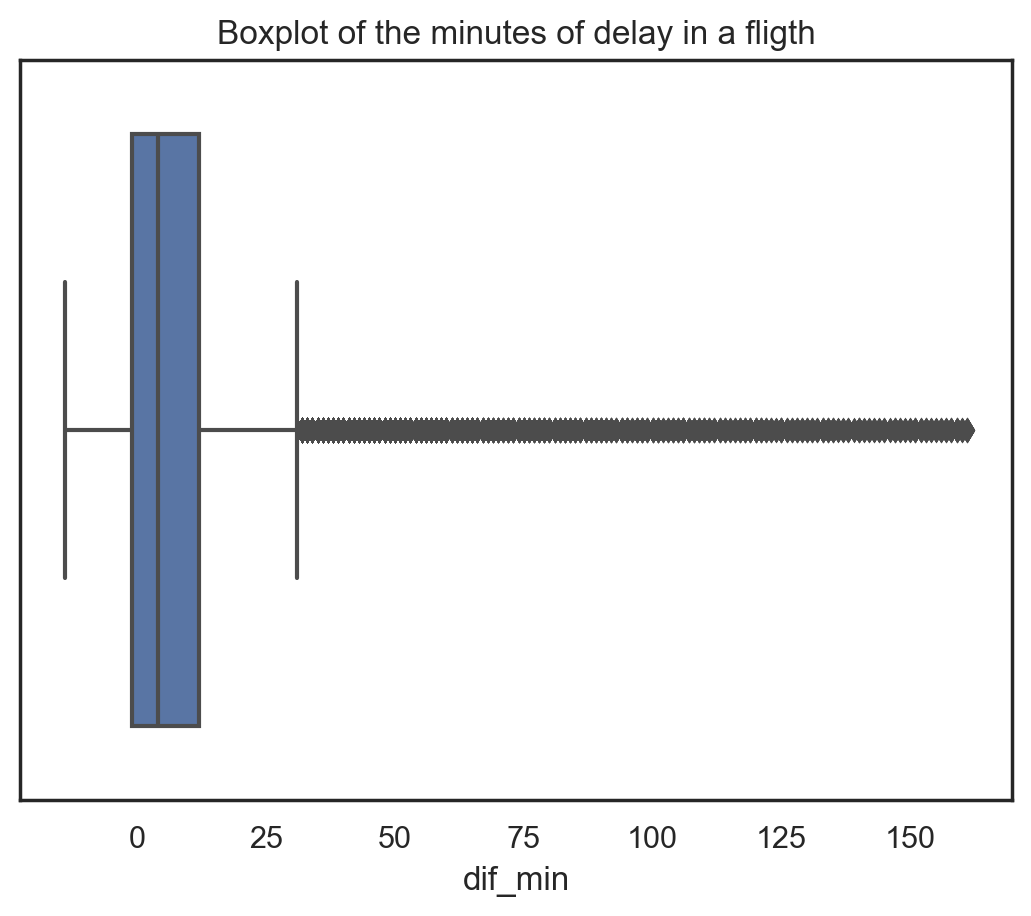

In [18]:
print(df.dif_min.describe())
sns.boxplot(data = df,x= 'dif_min')
plt.title("Boxplot of the minutes of delay in a fligth");

In [19]:
df.describe()

DIA           MES           AÑO       dif_min     atraso_15  \
count  68206.000000  68206.000000  68206.000000  68206.000000  68206.000000   
mean      15.714790      6.622585   2017.000029      9.110855      0.184940   
std        8.782886      3.523321      0.005415     19.313387      0.388252   
min        1.000000      1.000000   2017.000000    -14.000000      0.000000   
25%        8.000000      3.000000   2017.000000     -1.000000      0.000000   
50%       16.000000      7.000000   2017.000000      4.000000      0.000000   
75%       23.000000     10.000000   2017.000000     12.000000      0.000000   
max       31.000000     12.000000   2018.000000    161.000000      1.000000   

       temporada_alta  distance_to_destiny  
count    68206.000000         68206.000000  
mean         0.665044          2501.949680  
std          0.471978          2658.987463  
min          0.000000           196.122990  
25%          0.000000           915.967343  
50%          1.000000          1369.501028  
75%          1.000000          2617.125930  
max          1.000000         11876.627771

In [20]:
aux = list(range(1,33))
for i in df.DIA:
    if(i not in aux):
        raise Exception("Day values out of range")

In [21]:
aux = list(range(1,13))
for i in df.MES:
    if(i not in aux):
        raise Exception("Month values out of range")

In [22]:
aux = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo']
for i in df.DIANOM:
    if(i not in aux):
        raise Exception("Day of the week values out of range")

### **Understand distribution of the data for each variable**

* Check the distribution of the delays in minutes (is there extreme values?)
* Check the distribution of the delays as binary variable (it's balanced?)
* Check the distribution of the count of flights for airlines, flight numbers and city of destiny

**MAIN CONCLUSIONS**


* The dif_min variable has a distribution with big exponential decay from 0 to the negatives and to the positives delays

* The delays after 15 minutes are not balanced, there is 18.5% delays aprox and the rest are not delayed for more than 15 minutes. Some of them, even are ahead of the scheduleded time

* We were able to see identify that when the initial flight code changes, the delay increases significantly. So, we are going to create a binary variable when it happens so the model can measure the impact on the probability to have 15 minutes delay

* The 3 airlines with more than 10k flights are from Chile and all the airlines with more than 1000 flights are from Southamerica and the change in the initial airline code doesn't lead to increase in delay

* We were able to measure the impact on delays when there is a change of code in the city of destiny and we conclude that has an important impact but only happened 28 times, which is the 0.04% of the flights in our database. So, even when is something that we need to watch, probably, introduce it as new variable will not give us too much more power of prediction

* The number of flights by day of the month doesn't has too much variability between days except for the 31, which is obvious since that day doesn't happen every month

* The number of flights by day of the week give us that Friday is the most demanded day, then Thursday and Monday follows

* The number of flights by month of the year give us that the months for the spring and the beggining of the summer in Chile are the most demanded (December, january, November and October, in that order) with more than 6k flights in total. July is the only one near with 5992 flights in the year.

* There is two variable with no more than 1 values: the code for the city of departure and the year in which the flight was operated


------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### **Analysis of delay by magnitud and quantity**

* The dif_min variable has a distribution with big exponential decay from 0 to the negatives and to the positives delays

* The delays after 15 minutes are not balanced, there is 18.5% delays aprox and the rest are not delayed for more than 15 minutes. Some of them, even are ahead of the scheduleded time

In [23]:
num_cols = ['dif_min','distance_to_destiny']

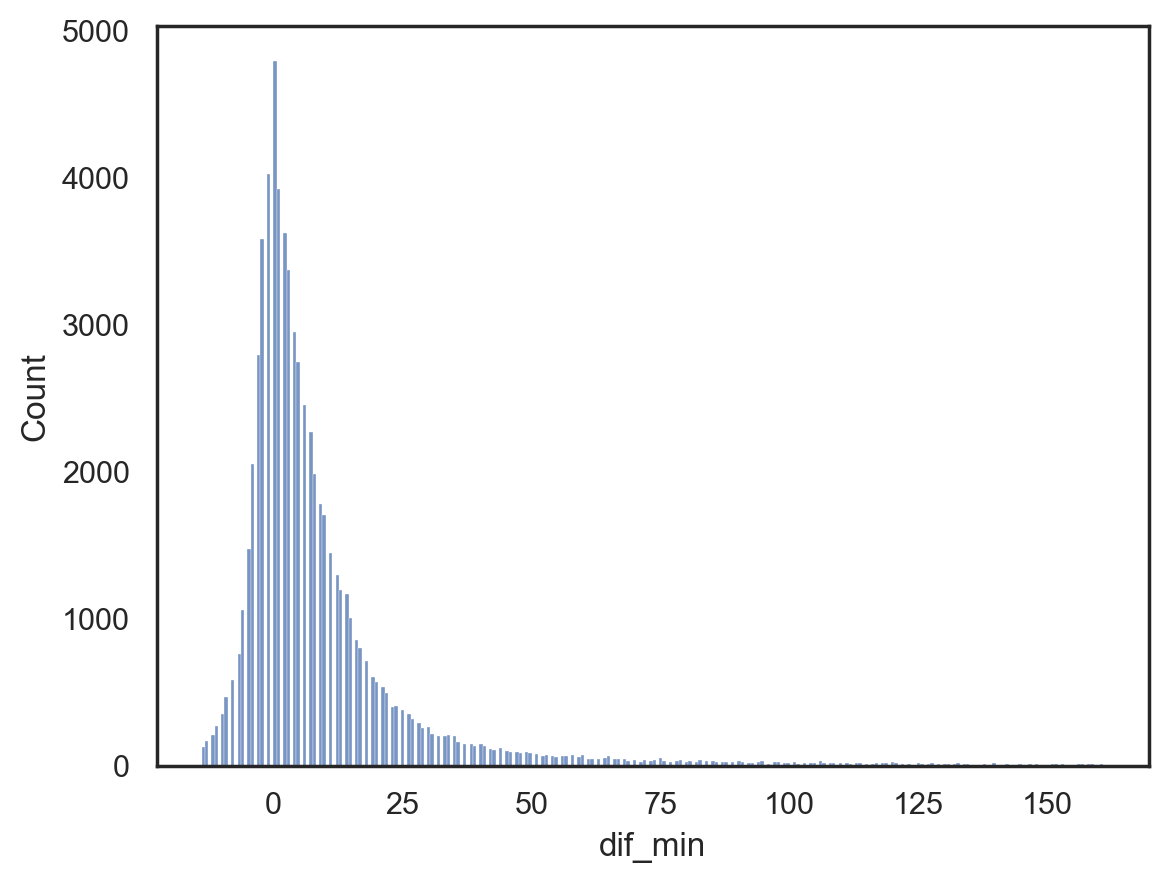

In [24]:
sns.histplot(data = df, x= 'dif_min',);

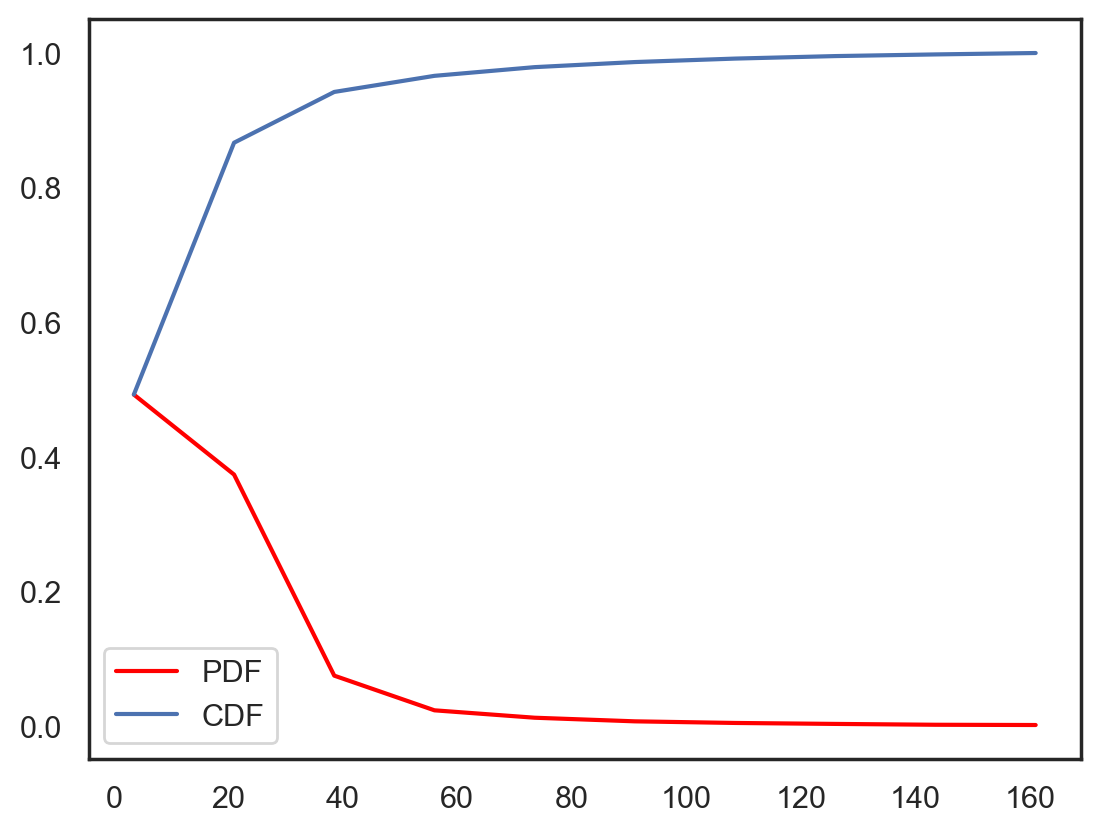

In [25]:
get_cdf_pdf(df.dif_min)

count    45507.000000
mean        15.161536
std         21.083388
min          1.000000
25%          4.000000
50%          8.000000
75%         17.000000
max        161.000000
Name: dif_min, dtype: float64


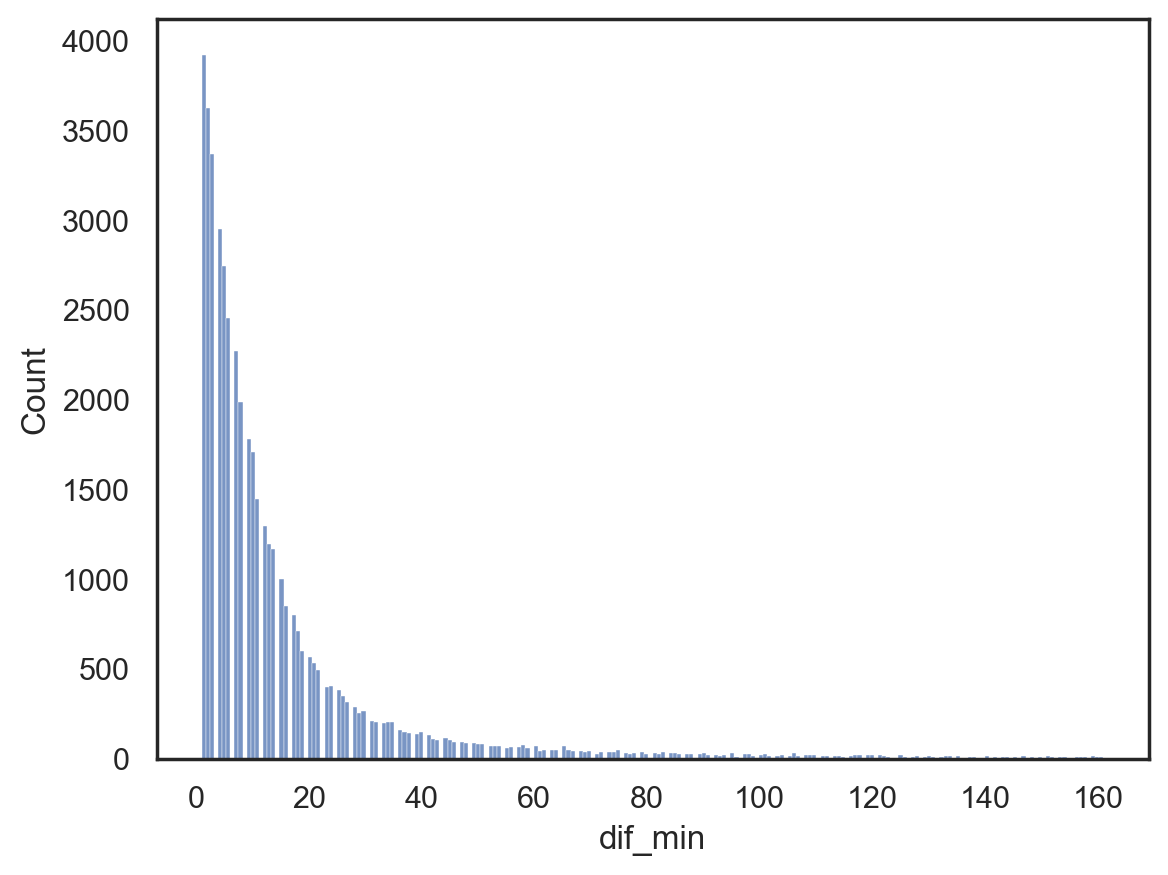

In [26]:
print(df[df.dif_min>0]['dif_min'].describe())
sns.histplot(df[df.dif_min>0]['dif_min']);

count    17910.000000
mean        -3.826968
std          2.909708
min        -14.000000
25%         -5.000000
50%         -3.000000
75%         -2.000000
max         -1.000000
Name: dif_min, dtype: float64


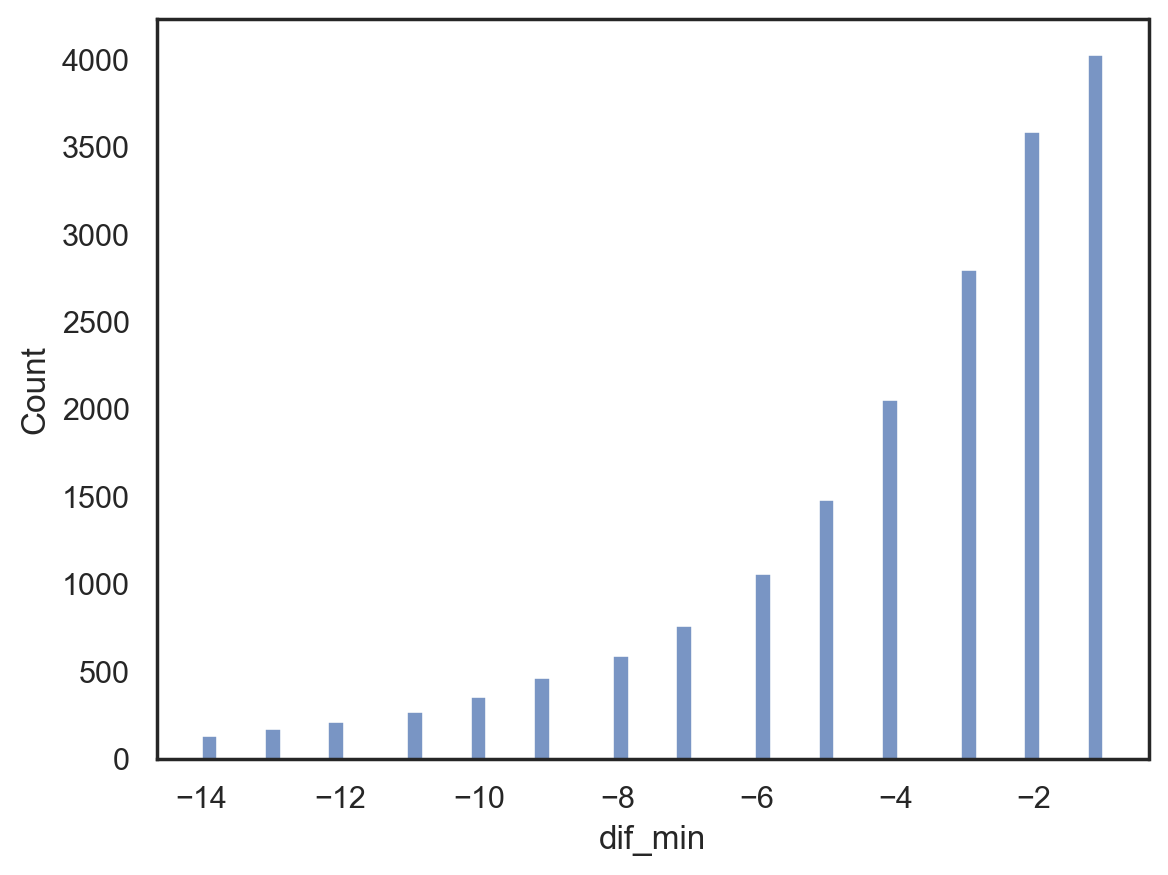

In [27]:
print(df[df.dif_min<0]['dif_min'].describe())
sns.histplot(df[df.dif_min<0]['dif_min']);

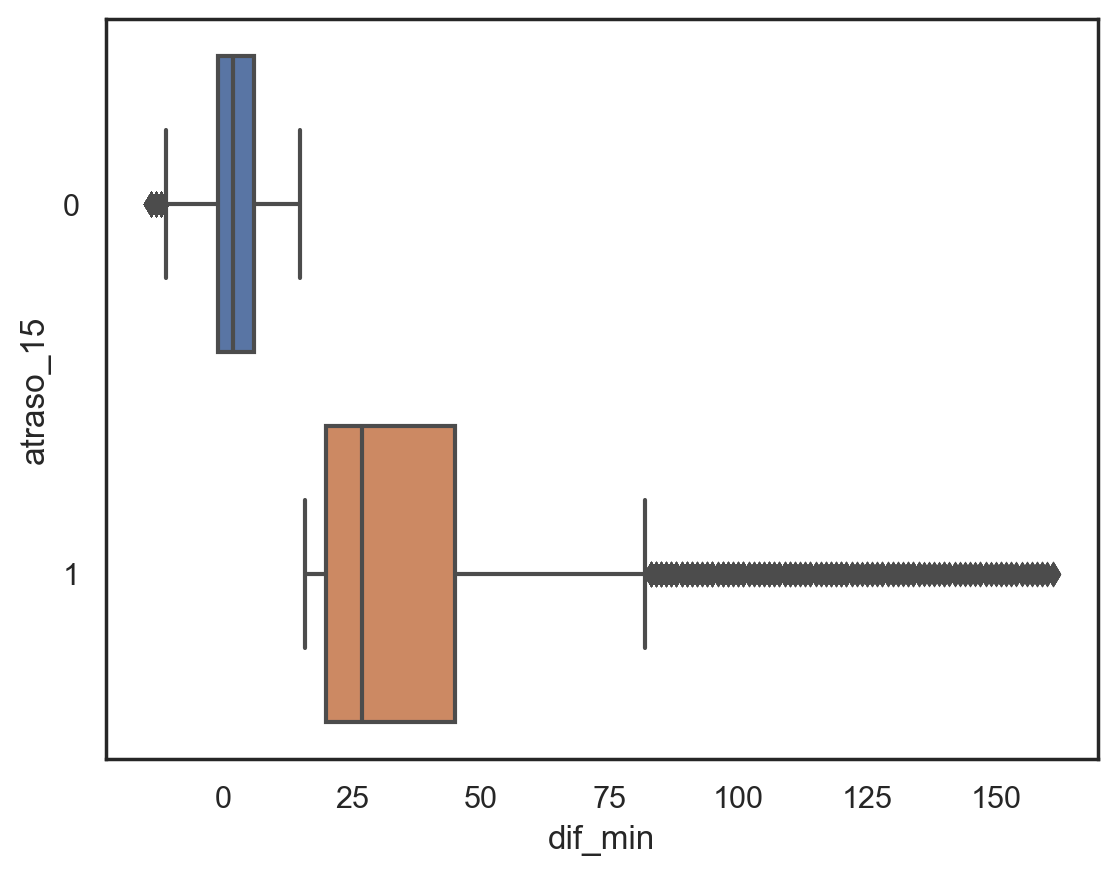

In [28]:
sns.boxplot(data=df, x= "dif_min",y= "atraso_15", orient="h");

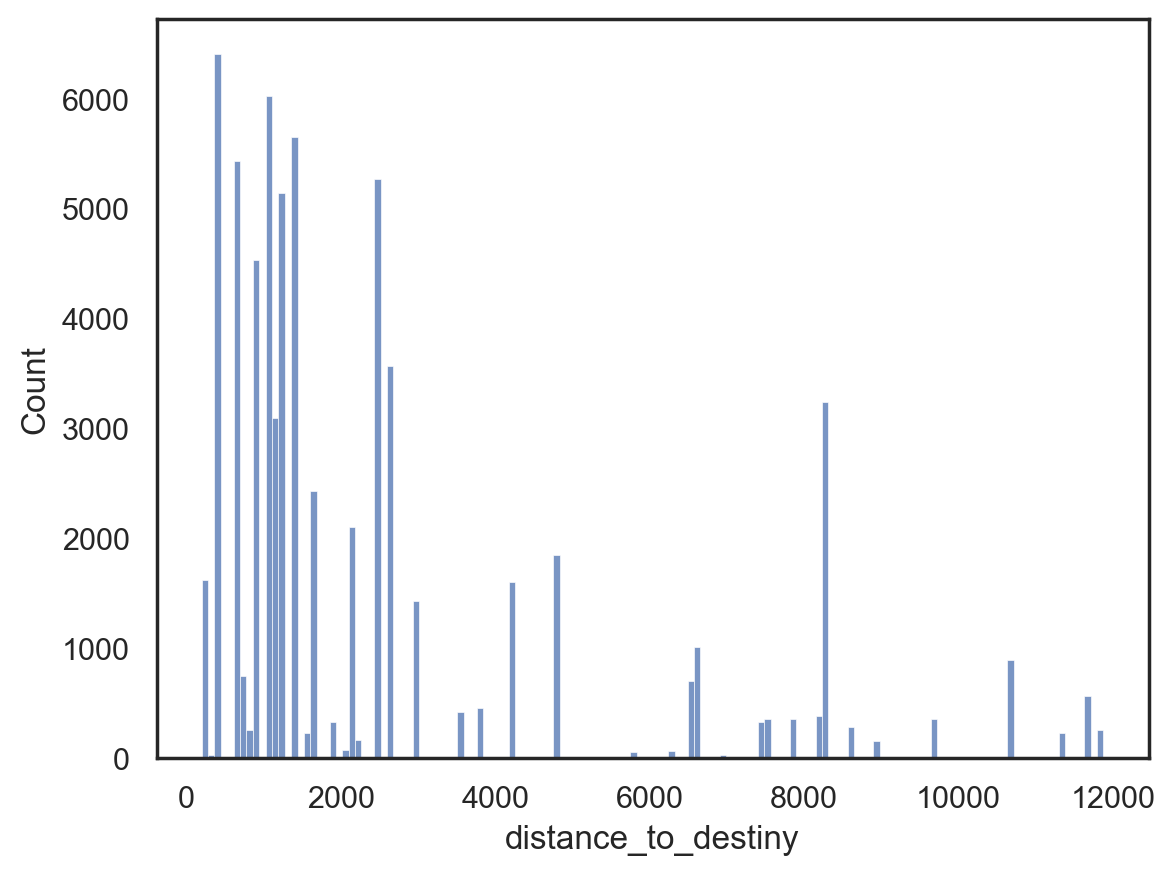

In [29]:
sns.histplot(data = df, x = 'distance_to_destiny');

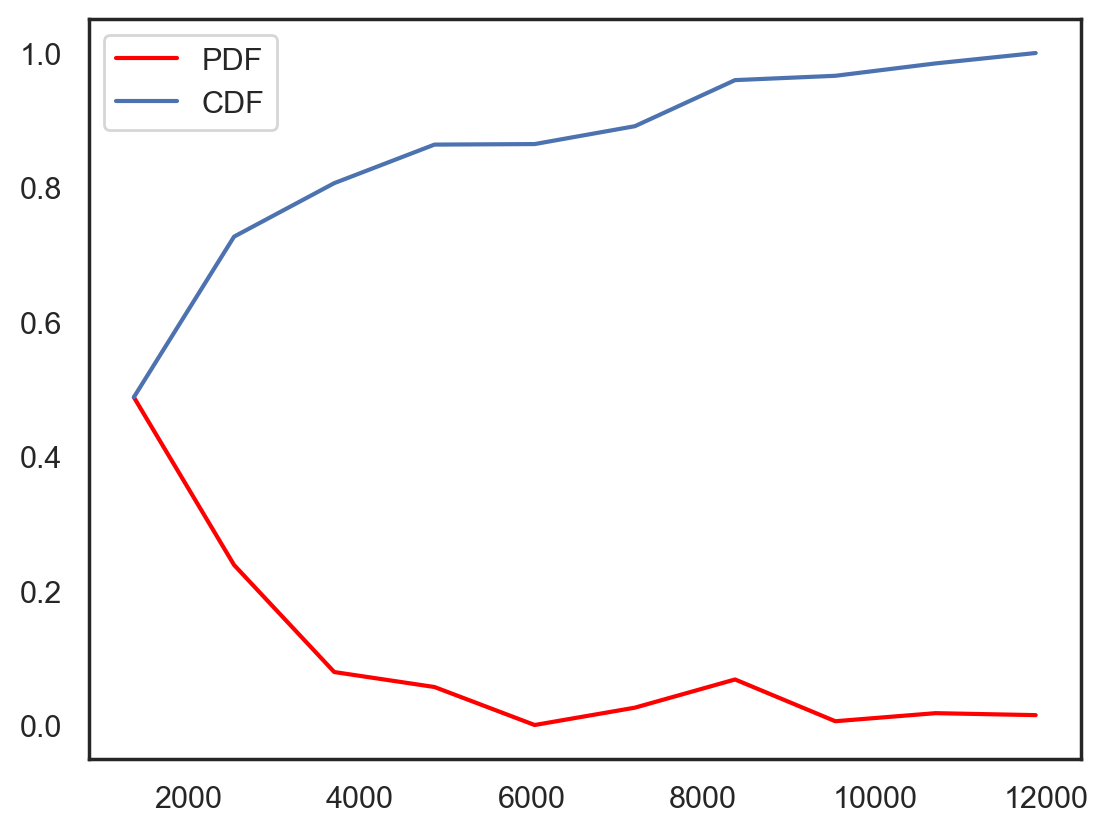

In [30]:
get_cdf_pdf(df.distance_to_destiny)

count    68206.000000
mean      2501.949680
std       2658.987463
min        196.122990
25%        915.967343
50%       1369.501028
75%       2617.125930
max      11876.627771
Name: distance_to_destiny, dtype: float64


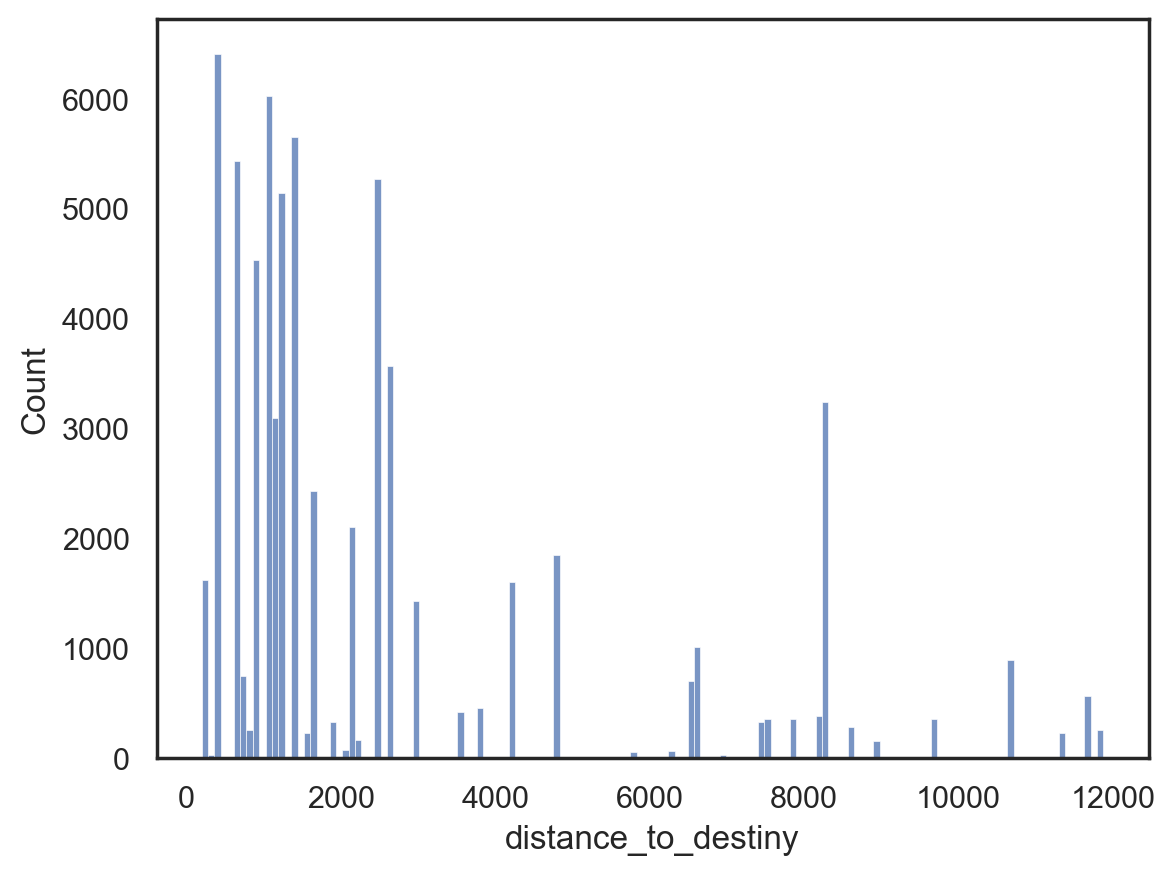

In [31]:
print(df['distance_to_destiny'].describe())
sns.histplot(df['distance_to_destiny']);

#### **Analysis of the distribution of the cities and on the impact on delay for the change of code in the city of destiny**

* As we can see on the analysis, most of the flights goes mainly to another cities of Chile or cities from countries that are near like Buenos Aires and Lima. Panama city is the only one with more tha 1000 flights on the year that is not on South America

* We were able to measure the impact on delays when there is a change of code in the city of destiny and we conclude that has an important impact but only happened 28 times, which is the 0.04% of the flights in our database. So, even when is something that we need to watch, probably, introduce it as new variable will not give us too much more power of prediction

             Ori-I
count    62.000000
mean   1100.096774
std    1613.243080
min       1.000000
25%      56.250000
50%     345.500000
75%    1561.750000
max    6335.000000


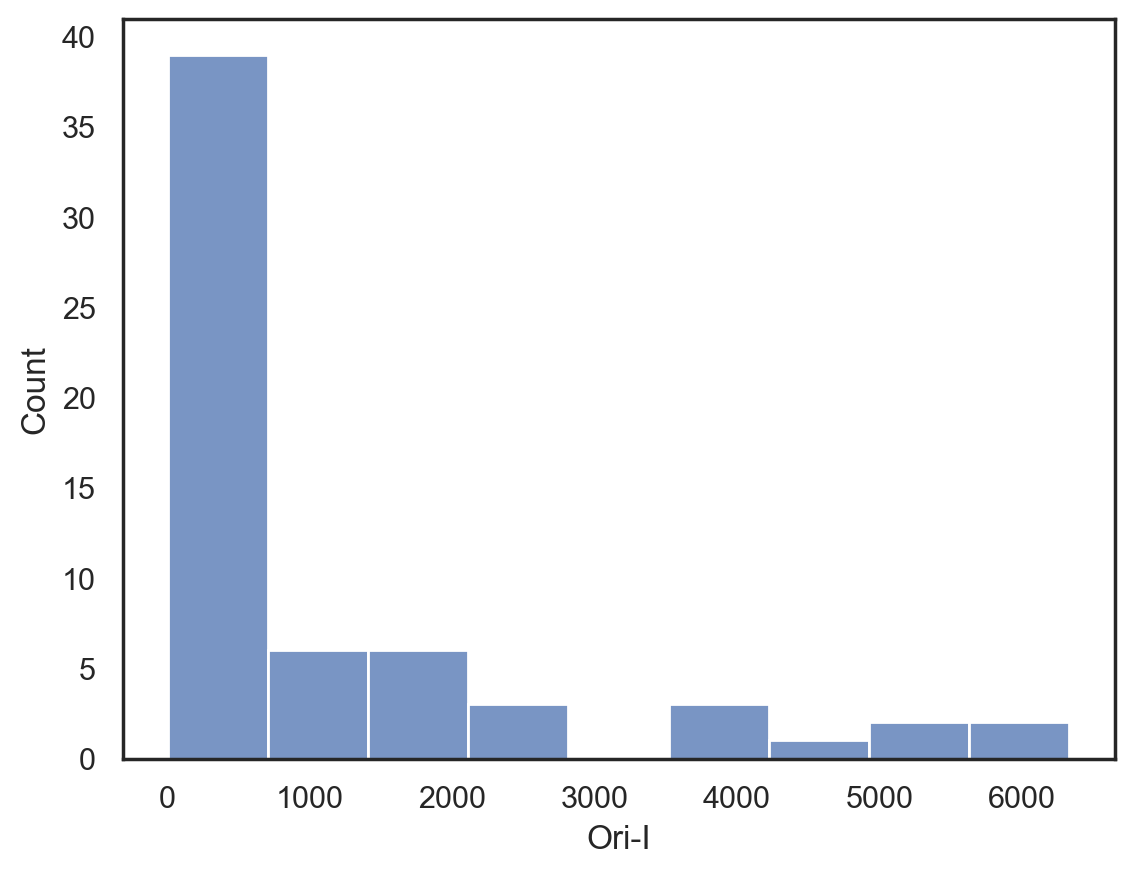

In [32]:
aux = df.groupby('City/Town')['Ori-I'].count().reset_index().sort_values(by='Ori-I')
print(aux.describe())
sns.histplot(aux['Ori-I']);

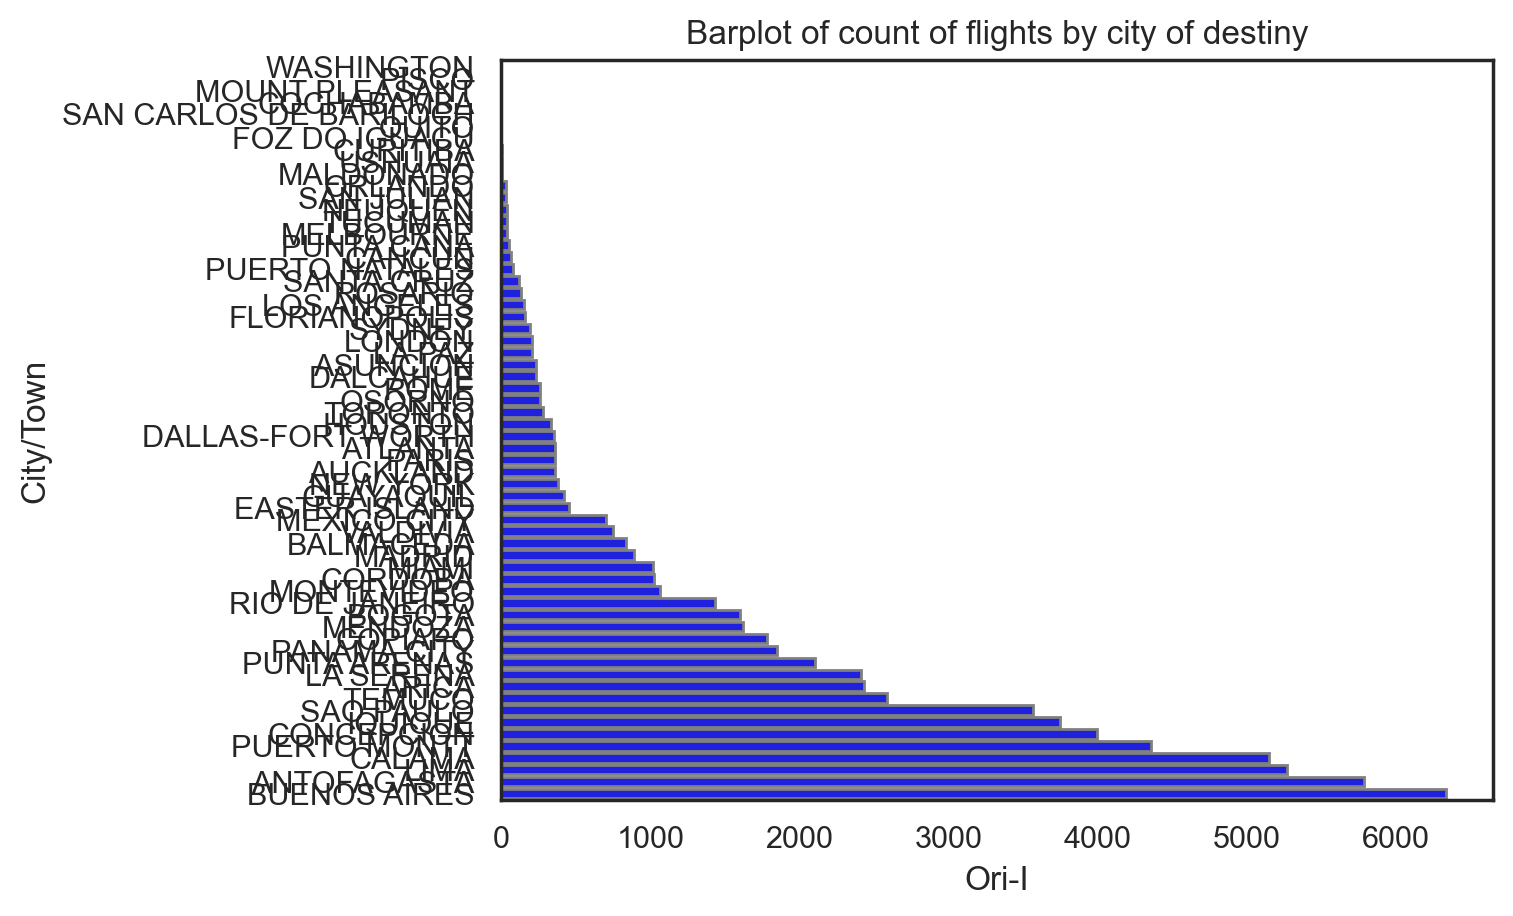

In [33]:
sns.barplot(
    x="Ori-I", y="City/Town",data=aux, orient='h',
    linewidth=1, edgecolor="0.5", color='blue'
)
plt.title('Barplot of count of flights by city of destiny')
plt.show();

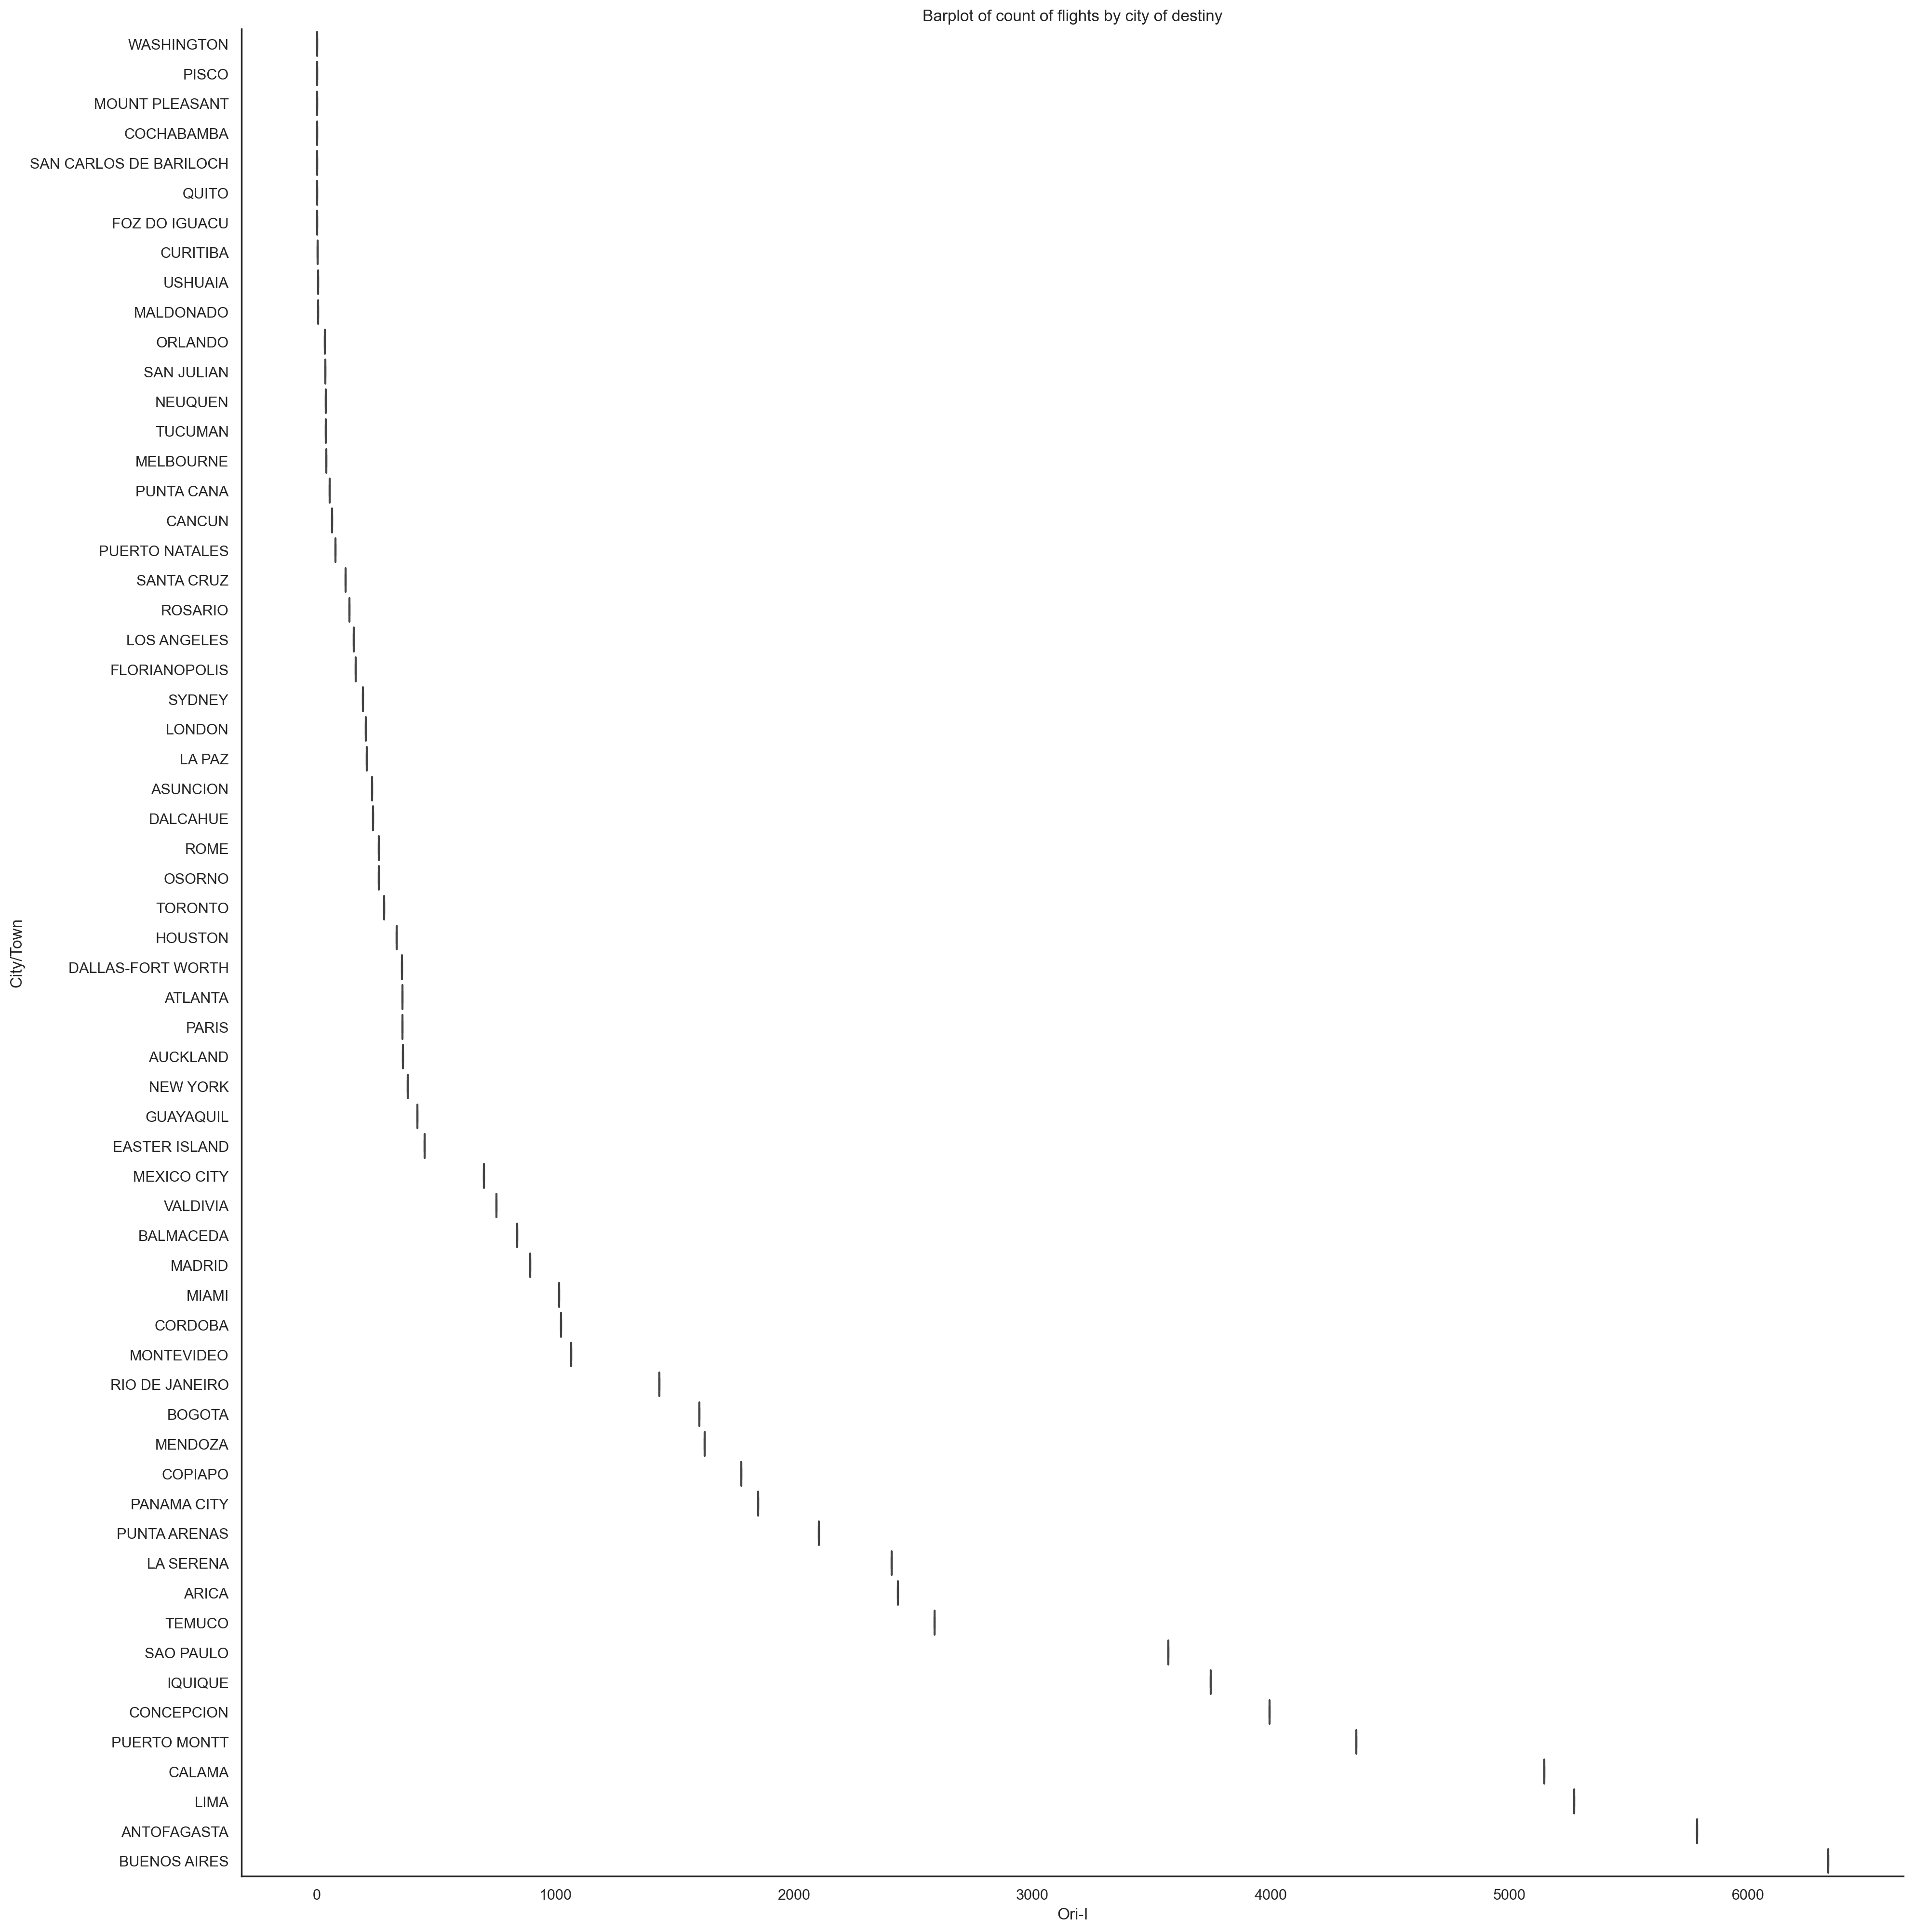

In [34]:
sns.catplot(x="Ori-I", y="City/Town",data=aux, height=20,kind="box",order = aux['City/Town'])
plt.title('Barplot of count of flights by city of destiny')
plt.show();

In [35]:
aux = df.groupby(['City/Town','Des-I','Des-O'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
print(aux.shape)
aux.head(20)

(78, 4)


City/Town Des-I Des-O  Ori-I
77              WASHINGTON  KIAH  KIAD      1
60                   QUITO  SEQU  SEQM      1
37               MELBOURNE  YSSY  YMML      1
40                   MIAMI  KJFK  KMIA      1
43          MOUNT PLEASANT  EGYP  EGYP      1
70                  TEMUCO  SCIE  SCQP      1
15              COCHABAMBA  SLCB  SLCB      1
13                  CALAMA  SCFA  SCCF      1
24           FOZ DO IGUACU  SARI  SBFI      1
11            BUENOS AIRES  SEGU  SABE      1
25           FOZ DO IGUACU  SBFI  SBFI      1
52            PUERTO MONTT  SCCI  SCTE      1
53            PUERTO MONTT  SCIE  SCTE      1
62          RIO DE JANEIRO  SBGR  SBGL      1
57            PUNTA ARENAS  SCTE  SCCI      1
59                   QUITO  SEQM  SEQM      1
50                   PISCO  SPSO  SPSO      1
65  SAN CARLOS DE BARILOCH  SAZS  SAZS      2
9             BUENOS AIRES  SAEZ  SABE      3
19                CURITIBA  SBCT  SBCT      3

In [36]:
aux[aux['City/Town']=='BUENOS AIRES']

City/Town Des-I Des-O  Ori-I
11  BUENOS AIRES  SEGU  SABE      1
9   BUENOS AIRES  SAEZ  SABE      3
8   BUENOS AIRES  SABE  SAEZ      4
7   BUENOS AIRES  SABE  SABE   3090
10  BUENOS AIRES  SAEZ  SAEZ   3237

In [37]:
aux[aux['City/Town']=='PUERTO MONTT']

City/Town Des-I Des-O  Ori-I
52  PUERTO MONTT  SCCI  SCTE      1
53  PUERTO MONTT  SCIE  SCTE      1
51  PUERTO MONTT  SCBA  SCTE      4
54  PUERTO MONTT  SCTE  SCTE   4351

In [38]:
aux[aux['City/Town']=='MIAMI']

City/Town Des-I Des-O  Ori-I
40     MIAMI  KJFK  KMIA      1
41     MIAMI  KMIA  KMIA   1015

In [39]:
aux[aux['City/Town']=='CALAMA']

City/Town Des-I Des-O  Ori-I
13    CALAMA  SCFA  SCCF      1
12    CALAMA  SCCF  SCCF   5145

In [40]:
aux = df.groupby(['City/Town','Des-I'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
print(aux.shape)
aux.head(20)

(76, 3)


City/Town Des-I  Ori-I
75              WASHINGTON  KIAH      1
48                   PISCO  SPSO      1
51            PUERTO MONTT  SCIE      1
41          MOUNT PLEASANT  EGYP      1
55            PUNTA ARENAS  SCTE      1
38                   MIAMI  KJFK      1
57                   QUITO  SEQM      1
35               MELBOURNE  YSSY      1
58                   QUITO  SEQU      1
60          RIO DE JANEIRO  SBGR      1
23           FOZ DO IGUACU  SBFI      1
22           FOZ DO IGUACU  SARI      1
13              COCHABAMBA  SLCB      1
50            PUERTO MONTT  SCCI      1
68                  TEMUCO  SCIE      1
9             BUENOS AIRES  SEGU      1
11                  CALAMA  SCFA      1
63  SAN CARLOS DE BARILOCH  SAZS      2
17                CURITIBA  SBCT      3
49            PUERTO MONTT  SCBA      4

In [41]:
aux[aux['City/Town']=='QUITO']

City/Town Des-I  Ori-I
57     QUITO  SEQM      1
58     QUITO  SEQU      1

In [42]:
aux[aux['City/Town']=='WASHINGTON']

City/Town Des-I  Ori-I
75  WASHINGTON  KIAH      1

In [43]:
aux[aux['City/Town']=='SAN CARLOS DE BARILOCH']

City/Town Des-I  Ori-I
63  SAN CARLOS DE BARILOCH  SAZS      2

In [44]:
aux[aux['City/Town']=='BUENOS AIRES']

City/Town Des-I  Ori-I
9  BUENOS AIRES  SEGU      1
7  BUENOS AIRES  SABE   3094
8  BUENOS AIRES  SAEZ   3240

In [45]:
aux = df.groupby(['City/Town','Des-I'])['Ori-O'].count().reset_index().sort_values(by='Ori-O')
print(aux.shape)
aux.head(10)

(76, 3)


City/Town Des-I  Ori-O
75      WASHINGTON  KIAH      1
48           PISCO  SPSO      1
51    PUERTO MONTT  SCIE      1
41  MOUNT PLEASANT  EGYP      1
55    PUNTA ARENAS  SCTE      1
38           MIAMI  KJFK      1
57           QUITO  SEQM      1
35       MELBOURNE  YSSY      1
58           QUITO  SEQU      1
60  RIO DE JANEIRO  SBGR      1

In [46]:
aux[aux['City/Town']=='TEMUCO']

City/Town Des-I  Ori-O
68    TEMUCO  SCIE      1
70    TEMUCO  SCTE      5
69    TEMUCO  SCQP   2583

In [47]:
aux[aux['City/Town']=='CALAMA']

City/Town Des-I  Ori-O
11    CALAMA  SCFA      1
10    CALAMA  SCCF   5145

In [48]:
aux[aux['City/Town']=='PUERTO MONTT']

City/Town Des-I  Ori-O
51  PUERTO MONTT  SCIE      1
50  PUERTO MONTT  SCCI      1
49  PUERTO MONTT  SCBA      4
52  PUERTO MONTT  SCTE   4351

count    68178.000000
mean         9.104080
std         19.295386
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: dif_min, dtype: float64


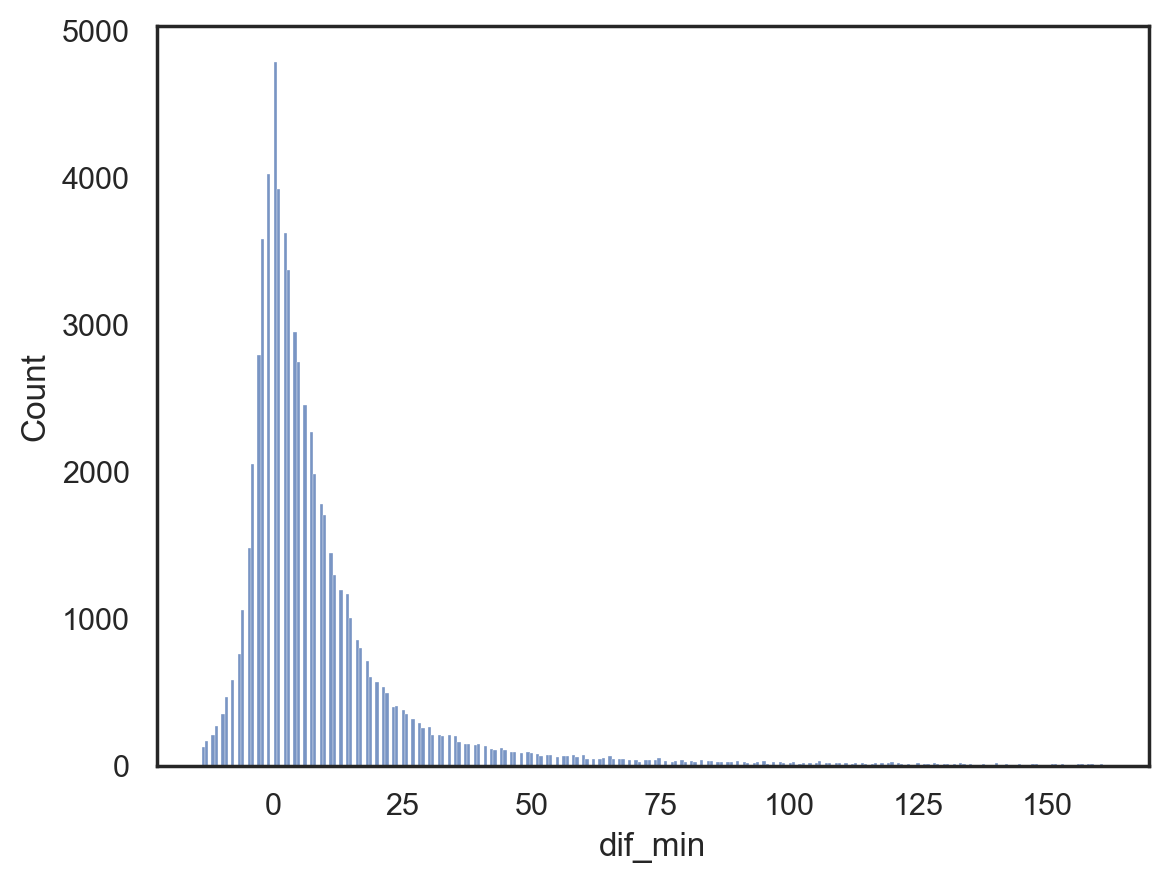

In [49]:
print(df[df['Des-I'] == df['Des-O']].dif_min.describe())
sns.histplot(df[df['Des-I'] == df['Des-O']].dif_min);

count     28.000000
mean      25.607143
std       43.121138
min       -6.000000
25%        1.000000
50%        7.500000
75%       27.250000
max      147.000000
Name: dif_min, dtype: float64


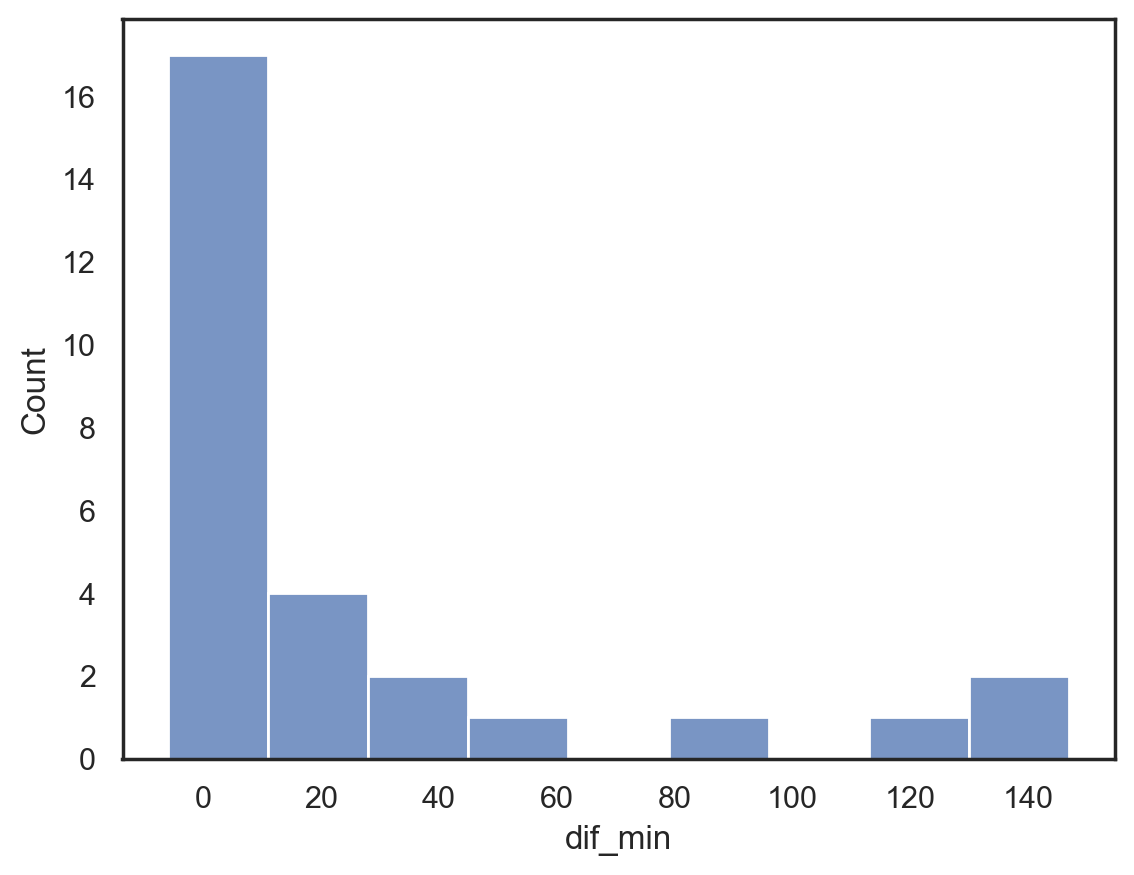

In [50]:
print(df[df['Des-I'] != df['Des-O']].dif_min.describe())
sns.histplot(df[df['Des-I'] != df['Des-O']].dif_min);

#### **Analysis of the number of flights and the impact on delays in the change of the flight code**

**Conclusions**

* The number of flights has a half of codes with less than 43 flight and then we have some codes that can reach to 686 flights on the year

* Something important is to answer: which is the impact of the frequency of the flight code in the delay? more frequent code of flights are more propense to have delays (maybe, because the flight is always crowded) or less (because is not an important flight for the airline)? 

* As we can see here, a change in the code of flights leads to bigger times of delay and this happened in 4519 flights, which is the 6.6% of the flights of the year. So, we are going to create a binary variable when this happens.

------------------------------------------------------------------------------------------------------------------------------------------------------------------

            Ori-I
count  584.000000
mean   116.791096
std    141.842062
min      1.000000
25%      3.000000
50%     43.000000
75%    218.500000
max    686.000000


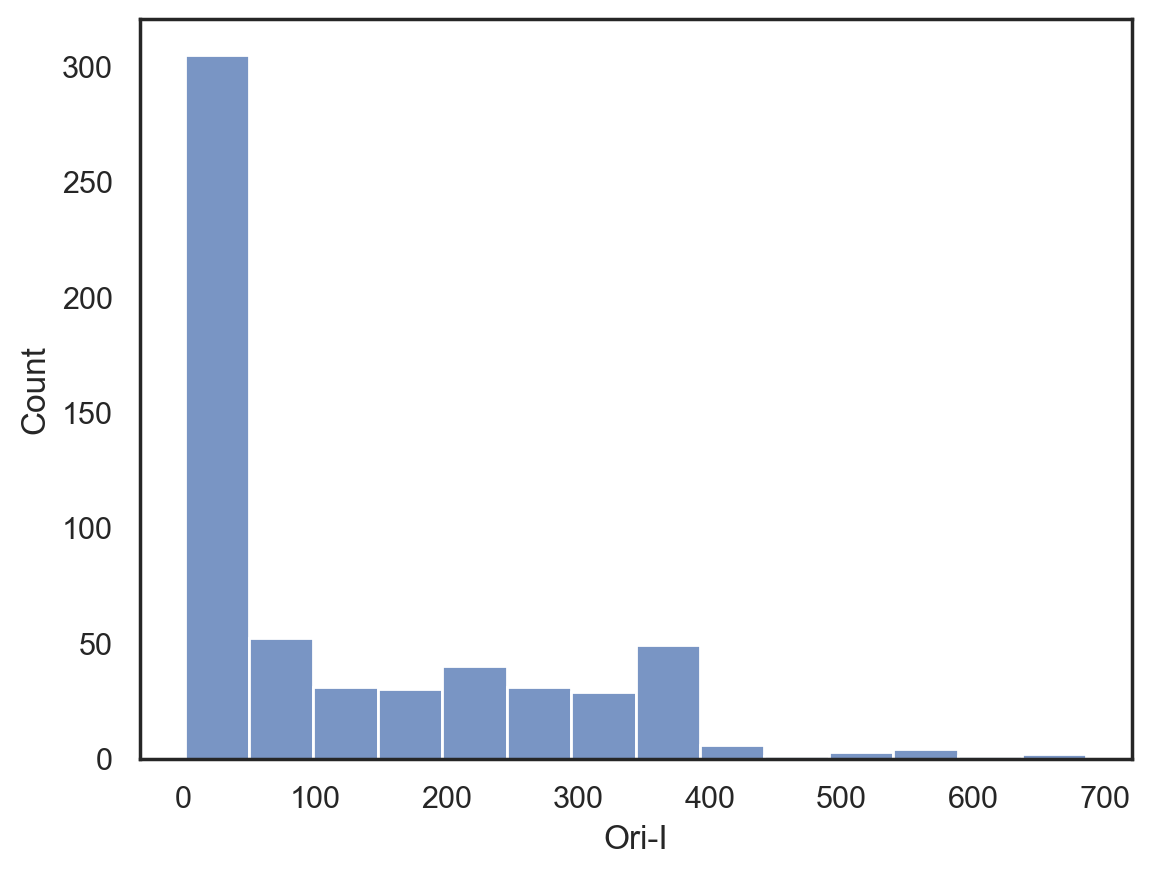

In [51]:
aux = df.groupby('Vlo-I')['Ori-I'].count().reset_index().sort_values(by='Ori-I')
print(aux.describe())
sns.histplot(aux['Ori-I']);

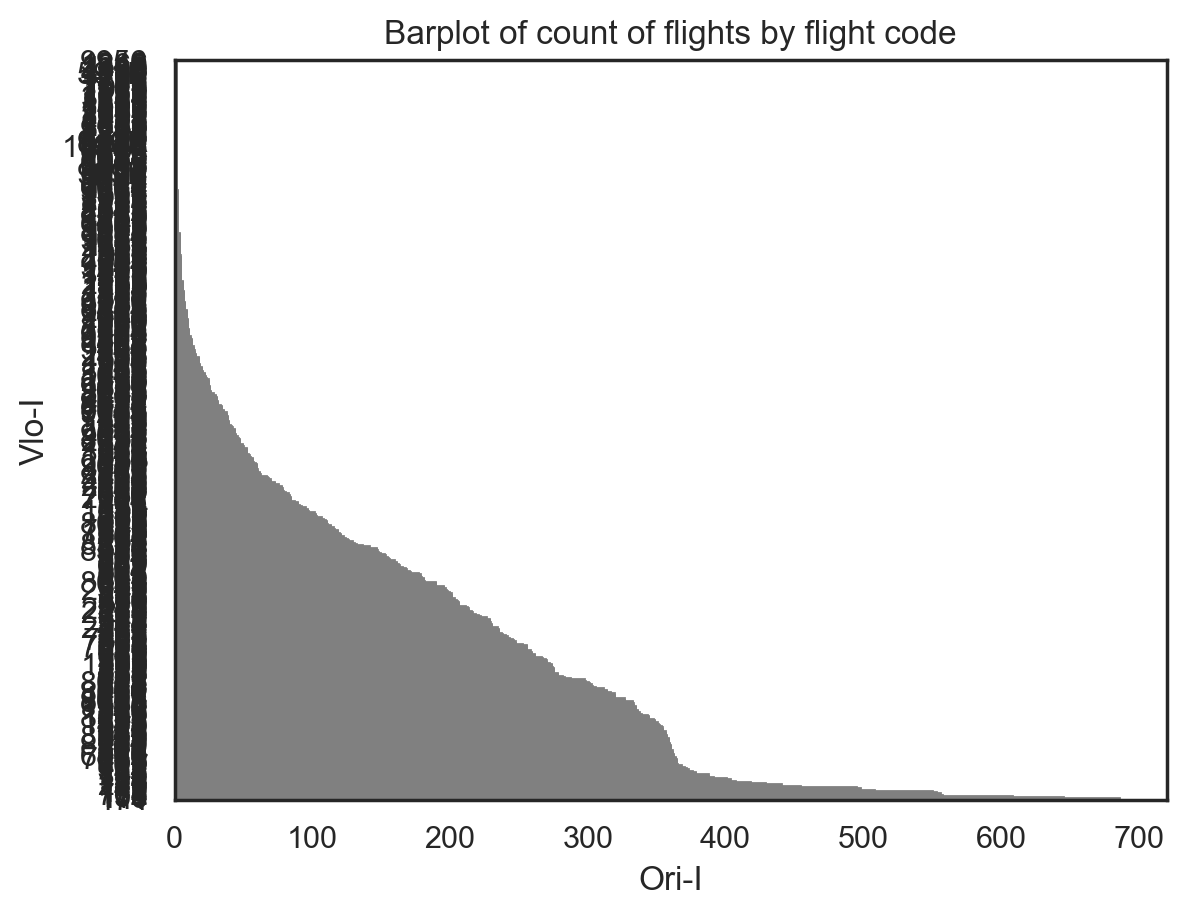

In [52]:
sns.barplot(
    x="Ori-I", y="Vlo-I",data=aux, orient='h',
    linewidth=1, edgecolor="0.5", color='blue'
)
plt.title('Barplot of count of flights by flight code')
plt.show();

count    63687.000000
mean         8.885565
std         19.245271
min        -14.000000
25%         -1.000000
50%          3.000000
75%         11.000000
max        161.000000
Name: dif_min, dtype: float64


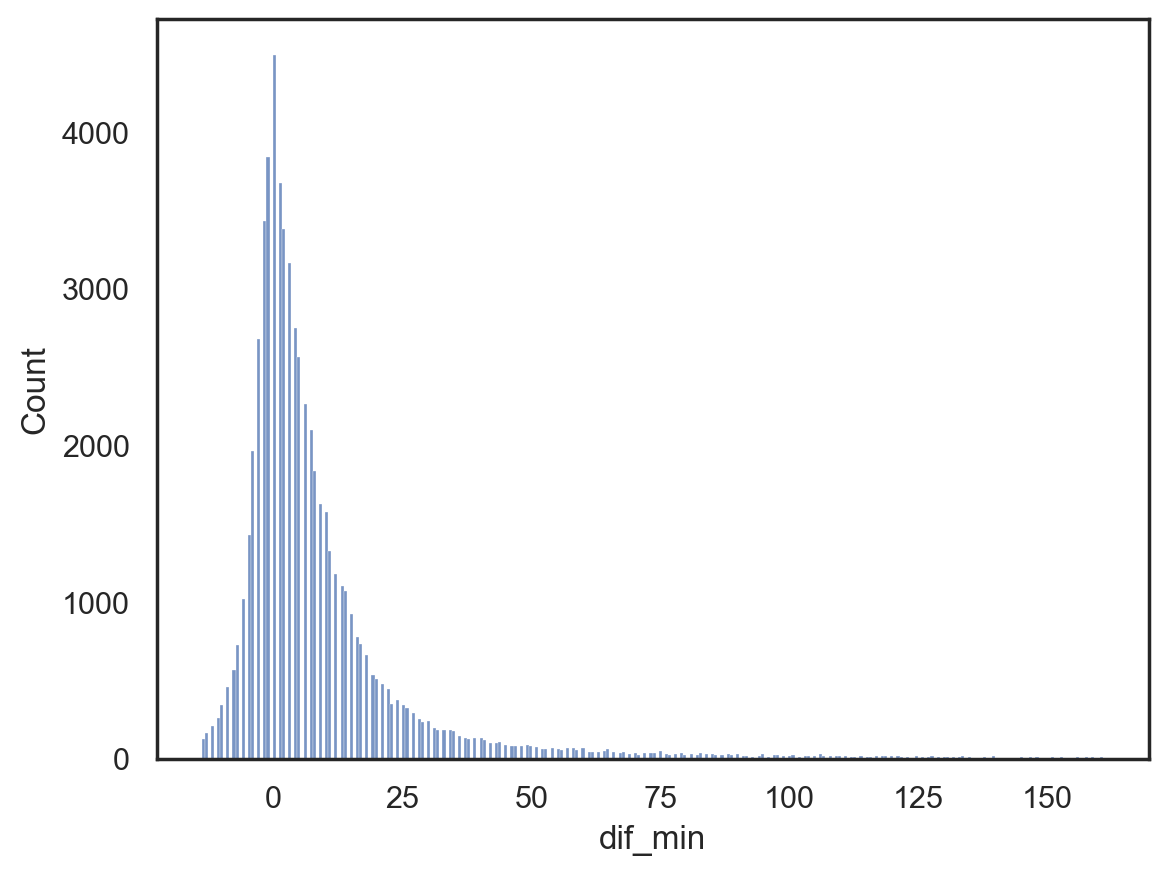

In [53]:
print(df[df['Vlo-I'] == df['Vlo-O']].dif_min.describe())
sns.histplot(df[df['Vlo-I'] == df['Vlo-O']].dif_min);

count    4519.000000
mean       12.285904
std        19.982831
min       -13.000000
25%         1.000000
50%         7.000000
75%        16.000000
max       159.000000
Name: dif_min, dtype: float64


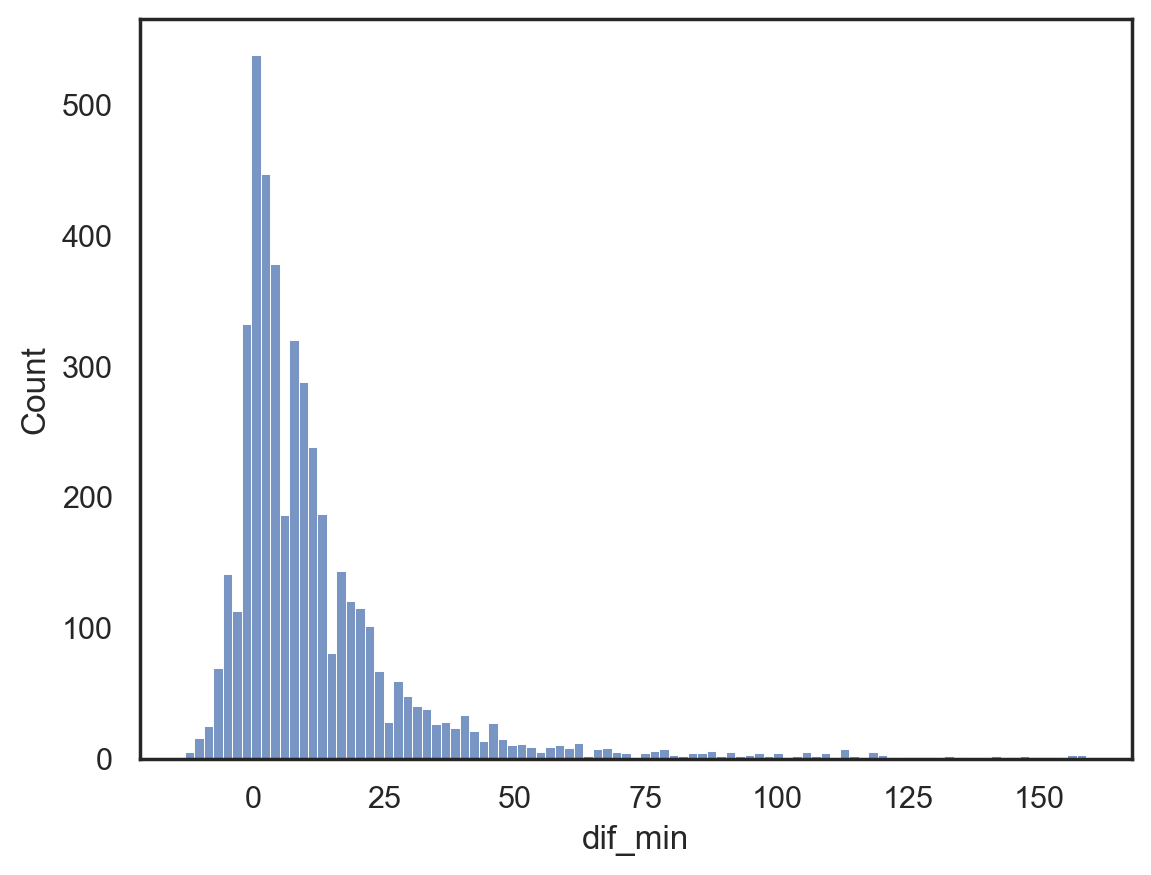

In [54]:
print(df[df['Vlo-I'] != df['Vlo-O']].dif_min.describe())
sns.histplot(df[df['Vlo-I'] != df['Vlo-O']].dif_min);

#### **Analysis of the airline which operate the flight and the impact on the change in it for operation**

**Conclusions**

* A few local airlines has most of the flights departure for SCL, probably because they do all the nationals flights plus internationals 

* Something important is to answer: if the airlines has more flights are more propense to have delays or less? we think that probably has less because ussualy will be airlines with more and better slots, more equipment for maintainance in the airport, more crew to help in case of contingency, etc.

* As we can see here, a change in the code of fthe airlines doesn't leads to bigger times of delay and this happened in 18.669 flights, which is the 27% of the flights of the year, probably because there is a lot of "code share" flights.
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

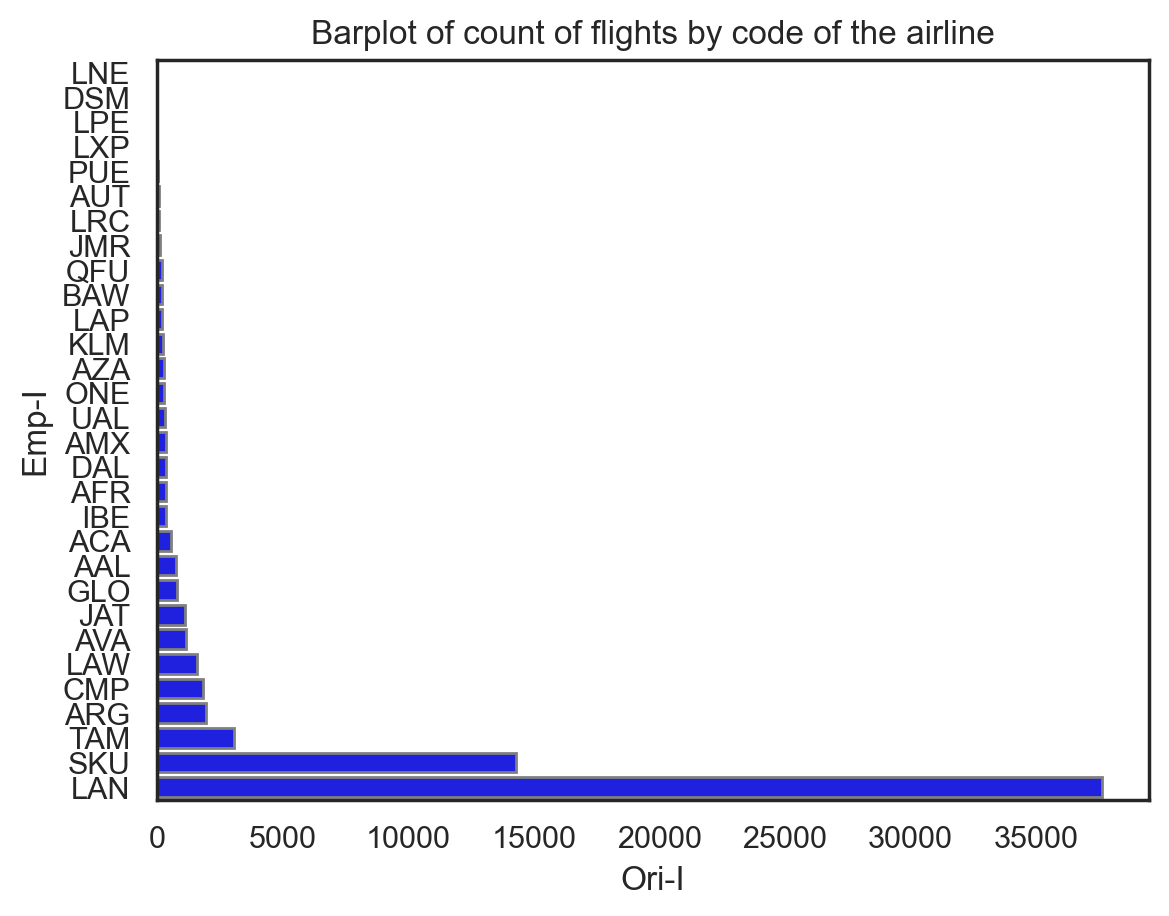

In [55]:
aux = df.groupby('Emp-I')['Ori-I'].count().reset_index().sort_values(by='Ori-I')
sns.barplot(
    x="Ori-I", y="Emp-I",data=aux, orient='h',
    linewidth=1, edgecolor="0.5", color='blue'
)
plt.title('Barplot of count of flights by code of the airline')
plt.show();

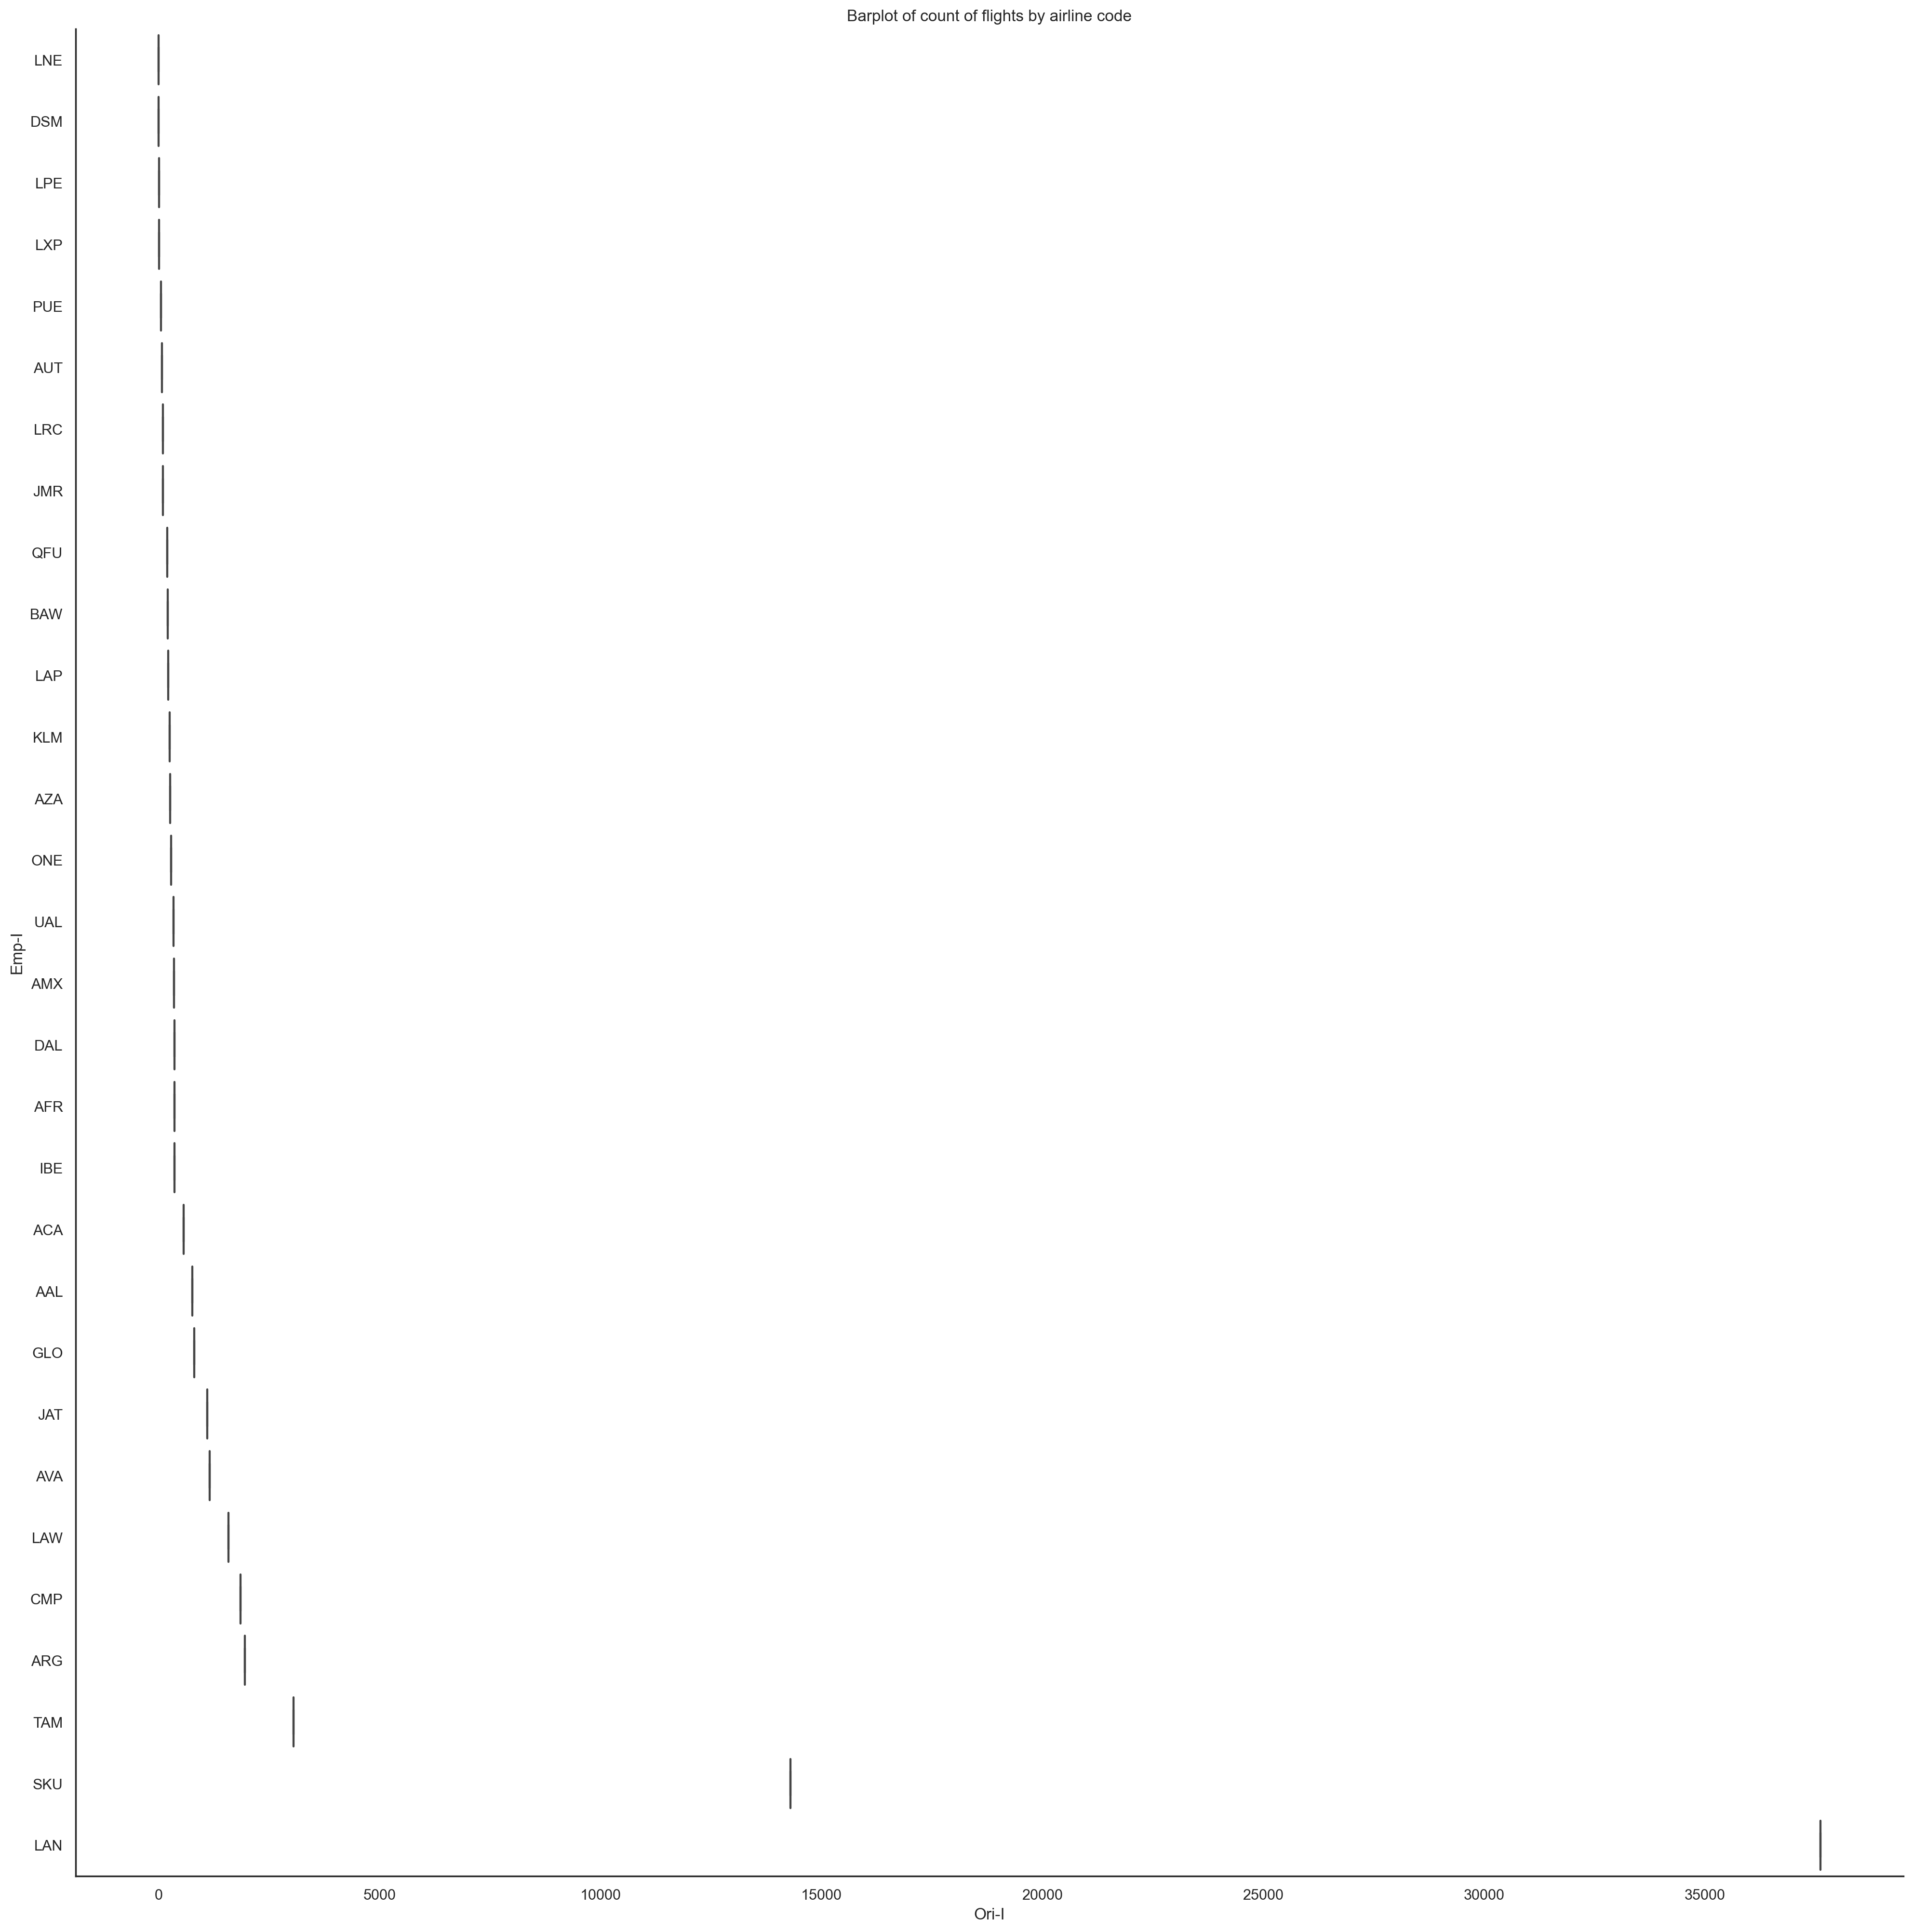

In [56]:
sns.catplot(y="Emp-I", x="Ori-I",data=aux, height=20,kind="box",order = aux['Emp-I'])
plt.title('Barplot of count of flights by airline code')
plt.show();

count    49537.000000
mean         8.785696
std         18.985841
min        -14.000000
25%         -1.000000
50%          3.000000
75%         12.000000
max        161.000000
Name: dif_min, dtype: float64


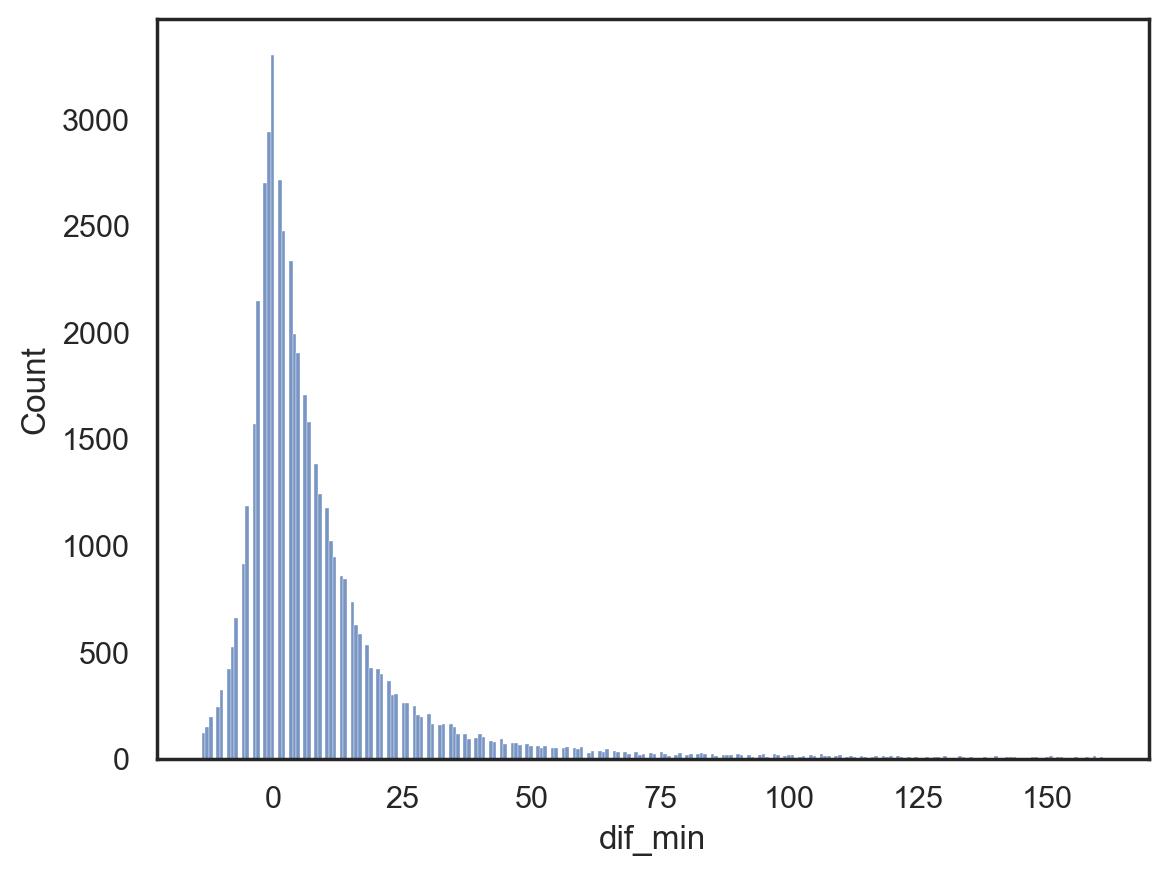

In [57]:
print(df[df['Emp-I'] == df['Emp-O']].dif_min.describe())
sns.histplot(df[df['Emp-I'] == df['Emp-O']].dif_min);

count    18669.000000
mean         9.973646
std         20.131809
min        -14.000000
25%          0.000000
50%          4.000000
75%         11.000000
max        161.000000
Name: dif_min, dtype: float64


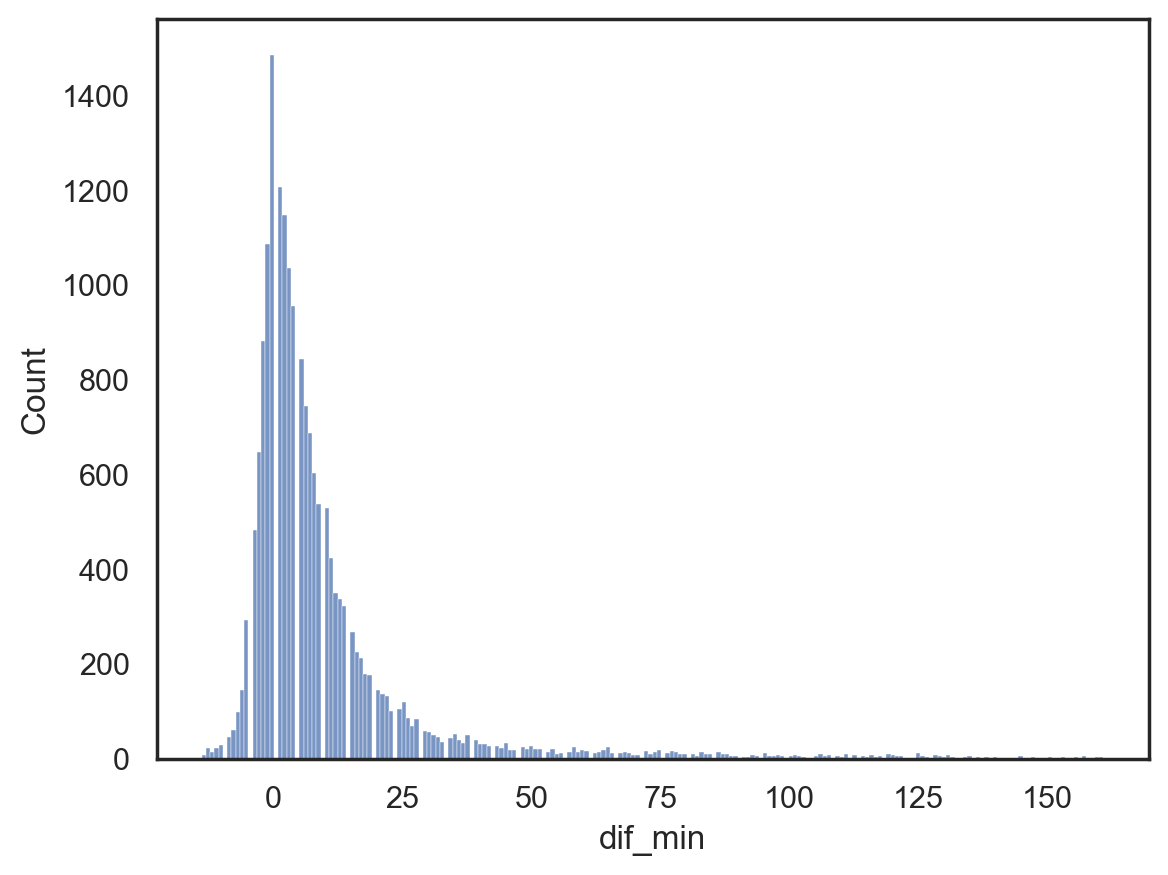

In [58]:
print(df[df['Emp-I'] != df['Emp-O']].dif_min.describe())
sns.histplot(df[df['Emp-I'] != df['Emp-O']].dif_min);

#### **Analysis of the frequency of flights for day and month of the year and day of the week**

**Conclusions**

* The number of flights by day of the month doesn't has too much variability between days except for the 31, which is obvious since that day doesn't happen every month

* The number of flights by day of the week give us that Friday is the most demanded day, then Thursday and Monday follows

* The number of flights by month of the year give us that the months for the spring and the beggining of the summer in Chile are the most demanded (December, january, November and October, in that order) with more than 6k flights in total. July is the only one near with 5992 flights in the year.

------------------------------------------------------------------------------------------------------------------------------------------------------------------

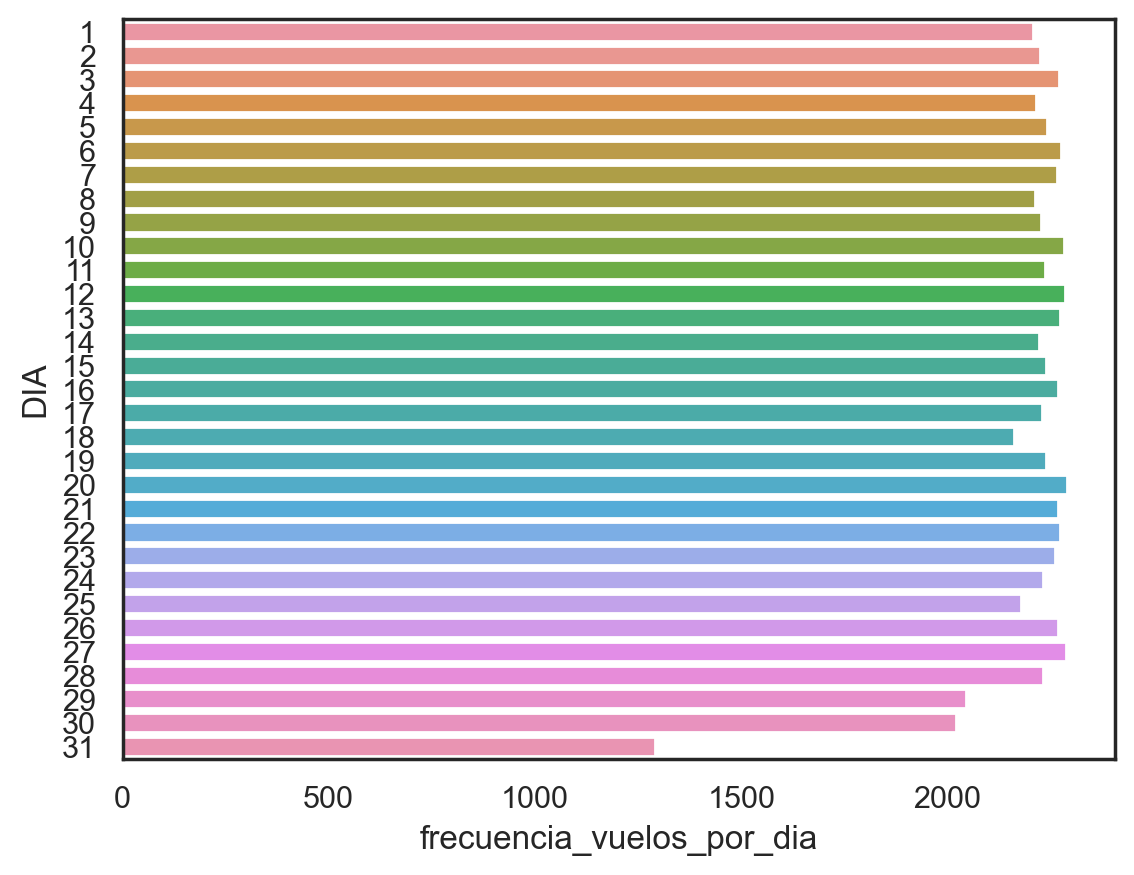

In [59]:
aux = df.groupby(['DIA'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'frecuencia_vuelos_por_dia'}, inplace=True)
sns.barplot(data=aux, y= "DIA",x= "frecuencia_vuelos_por_dia", orient="h");

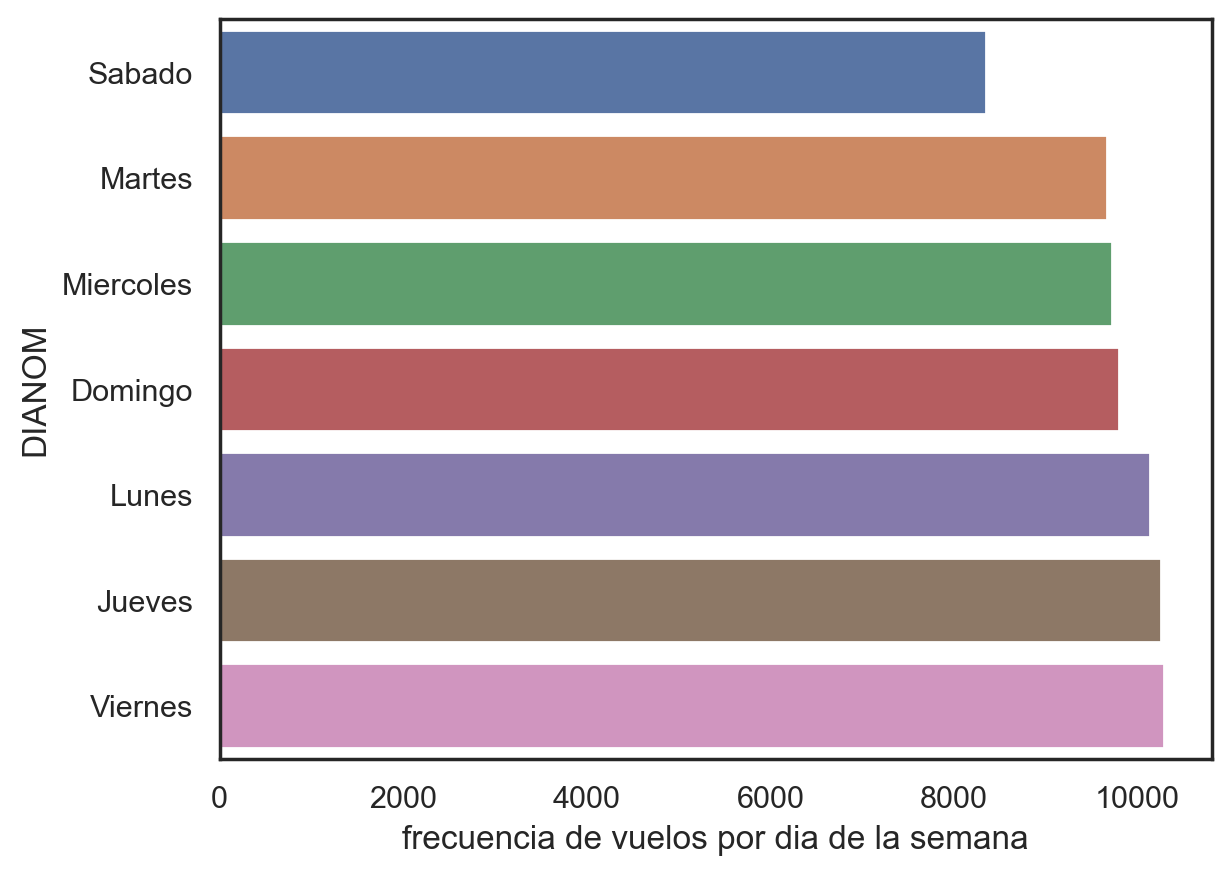

In [60]:
aux = df.groupby(['DIANOM'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'frecuencia de vuelos por dia de la semana'}, inplace=True)
sns.barplot(data=aux, y= "DIANOM",x= "frecuencia de vuelos por dia de la semana", orient="h");

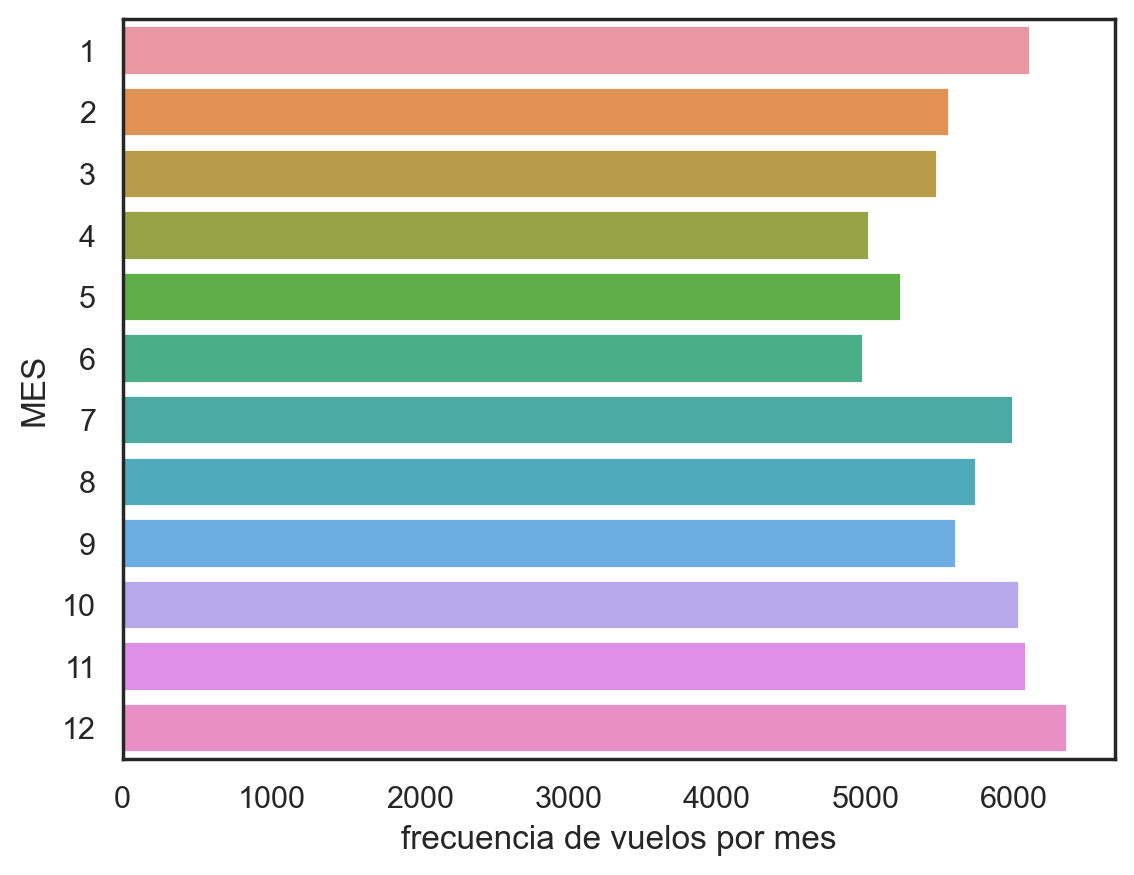

In [61]:
aux = df.groupby(['MES'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'frecuencia de vuelos por mes'}, inplace=True)
sns.barplot(data=aux, y= "MES",x= "frecuencia de vuelos por mes", orient="h");

In [62]:
aux

MES  frecuencia de vuelos por mes
5     6                          4981
3     4                          5020
4     5                          5240
2     3                          5482
1     2                          5561
8     9                          5610
7     8                          5744
6     7                          5992
9    10                          6032
10   11                          6080
0     1                          6108
11   12                          6356

### **Check hypothesis and make some Multivariable analysis**

In this section we check the following hipothesis before to jump into the multivariable analysis:

* There is no significance difference in delays between the 3 differents periods of the day (morning, afternoon and night)
* There is no significance difference in delays between high season and the rest of the year
* There is no significance difference in delays between the type of flyght (international or national)
* There is no significance difference in delays between the day of the month that the flight 
* There is no significance difference in delays between the day of the week that the flight 
* There is no significance difference in delays between the month of the year that the flight 
* There is no significance difference in delays between airlines
* There is no significance difference in delays between airports
* There is no strong correlation between distance between arrival and departure airport and delays

Also

* Understand the relation of this explanatory variables with the target and combine some of them to understand if we can create a more powerfull feature
* Understand the relation between the explanatory variables with the target and combine some of them to understand if we can create a more powerfull feature


**THE MAIN CONCLUSIONS ARE**

* 38% of the flights happens in the morning and only 32% of them has delay  and has a mean of delay 17% lower than in the afternoon or the nights

* The frequency of delays of more than 15 minutes as a percentage of the total flights of that type of flight is higher with a 22% for international flights vs only 15% of the domestic flights. Also, it's the 55% of the flights delay even when only 45% of the total of flights are international.

* In high season we can see that delays are lest recurrent (15% of the total of flighst vs 19% in high season) and the average of delay increase by 25%

* July, October, November and December that has much more delay in quantity and magnitud than the others months. Specially july, which represents the 8.7% of the flights of the years but in that month occurs the 13% of the delays of the year. This is probably because in Chile is winter holidays and bad weather at the same time

* We need to be aware that the high season variable could be influence by this critical months hiddign some months like january and february that has almost the same performance than May and June, and better than August and September. Given this, we will see if this two variables has a strong relation and in that case we will leave month of the year

* Friday is by far the worst day to travel if you don't want to be exposed to delays since 25% of the flights has 14 or more minutes of delay.It is followed by Thursday and Monday.

* With the variable days of the month, happens that the days in the middle of the month get a lot of their delay from July because ussualy that's the date of winter holidays for Chile. We have show this with 3 examples for the day 11,12 and 15. This variable can't be used alone, because is going to bring some noise, specilly if we use frequentist models to estimate the probability of delay. Trees models should be able to detect this pattern and discrmination only the important combinations, but the high dimensionality could be a problem for that.

* Given the exposed above, we are going to try 3 approuchs:
    
    * leave the variables as they are and use one hot encoder and search algorithms that can handle high dimentionality
    * leave the variables separated but try a reductional dimentional technique (MCA)
    * Create a new variable from the combination of the day and month of the year and then apply CatBoostEncoder
    
* The airline variable has the name and the codes of the one is operating the flight, so we explore it both and get to the following conclusions:
    * The code of the airline is a subcategory of the name of the airline 
    * The airlines has very different performance in delay and there is no correlation with the number of total flights for that airline
    * The code of the airline make's a big difference in the frequency and magnitud of delays for the same airline (DSM/TAM vs LAP/LXP in Latam Airlines for example)

**Given that, we have decided to delete the "OPERA" and 'Emp-O' variables in the preprocessing and retain only the code of the airline which is schedulled for the flight.**


* the effect of the change in the airline code of schedulled and operated can't be infered because in most of the cases, there is only a few observations to compare with the operated code in other scenario, except for Latin American wings and the effect in the magnitud of the delay is almost irrelevant. Given that, we will not create any variable that represents this change of code because with the use of the airline code that operates the flight instead of the one who was scheduled is enought

* We have found that there is difference in the magnitud of the delays in differents airlines codes for the same city code. Which reinforce our idea that most of the variables for this problem are only relevant when the effects are evaluated together with the all context of the flight (airline-city of destiny- date)

* There is no relation between the number of total flights to arrive in a city and the frequency or magnitud of delays


* There is a strong correlation between the magnitud and frequency of the delay with the number of flights made in the same day and airline for the same destiny


* The variables that will remain as candidates to be selected for model will be n_vuelos_fecha_aerolinea_destino which represents the number of flights grouping by date of operation (fecha_operacion)  with code of the city of destiny operated (Des-I) and the code of the airline who operate the flight (Emp-I).  **For the training and prediction, we will use the schedulled codes but in case you are looking a window of time in which you already have the operation info, then you can use the operated codes as replace and will work fine because the relation is preserved, as you can see on the plots and the 0.77 of correlation between number of flights and mean delay as we can see for that grouping**

* As we can see, there si no lineal relation between the number of flights departure for the day of the flight in SCL and the delay when you look it in the hole dataset. But, if we calculate the mean and percentiles of delay by each number of flights by day, we can see a medium correlation (0.42 measure by pearson coefficient) with both, the mean of delay and the 50% percentile. The curve between number of flights and mean delay has a low slope but when the number of flights exceeed 200 starts to jump faster, the pattern repeats for 75% percentil. This is the kind of thing that is hard to get if you don't make double click on it.

* the number of flights that will be operating that day in SCL has a medium correlation with the high season variable and the number of flights by day of the week or month of the year. This is another good argument to replace the high season variable. 

* Also, makes more sence in terms of the business to keep the number of flights that will be operated that day in SCL (NFSL) than a historical value of total flights by day of the week or month of the year, which has to be calculated and updated every day instead of NFSL that could be given by the airport or extracted from Sabre / Amadeus. Also is NFSL probably is the root case of a good part of the other two

* There is a prevalance of delays near some important holidays like Christhmas, New year, Halloween , Independence day (18-09) and winter holidays. This will affect the variable days of the month and the day of the week variable for sure. For that reason, we are going to prefer models that use trees,so the model can take care of the important combinations or make some variable reduction before to model. Also, we don't want to increase the complexity of the model adding a feature that will increase the number of dummies in the model datasets and if we join this variable we will be in serious risk to make overfitting, since some of the factors that affects the delay like weather, holidays and crowd in the airports doesn't follow the same pattern every year necessarly

* However, for future work it will be a a good feature to put a binary variable to show if that day is a near or in a holiday or not. How much near before and how much near after is something that we leave for the next delivery


------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### **Moment of the day** 

Check the null hypothesis: There is no significance difference in delays between the 3 differents periods of the day (morning, afternoon and night). Then, understand the relation of the explanatory variables with the target

**Conclusions**


* The chi-2 test indicates that we can reject the hypothesis that there is no relationship between the time of day and whether or not flights arrive late

* In the bar graph and the table, we can observe a lower proportion of delays in the morning than in the evening or in the afternoon with respect to the total number of flights made at that time. We also observe that of the total delays, both during the night period, the ratio between the occurrence of a delay and the occurrence of a flight at that time is greater than 1.

* In terms of magnitude, we can see that the delays are greater on average and in terms of their high percentiles for night and day. And that when there are delays, the magnitude of these is much higher at night than in the other two, reinforcing the initial results of the hypothesis test


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [63]:
tab = pd.crosstab(df.periodo_dia,df.atraso_15, margins=True)
tab.index = ["afternoon","morning","night",'row_total']
tab.columns = ["Sin atraso","Con atraso",'col_total']
observed = tab.iloc[0:3,0:2]   # Get table without totals for later use
chi2 = scipy.stats.chi2_contingency(observed= observed)
if(chi2[1]<0.01):
    print("rechazamos H0")
else: 
    print("no hay evidencia para rechazar H0")

rechazamos H0


In [64]:
df.groupby('periodo_dia')['dif_min'].describe()

count      mean        std   min  25%  50%   75%    max
periodo_dia                                                           
afternoon    25506.0  9.757155  18.857409 -14.0  0.0  4.0  13.0  161.0
morning      25352.0  8.061534  18.186330 -14.0 -1.0  3.0  10.0  161.0
night        17348.0  9.694086  21.397243 -14.0 -1.0  3.0  12.0  161.0

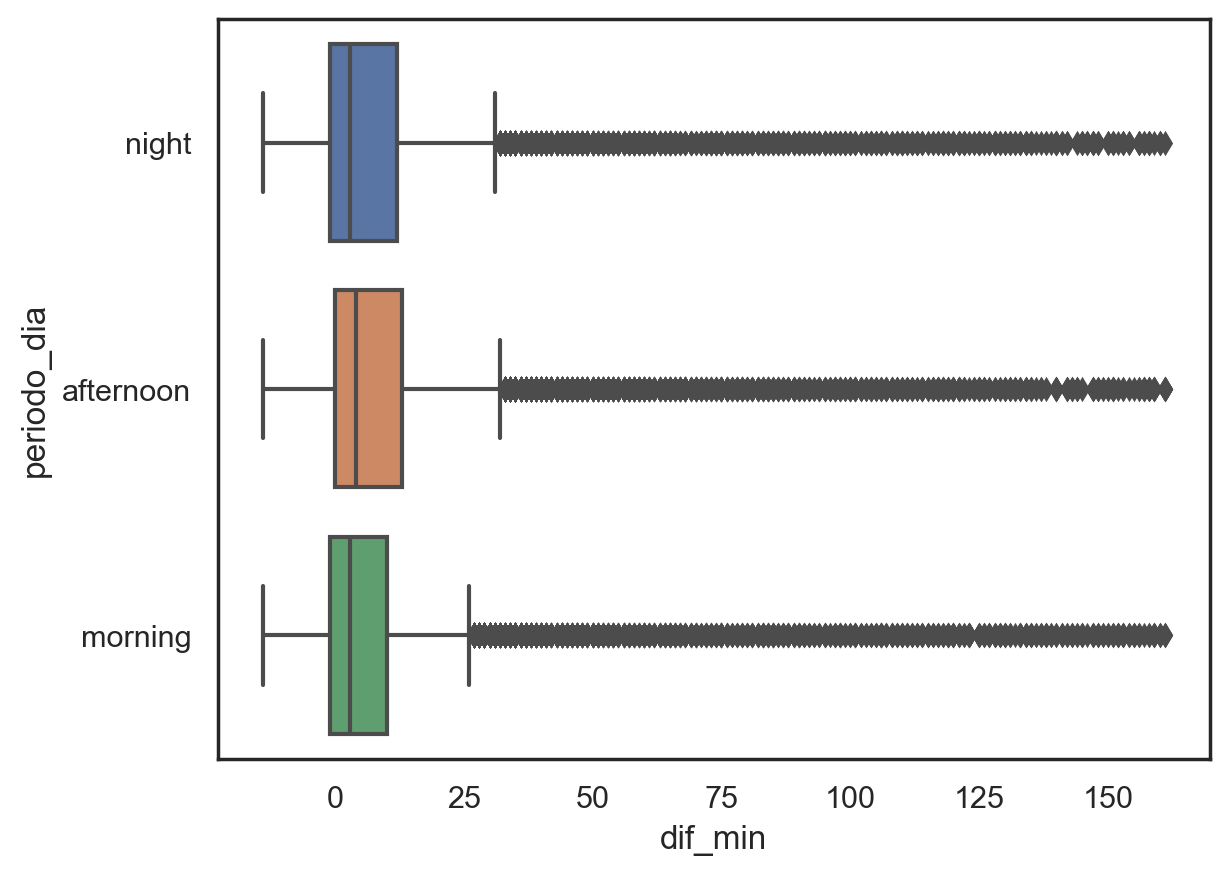

In [65]:
sns.boxplot(data=df, x= "dif_min",y= "periodo_dia", orient="h");

In [66]:
df.groupby(["atraso_15",'periodo_dia'])['dif_min'].describe()

count       mean        std   min   25%   50%   75%  \
atraso_15 periodo_dia                                                          
0         afternoon    20420.0   2.915867   5.654592 -14.0  -1.0   2.0   7.0   
          morning      21294.0   2.430685   5.666680 -14.0  -1.0   2.0   6.0   
          night        13878.0   1.785344   6.331795 -14.0  -2.0   1.0   6.0   
1         afternoon     5086.0  37.224538  26.695595  16.0  20.0  27.0  43.0   
          morning       4058.0  37.608921  29.300128  16.0  19.0  26.0  43.0   
          night         3470.0  41.324496  29.632683  16.0  21.0  30.0  50.0   

                         max  
atraso_15 periodo_dia         
0         afternoon     15.0  
          morning       15.0  
          night         15.0  
1         afternoon    161.0  
          morning      161.0  
          night        161.0

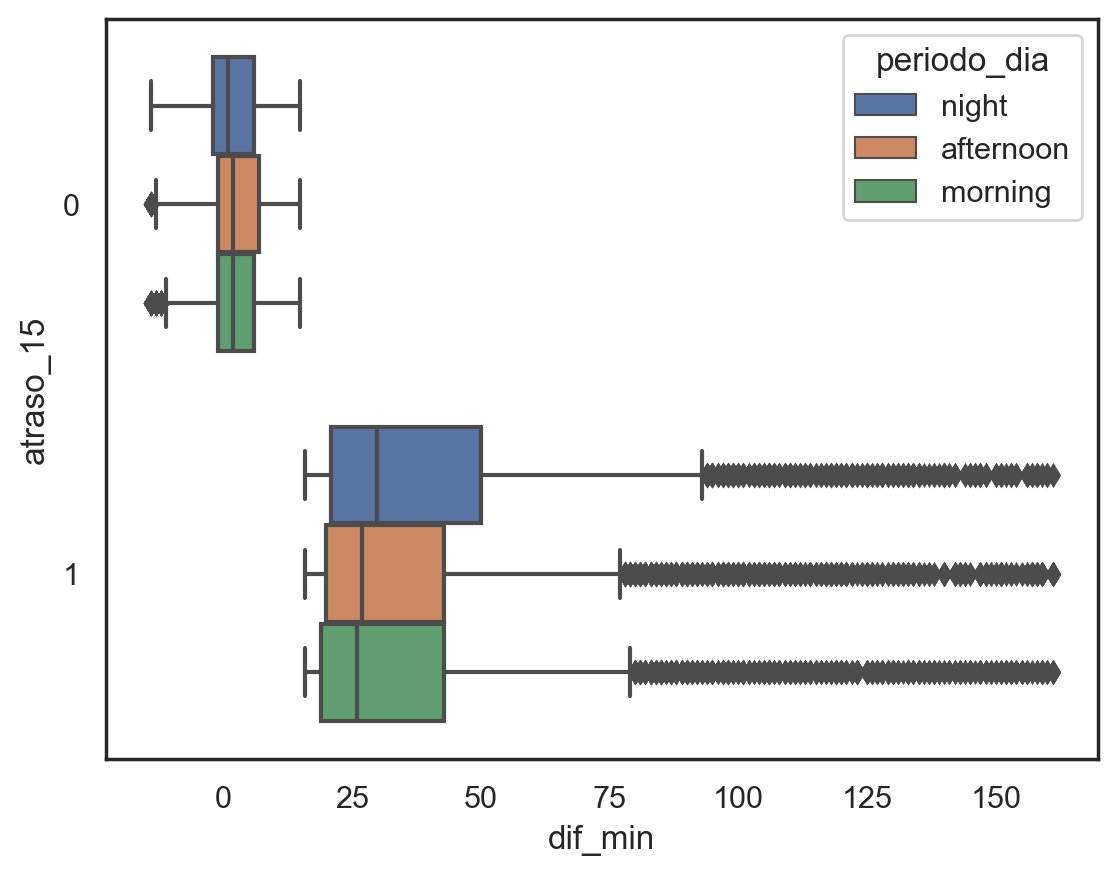

In [67]:
sns.boxplot(data=df, x= "dif_min",y= "atraso_15", hue='periodo_dia',orient="h");

In [68]:
pd.crosstab(df.periodo_dia,df.atraso_15, margins=True,normalize='index')

atraso_15           0         1
periodo_dia                    
afternoon    0.800596  0.199404
morning      0.839934  0.160066
night        0.799977  0.200023
All          0.815060  0.184940

In [69]:
pd.crosstab(df.atraso_15,df.periodo_dia, margins=True,normalize='index')

periodo_dia  afternoon   morning     night
atraso_15                                 
0             0.367319  0.383041  0.249640
1             0.403203  0.321706  0.275091
All           0.373955  0.371698  0.254347

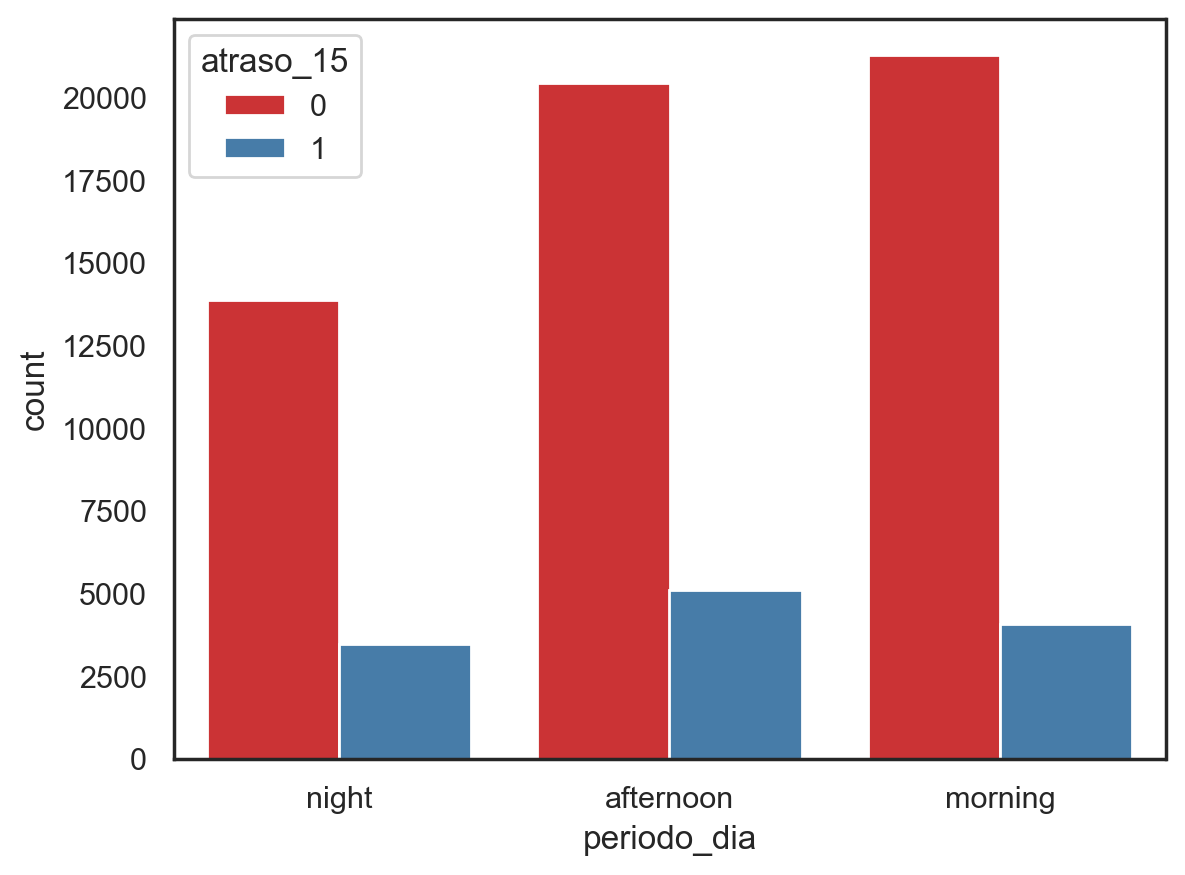

In [70]:
sns.countplot(hue='atraso_15', x='periodo_dia', data=df, palette='Set1');

#### **High season** 

Check the null hypothesis: There is no significance difference in delays between the high season and the rest of the year. Then, understand the relation of the explanatory variables with the target

**Conclusions**


* The chi-2 test indicates that we can reject the hypothesis that there is no relationship between the delay and the flight beeing operated in high season or low season

* On low season we can see that delays are lest recurrent (15% of the total of flighst vs 19% in high season)

* Also, if we look at the mean and high percentiles of delays in minute, we will confirm that high season has also a higer average and percentile of delays than low season

------------------------------------------------------------------------------------------------------------------------------------------------------------------

tab = pd.crosstab(df.temporada_alta,df.atraso_15, margins=True)
tab.index = ["Baja","Alta",'row_total']
tab.columns = ["Sin atraso","Con atraso",'col_total']
observed = tab.iloc[0:3,0:2]   # Get table without totals for later use
chi2 = scipy.stats.chi2_contingency(observed= observed)
if(chi2[1]<0.01):
    print("rechazamos H0")
else: 
    print("no hay evidencia para rechazar H0")

In [71]:
df.groupby(['temporada_alta'])['dif_min'].describe()

count      mean        std   min  25%  50%   75%    max
temporada_alta                                                           
0               22846.0  7.804561  18.422186 -14.0 -1.0  3.0  10.0  161.0
1               45360.0  9.768783  19.714474 -14.0  0.0  4.0  13.0  161.0

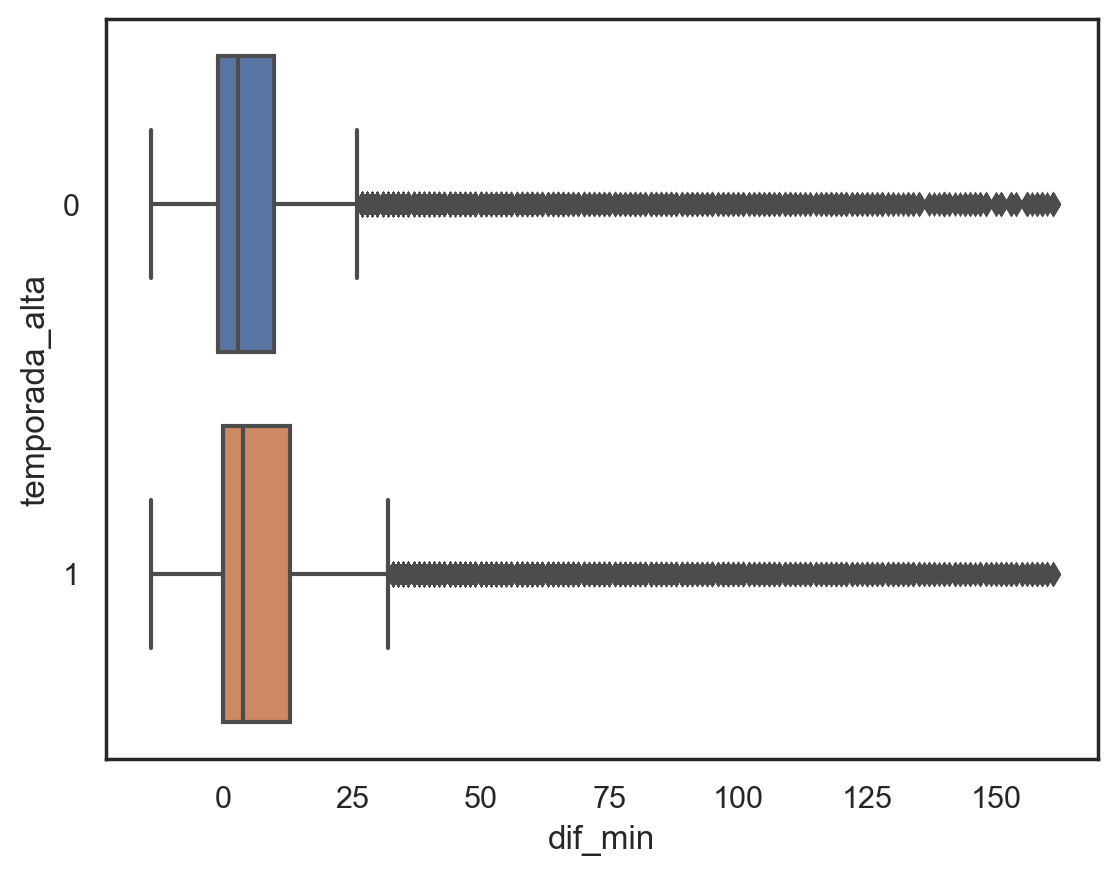

In [72]:
sns.boxplot(data=df, x= "dif_min",y= "temporada_alta", orient="h");

In [73]:
df.groupby(["atraso_15",'temporada_alta'])['dif_min'].describe()

count       mean        std   min   25%   50%  \
atraso_15 temporada_alta                                                    
0         0               19270.0   2.036066   5.725935 -14.0  -2.0   1.0   
          1               36322.0   2.666235   5.905734 -14.0  -1.0   2.0   
1         0                3576.0  38.889262  29.087503  16.0  20.0  27.0   
          1                9038.0  38.312569  28.160493  16.0  20.0  27.0   

                            75%    max  
atraso_15 temporada_alta                
0         0                6.00   15.0  
          1                7.00   15.0  
1         0               46.00  161.0  
          1               44.75  161.0

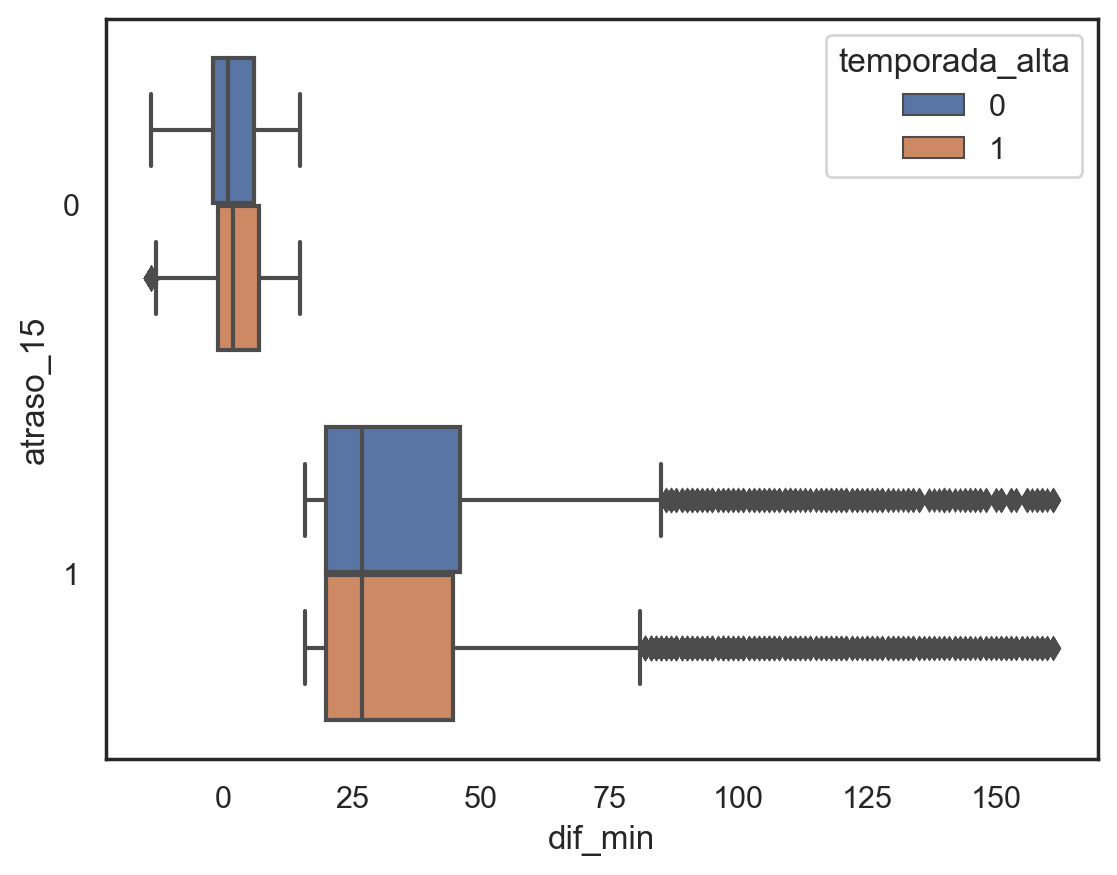

In [74]:
sns.boxplot(data=df, x= "dif_min",y= "atraso_15", hue='temporada_alta',orient="h");

In [75]:
pd.crosstab(df.temporada_alta,df.atraso_15, margins=True,normalize='index')

atraso_15              0         1
temporada_alta                    
0               0.843474  0.156526
1               0.800750  0.199250
All             0.815060  0.184940

In [76]:
pd.crosstab(df.atraso_15,df.temporada_alta, margins=True,normalize='index')

temporada_alta         0         1
atraso_15                         
0               0.346633  0.653367
1               0.283495  0.716505
All             0.334956  0.665044

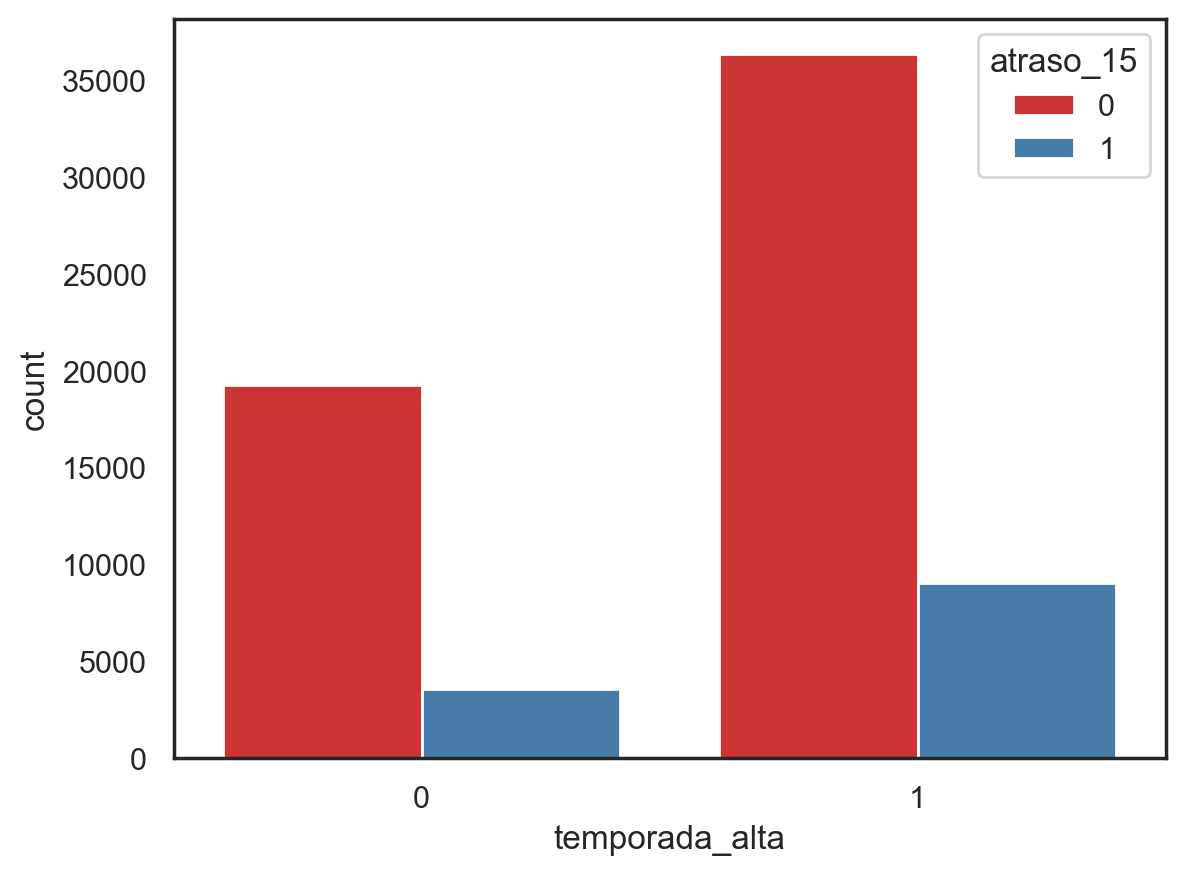

In [77]:
sns.countplot(hue='atraso_15', x='temporada_alta', data=df, palette='Set1');

#### **Flight type** 

Check the null hypothesis: There is no significance difference in delays between the flight type and the rest of the year. Then, understand the relation of the explanatory variables with the target

**Conclusions**

* The chi-2 test indicates that we can reject the hypothesis that there is no relationship between the flight type and the flight beeing operated

* The frequency of delays of more than 15 minutes as a percentage of the total flights of that type of flight is higher with a 22% for international flights vs only 15% of the domestic flights. Also, it's the 55% of the flights delay even when only 45% of the total of flights are international.  

* if we speak about the magnitud of the delays, clearly the international flights has a higher median of delay and also more dispersion since there is more uncertanty. This is important to add into the variables 


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [78]:
tab = pd.crosstab(df.TIPOVUELO,df.atraso_15, margins=True)
tab.index = ["International","National",'row_total']
tab.columns = ["Sin atraso","Con atraso",'col_total']
observed = tab.iloc[0:2,0:2]   # Get table without totals for later use
chi2 = scipy.stats.chi2_contingency(observed= observed)
if(chi2[1]<0.01):
    print("rechazamos H0")
else: 
    print("no hay evidencia para rechazar H0")

rechazamos H0


In [79]:
df.groupby(['TIPOVUELO'])['dif_min'].describe()

count       mean        std   min  25%  50%   75%    max
TIPOVUELO                                                            
I          31240.0  10.638892  21.579424 -14.0 -1.0  5.0  14.0  161.0
N          36966.0   7.819510  17.060643 -14.0 -1.0  3.0  10.0  161.0

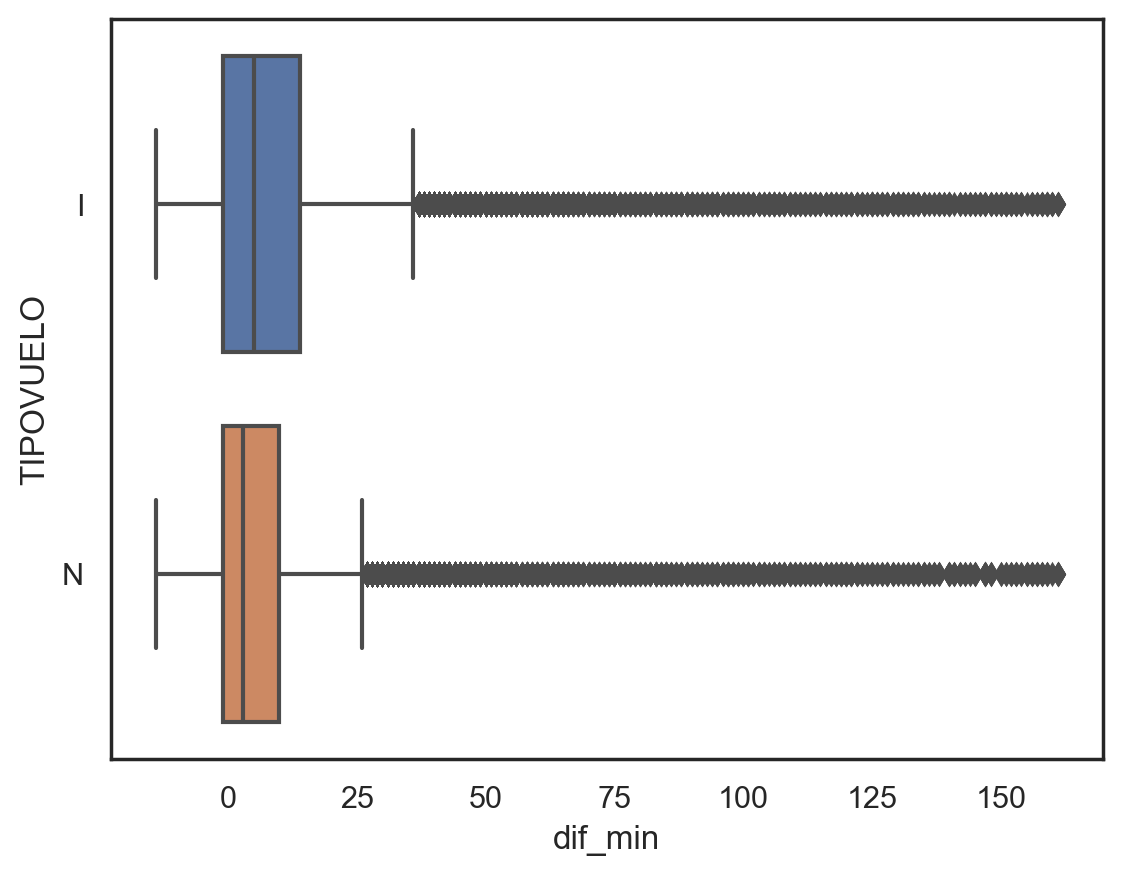

In [80]:
sns.boxplot(data=df, x= "dif_min",y= 'TIPOVUELO',orient="h");

In [81]:
df.groupby(["atraso_15",'TIPOVUELO'])['dif_min'].describe()

count       mean        std   min   25%   50%   75%  \
atraso_15 TIPOVUELO                                                          
0         I          24192.0   2.247065   6.614241 -14.0  -2.0   2.0   7.0   
          N          31400.0   2.602452   5.183085 -14.0  -1.0   2.0   6.0   
1         I           7048.0  39.443530  29.026486  16.0  20.0  28.0  47.0   
          N           5566.0  37.250988  27.601816  16.0  19.0  26.0  43.0   

                       max  
atraso_15 TIPOVUELO         
0         I           15.0  
          N           15.0  
1         I          161.0  
          N          161.0

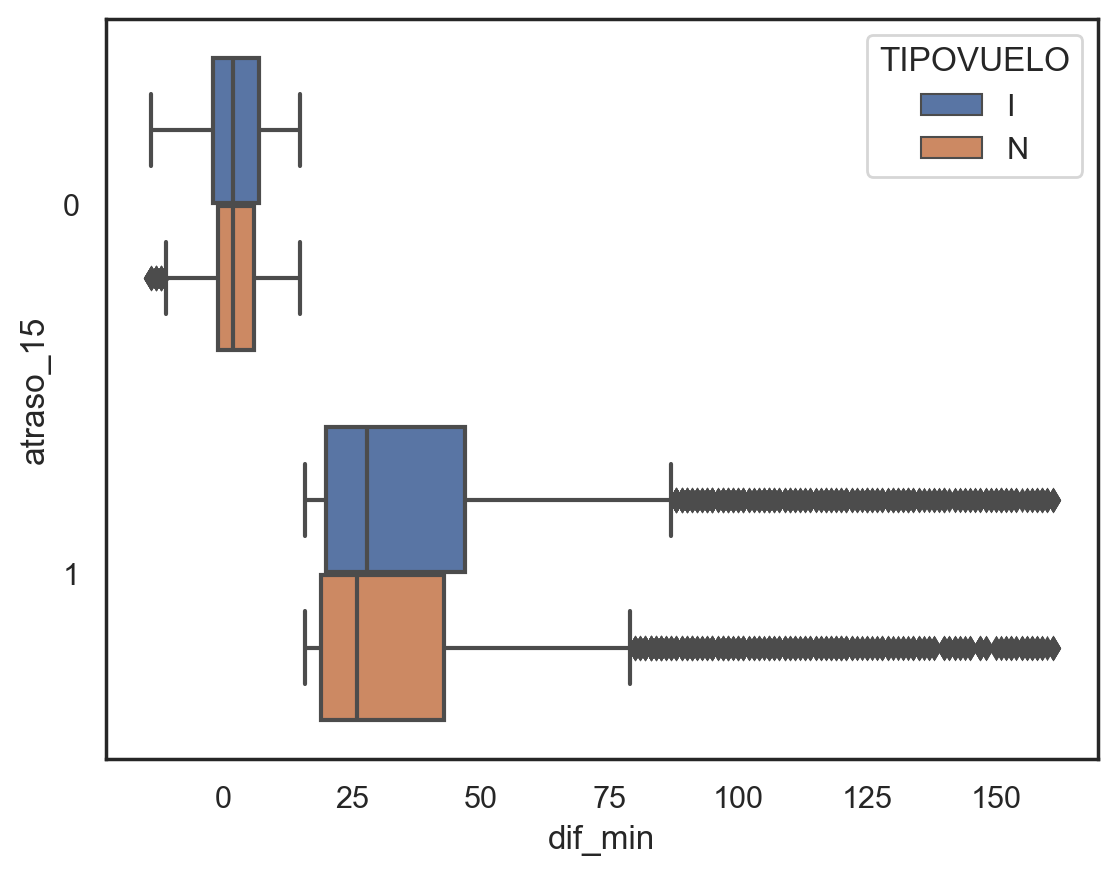

In [82]:
sns.boxplot(data=df, x= "dif_min",y= "atraso_15", hue='TIPOVUELO',orient="h");

In [83]:
pd.crosstab(df.TIPOVUELO,df.atraso_15, margins=True,normalize='index')

atraso_15         0         1
TIPOVUELO                    
I          0.774392  0.225608
N          0.849429  0.150571
All        0.815060  0.184940

In [84]:
pd.crosstab(df.atraso_15,df.TIPOVUELO, margins=True,normalize='index')

TIPOVUELO         I         N
atraso_15                    
0          0.435171  0.564829
1          0.558744  0.441256
All        0.458024  0.541976

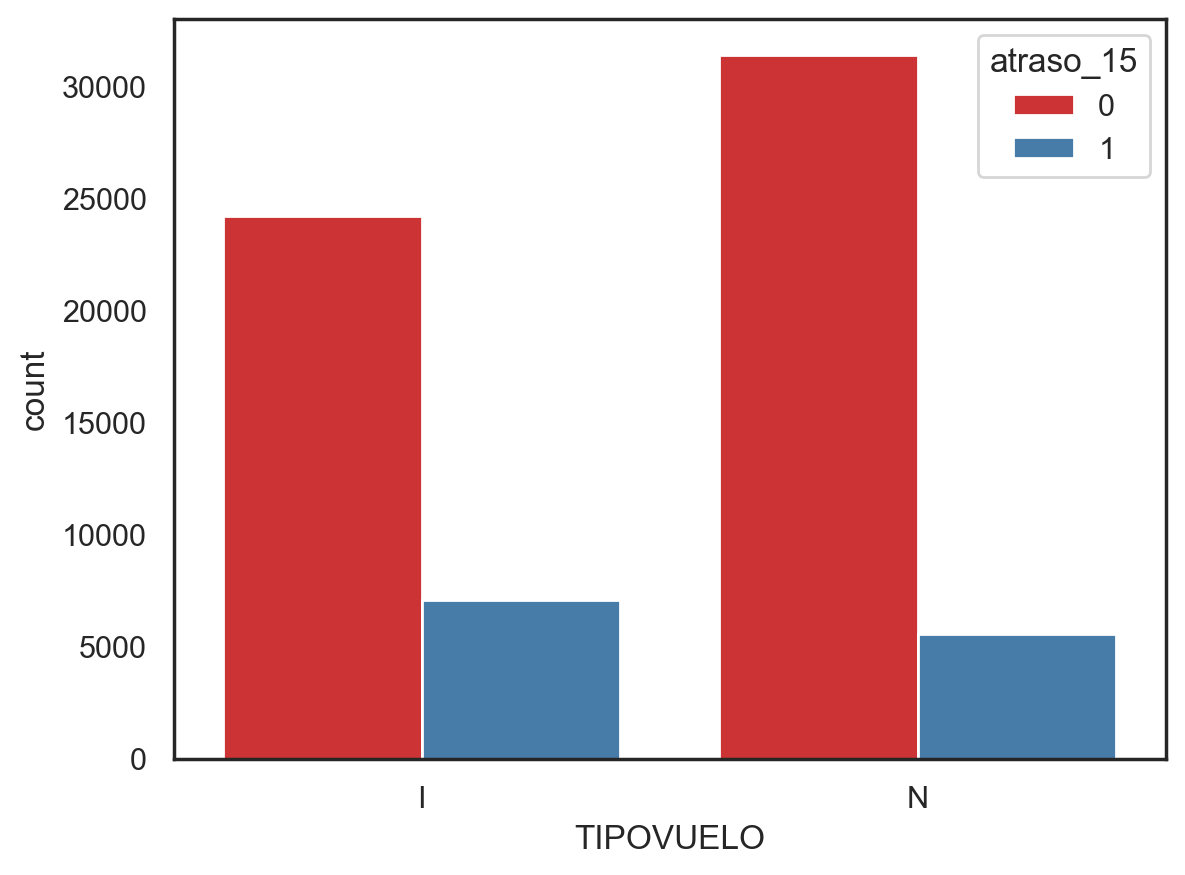

In [85]:
sns.countplot(hue='atraso_15',x='TIPOVUELO', data=df, palette='Set1');

#### **Month of the year** 

Check the null hypothesis: There is no significance difference in delays between the Month of the year and the rest of the year. Then, understand the relation of the explanatory variables with the target

**Conclusions**


* We can't say that there is no significant relation between the month of the year and the delay for more than 15 minutes

* Also, as we can see on the boxplots and the contingency tables, there is months like July, October, November and December that has much more delay in quantity and magnitud than the others months. Specially july, which represents the 8.7% of the flights of the years but in that month occurs the 13% of the delays of the year. This is probably because in Chile is winter holidays and bad weather at the same time.

* We need to be aware that the high season variable could be influence by this critical months hiddign some months like january and february that has almost the same performance than May and June, and better than August and September. Given this, we will see if this two variables has a strong relation and in that case we will leave month of the year

* The total number of flights departure for each month with the mean delay for the flights are correlated, but it will be adress on the number of departure from scl above

------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [86]:
tab = pd.crosstab(df.MES,df.atraso_15, margins=True)
tab.index = ["Enero","Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre",'row_total']
tab.columns = ["Sin atraso","Con atraso",'col_total']
observed = tab.iloc[0:12,0:2]   # Get table without totals for later use
chi2 = scipy.stats.chi2_contingency(observed= observed)
if(chi2[1]<0.01):
    print("rechazamos H0")
else: 
    print("no hay evidencia para rechazar H0")

rechazamos H0


In [87]:
df.groupby(['MES'])['dif_min'].describe()

count       mean        std   min  25%  50%   75%    max
MES                                                           
1    6108.0   7.769646  16.710173 -14.0 -1.0  3.0  11.0  161.0
2    5561.0   7.537853  17.504430 -14.0 -1.0  3.0  10.0  160.0
3    5482.0   5.757205  16.781073 -14.0 -2.0  2.0   8.0  161.0
4    5020.0   5.773506  15.123701 -14.0 -1.0  2.0   8.0  161.0
5    5240.0   7.521756  16.920480 -14.0 -1.0  3.0  10.0  161.0
6    4981.0   8.542461  19.439951 -14.0 -1.0  3.0  11.0  161.0
7    5992.0  15.372163  25.457811 -14.0  1.0  7.0  18.0  161.0
8    5744.0   8.616818  19.041656 -14.0 -1.0  3.0  11.0  161.0
9    5610.0   8.497326  19.048354 -14.0 -1.0  3.0  11.0  159.0
10   6032.0  11.295922  21.559598 -14.0  0.0  5.0  14.0  160.0
11   6080.0   9.342763  18.409677 -14.0  0.0  4.0  13.0  161.0
12   6356.0  11.849591  20.314042 -14.0  0.0  6.0  16.0  159.0

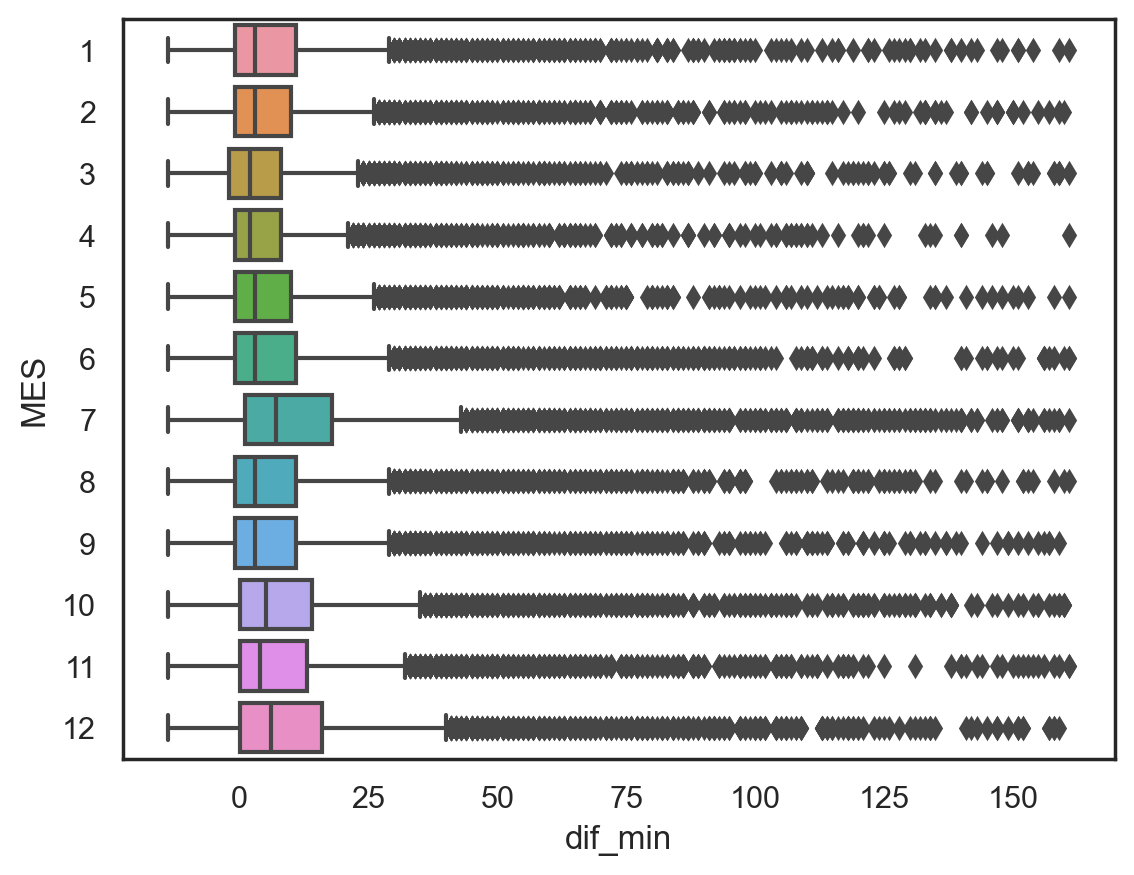

In [88]:
sns.boxplot(data=df, x= "dif_min",y= 'MES',orient="h");

In [89]:
pd.crosstab(df.MES,df.atraso_15, margins=True,normalize='index')

atraso_15         0         1
MES                          
1          0.839882  0.160118
2          0.848409  0.151591
3          0.884896  0.115104
4          0.883466  0.116534
5          0.842176  0.157824
6          0.828950  0.171050
7          0.706609  0.293391
8          0.826602  0.173398
9          0.827629  0.172371
10         0.774038  0.225962
11         0.802796  0.197204
12         0.745909  0.254091
All        0.815060  0.184940

In [90]:
pd.crosstab(df.atraso_15,df.MES, margins=True,normalize='index')

MES               1         2         3         4         5         6  \
atraso_15                                                               
0          0.092279  0.084868  0.087261  0.079778  0.079382  0.074273   
1          0.077533  0.066831  0.050024  0.046377  0.065562  0.067544   
All        0.089552  0.081532  0.080374  0.073601  0.076826  0.073029   

MES               7         8         9        10        11        12  
atraso_15                                                              
0          0.076162  0.085408  0.083519  0.083987  0.087800  0.085282  
1          0.139369  0.078960  0.076661  0.108055  0.095053  0.128032  
All        0.087852  0.084215  0.082251  0.088438  0.089142  0.093188

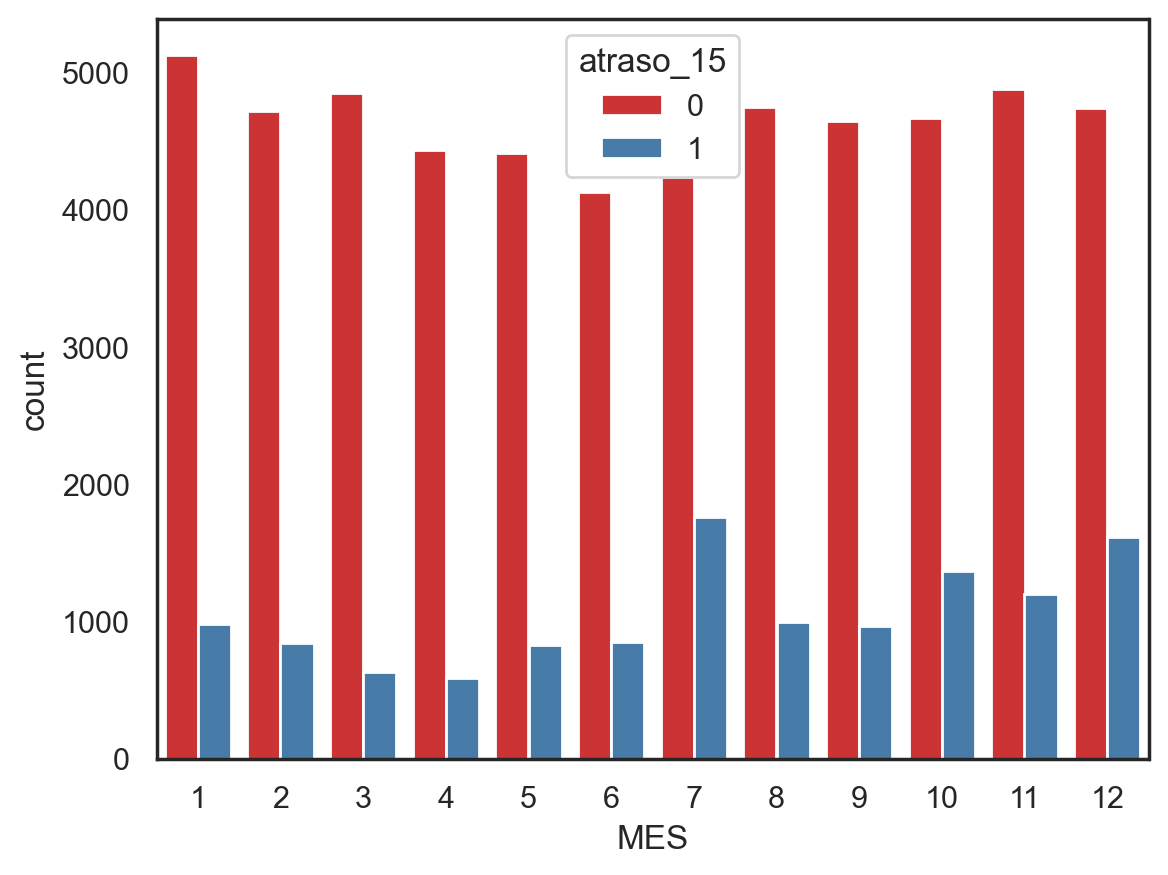

In [91]:
sns.countplot(hue='atraso_15',x='MES', data=df, palette='Set1');

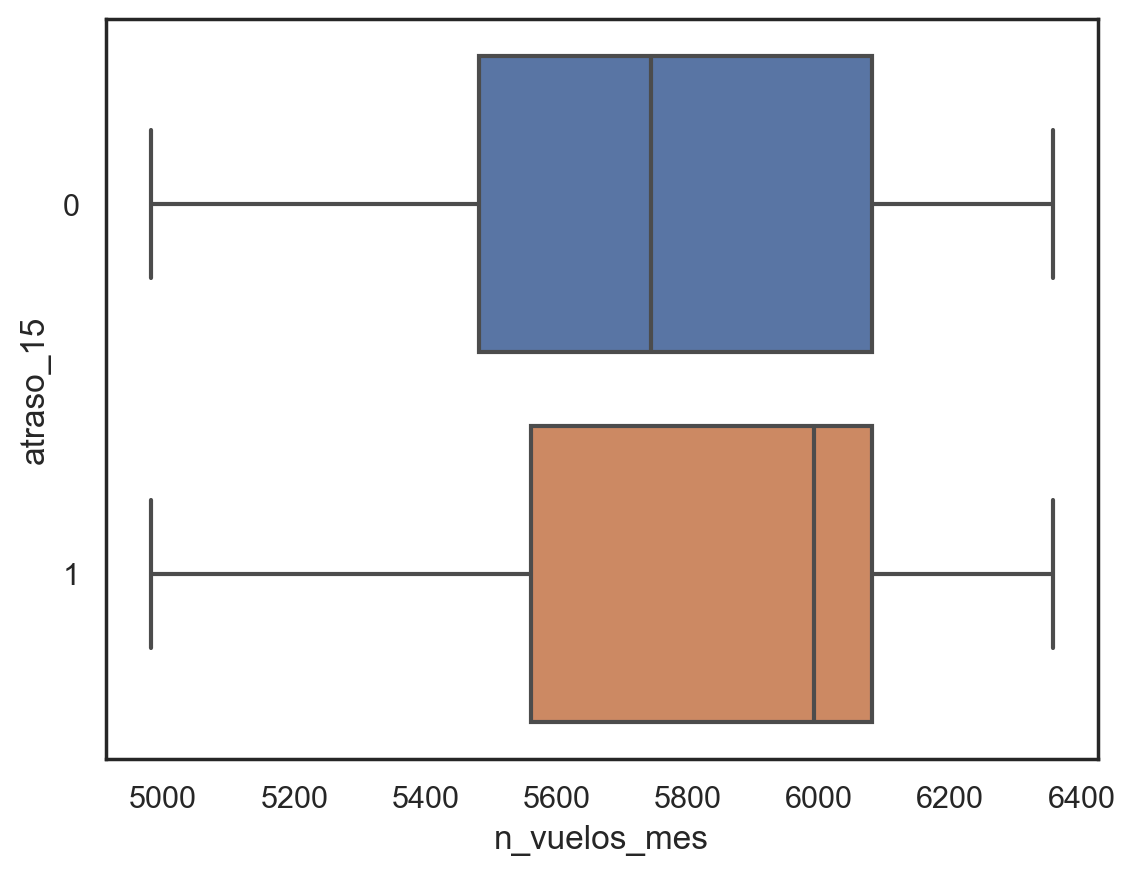

In [92]:
aux = df.groupby(['MES'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'n_vuelos_mes'}, inplace=True)
df = pd.merge(df, aux, on = ['MES'], how='left')
sns.boxplot(data=df, x= "n_vuelos_mes",y= "atraso_15", orient="h");

                  mean       50%       75%  n_vuelos_mes
mean          1.000000  0.976594  0.983246      0.616735
50%           0.976594  1.000000  0.986379      0.679645
75%           0.983246  0.986379  1.000000      0.708048
n_vuelos_mes  0.616735  0.679645  0.708048      1.000000


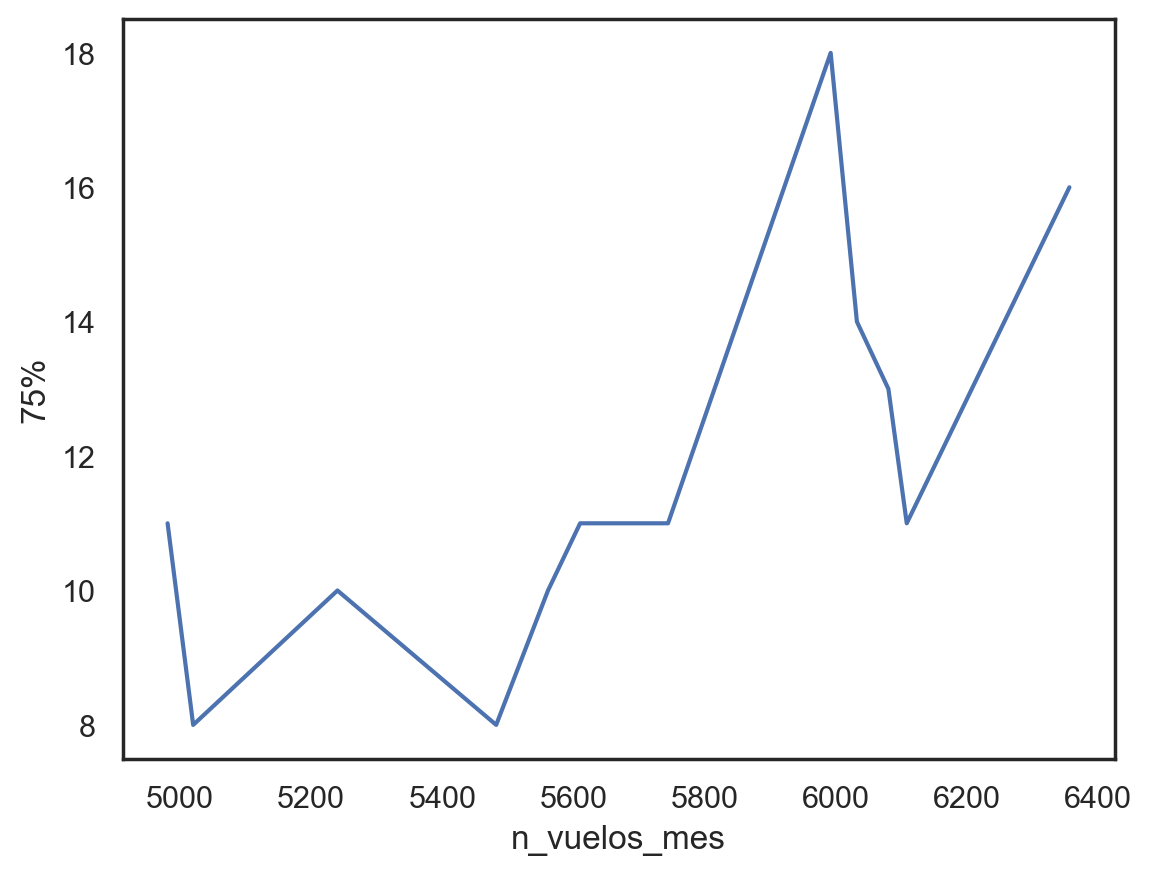

In [93]:
aux = df.groupby(['n_vuelos_mes'])['dif_min'].describe().reset_index()
print(aux[['mean','50%','75%','n_vuelos_mes']].corr())
sns.lineplot(data=aux, x='n_vuelos_mes', y='75%');

                  mean  n_vuelos_mes
mean          1.000000      0.681131
n_vuelos_mes  0.681131      1.000000


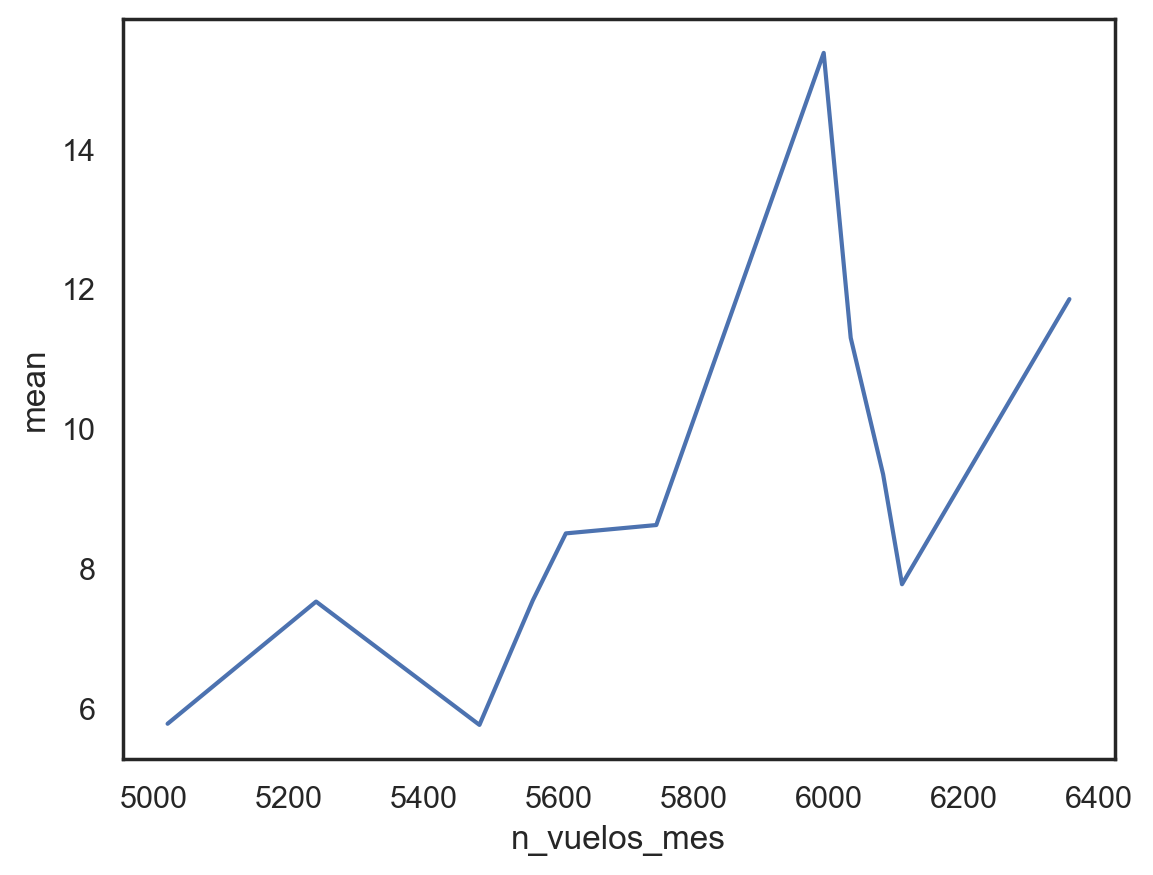

In [94]:
aux = df.groupby(['n_vuelos_mes'])['dif_min'].describe().reset_index()[1:]
print(aux[['mean','n_vuelos_mes']].corr())
sns.lineplot(data=aux, x='n_vuelos_mes', y='mean');

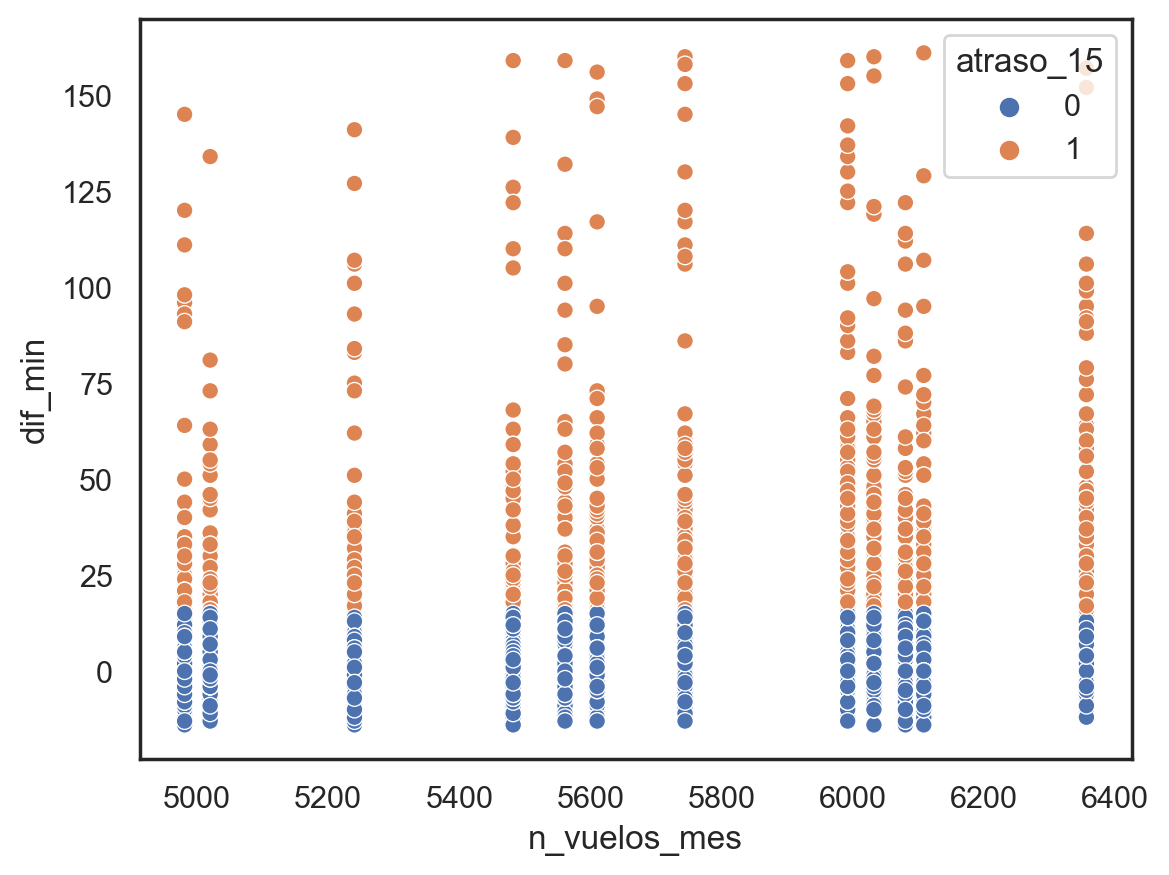

In [95]:
sns.scatterplot(data=df.sample(5000), x='n_vuelos_mes', y='dif_min', hue='atraso_15');

#### **Day of the week that the flight is operated** 

Check the null hypothesis: There is no significance difference in delays between the day of the week and the rest of the year. Then, understand the relation of the explanatory variables with the target

**Conclusions**


* The hipothesis test gives a result in which we can't say that there is no significative relation between the day of the week that the flight is operated and the delay in the flight for more than 15 minutes

* As we can see on the tables with the median and percentiles, Friday is by far the worst day to travel if you don't want to be exposed to delays. Then is followed by Thursday and Monday.

* The patern is repeated in the contingency tables and barplots for the same days, so we are goign to leave this variable as one of the canidates to be selected

* The total number of flights departure for each day of the week is correlated with the mean delay for the flights are correlated, but it will be adress on the number of flights departures from scl for each day above since it has a direct and more precise influence 


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [96]:
tab = pd.crosstab(df.DIANOM,df.atraso_15, margins=True)
tab.index = ["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo",'row_total']
tab.columns = ["Sin atraso","Con atraso",'col_total']
observed = tab.iloc[0:7,0:2]   # Get table without totals for later use
chi2 = scipy.stats.chi2_contingency(observed= observed)
if(chi2[1]<0.01):
    print("rechazamos H0")
else: 
    print("no hay evidencia para rechazar H0")

rechazamos H0


In [97]:
df.groupby(['DIANOM'])['dif_min'].describe()

count       mean        std   min  25%  50%   75%    max
DIANOM                                                               
Domingo     9796.0   7.930788  17.825904 -14.0 -1.0  3.0  11.0  161.0
Jueves     10251.0   9.521120  18.789608 -14.0  0.0  4.0  13.0  161.0
Lunes      10131.0   9.980653  20.645717 -14.0 -1.0  4.0  13.0  161.0
Martes      9662.0   8.324777  18.846261 -14.0 -1.0  3.0  11.0  161.0
Miercoles   9722.0   8.540835  18.570424 -14.0 -1.0  3.0  11.0  160.0
Sabado      8352.0   8.315014  19.830023 -14.0 -1.0  3.0  10.0  160.0
Viernes    10292.0  10.891469  20.331720 -14.0  0.0  5.0  14.0  161.0

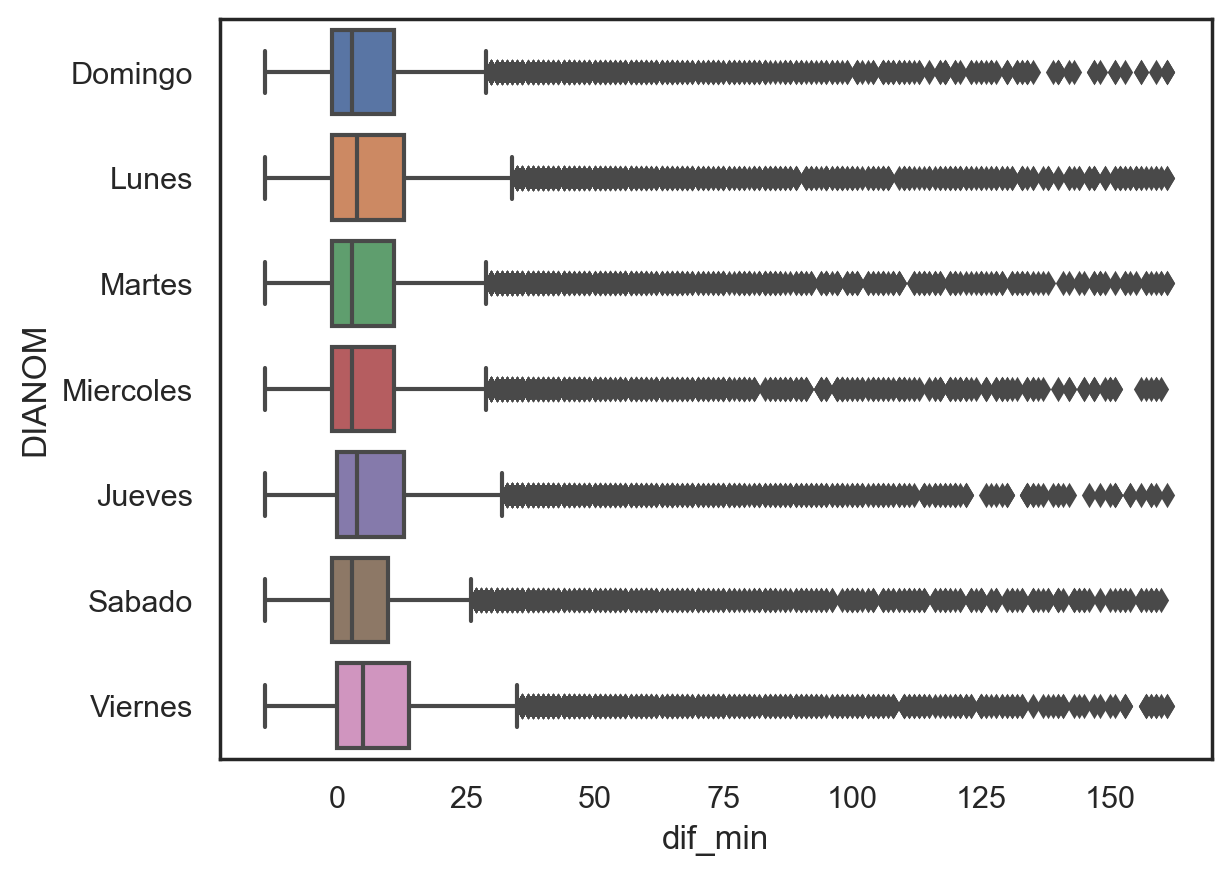

In [98]:
sns.boxplot(data=df, x= "dif_min",y= 'DIANOM',orient="h");

In [99]:
pd.crosstab(df.atraso_15,df.DIANOM, margins=True,normalize='index')

DIANOM      Domingo    Jueves     Lunes    Martes  Miercoles    Sabado  \
atraso_15                                                                
0          0.147827  0.147611  0.145399  0.144409   0.145003  0.125720   
1          0.125099  0.162121  0.162359  0.129539   0.131679  0.108055   
All        0.143624  0.150295  0.148535  0.141659   0.142539  0.122453   

DIANOM      Viernes  
atraso_15            
0          0.144032  
1          0.181148  
All        0.150896

In [100]:
pd.crosstab(df.DIANOM,df.atraso_15, margins=True,normalize='index')

atraso_15         0         1
DIANOM                       
Domingo    0.838914  0.161086
Jueves     0.800507  0.199493
Lunes      0.797848  0.202152
Martes     0.830884  0.169116
Miercoles  0.829150  0.170850
Sabado     0.836806  0.163194
Viernes    0.777983  0.222017
All        0.815060  0.184940

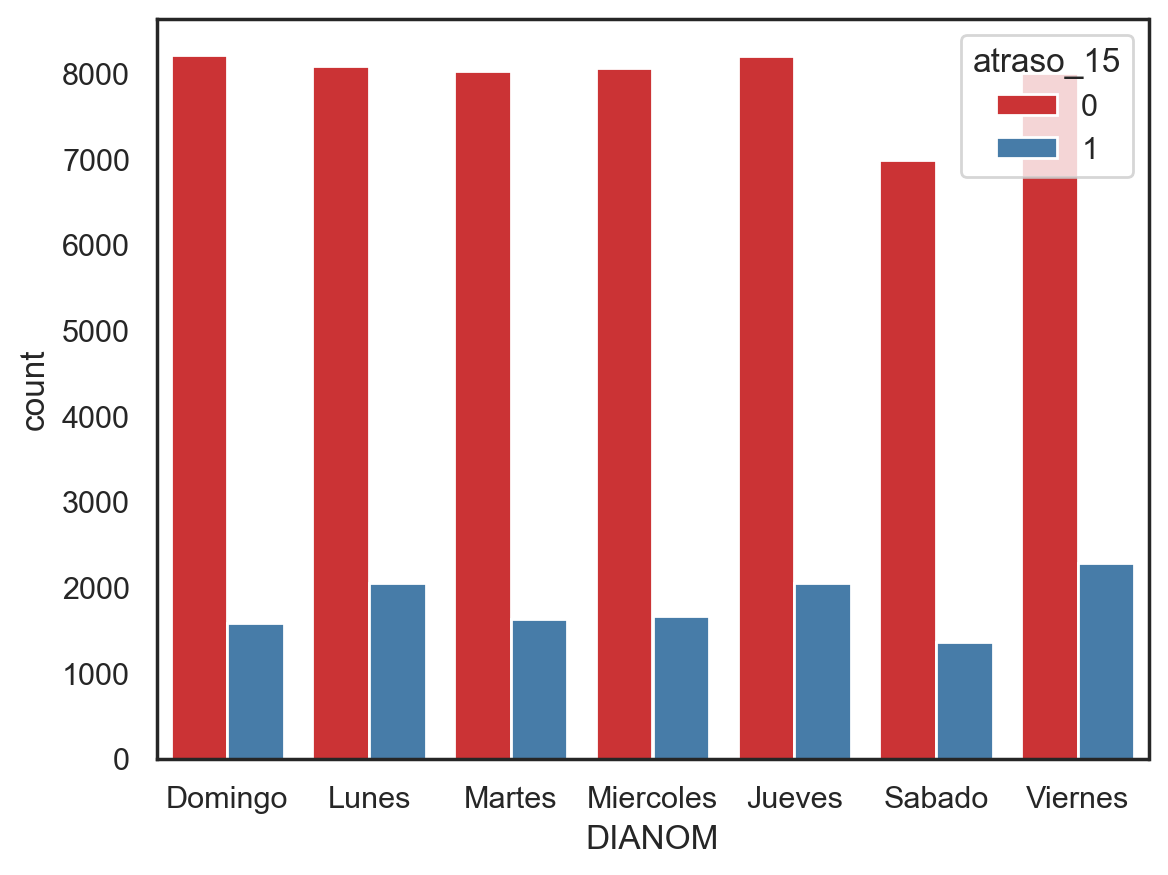

In [101]:
sns.countplot(hue='atraso_15',x='DIANOM', data=df, palette='Set1');

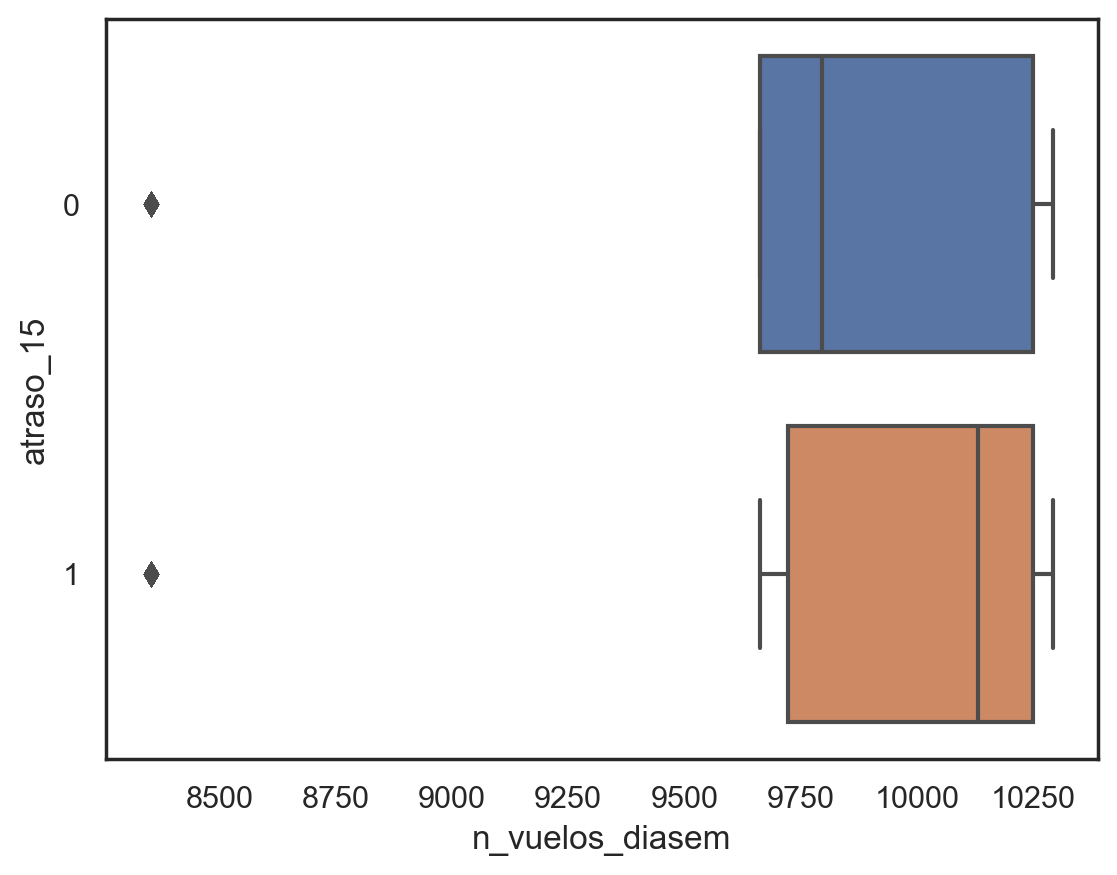

In [102]:
aux = df.groupby(['DIANOM'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'n_vuelos_diasem'}, inplace=True)
df = pd.merge(df, aux, on = ['DIANOM'], how='left')
sns.boxplot(data=df, x= "n_vuelos_diasem",y= "atraso_15", orient="h");

                     mean       50%       75%  n_vuelos_diasem
mean             1.000000  0.973605  0.970704         0.890675
50%              0.973605  1.000000  0.982872         0.926663
75%              0.970704  0.982872  1.000000         0.969144
n_vuelos_diasem  0.890675  0.926663  0.969144         1.000000


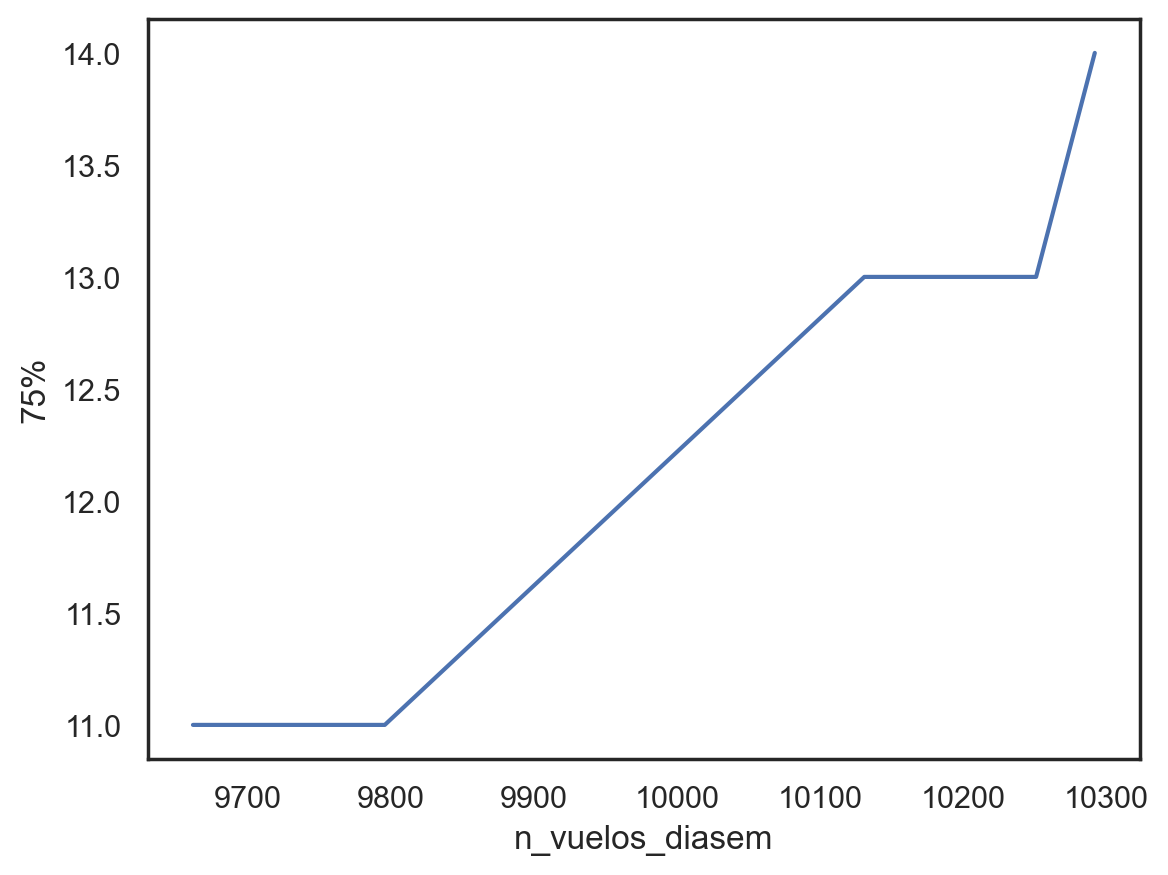

In [103]:
aux = df.groupby(['n_vuelos_diasem'])['dif_min'].describe().reset_index()[1:]
print(aux[['mean','50%','75%','n_vuelos_diasem']].corr())
sns.lineplot(data=aux, x='n_vuelos_diasem', y='75%');

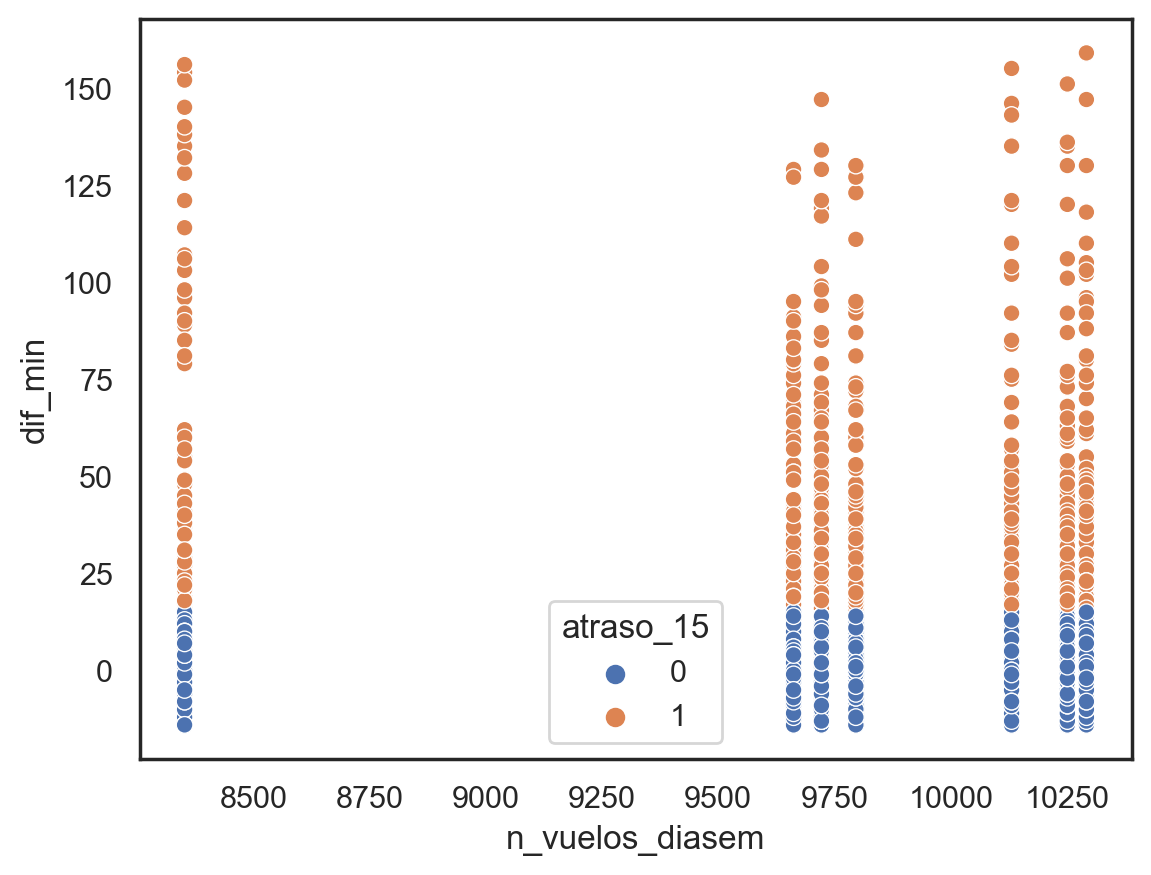

In [104]:
sns.scatterplot(data=df.sample(5000), x='n_vuelos_diasem', y='dif_min', hue='atraso_15');

                     mean  n_vuelos_diasem
mean             1.000000         0.890675
n_vuelos_diasem  0.890675         1.000000


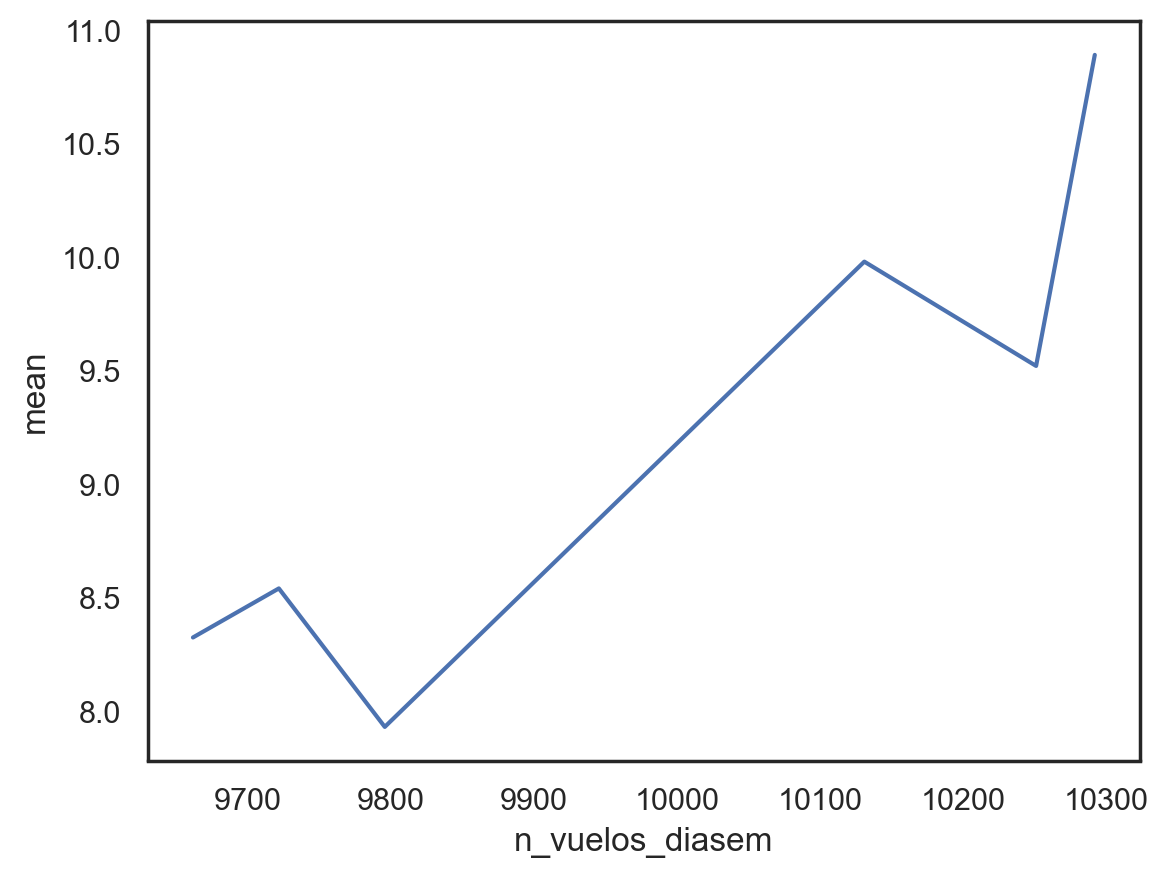

In [105]:
aux = df.groupby(['n_vuelos_diasem'])['dif_min'].describe().reset_index()[1:]
print(aux[['mean','n_vuelos_diasem']].corr())
sns.lineplot(data=aux, x='n_vuelos_diasem', y='mean');

#### **Day of the month for the operation** 

Check the null hypothesis: There is no significance difference in delays between the day of the month and the rest of the year. Then, understand the relation of the explanatory variables with the target

**Conclusions**


* We can't say that there is no significance relation between the day of the month and the delay for more than 15 minutes

* However, there is a lot of this that could be explained for another variables. The days in the middle of the month get a lot of their delay from July because ussualy that's the date of winter holidays for Chile. We have show this with 3 examples for the day 11,12 and 15.

* This variable can't be used alone, because is going to bring some noise, specilly if we use frequentist models to estimate the probability of delay. Trees models should be able to detect this pattern and discrmination only the important combinations, but the high dimensionality could be a problem for that.

* Given the exposed above, we are going to try 3 approuchs:
    
    * leave the variables as they are and use one hot encoder and search algorithms that can handle high dimentionality
    * leave the variables separated but try a reductional dimentional technique (MCA)
    * Create a new variable from the combination of the day and month of the year and then apply CatBoostEncoder

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [106]:
tab = pd.crosstab(df.DIA,df.atraso_15, margins=True)
tab.columns = ["Sin atraso","Con atraso",'col_total']
observed = tab.iloc[0:31,0:2]   # Get table without totals for later use
chi2 = scipy.stats.chi2_contingency(observed= observed)
if(chi2[1]<0.01):
    print("rechazamos H0")
else: 
    print("no hay evidencia para rechazar H0")

rechazamos H0


In [107]:
aux = pd.crosstab(df.DIA,df.atraso_15, margins=True,normalize='index').reset_index()
aux[aux[1]>=0.184940]

atraso_15 DIA         0         1
3           4  0.810384  0.189616
5           6  0.802637  0.197363
9          10  0.774420  0.225580
10         11  0.767546  0.232454
11         12  0.809107  0.190893
13         14  0.797839  0.202161
14         15  0.757034  0.242966
15         16  0.793651  0.206349
16         17  0.804758  0.195242
17         18  0.809259  0.190741
19         20  0.803930  0.196070
20         21  0.808558  0.191442
21         22  0.808099  0.191901
25         26  0.800176  0.199824

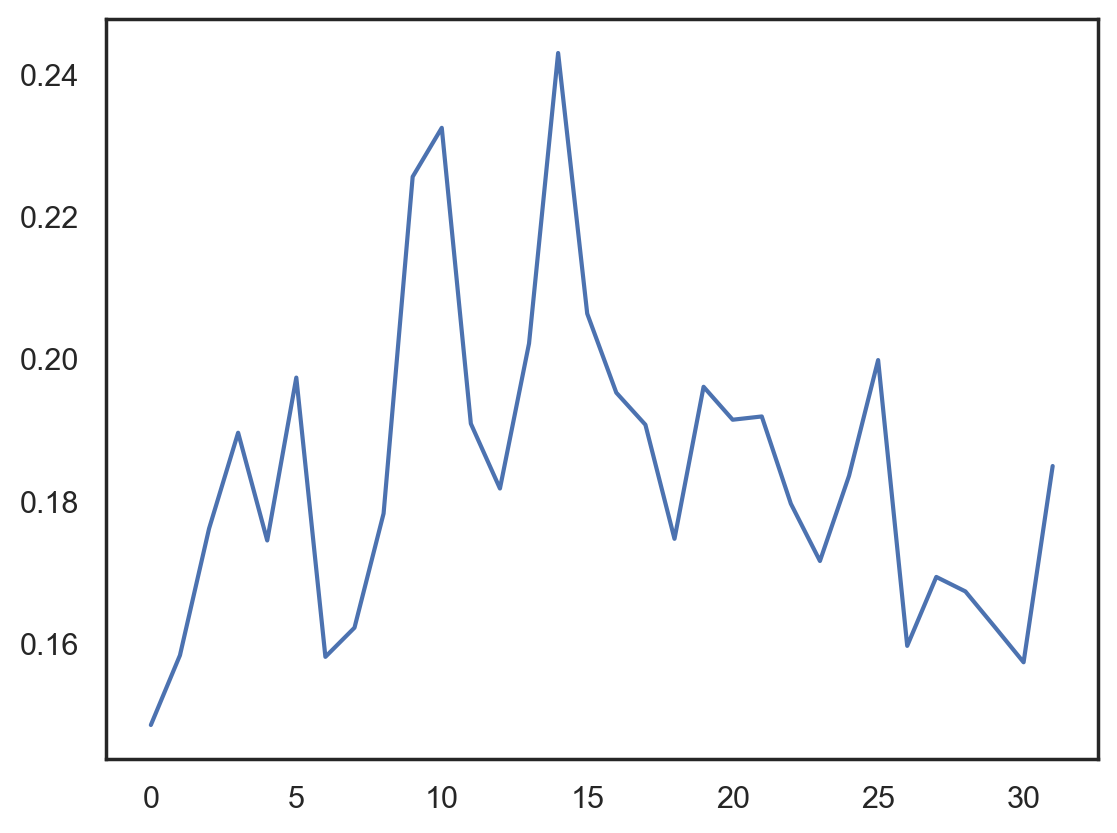

In [108]:
aux[1].plot();

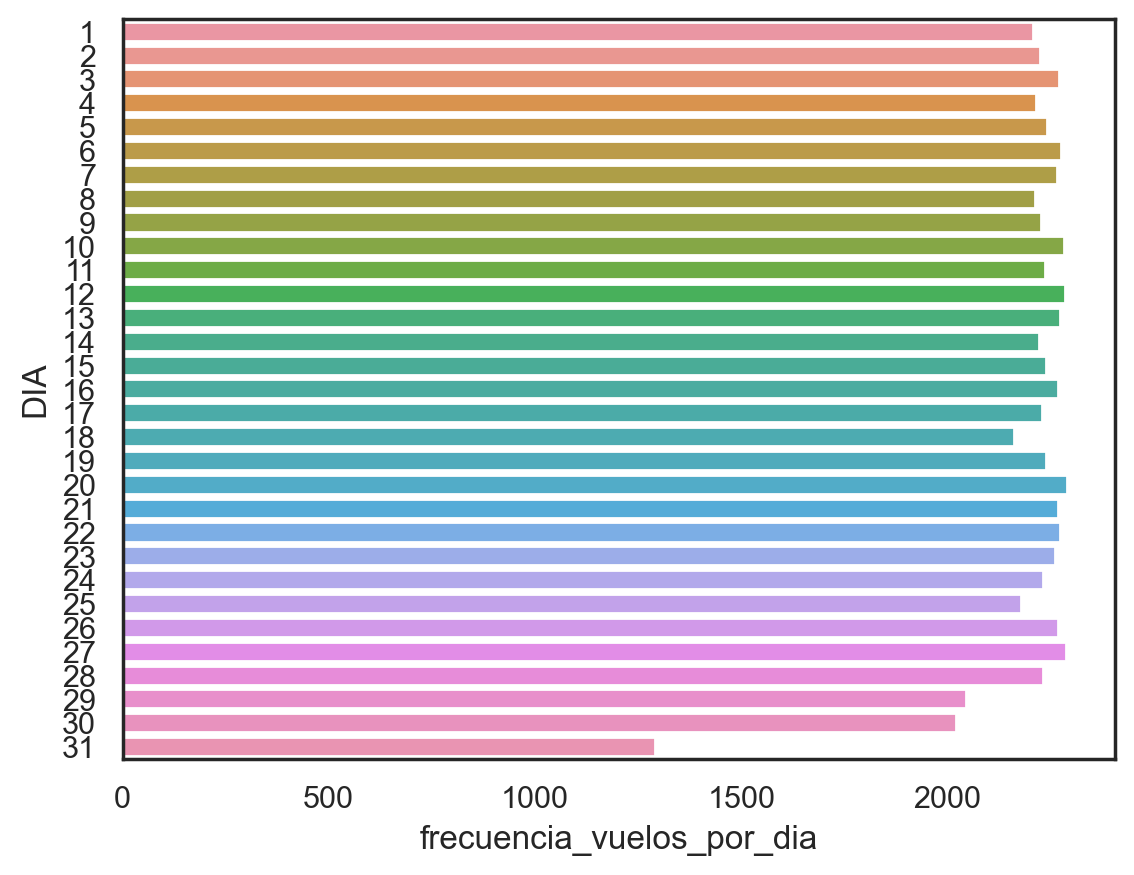

In [109]:
aux = df.groupby(['DIA'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'frecuencia_vuelos_por_dia'}, inplace=True)
sns.barplot(data=aux, y= "DIA",x= "frecuencia_vuelos_por_dia", orient="h");

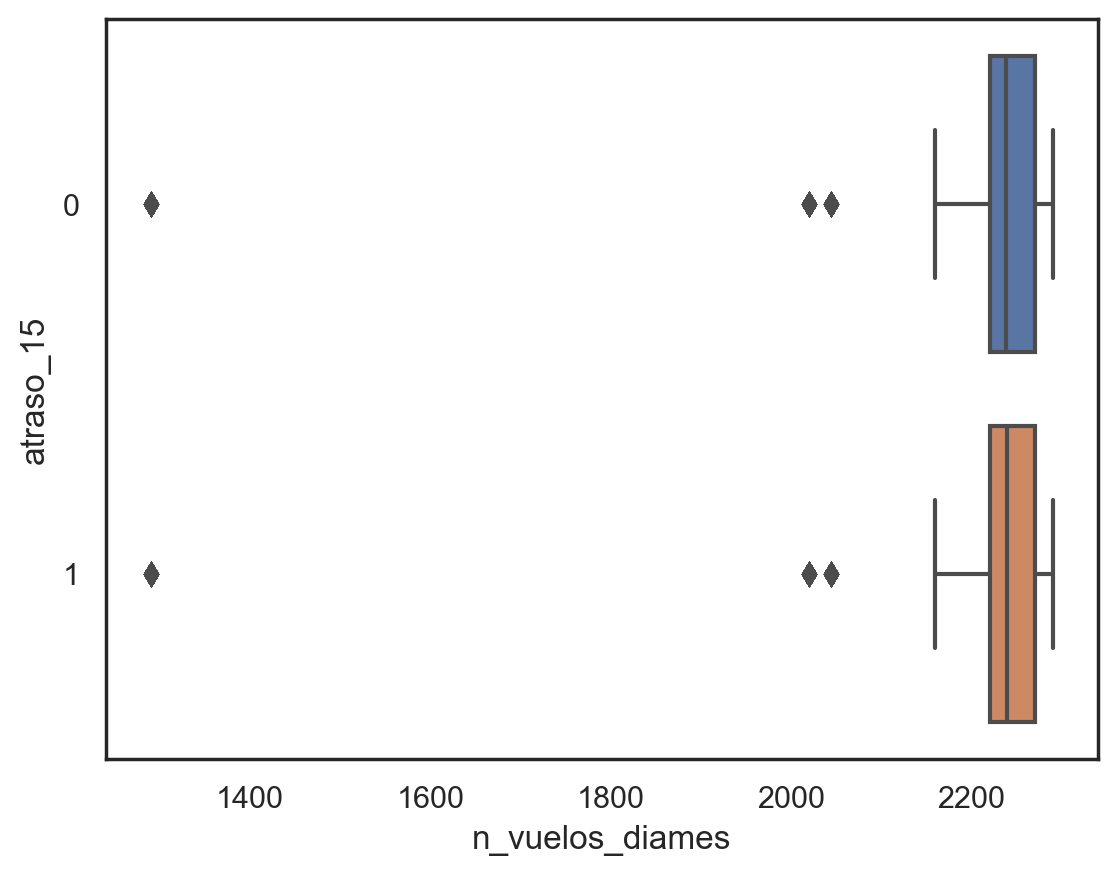

In [110]:
aux = df.groupby(['DIA'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'n_vuelos_diames'}, inplace=True)
df = pd.merge(df, aux, on = ['DIA'], how='left')
sns.boxplot(data=df, x= "n_vuelos_diames",y= "atraso_15", orient="h");

                     mean       50%       75%  n_vuelos_diames
mean             1.000000  0.850171  0.962365         0.277691
50%              0.850171  1.000000  0.874237         0.188037
75%              0.962365  0.874237  1.000000         0.283723
n_vuelos_diames  0.277691  0.188037  0.283723         1.000000


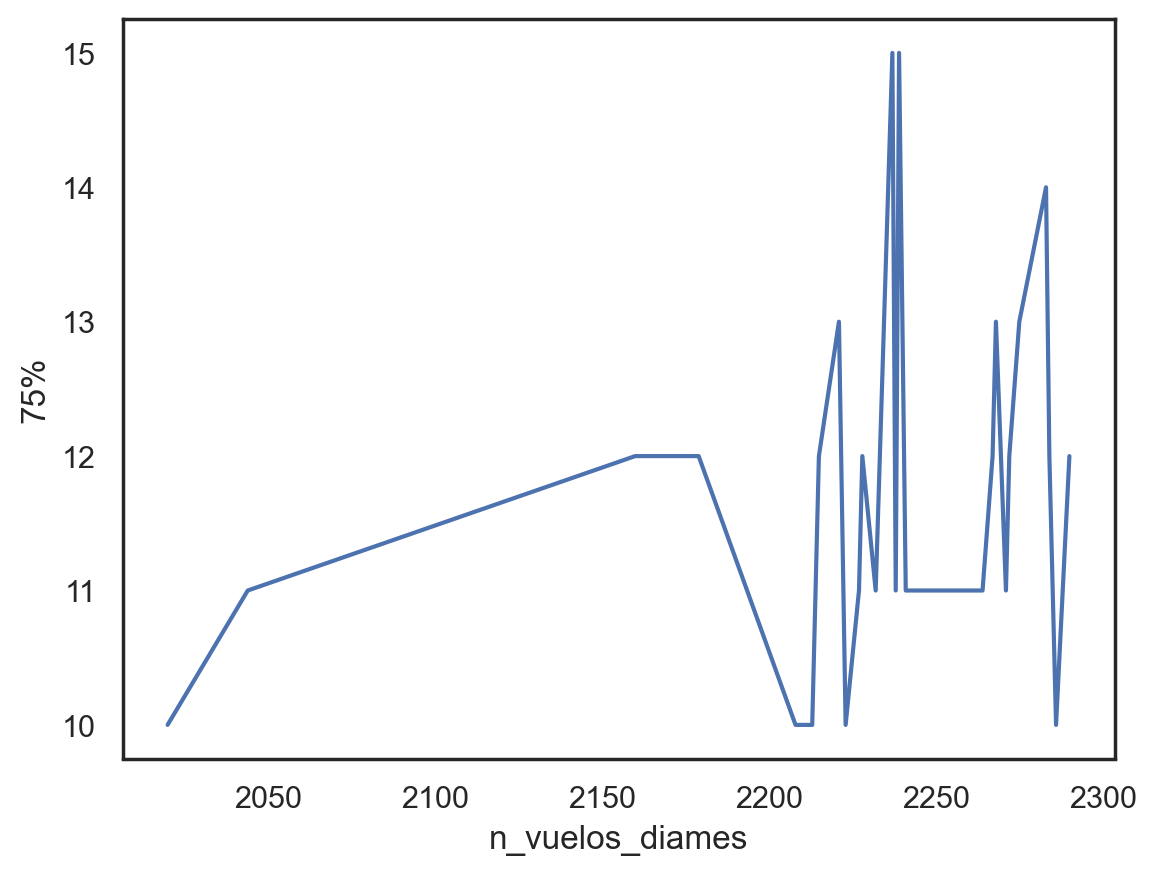

In [111]:
aux = df.groupby(['n_vuelos_diames'])['dif_min'].describe().reset_index()[1:]
print(aux[['mean','50%','75%','n_vuelos_diames']].corr())
sns.lineplot(data=aux, x='n_vuelos_diames', y='75%');

                     mean  n_vuelos_diames
mean             1.000000         0.296822
n_vuelos_diames  0.296822         1.000000


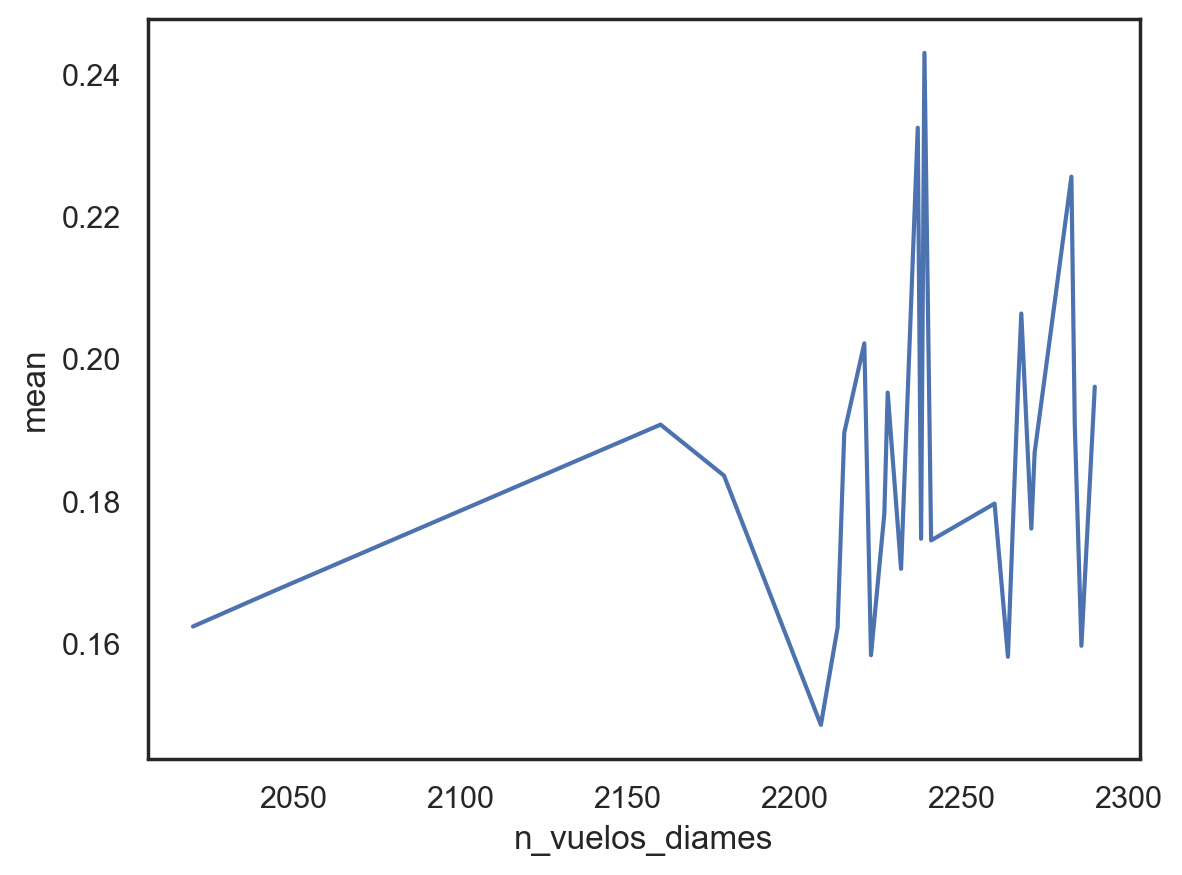

In [112]:
aux = df.groupby(['n_vuelos_diames'])['atraso_15'].describe().reset_index()[1:]
print(aux[['mean','n_vuelos_diames']].corr())
sns.lineplot(data=aux, x='n_vuelos_diames', y='mean');

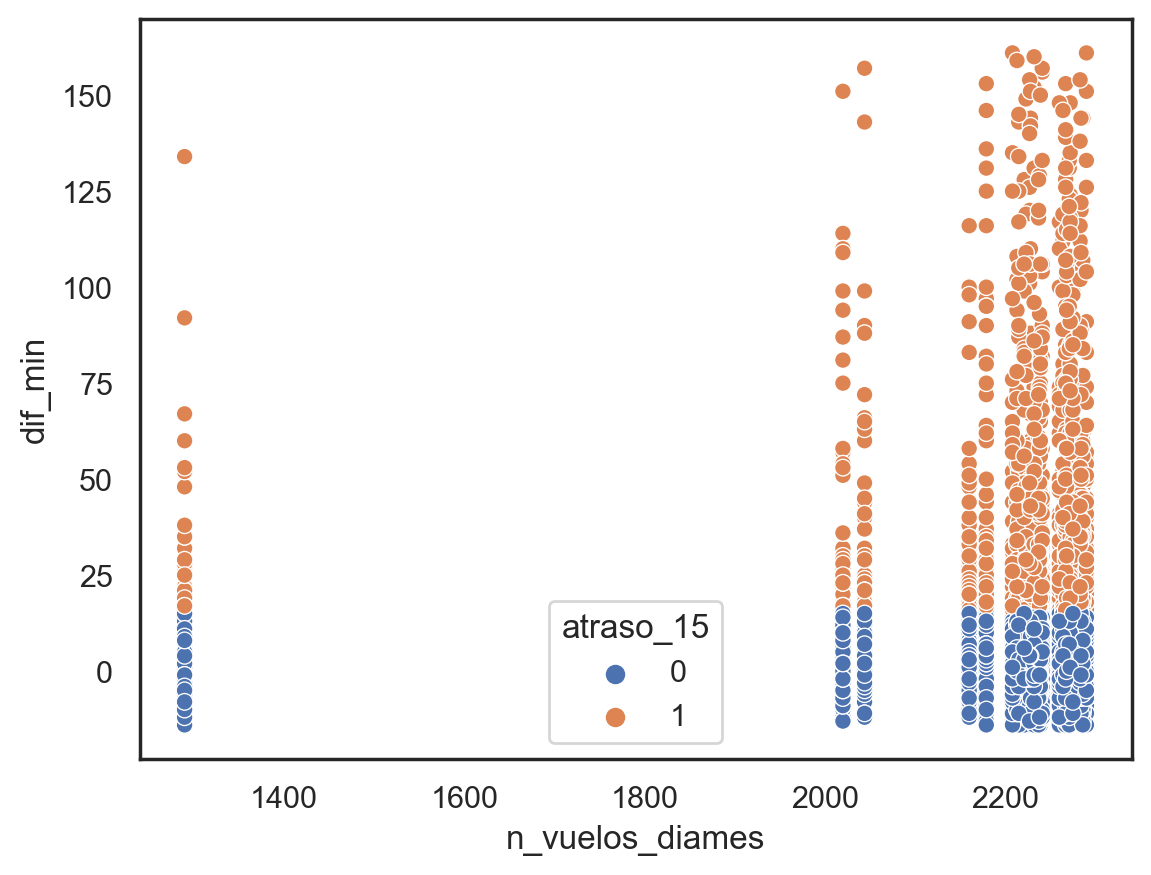

In [113]:
sns.scatterplot(data=df.sample(10000), x='n_vuelos_diames', y='dif_min',hue='atraso_15');

In [114]:
df[((df.atraso_15==1) &(df.DIA==15))].groupby('fecha_operacion')['atraso_15'].count()

fecha_operacion
2017-1-15     38
2017-10-15    40
2017-11-15    55
2017-12-15    70
2017-2-15     31
2017-3-15     25
2017-4-15     11
2017-5-15     48
2017-6-15     52
2017-7-15     99
2017-8-15     11
2017-9-15     64
Name: atraso_15, dtype: int64

In [115]:
df[((df.atraso_15==1) &(df.DIA==10))].groupby('fecha_operacion')['atraso_15'].count()

fecha_operacion
2017-1-10      24
2017-10-10     44
2017-11-10     66
2017-12-10     55
2017-2-10      25
2017-3-10      21
2017-4-10      17
2017-5-10      33
2017-6-10      20
2017-7-10     116
2017-8-10      68
2017-9-10      26
Name: atraso_15, dtype: int64

In [116]:
df[((df.atraso_15==1) &(df.DIA==11))].groupby('fecha_operacion')['atraso_15'].count()

fecha_operacion
2017-1-11     27
2017-10-11    45
2017-11-11    26
2017-12-11    76
2017-2-11     20
2017-3-11     14
2017-4-11     28
2017-5-11     39
2017-6-11     22
2017-7-11     93
2017-8-11     72
2017-9-11     58
Name: atraso_15, dtype: int64

In [117]:
df[((df.atraso_15==1) &(df.DIA==1))].groupby('fecha_operacion')['atraso_15'].count()

fecha_operacion
2017-1-1     13
2017-10-1    39
2017-11-1    17
2017-12-1    58
2017-2-1     38
2017-3-1     30
2017-4-1     14
2017-5-1     14
2017-6-1     18
2017-7-1     20
2017-8-1     31
2017-9-1     35
2018-1-1      1
Name: atraso_15, dtype: int64

#### **Airlines and code of the airline which is schedulled the flight** 

**Conclusions**

* The airline variable has the name and the codes of the one is schedulled the flight, so we explore it both and get to the following conclusions:
    * The code of the airline is a subcategory of the name of the airline 
    * The airlines has very different performance in delay and there is no correlation with the number of total flights for that airline
    * The code of the airline make's a big difference in the frequency and magnitud of delays for the same airline (DSM/TAM vs LAP/LXP in Latam Airlines for example)

Given that, we have decided to delete the "OPERA" and 'Emp-O' variables in the preprocessing and retain only the code of the airline which is schedulled for the flight. 

Now, there is an important effect to have in mind when we use this variable: 

- For airlines which has a lot flights departuring from SCL like Latam Airlines and Sky Airlines, we can see a lot of outliers which is logic because if you flight more you will have more mistake than the rest even when this ones are not a bigger proportion of your total flights. If we use this variable, we need to make a feature engineer that force to the model to consider the proportion of cases for each airline too and not only the absolute frequency of delays or the proportion respect to the total number of cases

- As we can see in the table with airline code of schedulled and operated, the effect of this change can't be infered because in most of the cases, there is only a few observations to compare with the operated code in other scenario, except for Latin American wings and the effect in the magnitud of the delay is almost irrelevant. Given that, we will not create any variable that represents this change of code because with the use of the airline code that operates the flight instead of the one who was scheduled is enought

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [118]:
aux = df.groupby(['OPERA'])['dif_min'].describe().reset_index().sort_values(by='count')
aux

OPERA    count       mean        std   min  25%   50%  \
19  Plus Ultra Lineas Aereas     49.0  31.714286  34.575401  -9.0  8.0  22.0   
6                    Austral     74.0   6.608108  13.734087 -14.0 -3.0   4.5   
16                     Lacsa     92.0   4.880435  21.549250 -14.0 -5.0   0.0   
20            Qantas Airways    195.0  26.835897  28.184110  -7.0  9.0  19.0   
8            British Airways    205.0   7.560976  19.241561 -11.0 -2.0   2.0   
15                    K.L.M.    251.0   1.310757  18.554111 -14.0 -8.0  -3.0   
4                   Alitalia    259.0   5.293436  15.932233 -14.0 -3.0   2.0   
18    Oceanair Linhas Aereas    279.0   6.340502  21.396114 -14.0 -6.0   0.0   
22           United Airlines    335.0  -1.856716  17.319914 -14.0 -9.0  -5.0   
1                 Aeromexico    351.0  -2.495726  10.799437 -14.0 -8.0  -4.0   
3                 Air France    358.0   1.399441  10.527260 -14.0 -5.0  -1.0   
10                 Delta Air    358.0   0.114525  12.212211 -14.0 -6.0  -2.0   
13                    Iberia    362.0   4.276243  12.571830 -13.0 -3.0   2.0   
2                 Air Canada    565.0  22.909735  30.628997 -14.0  2.0  13.0   
5          American Airlines    757.0   0.277411  16.445667 -14.0 -7.0  -3.0   
11                 Gol Trans    806.0  11.911911  23.844599 -14.0 -6.0   6.0   
14              JetSmart SPA   1095.0   7.442009  18.035869 -13.0 -2.0   2.0   
7                    Avianca   1152.0  11.131944  25.043905 -14.0 -3.0   2.5   
17      Latin American Wings   1674.0  24.566308  36.845529 -14.0  0.0   9.0   
9                   Copa Air   1850.0   0.214054  11.617931 -14.0 -6.0  -2.0   
0      Aerolineas Argentinas   1949.0  10.004618  22.604230 -14.0 -3.0   3.0   
21               Sky Airline  14298.0   8.117149  18.367337 -14.0 -2.0   2.0   
12               Grupo LATAM  40892.0   9.470630  17.772141 -14.0  0.0   5.0   

      75%    max  
19  46.00  157.0  
6   12.50   47.0  
16   7.25  130.0  
20  32.50  159.0  
8    7.00  124.0  
15   3.00  161.0  
4   10.00  151.0  
18   8.00  120.0  
22  -0.50  152.0  
1    0.00  138.0  
3    5.00   70.0  
10   2.00  118.0  
13   7.00  127.0  
2   33.00  152.0  
5    1.00  160.0  
11  25.00  151.0  
14  11.00  155.0  
7   17.00  159.0  
17  35.00  161.0  
9    3.00  151.0  
0   15.00  154.0  
21  11.00  161.0  
12  12.00  161.0

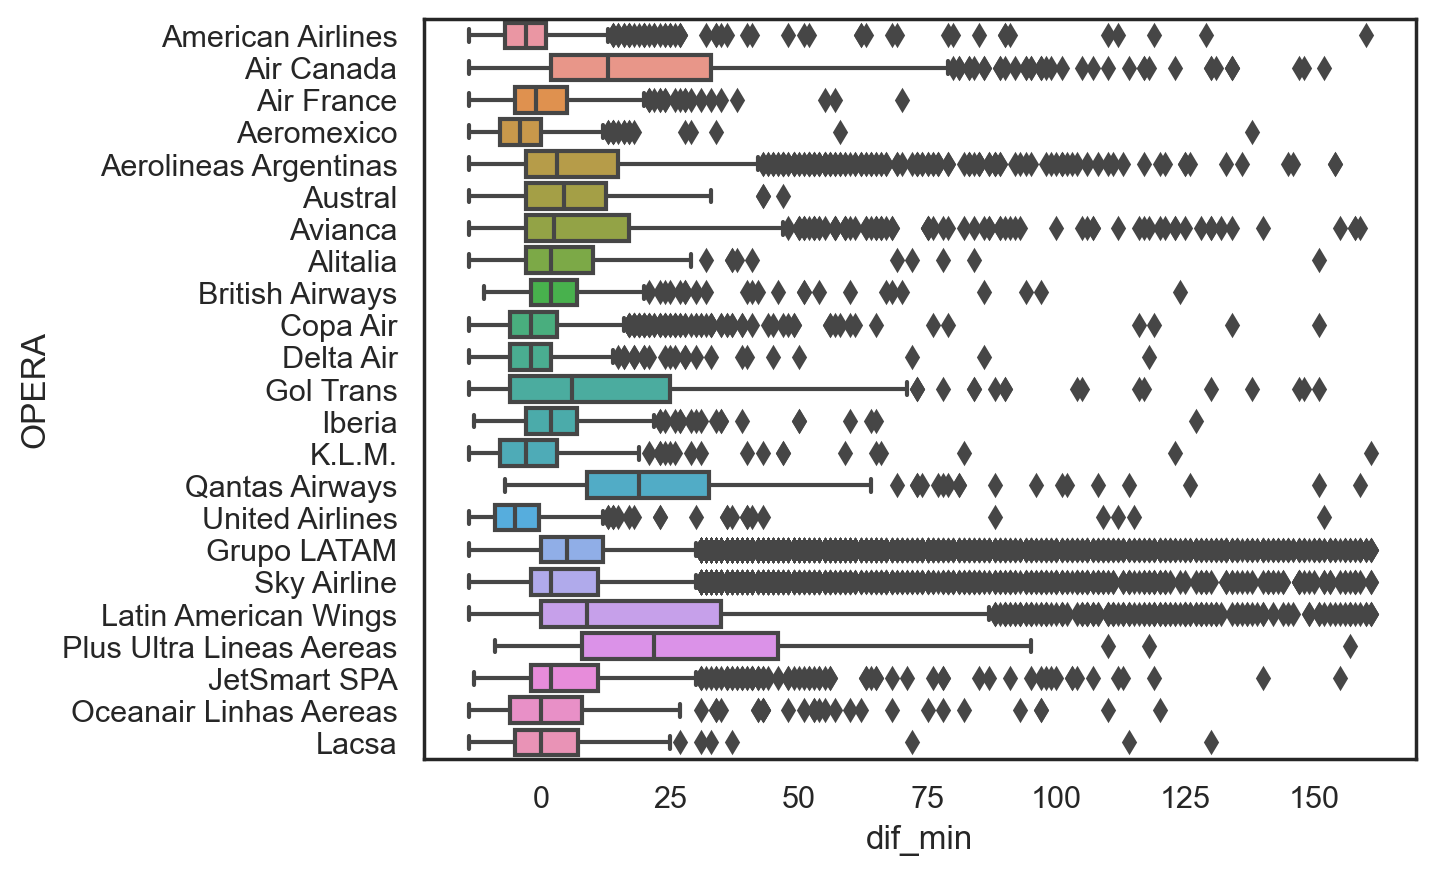

In [119]:
sns.boxplot(data=df, x= "dif_min",y= 'OPERA',orient="h");

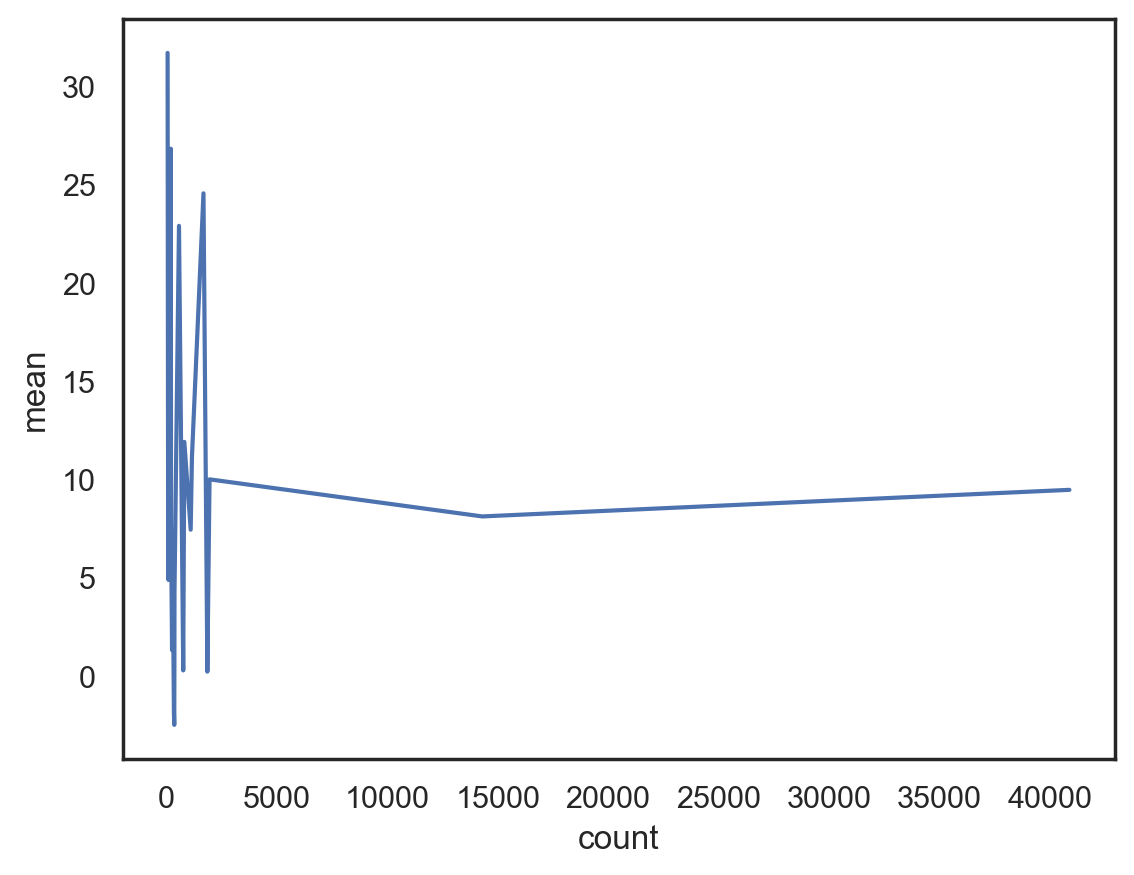

In [120]:
sns.lineplot(data=aux, x='count', y= 'mean');

In [121]:
tab = pd.crosstab(df['Emp-I'],df.atraso_15, margins=True)
tab.columns = ["Sin atraso","Con atraso",'col_total']
observed = tab.iloc[0:23,0:2]   # Get table without totals for later use
chi2 = scipy.stats.chi2_contingency(observed= observed)
if(chi2[1]<0.01):
    print("rechazamos H0")
else: 
    print("no hay evidencia para rechazar H0")

rechazamos H0


In [122]:
aux = df.groupby(['OPERA','Emp-I'])['dif_min'].describe().reset_index()
aux = pd.merge(pd.crosstab(df['Emp-I'],df.atraso_15, margins=True,normalize='index').reset_index(),aux, on='Emp-I')
aux.sort_values(by='count')

Emp-I         0         1                     OPERA    count       mean  \
20   LNE  0.000000  1.000000               Grupo LATAM      1.0  24.000000   
11   DSM  0.000000  1.000000               Grupo LATAM      2.0  73.000000   
21   LPE  0.500000  0.500000               Grupo LATAM      4.0  26.000000   
23   LXP  0.222222  0.777778               Grupo LATAM      9.0  52.555556   
25   PUE  0.387755  0.612245  Plus Ultra Lineas Aereas     49.0  31.714286   
..   ...       ...       ...                       ...      ...        ...   
9    CMP  0.937297  0.062703                  Copa Air   1850.0   0.214054   
4    ARG  0.759877  0.240123     Aerolineas Argentinas   1949.0  10.004618   
28   TAM  0.744178  0.255822               Grupo LATAM   3049.0  13.336832   
27   SKU  0.822353  0.177647               Sky Airline  14298.0   8.117149   
17   LAN  0.828428  0.171572               Grupo LATAM  37611.0   9.124405   

          std   min   25%   50%    75%    max  
20        NaN  24.0  24.0  24.0   24.0   24.0  
11  76.367532  19.0  46.0  73.0  100.0  127.0  
21  29.291637   1.0   4.0  19.5   41.5   64.0  
23  39.224071   5.0  23.0  59.0   62.0  112.0  
25  34.575401  -9.0   8.0  22.0   46.0  157.0  
..        ...   ...   ...   ...    ...    ...  
9   11.617931 -14.0  -6.0  -2.0    3.0  151.0  
4   22.604230 -14.0  -3.0   3.0   15.0  154.0  
28  21.691640 -14.0   1.0   8.0   16.0  159.0  
27  18.367337 -14.0  -2.0   2.0   11.0  161.0  
17  17.351099 -14.0   0.0   4.0   11.0  161.0  

[30 rows x 12 columns]

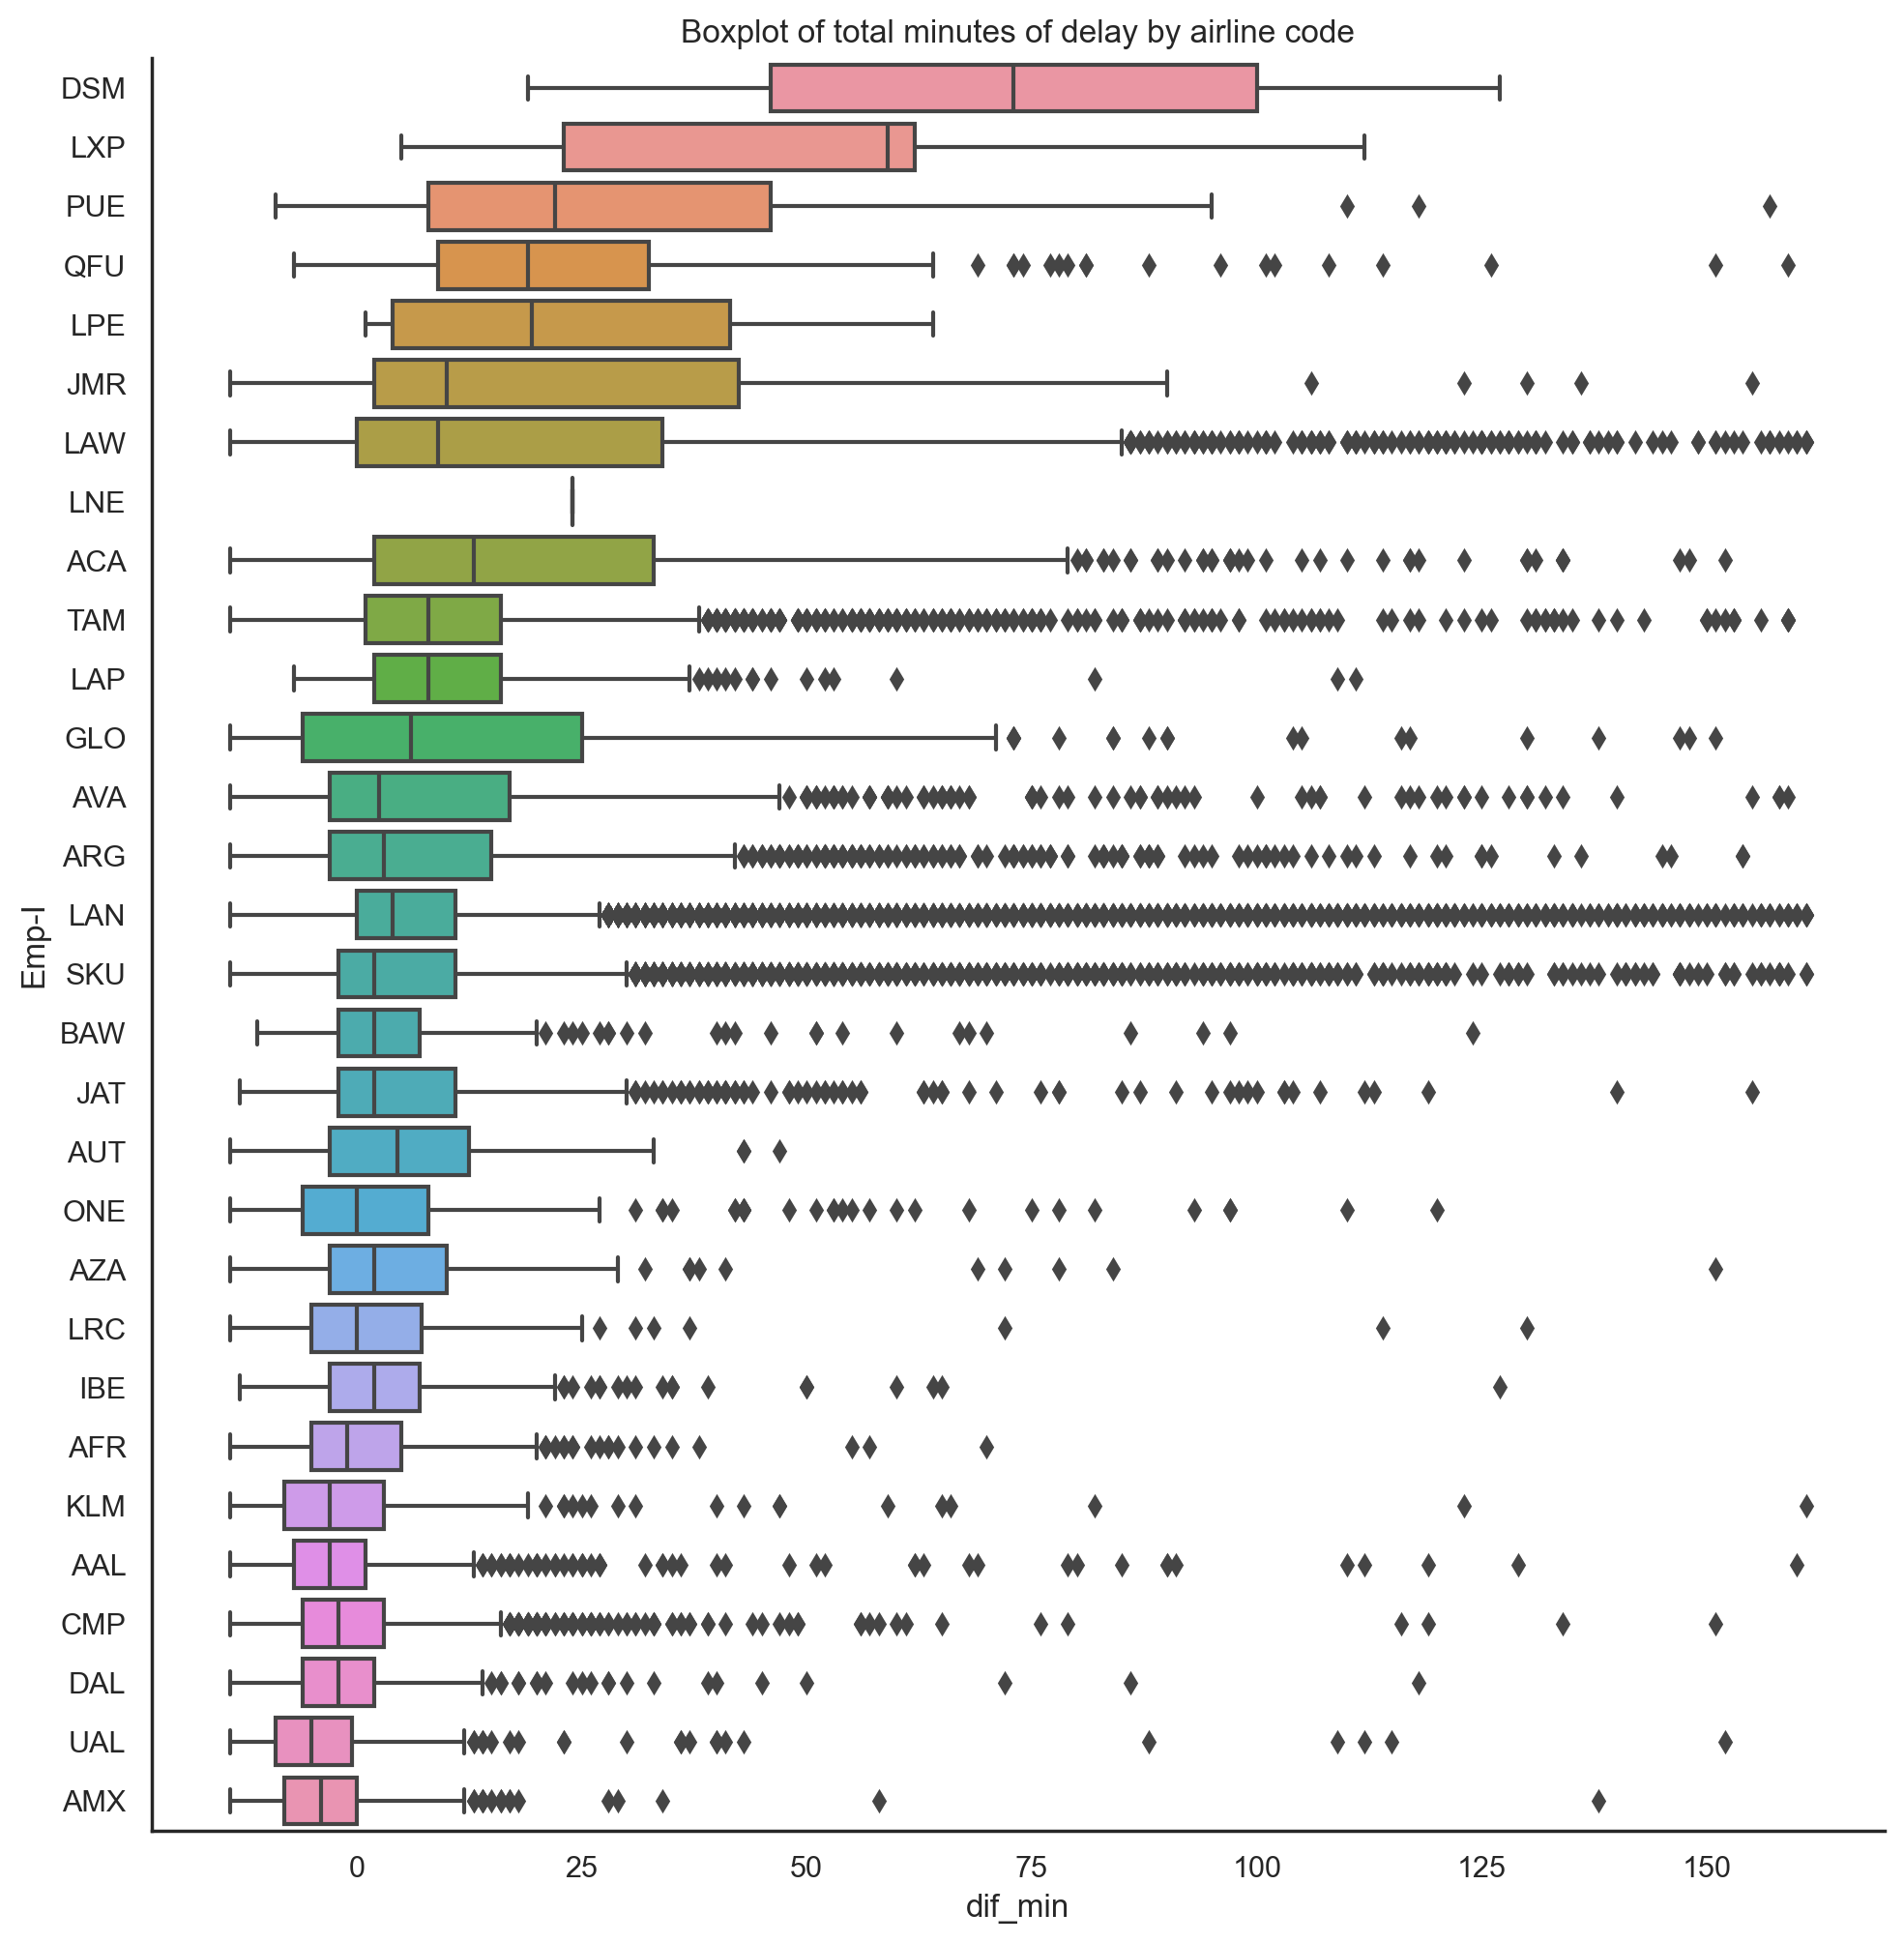

In [123]:
aux = df.groupby(['Emp-I'])['dif_min'].describe().reset_index()
sns.catplot(x="dif_min", y='Emp-I',data=df,
            height=10,kind="box", order = aux.sort_values(by='mean', ascending = False)['Emp-I'])
plt.title('Boxplot of total minutes of delay by airline code')
plt.show();

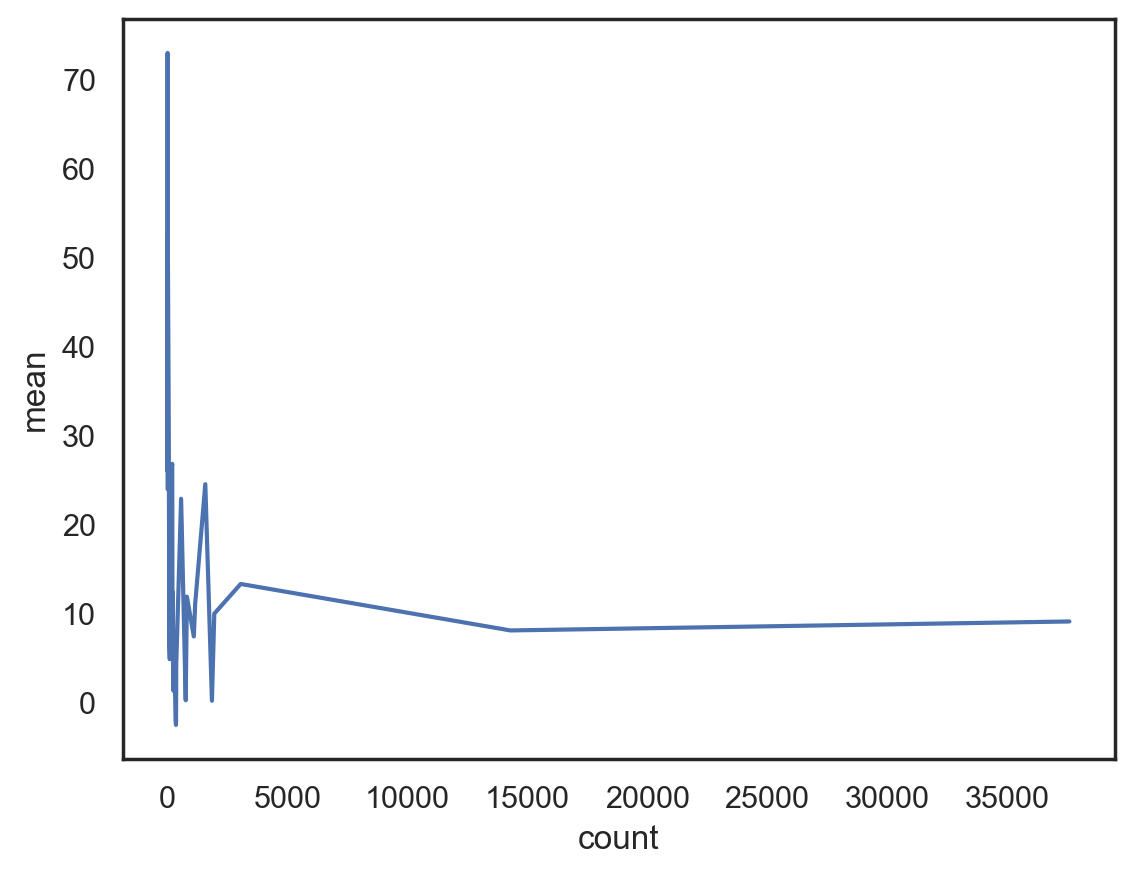

In [124]:
sns.lineplot(data=aux, x='count', y= 'mean');

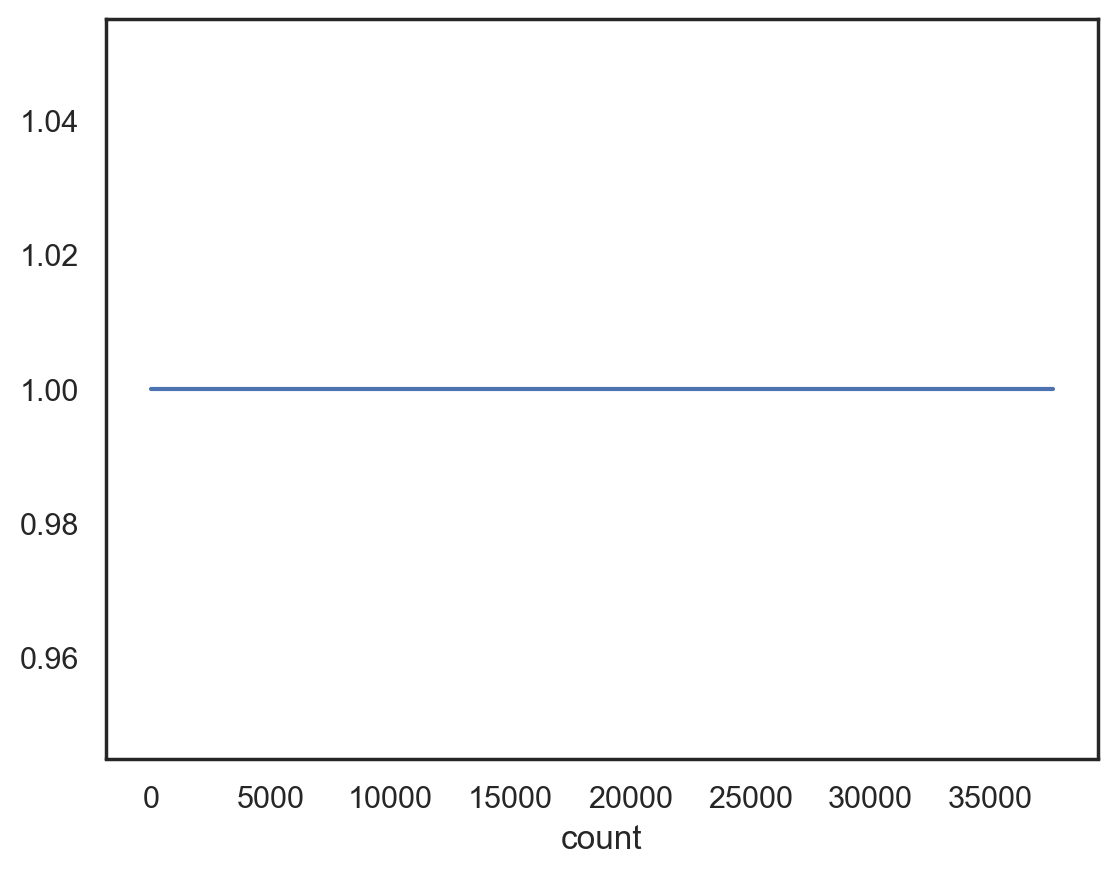

In [125]:
sns.lineplot(data=aux, x='count', y= 1);

In [126]:
aux.corr()

count      mean       std       min       25%       50%       75%  \
count  1.000000 -0.099461 -0.123698 -0.143608 -0.061596 -0.106399 -0.123716   
mean  -0.099461  1.000000  0.941290  0.724204  0.923143  0.969482  0.984887   
std   -0.123698  0.941290  1.000000  0.803039  0.895002  0.878582  0.950886   
min   -0.143608  0.724204  0.803039  1.000000  0.893862  0.794907  0.660559   
25%   -0.061596  0.923143  0.895002  0.893862  1.000000  0.951715  0.874737   
50%   -0.106399  0.969482  0.878582  0.794907  0.951715  1.000000  0.935630   
75%   -0.123716  0.984887  0.950886  0.660559  0.874737  0.935630  1.000000   
max    0.232742 -0.106351  0.081926 -0.541034 -0.283366 -0.208054 -0.074232   

            max  
count  0.232742  
mean  -0.106351  
std    0.081926  
min   -0.541034  
25%   -0.283366  
50%   -0.208054  
75%   -0.074232  
max    1.000000

In [127]:
df[df['Emp-I']=='TPU']

Empty DataFrame
Columns: [Fecha-I, Vlo-I, Ori-I, Des-I, Emp-I, Fecha-O, Vlo-O, Ori-O, Des-O, Emp-O, DIA, MES, AÑO, DIANOM, TIPOVUELO, OPERA, SIGLAORI, SIGLADES, dif_min, atraso_15, periodo_dia, temporada_alta, ICAO Code, IATA Code, Airport Name, City/Town, Country, Lat, Long, distance_to_destiny, fecha_operacion, n_vuelos_mes, n_vuelos_diasem, n_vuelos_diames]
Index: []

[0 rows x 34 columns]

In [128]:
df.groupby(['OPERA','Emp-I','Emp-O'])['dif_min'].describe()

count       mean        std   min  \
OPERA                    Emp-I Emp-O                                        
Aerolineas Argentinas    ARG   ARG     1944.0   9.927984  22.461678 -14.0   
                               AUT        5.0  39.800000  51.446088   4.0   
Aeromexico               AMX   AMX      351.0  -2.495726  10.799437 -14.0   
Air Canada               ACA   ACA      565.0  22.909735  30.628997 -14.0   
Air France               AFR   AFR      358.0   1.399441  10.527260 -14.0   
...                                       ...        ...        ...   ...   
Oceanair Linhas Aereas   ONE   ONE      279.0   6.340502  21.396114 -14.0   
Plus Ultra Lineas Aereas PUE   PUE       49.0  31.714286  34.575401  -9.0   
Qantas Airways           QFU   QFA      195.0  26.835897  28.184110  -7.0   
Sky Airline              SKU   SKU    14298.0   8.117149  18.367337 -14.0   
United Airlines          UAL   UAL      335.0  -1.856716  17.319914 -14.0   

                                      25%   50%   75%    max  
OPERA                    Emp-I Emp-O                          
Aerolineas Argentinas    ARG   ARG   -3.0   3.0  15.0  154.0  
                               AUT    9.0   9.0  52.0  125.0  
Aeromexico               AMX   AMX   -8.0  -4.0   0.0  138.0  
Air Canada               ACA   ACA    2.0  13.0  33.0  152.0  
Air France               AFR   AFR   -5.0  -1.0   5.0   70.0  
...                                   ...   ...   ...    ...  
Oceanair Linhas Aereas   ONE   ONE   -6.0   0.0   8.0  120.0  
Plus Ultra Lineas Aereas PUE   PUE    8.0  22.0  46.0  157.0  
Qantas Airways           QFU   QFA    9.0  19.0  32.5  159.0  
Sky Airline              SKU   SKU   -2.0   2.0  11.0  161.0  
United Airlines          UAL   UAL   -9.0  -5.0  -0.5  152.0  

[41 rows x 8 columns]

#### **Code of the city where the flights arrived** 

**Conclusions**

* The codes of the city of arrival shows a lot of difference in the magnitud of delay between them, with like SEQM or CYYZ in very high ranges

* wich says that we can't reject the statement says there is no significance relation between the city codes and the delay for more than 15 minutes

* Despite the results of the hipothesis test, we have found that there is difference between the airline code for the same city code. Which reinforce our idea that most of the variables for this problem are only relevant when the effects are evaluated together with the all context of the flight (airline-city of destiny- date)

* There is no relation between the number of total flights to arrive in a city and the frequency or magnitud of delays

In [129]:
tab = pd.crosstab(df['Des-I'],df.atraso_15, margins=True)
tab.columns = ["Sin atraso","Con atraso",'col_total']
observed = tab.iloc[0:63,0:2]   # Get table without totals for later use
chi2 = scipy.stats.chi2_contingency(observed= observed)
if(chi2[1]<=0.01):
    print("rechazamos H0")
else: 
    print("no hay evidencia para rechazar H0")

rechazamos H0


In [130]:
aux = df.groupby(['Des-I'])['dif_min'].describe().reset_index().sort_values(by='count')
aux = pd.merge(pd.crosstab(df['Des-I'],df.atraso_15, margins=True,normalize='index').reset_index(),aux, on='Des-I')
aux.sort_values(by='count')

Des-I         0         1   count        mean        std    min    25%  \
2   EGYP  0.000000  1.000000     1.0   50.000000        NaN   50.0   50.0   
59  SPSO  1.000000  0.000000     1.0    2.000000        NaN    2.0    2.0   
25  SARI  1.000000  0.000000     1.0   -2.000000        NaN   -2.0   -2.0   
55  SLCB  0.000000  1.000000     1.0  113.000000        NaN  113.0  113.0   
52  SEQU  0.000000  1.000000     1.0   80.000000        NaN   80.0   80.0   
..   ...       ...       ...     ...         ...        ...    ...    ...   
41  SCIE  0.843554  0.156446  3995.0    8.392240  19.888500  -14.0   -1.0   
48  SCTE  0.831535  0.168465  4357.0    8.868028  16.579394  -14.0    0.0   
37  SCCF  0.877745  0.122255  5145.0    5.970262  15.252708  -14.0   -1.0   
58  SPJC  0.769639  0.230361  5270.0   11.736243  22.812493  -14.0    0.0   
40  SCFA  0.853637  0.146363  5787.0    7.023155  16.506066  -13.0   -1.0   

      50%    75%    max  
2    50.0   50.0   50.0  
59    2.0    2.0    2.0  
25   -2.0   -2.0   -2.0  
55  113.0  113.0  113.0  
52   80.0   80.0   80.0  
..    ...    ...    ...  
41    3.0   10.0  161.0  
48    4.0   11.0  161.0  
37    2.0    7.0  161.0  
58    5.0   14.0  161.0  
40    2.0    9.0  161.0  

[64 rows x 11 columns]

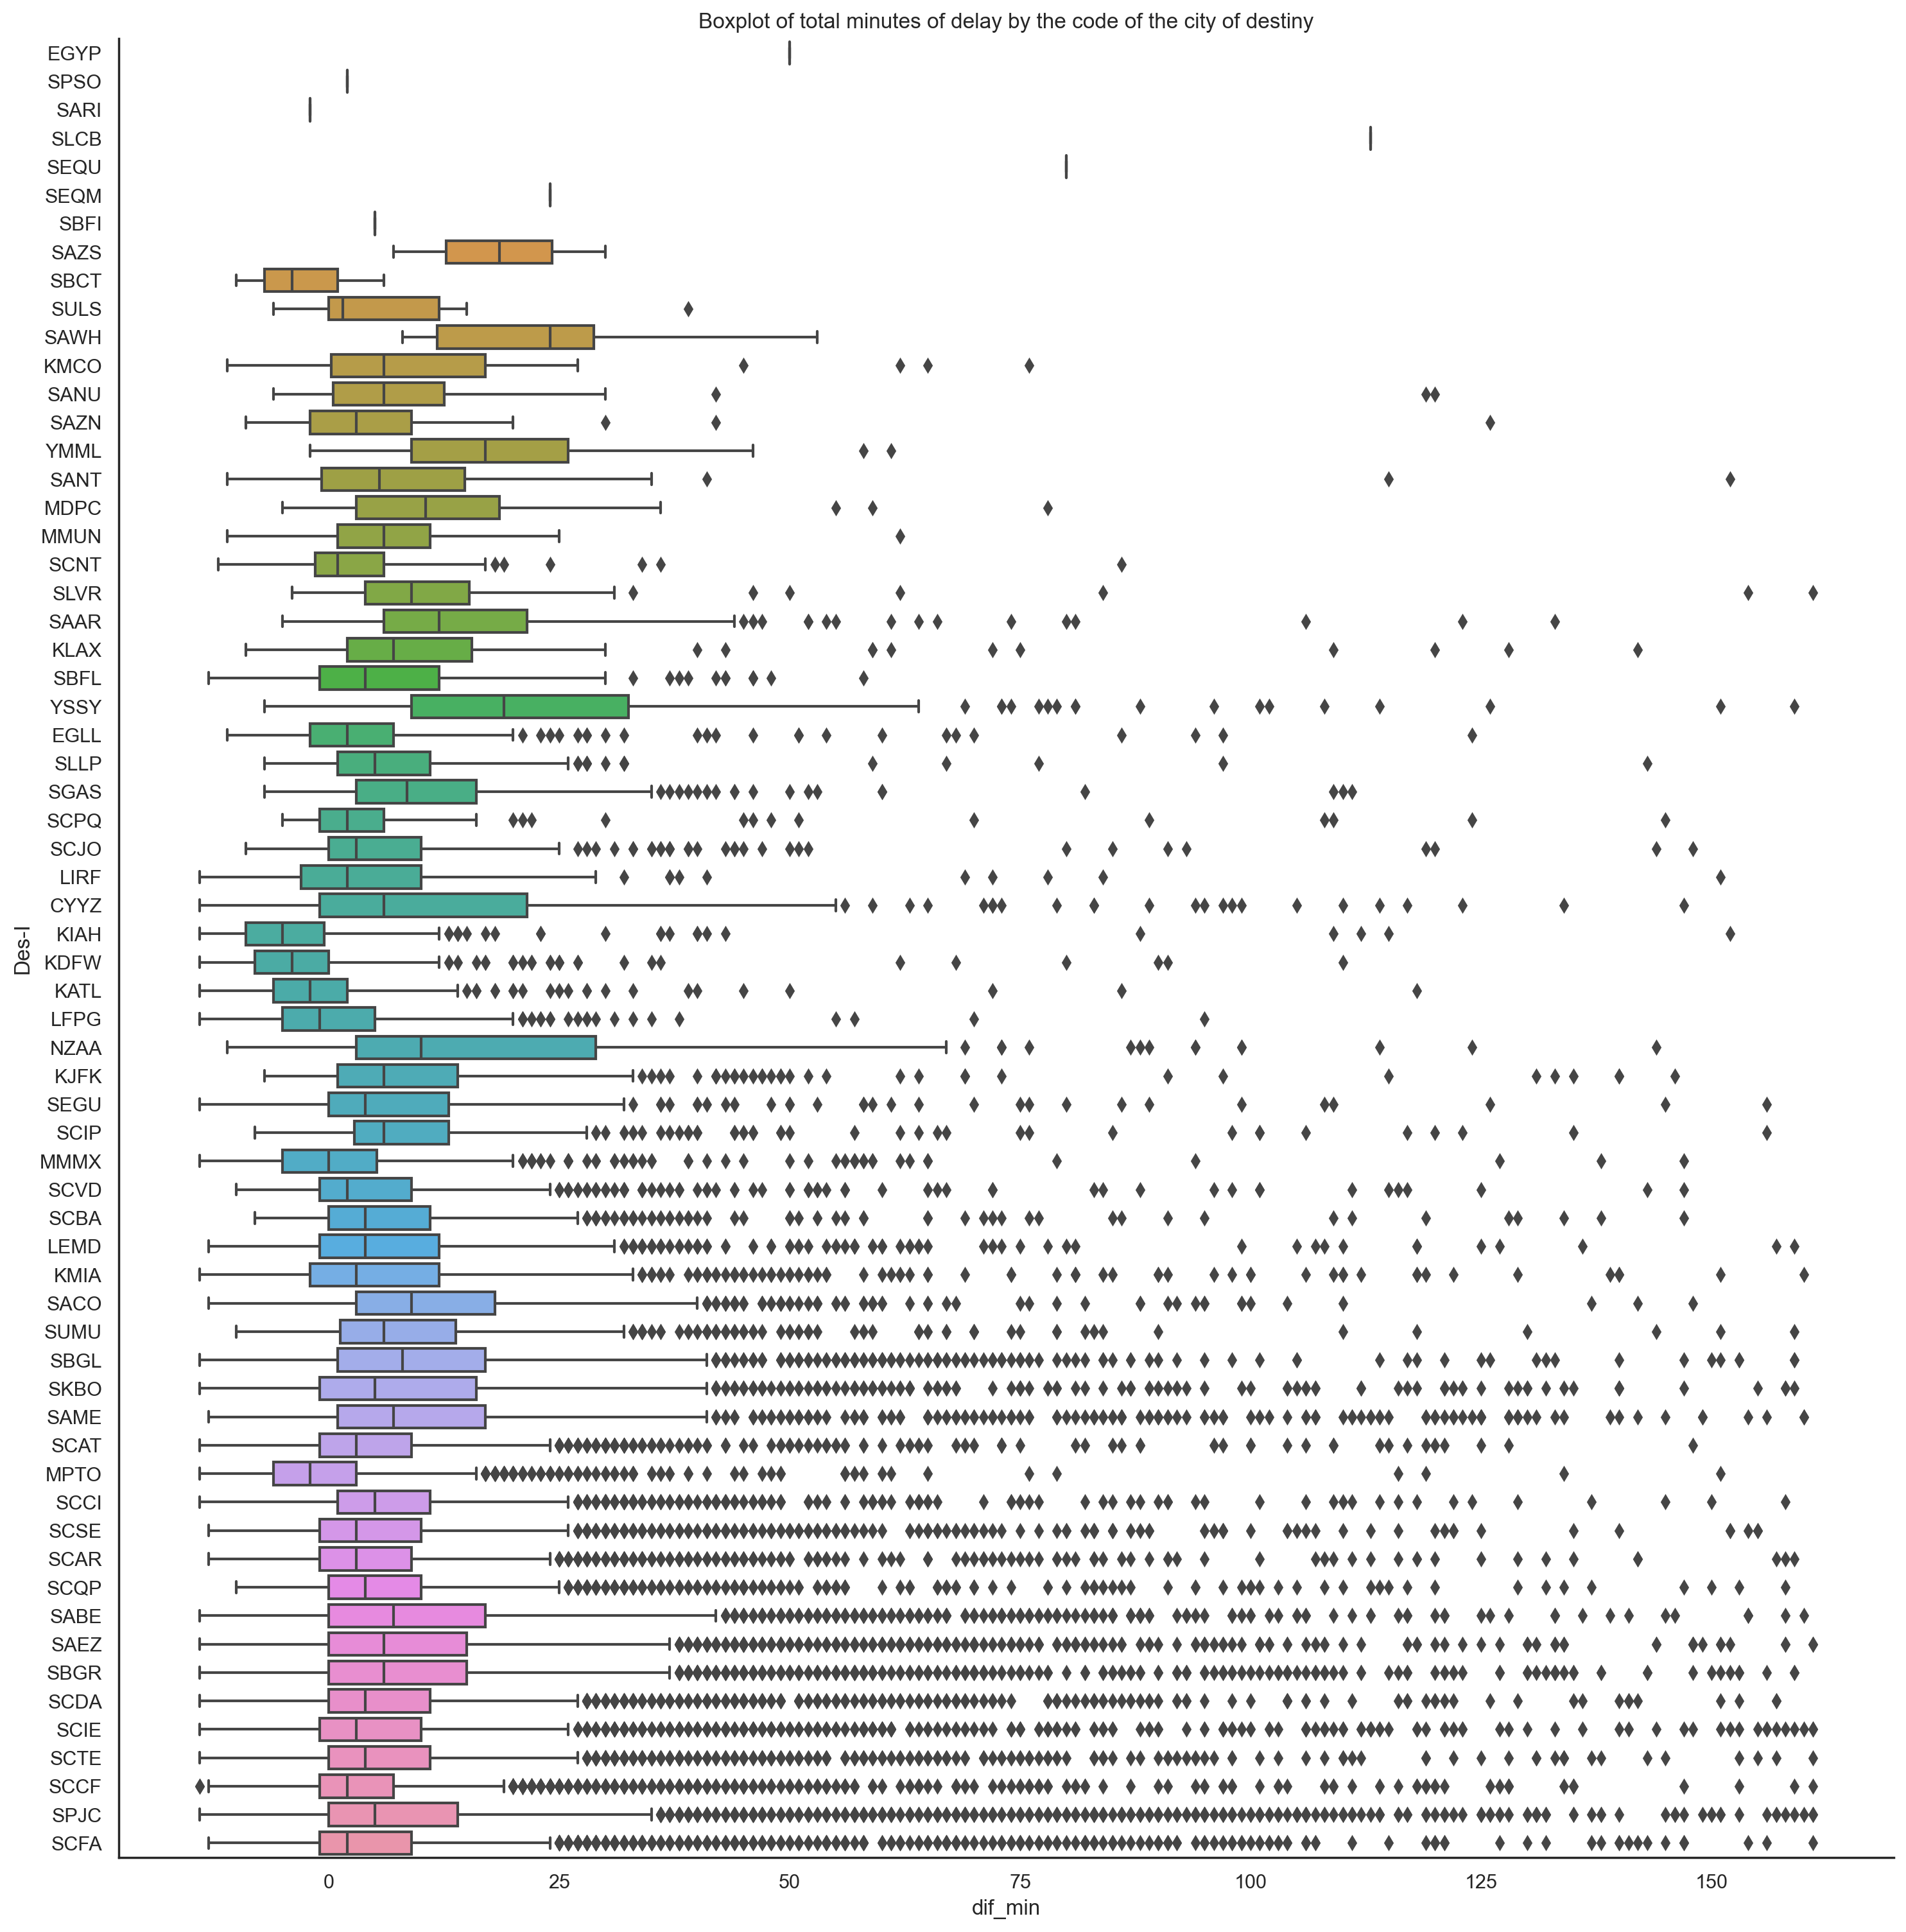

In [131]:
sns.catplot(x="dif_min", y='Des-I',data=df,
            height=15,kind="box", order = aux.sort_values(by='count')['Des-I'])
plt.title('Boxplot of total minutes of delay by the code of the city of destiny')
plt.show();

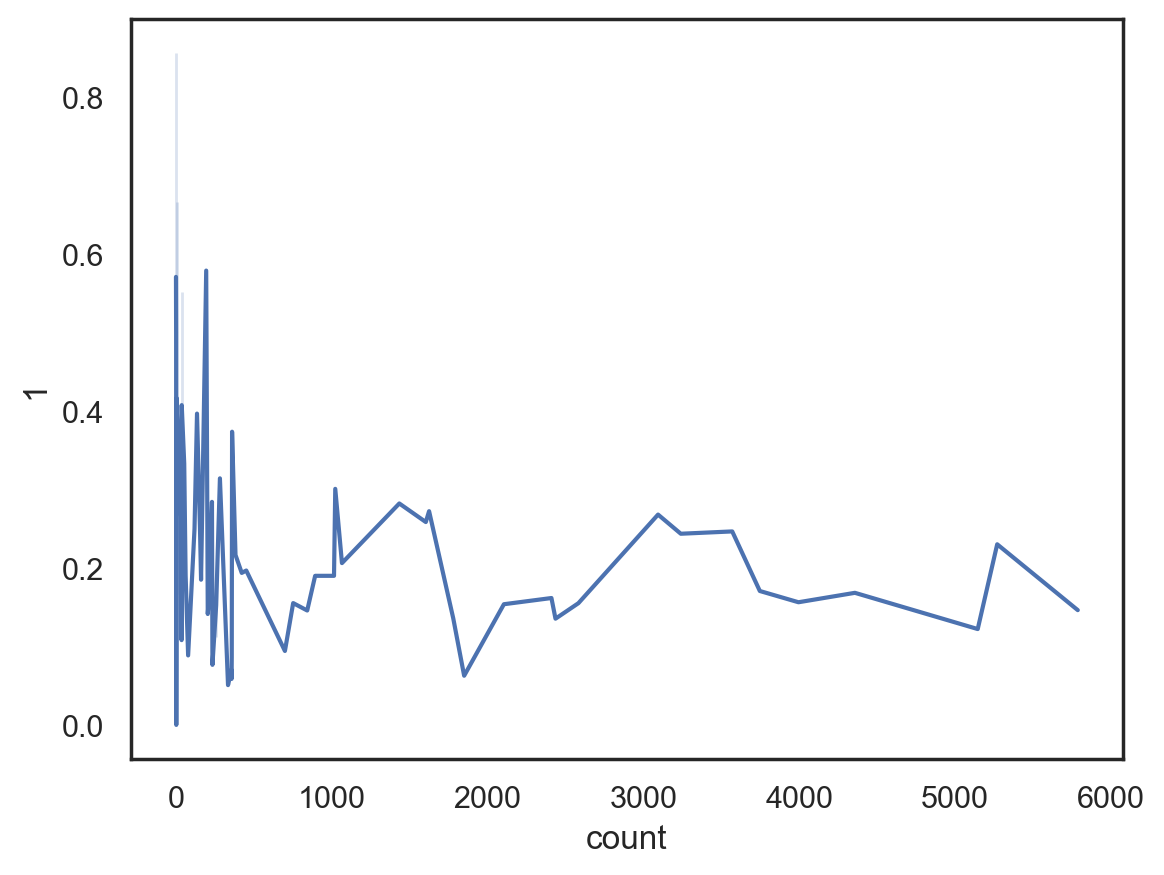

In [132]:
sns.lineplot(data=aux, x='count', y= 1);

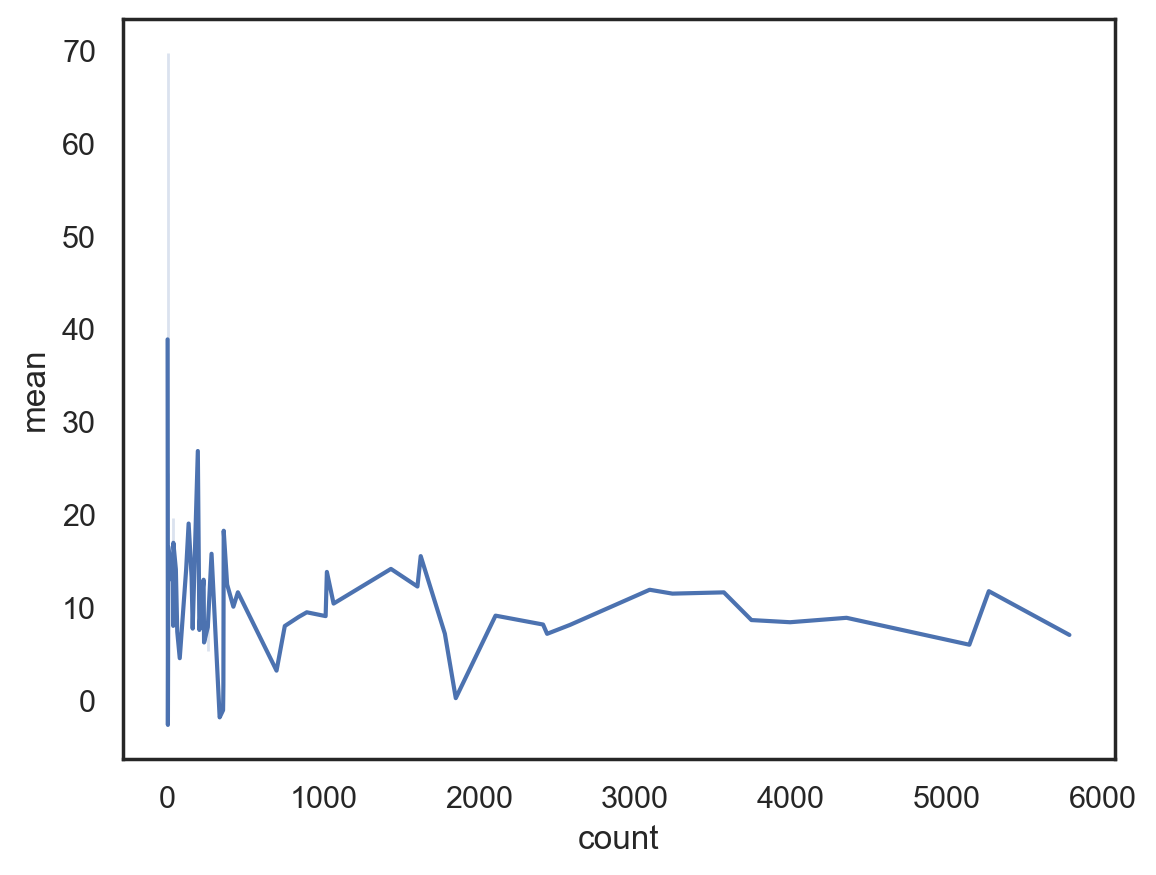

In [133]:
sns.lineplot(data=aux, x='count', y= 'mean');

In [134]:
df.groupby(['Des-I','Emp-I'])['dif_min'].describe().head(30)

count       mean        std   min   25%   50%   75%    max
Des-I Emp-I                                                             
CYYZ  ACA     283.0  15.766784  27.982936 -14.0  -1.0   6.0  21.5  147.0
EGLL  BAW     205.0   7.560976  19.241561 -11.0  -2.0   2.0   7.0  124.0
EGYP  LAN       1.0  50.000000        NaN  50.0  50.0  50.0  50.0   50.0
KATL  DAL     358.0   0.114525  12.212211 -14.0  -6.0  -2.0   2.0  118.0
KDFW  AAL     357.0  -1.081232  14.024321 -14.0  -8.0  -4.0   0.0  110.0
...             ...        ...        ...   ...   ...   ...   ...    ...
SAAR  SKU      39.0  13.051282  18.461836  -5.0   2.0  10.0  18.0  106.0
      TAM      35.0  21.542857  15.446955   3.0  11.5  16.0  25.5   66.0
SABE  ARG    1600.0  10.715000  22.888806 -14.0  -3.0   4.0  16.0  154.0
      AUT      30.0   2.833333  10.392581 -14.0  -5.5   1.5   9.0   25.0
      DSM       1.0  19.000000        NaN  19.0  19.0  19.0  19.0   19.0

[30 rows x 8 columns]

#### **Distance to the destiny** 

**Conclusions**

* When reviewing the distance distribution we can notice that:
     * There is no linear correlation between distance and the magnitude of delays
     * There is also no difference in the average distances and percentiles traveled by flights with a delay of more than 15 minutes and those that are not.
     * If we see evidence that the true differentiator is whether the flight is international or not, which is to be expected given the complexity of check-in and boarding on international flights


* We conclude then that it is not a variable that by itself contributes information to the prediction

------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [135]:
df[num_cols].corr()

dif_min  distance_to_destiny
dif_min              1.000000             0.004931
distance_to_destiny  0.004931             1.000000

In [136]:
df.groupby(['atraso_15'])['distance_to_destiny'].describe()

count         mean          std        min         25%  \
atraso_15                                                             
0          55592.0  2467.309061  2631.316204  196.12299  915.967343   
1          12614.0  2654.616660  2772.612267  196.12299  915.967343   

                   50%         75%           max  
atraso_15                                         
0          1369.501028  2617.12593  11876.627771  
1          1425.995614  2617.12593  11876.627771

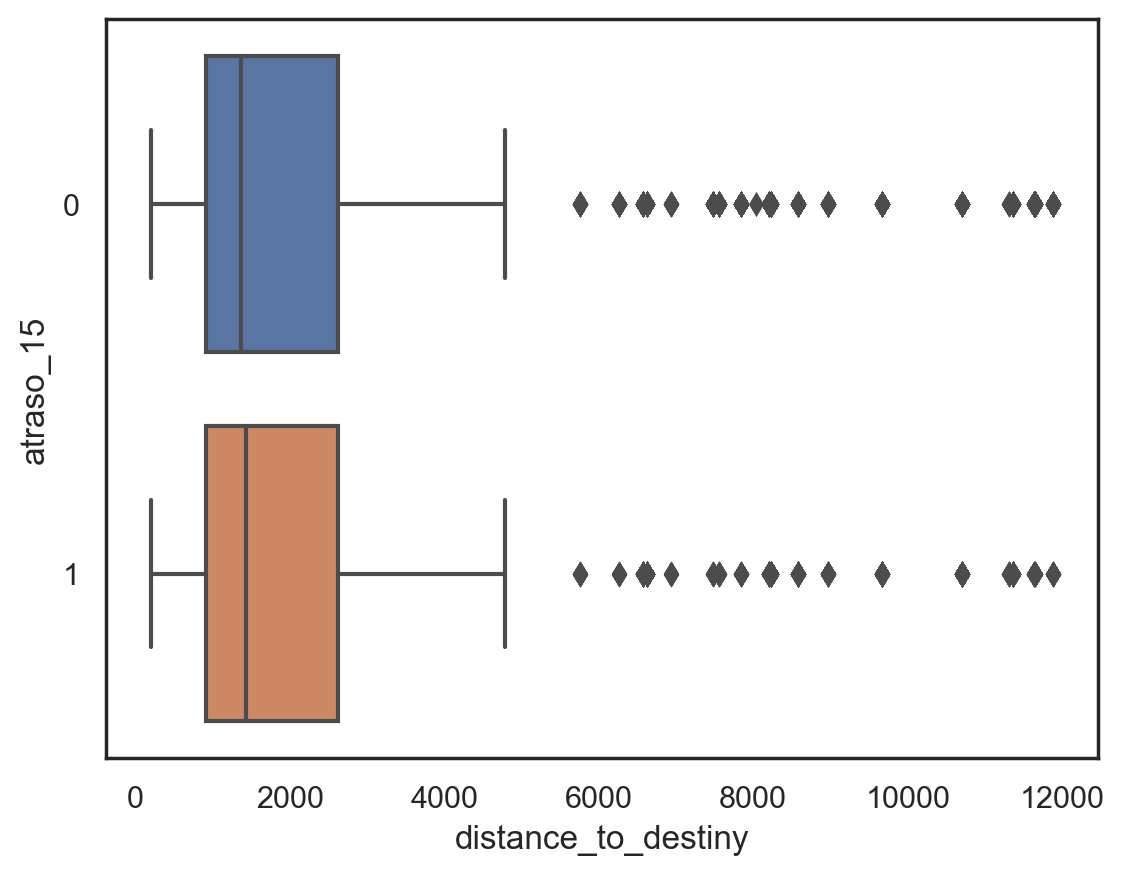

In [137]:
sns.boxplot(data=df, y="atraso_15", x="distance_to_destiny", orient = 'h');

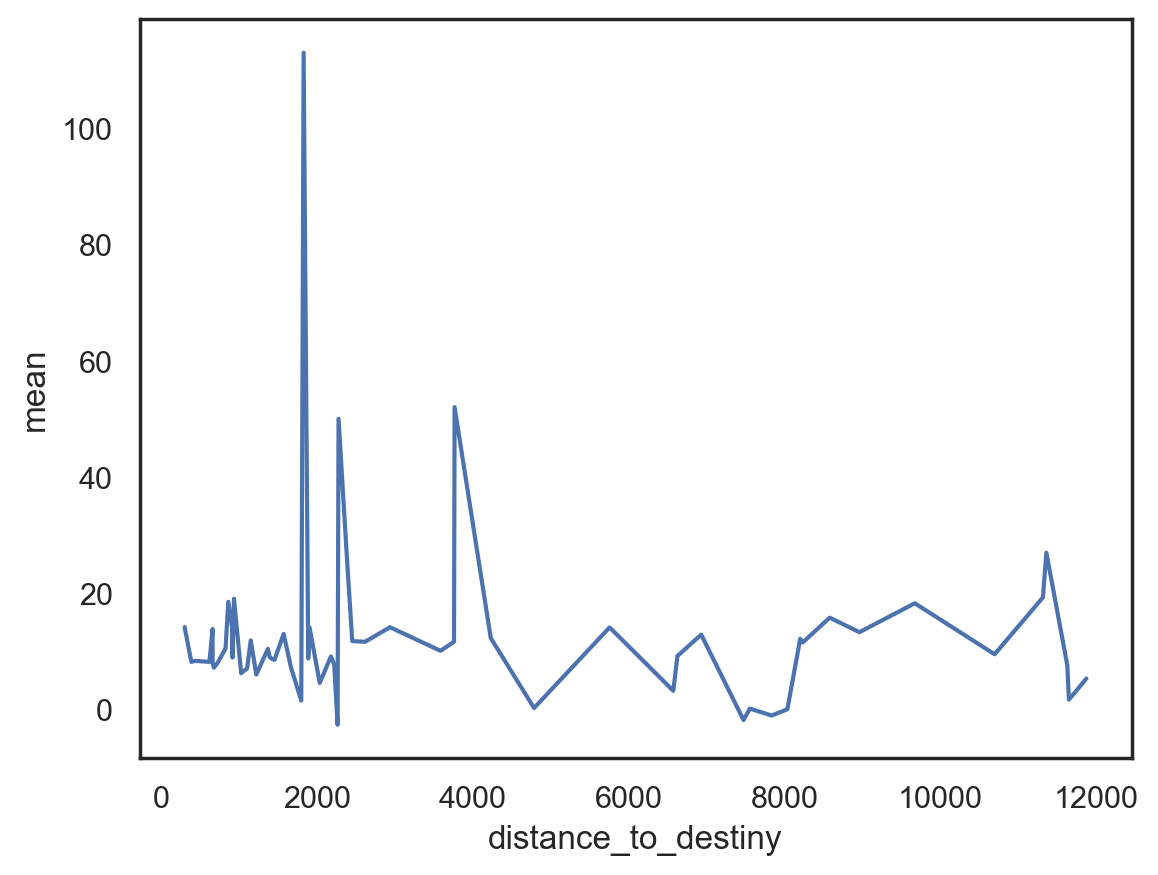

In [138]:
aux = df.groupby(['distance_to_destiny'])['dif_min'].describe().reset_index()[1:]
sns.lineplot(data=aux, x='distance_to_destiny', y='mean');

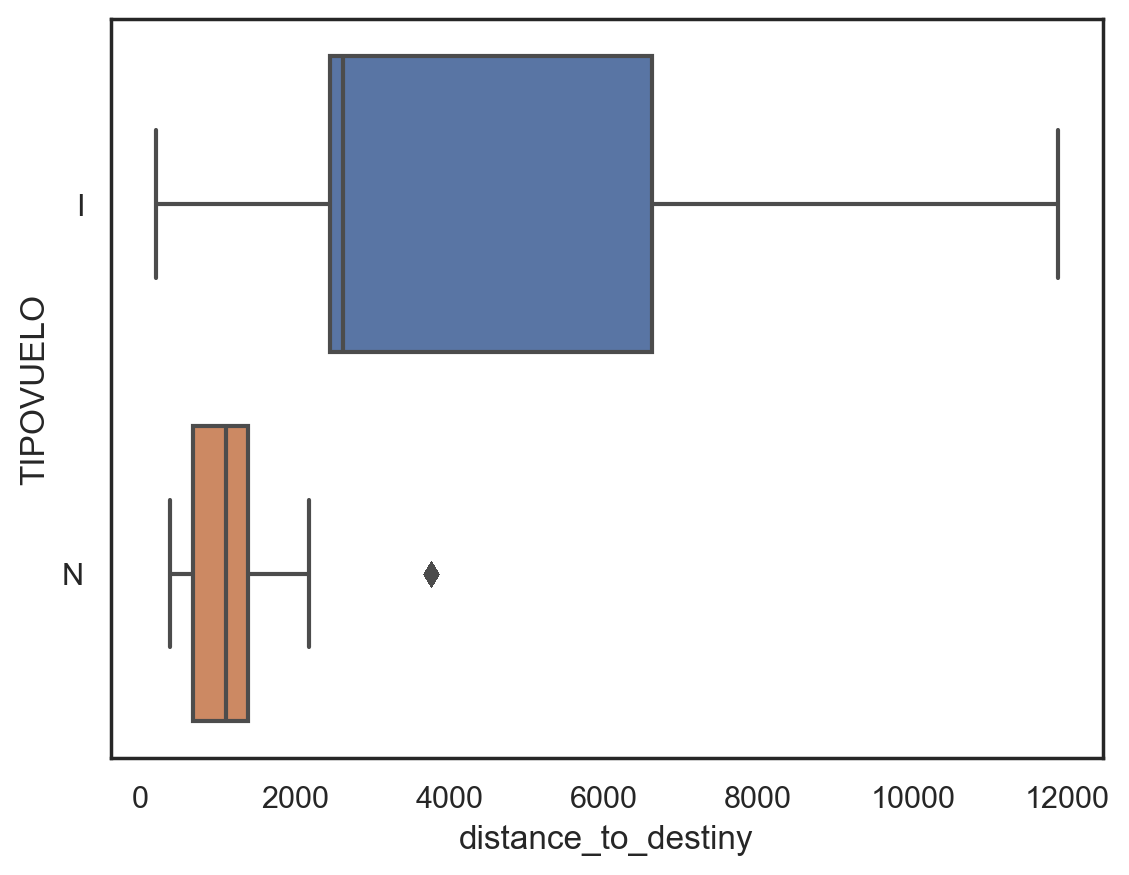

In [139]:
sns.boxplot(data=df, y="TIPOVUELO", x="distance_to_destiny", orient = 'h');

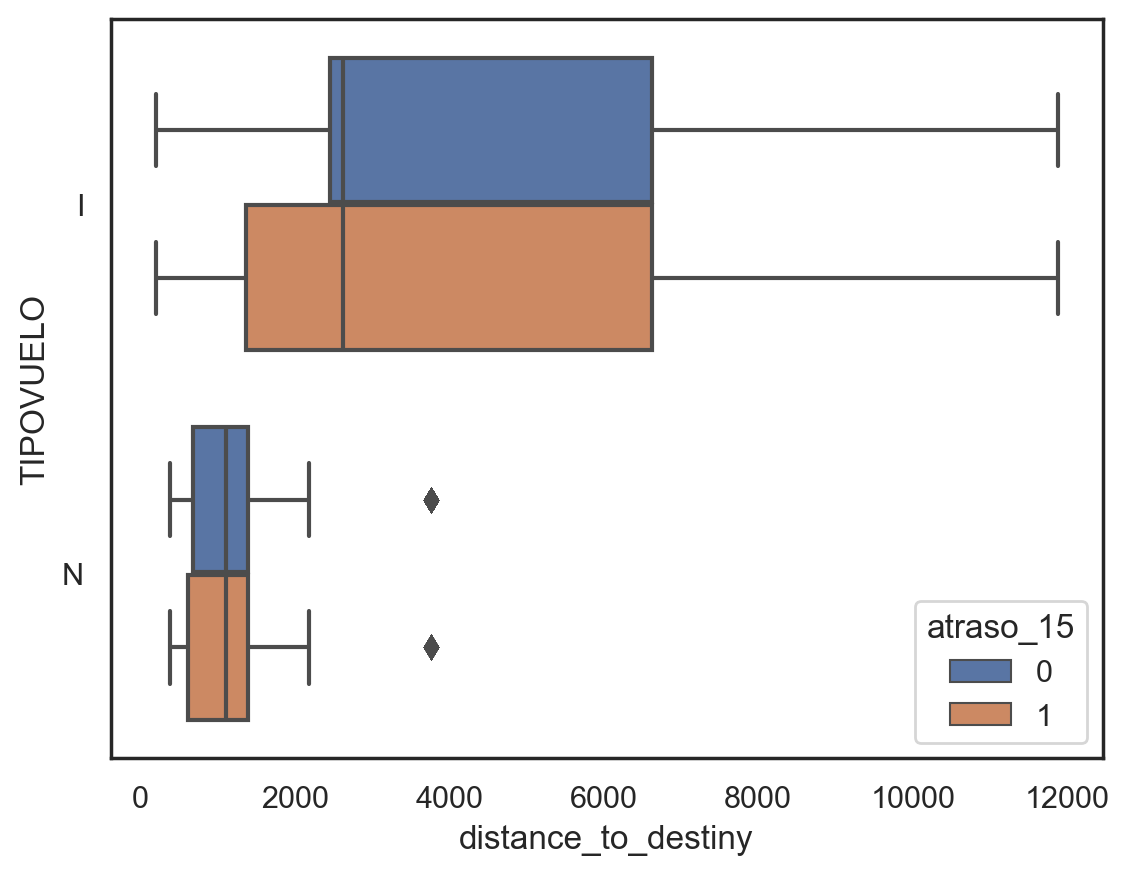

In [140]:
sns.boxplot(data=df, y="TIPOVUELO", x="distance_to_destiny", hue="atraso_15", orient = 'h');

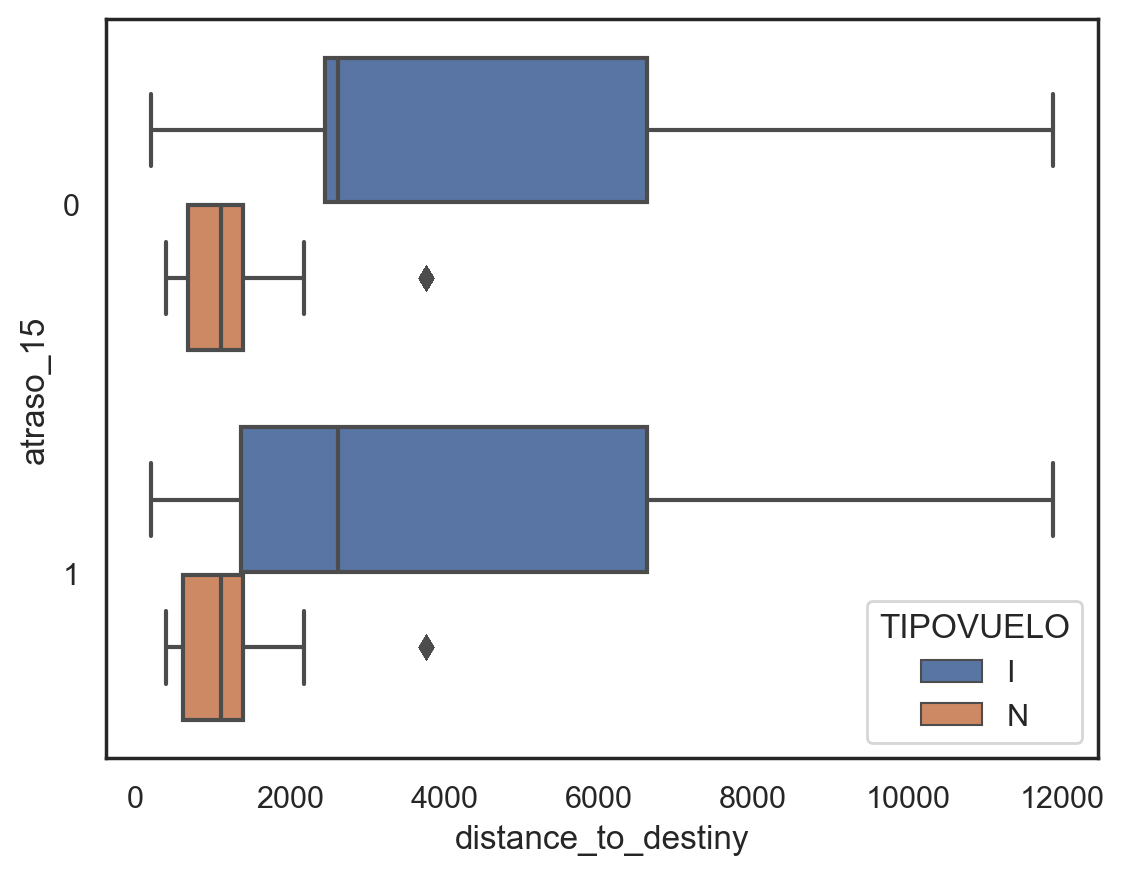

In [141]:
sns.boxplot(data=df, y="atraso_15", x="distance_to_destiny", hue="TIPOVUELO", orient = 'h');

#### **Combining date of operation - code of the airlines - code of the city of arrival on Schedulling** 

Here we count the number of flights for 4 posible combinations:

 * Date of operation (fecha_operacion) with code of the city of destiny schedulled (Des-I)
 * Date of operation (fecha_operacion) with code of the airline who schedulled the flight (Emp-I) 
 * Code of the city of destiny schedulled (Des-I) with code of the airline who schedulled the flight (Emp-I)
 * Date of operation (fecha_operacion)  with code of the city of destiny schedulled (Des-I) and the code of the airline who schedulled the flight (Emp-I)

And then analyze the relation with the delay

**Conclusions**

* There is a strong correlation between the magnitud and frequency of the delay with the number of flights made in the same day and airline for the same destiny


* The variables that will remain as candidates to be selected for model will be n_vuelos_fecha_aerolinea_destino which represents the number of flights grouping by schedulled date with code of the schedulled city of destiny  and the code of the airline schedulled.  **For the training and prediction, we will use the schedulled codes but in case you are looking a window of time in which you have the operated code, then you can use the operated codes as replace and will work fine because the relation is preserved, as you can see on the plots and the 0.77 of correlation between number of flights and mean delay as we can see for that grouping**

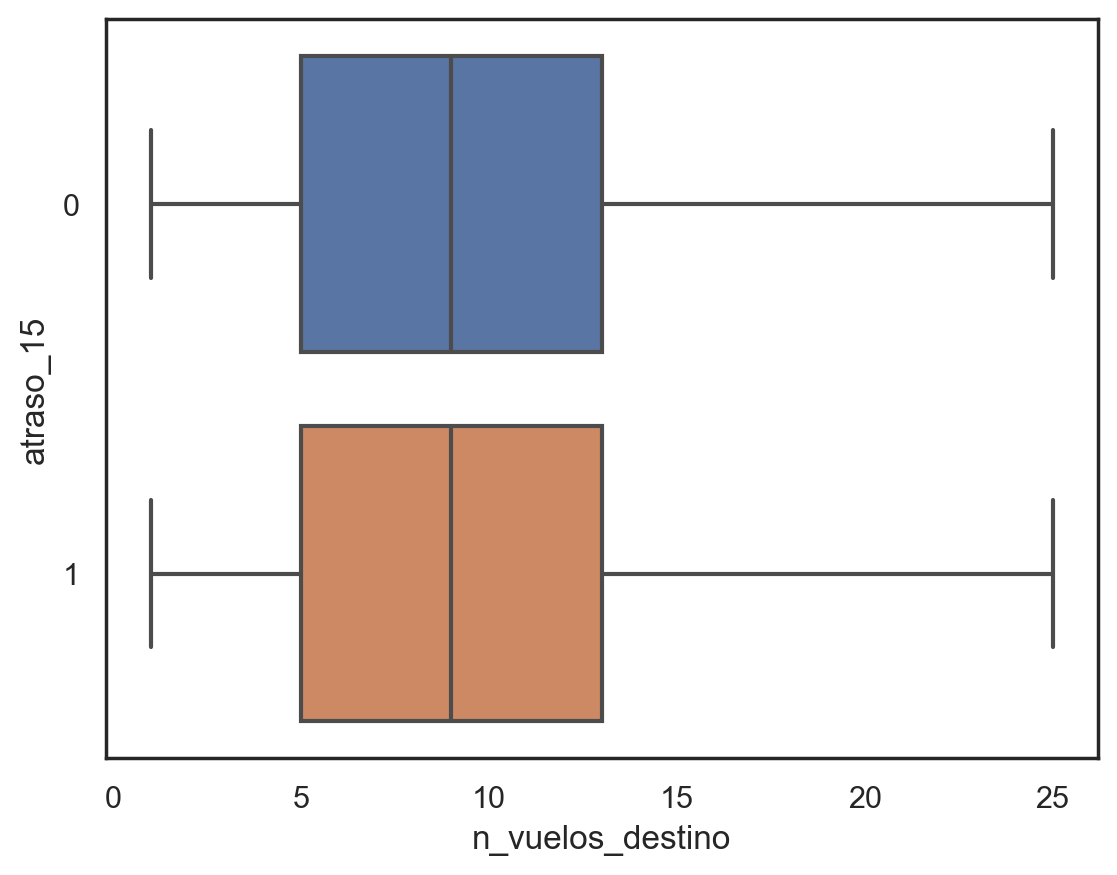

In [142]:
aux = df.groupby(['fecha_operacion','Des-I'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'n_vuelos_destino'}, inplace=True)
df = pd.merge(df, aux, on = ['fecha_operacion','Des-I'], how='left')
sns.boxplot(data=df, x= "n_vuelos_destino",y= "atraso_15", orient="h");

In [143]:
aux1 = aux[(aux.fecha_operacion=='2017-1-5') & (aux['Des-I']=='KMIA')].n_vuelos_destino.values
aux2= df[(df.fecha_operacion=='2017-1-5') & (df['Des-I']=='KMIA')].head(1).n_vuelos_destino.values
if(aux1==aux2):
    print('cruce correcto')
else:
    raise Exception("Sorry, your join between df and the count of flight for each destiny didn't get ok")

cruce correcto


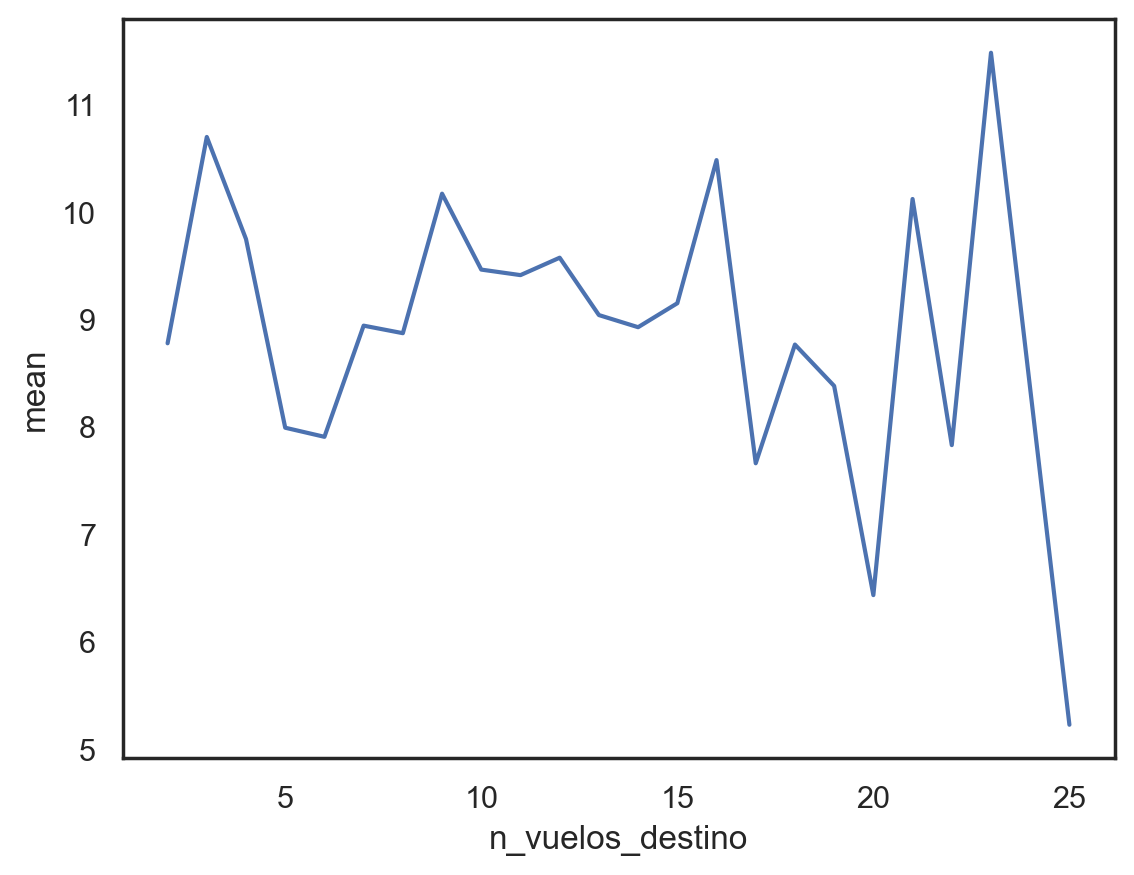

In [144]:
aux = df.groupby(['n_vuelos_destino'])['dif_min'].describe().reset_index()[1:]
sns.lineplot(data=aux, x='n_vuelos_destino', y='mean');

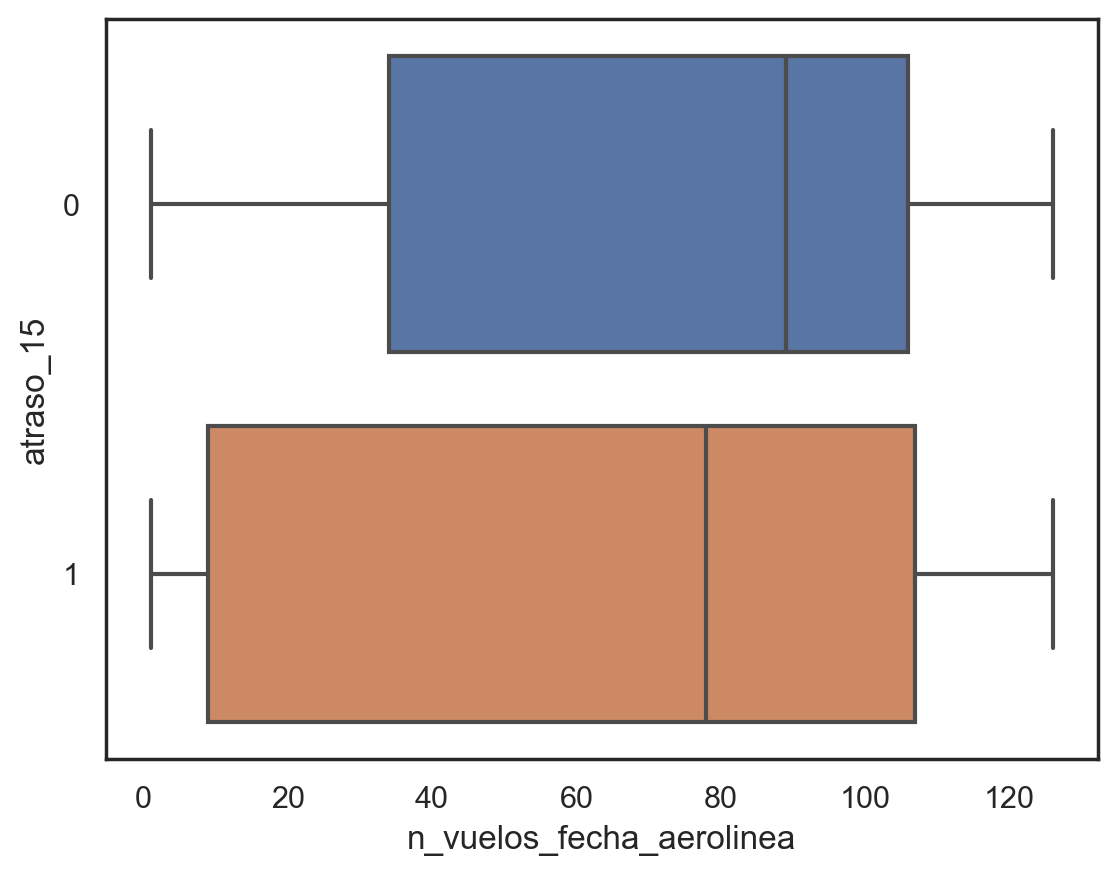

In [145]:
aux = df.groupby(['fecha_operacion','Emp-I'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'n_vuelos_fecha_aerolinea'}, inplace=True)
df = pd.merge(df, aux, on = ['fecha_operacion','Emp-I'], how='left')
sns.boxplot(data=df, x= "n_vuelos_fecha_aerolinea",y= "atraso_15", orient="h");

                              mean       50%  n_vuelos_fecha_aerolinea
mean                      1.000000  0.866739                  0.011991
50%                       0.866739  1.000000                  0.233583
n_vuelos_fecha_aerolinea  0.011991  0.233583                  1.000000


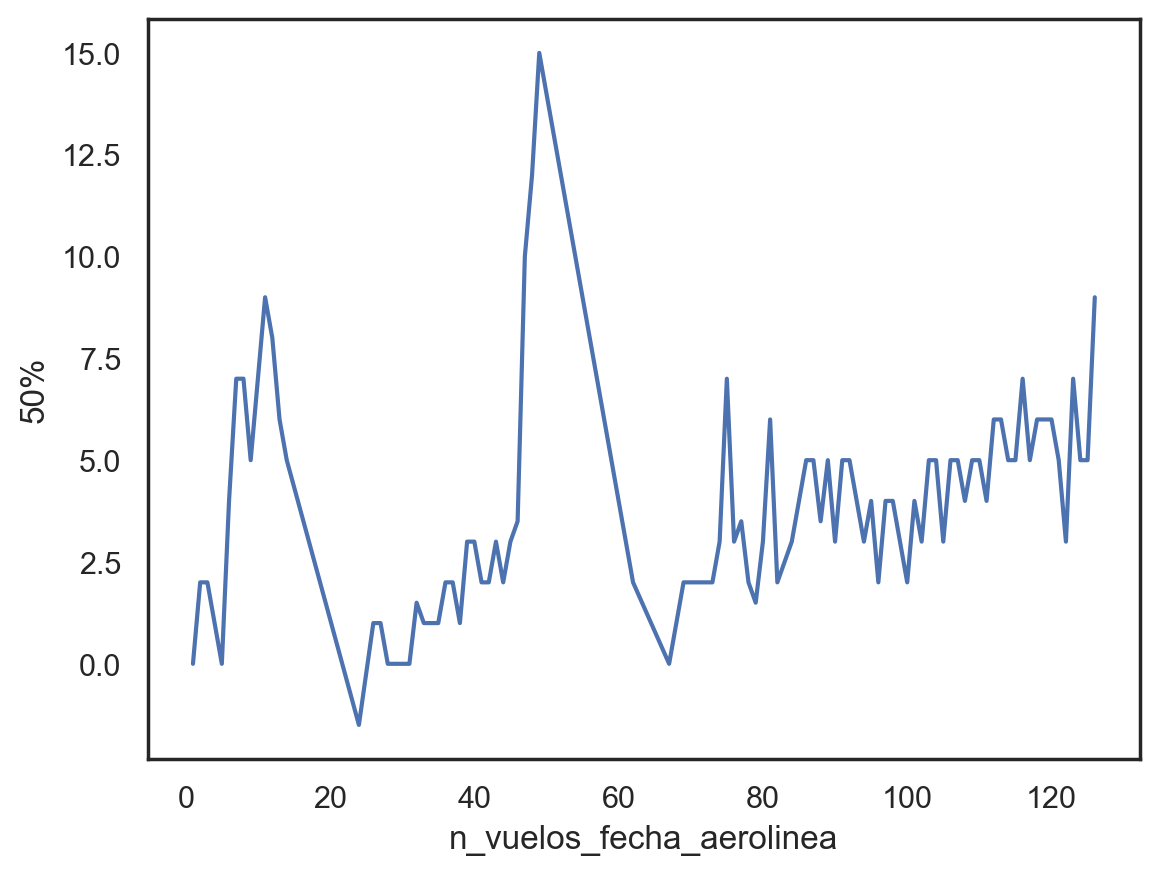

In [146]:
aux = df.groupby(['n_vuelos_fecha_aerolinea'])['dif_min'].describe().reset_index()
print(aux[['mean','50%','n_vuelos_fecha_aerolinea']].corr())
sns.lineplot(data=aux, x='n_vuelos_fecha_aerolinea', y='50%');

                              mean       75%  n_vuelos_fecha_aerolinea
mean                      1.000000  0.942114                  0.011991
75%                       0.942114  1.000000                 -0.046705
n_vuelos_fecha_aerolinea  0.011991 -0.046705                  1.000000


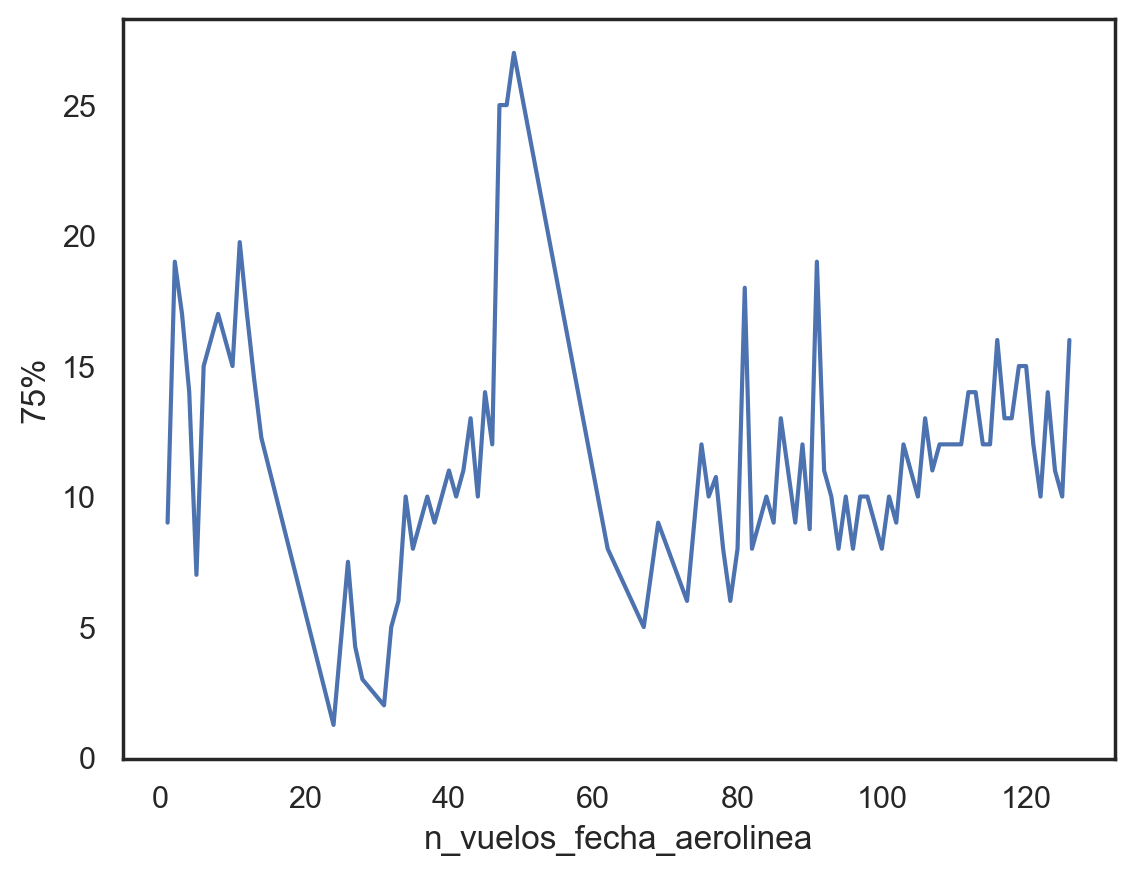

In [147]:
print(aux[['mean','75%','n_vuelos_fecha_aerolinea']].corr())
sns.lineplot(data=aux, x='n_vuelos_fecha_aerolinea', y='75%');

In [148]:
aux = df[df['n_vuelos_fecha_aerolinea']>20]
print("Del total de registros donde una aerolinea tiene 20 o más vuelos por día, ocurre que un " + str(round(100*aux[aux.dif_min>=60].shape[0]/aux.shape[0],0)) + "% de los vuelos tiene retrasos igual o mayor a 60 min, mientras que en la muestra completa la proporción de vuelos con ese nivel de atraso es de un " + str(str(round(100*df[df.dif_min>=60].shape[0]/df.shape[0],0))) + "%")

Del total de registros donde una aerolinea tiene 20 o más vuelos por día, ocurre que un 2.0% de los vuelos tiene retrasos igual o mayor a 60 min, mientras que en la muestra completa la proporción de vuelos con ese nivel de atraso es de un 3.0%


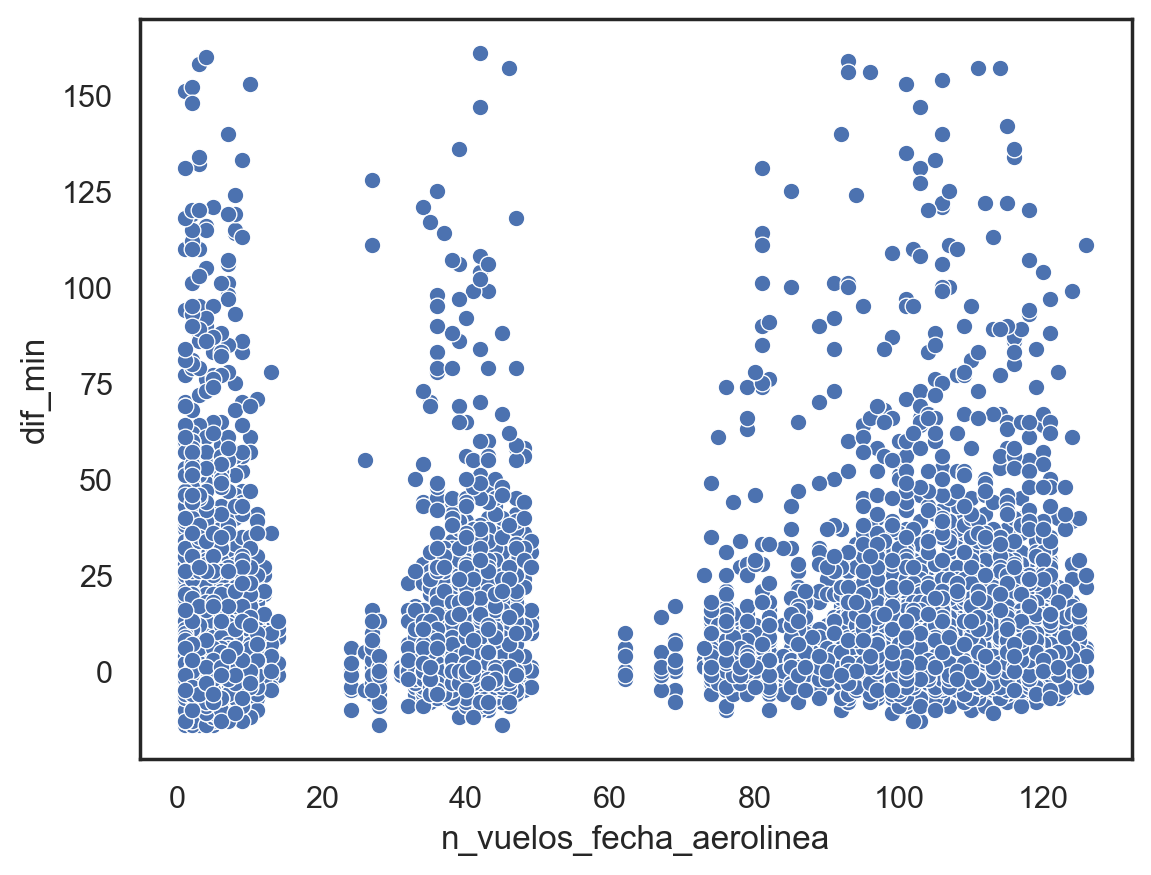

In [149]:
sns.scatterplot(data=df.sample(10000), x='n_vuelos_fecha_aerolinea', y='dif_min');

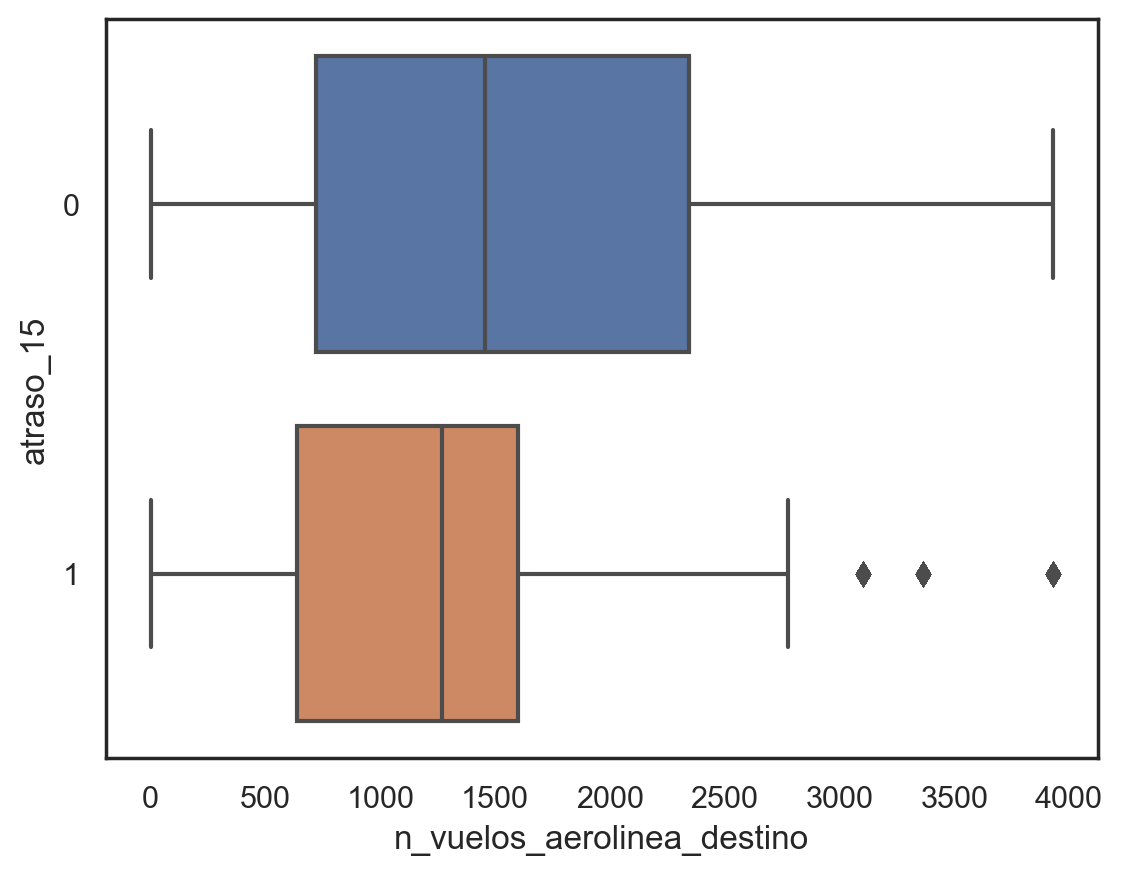

In [150]:
aux = df.groupby(['Emp-I','Des-I'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'n_vuelos_aerolinea_destino'}, inplace=True)
df = pd.merge(df, aux, on = ['Emp-I','Des-I'], how='left')
sns.boxplot(data=df, x= "n_vuelos_aerolinea_destino",y= "atraso_15", orient="h");

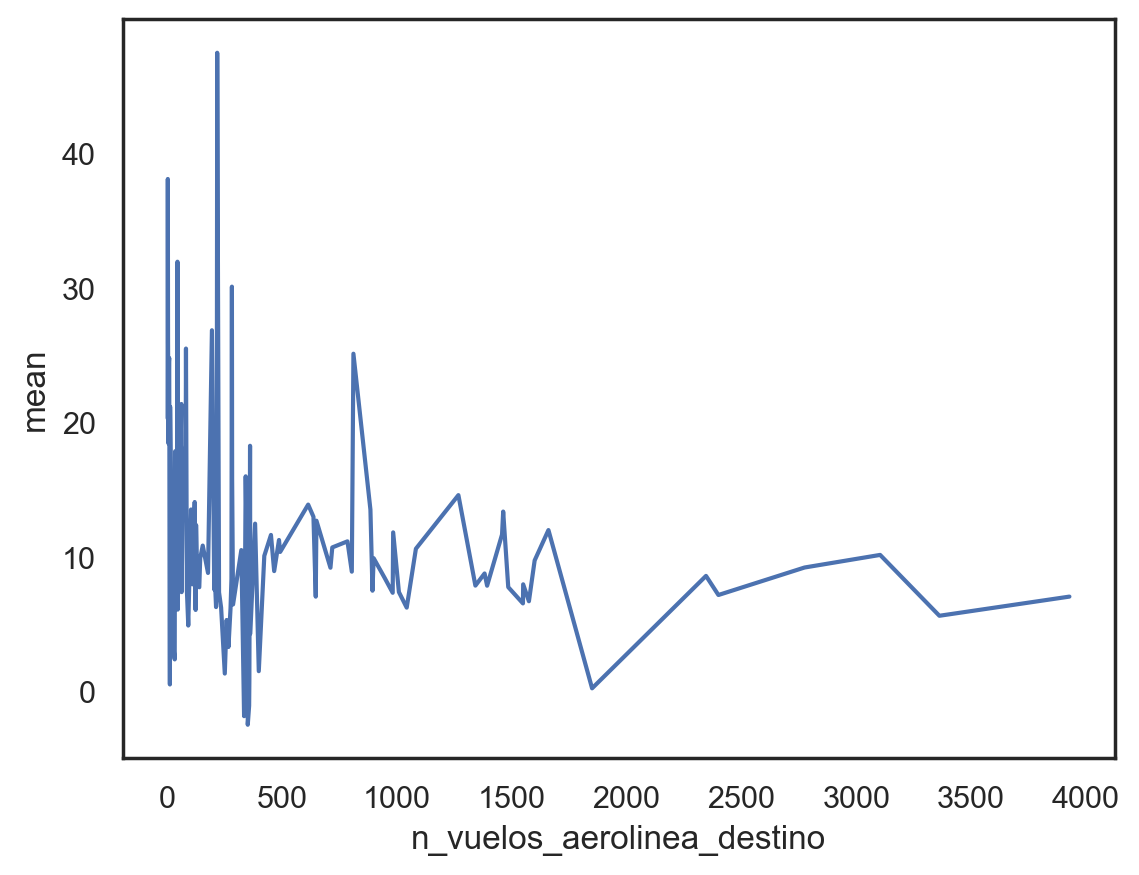

In [151]:
aux = df.groupby(['n_vuelos_aerolinea_destino'])['dif_min'].describe().reset_index()[1:]
sns.lineplot(data=aux, x='n_vuelos_aerolinea_destino', y='mean');

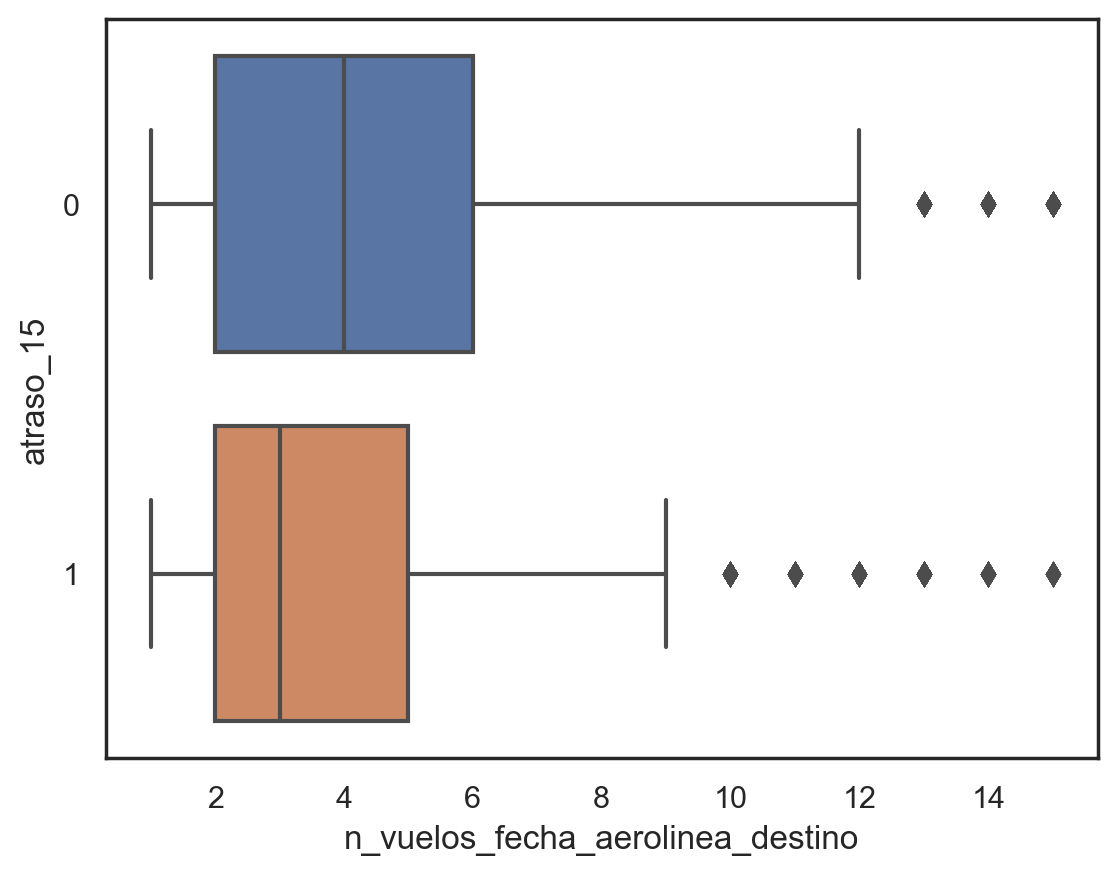

In [152]:
aux = df.groupby(['fecha_operacion','Emp-I','Des-I'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'n_vuelos_fecha_aerolinea_destino'}, inplace=True)
df = pd.merge(df, aux, on = ['fecha_operacion','Emp-I','Des-I'], how='left')
sns.boxplot(data=df, x= "n_vuelos_fecha_aerolinea_destino",y= "atraso_15", orient="h");

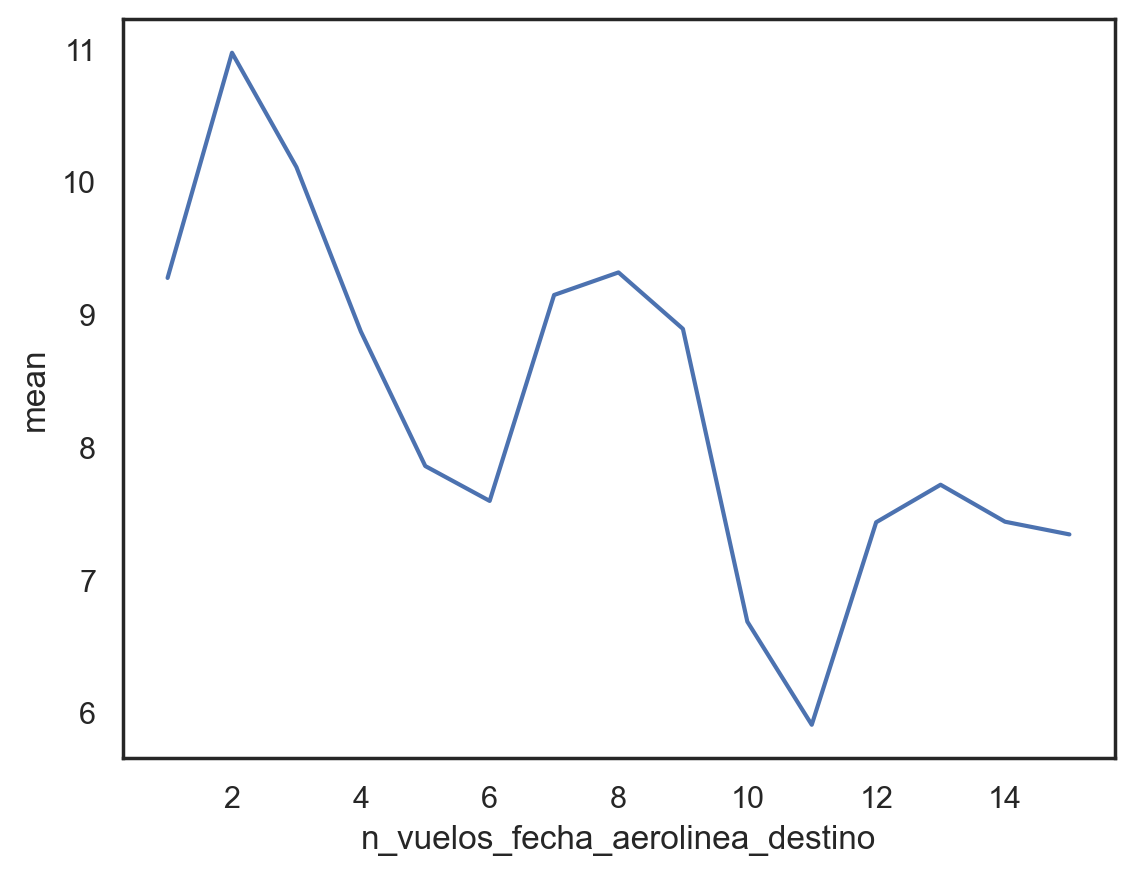

In [153]:
aux = df.groupby(['n_vuelos_fecha_aerolinea_destino'])['dif_min'].describe().reset_index()
sns.lineplot(data=aux, x='n_vuelos_fecha_aerolinea_destino', y='mean');

n_vuelos_fecha_aerolinea_destino   -0.941407
count                               1.000000
mean                                0.457216
std                                 0.813626
min                                -0.563682
25%                                -0.930357
50%                                -0.375783
75%                                 0.884212
max                                 0.526034
Name: count, dtype: float64


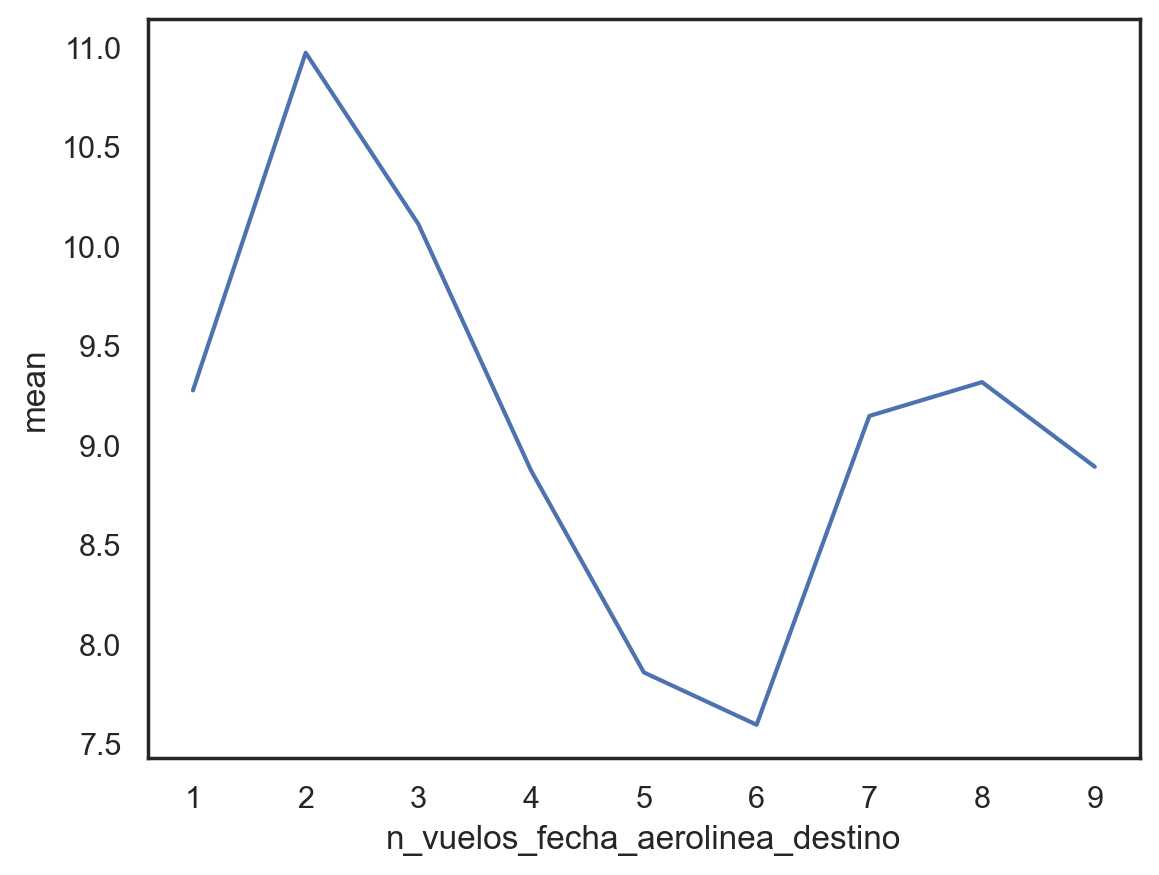

In [154]:
print(aux[0:9].corr()['count'])
sns.lineplot(data=aux[0:9], x='n_vuelos_fecha_aerolinea_destino', y='mean');

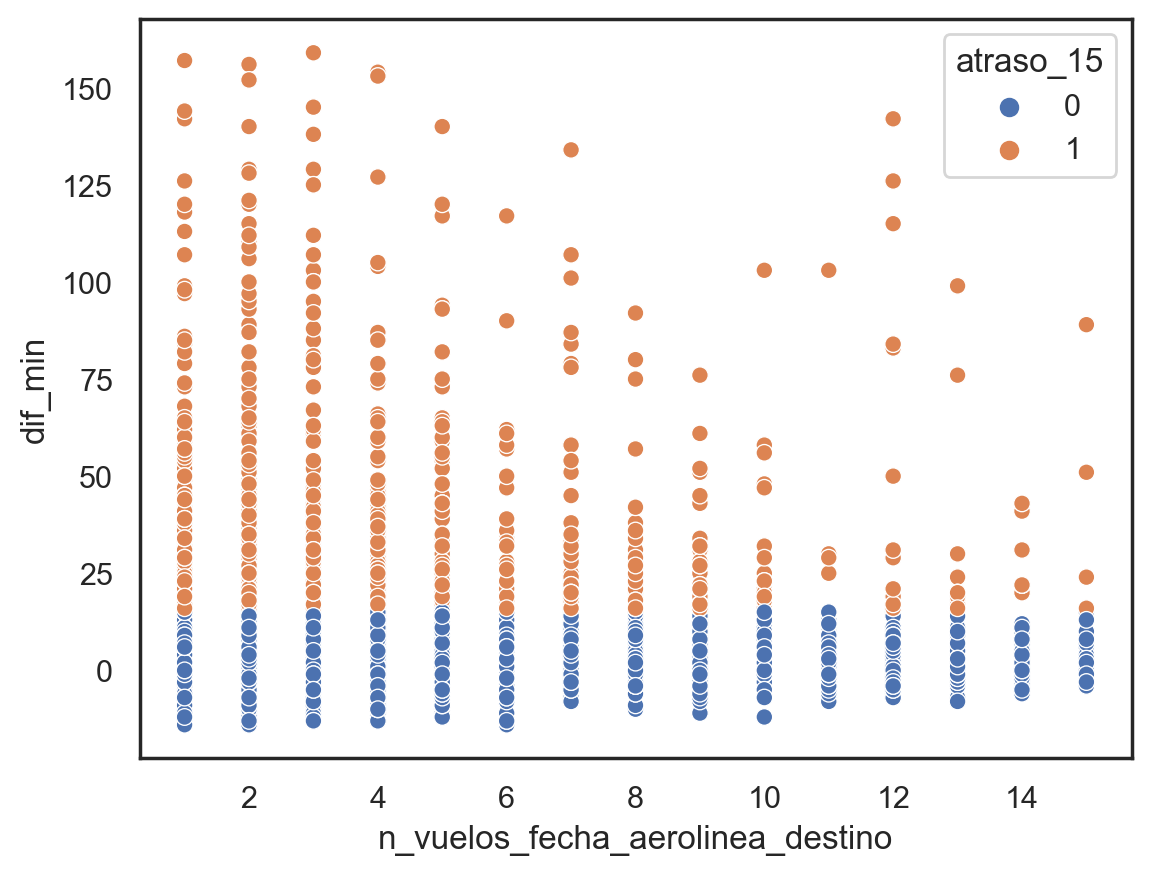

In [155]:
sns.scatterplot(data=df.sample(5000), x='n_vuelos_fecha_aerolinea_destino', y='dif_min',hue='atraso_15');

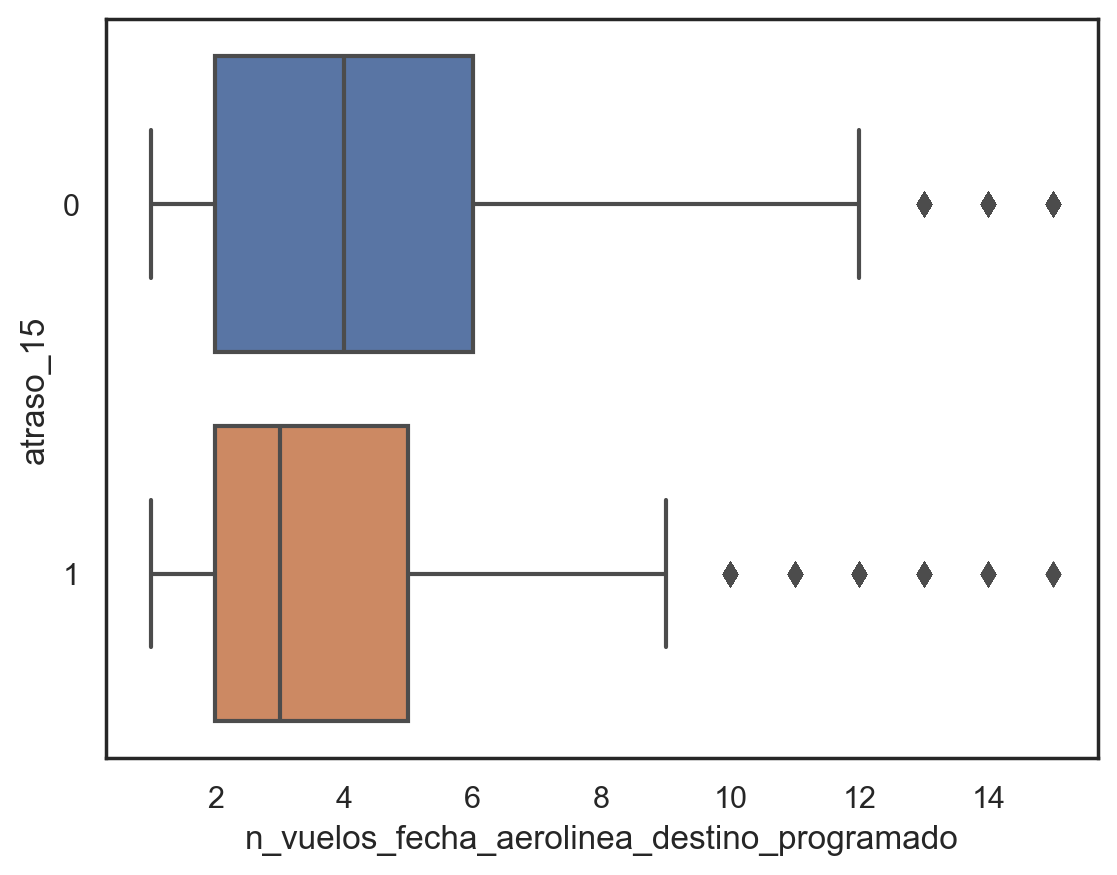

In [156]:
aux = df.groupby(['fecha_operacion','Emp-I','Des-I'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'n_vuelos_fecha_aerolinea_destino_programado'}, inplace=True)
df = pd.merge(df, aux, on = ['fecha_operacion','Emp-I','Des-I'], how='left')
sns.boxplot(data=df, x= "n_vuelos_fecha_aerolinea_destino_programado",y= "atraso_15", orient="h");

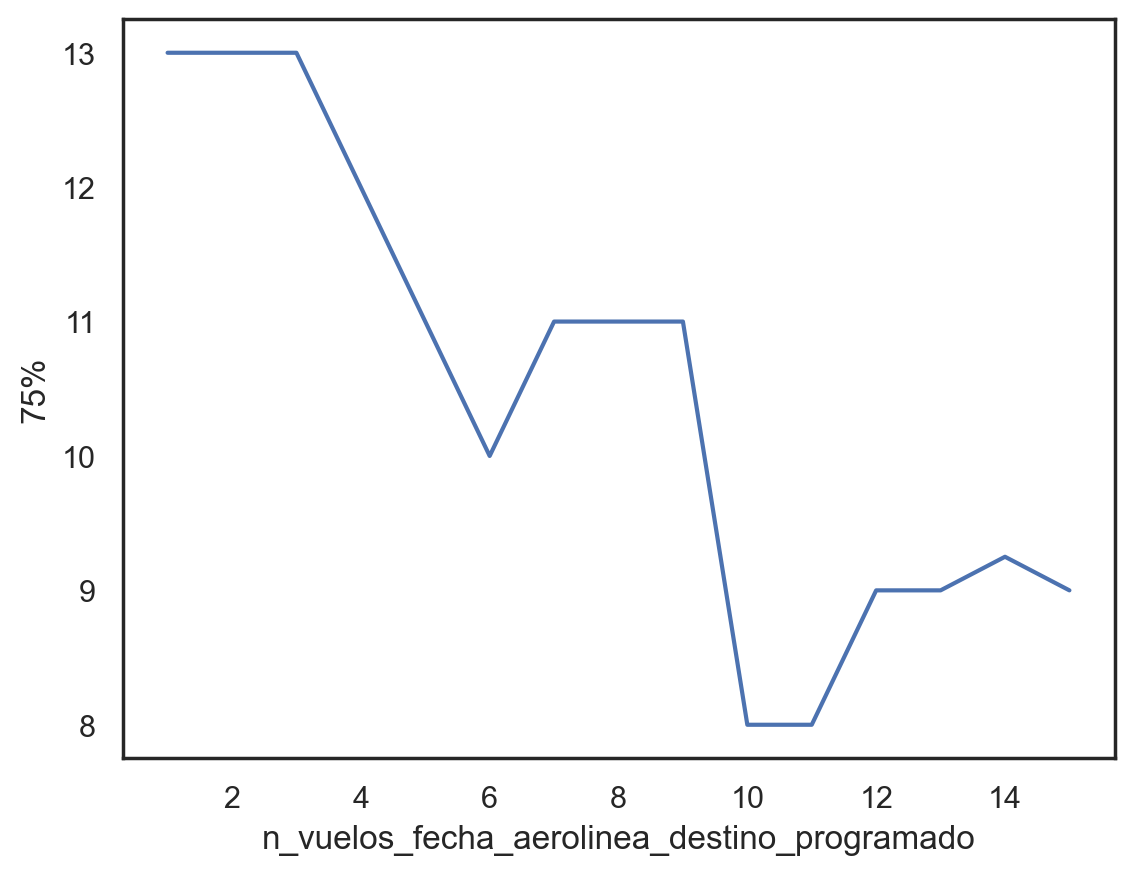

In [157]:
aux = df.groupby(['n_vuelos_fecha_aerolinea_destino_programado'])['dif_min'].describe().reset_index()
sns.lineplot(data=aux, x='n_vuelos_fecha_aerolinea_destino_programado', y='75%');

n_vuelos_fecha_aerolinea_destino_programado   -0.933717
count                                          1.000000
mean                                           0.719244
std                                            0.798984
min                                           -0.695728
25%                                           -0.450557
50%                                            0.432567
75%                                            0.900311
max                                            0.556516
Name: count, dtype: float64


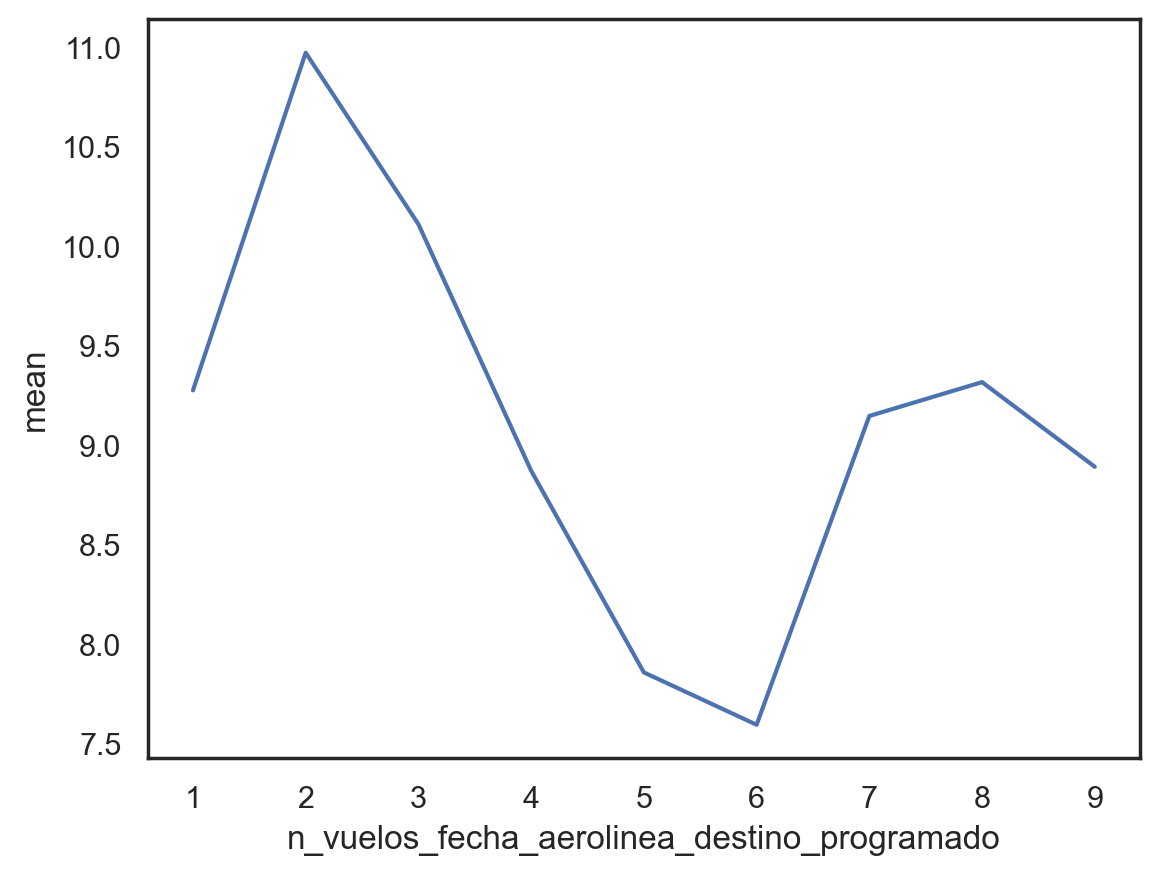

In [158]:
print(aux.corr()['count'])
sns.lineplot(data=aux[0:9], x='n_vuelos_fecha_aerolinea_destino_programado', y='mean');

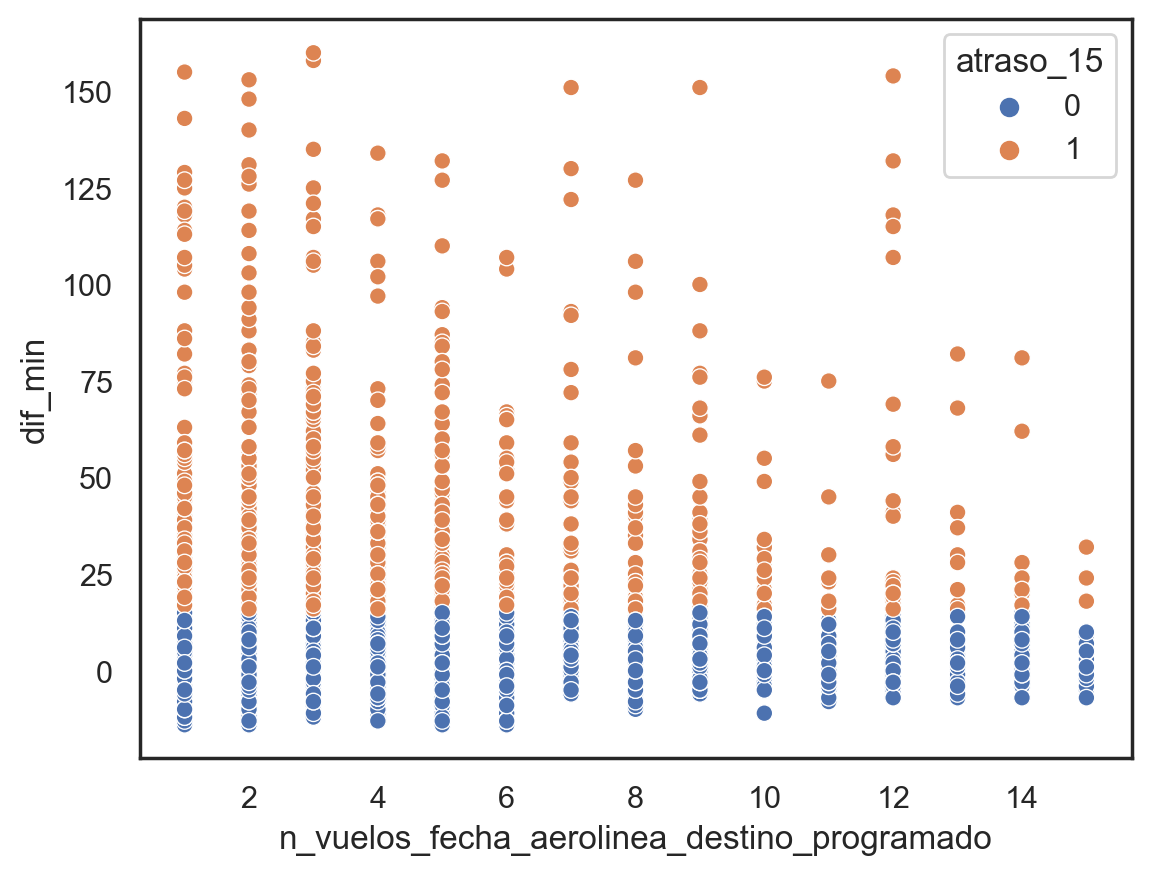

In [159]:
sns.scatterplot(data=df.sample(5000), x='n_vuelos_fecha_aerolinea_destino_programado', y='dif_min',hue='atraso_15');

                                             n_vuelos_fecha_aerolinea_destino_programado  \
n_vuelos_fecha_aerolinea_destino_programado                                     1.000000   
mean                                                                           -0.774689   

                                                 mean  
n_vuelos_fecha_aerolinea_destino_programado -0.774689  
mean                                         1.000000  


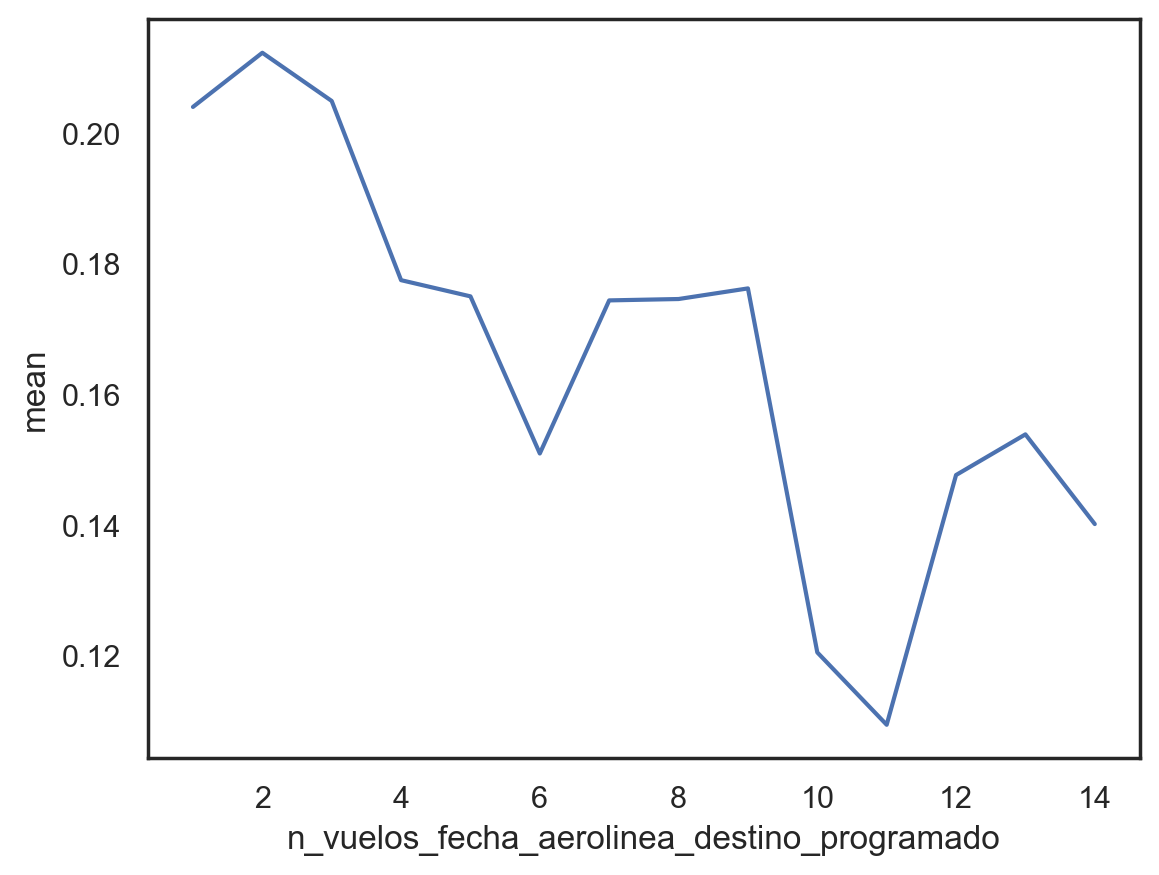

In [160]:
aux = df.groupby(['n_vuelos_fecha_aerolinea_destino_programado'])['atraso_15'].describe().reset_index().sort_values(by='count')
print(aux[['n_vuelos_fecha_aerolinea_destino_programado','mean']].corr())
sns.lineplot(data=aux[1:], x='n_vuelos_fecha_aerolinea_destino_programado', y='mean');

#### **Create a variable that gives us an idea of how much flight are departuring from the airport in chile that day** 

* we calculate the number of flights that will be operated that day in SCL

* As we can see, there si no lineal relation between this variable and the delay when you look it in the hole dataset. But, if we calculate the mean and percentiles by each number of flights by day, we can see a medium correlation (0.42 measure by pearson coefficient) with the mean of delay and the 50% percentile. 

* As we can see on the lineplot above, the curve has a low pendiente but when the number of flights exceeed 200 starts to jump faster. This is the kind of thing that is hard to get if you don't make double click on it.

* As we can see on the correlation table, the number of flights that will be operated that day in SCL has a medium correlation with the high season variable and the number of flights by day of the week or month of the year. This is another good argument to replace the high season variable. 

* Also, makes more sence in terms of the business to keep the number of flights that will be operated that day in SCL (NFSL) than a historical value of total flights by day of the week or month of the year, which has to be calculated and updated every day instead of NFSL that could be given by the airport or extracted from Sabre / Amadeus. Also is NFSL probably is the root case of a good part of the other two

------------------------------------------------------------------------------------------------------------------------------------------------------------------

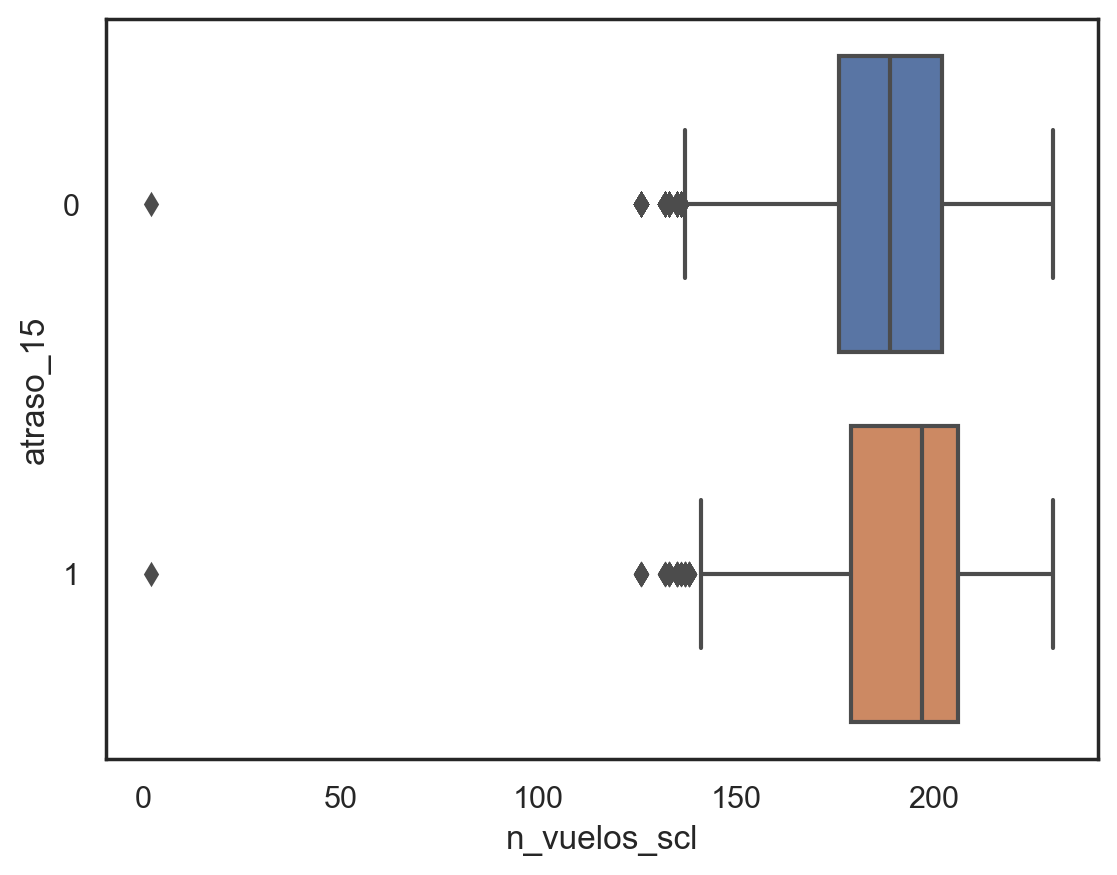

In [161]:
aux = df.groupby(['fecha_operacion'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
aux.rename(columns={'Ori-I':'n_vuelos_scl'}, inplace=True)
df = pd.merge(df, aux, on = ['fecha_operacion'], how='left')
sns.boxplot(data=df, x= "n_vuelos_scl",y= "atraso_15", orient="h");

              n_vuelos_scl     mean       50%
n_vuelos_scl      1.000000  0.42480  0.462689
mean              0.424800  1.00000  0.971110
50%               0.462689  0.97111  1.000000


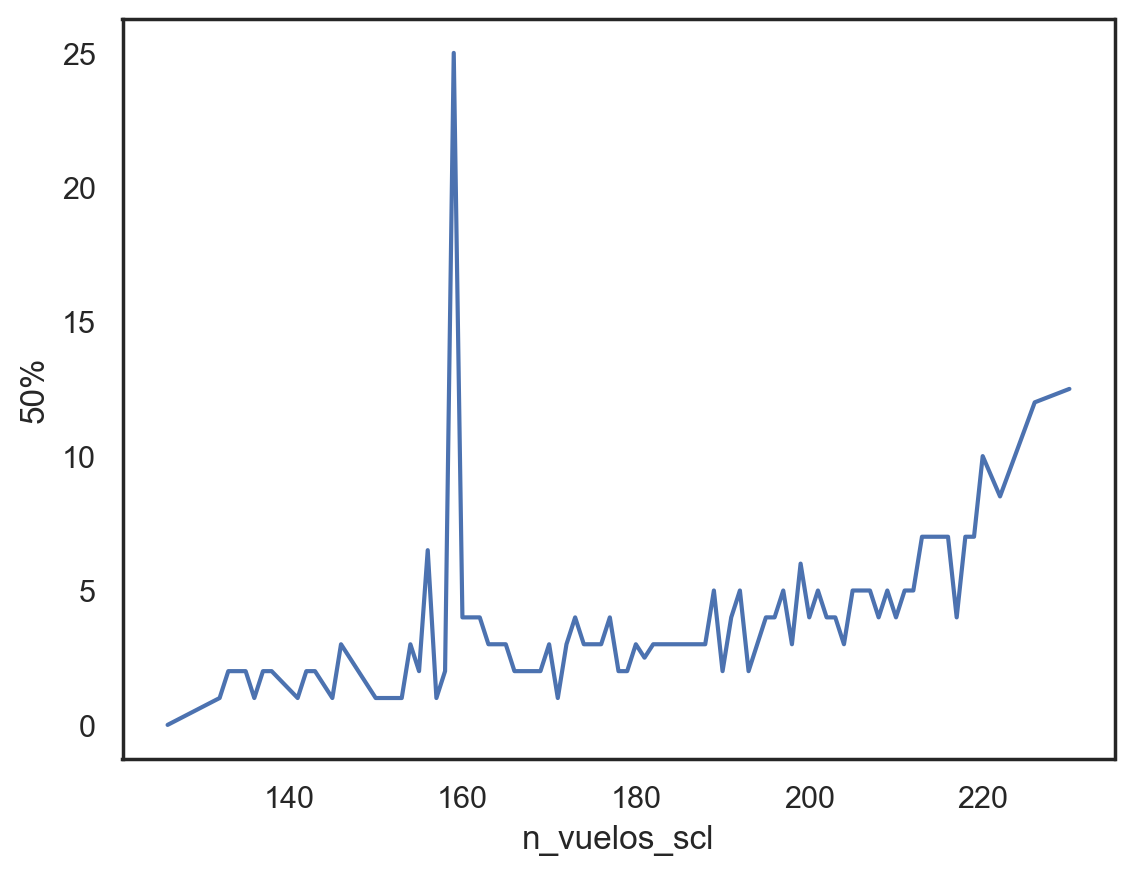

In [162]:
aux = df.groupby(['n_vuelos_scl'])['dif_min'].describe().reset_index()[1:]
print(aux[['n_vuelos_scl','mean','50%']].corr())
sns.lineplot(data=aux, x='n_vuelos_scl', y='50%');

count    84.000000
mean     11.979167
std       7.385696
min       4.000000
25%       8.937500
50%      10.000000
75%      13.250000
max      68.000000
Name: 75%, dtype: float64


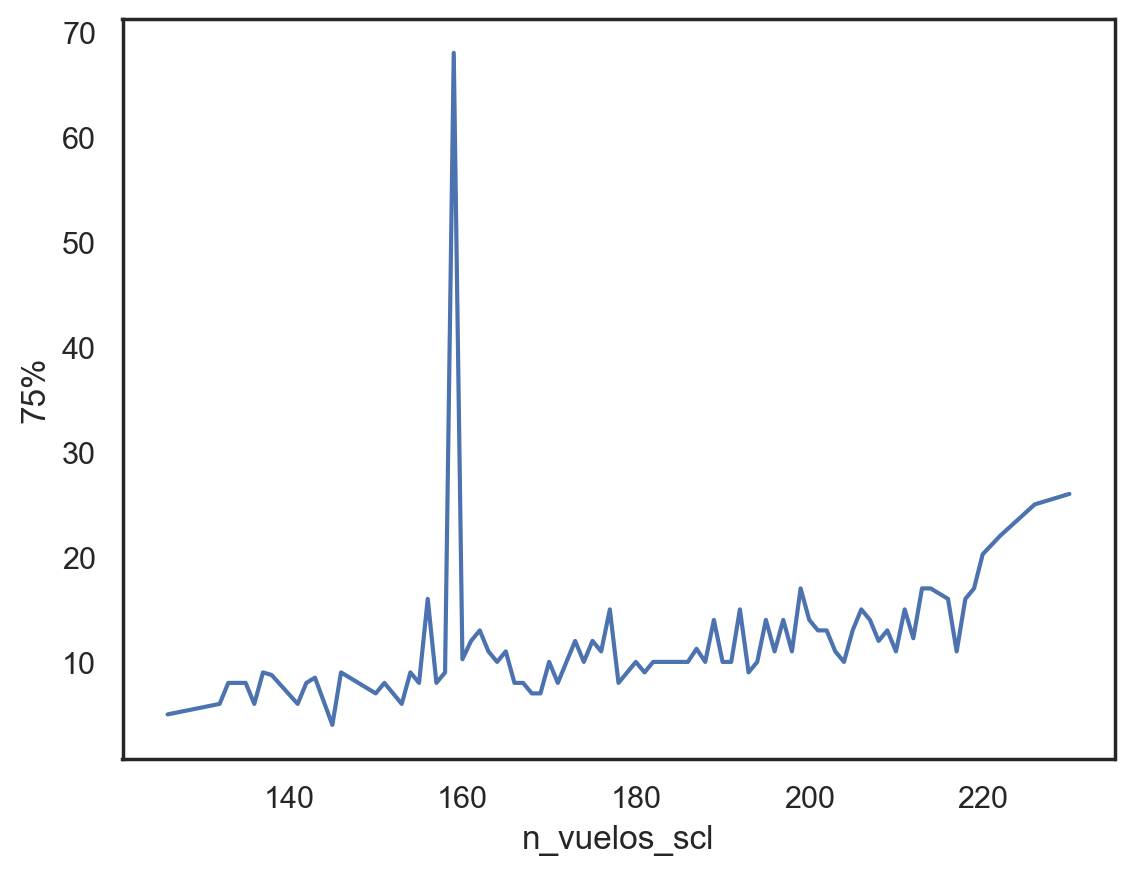

In [163]:
print(aux['75%'].describe())
sns.lineplot(data=aux, x='n_vuelos_scl', y='75%');

count    84.000000
mean      9.071460
std       4.845249
min       1.324138
25%       6.467182
50%       8.198224
75%      10.523601
max      40.660377
Name: mean, dtype: float64


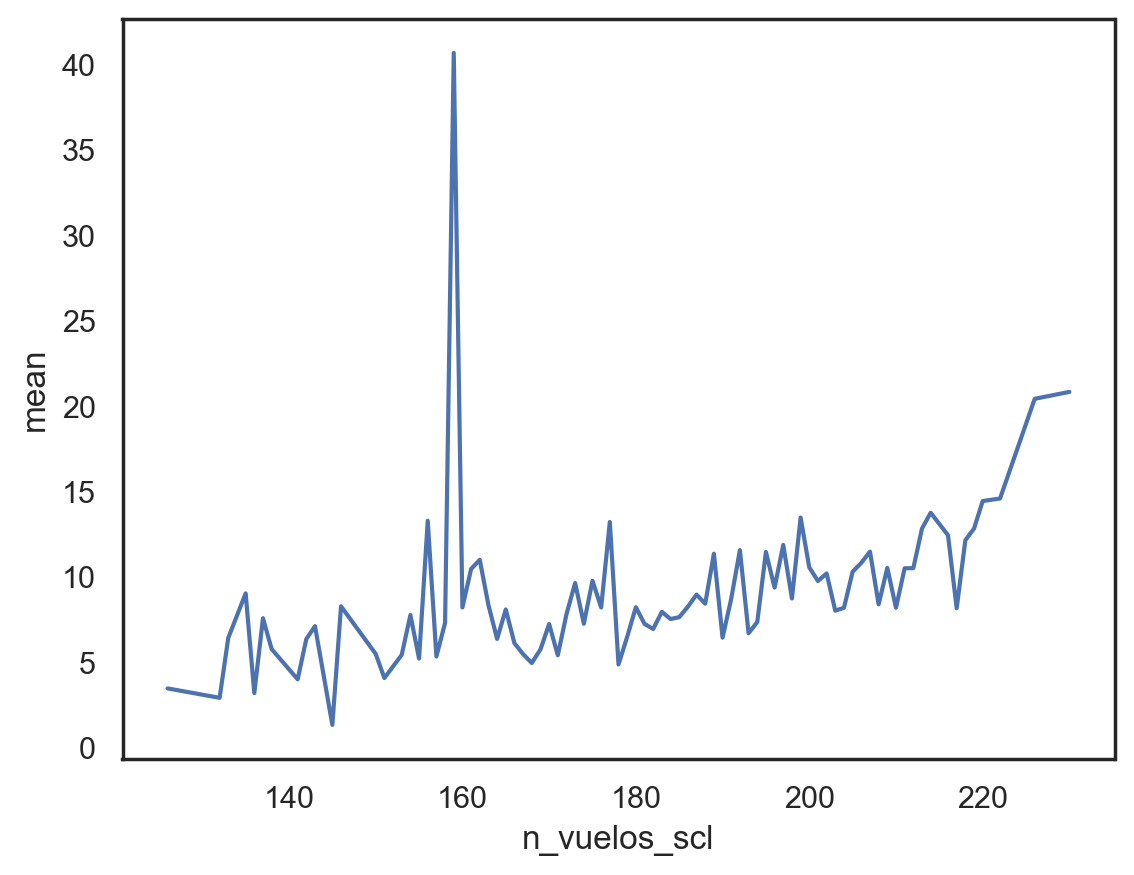

In [164]:
print(aux['mean'].describe())
sns.lineplot(data=aux, x='n_vuelos_scl', y='mean');

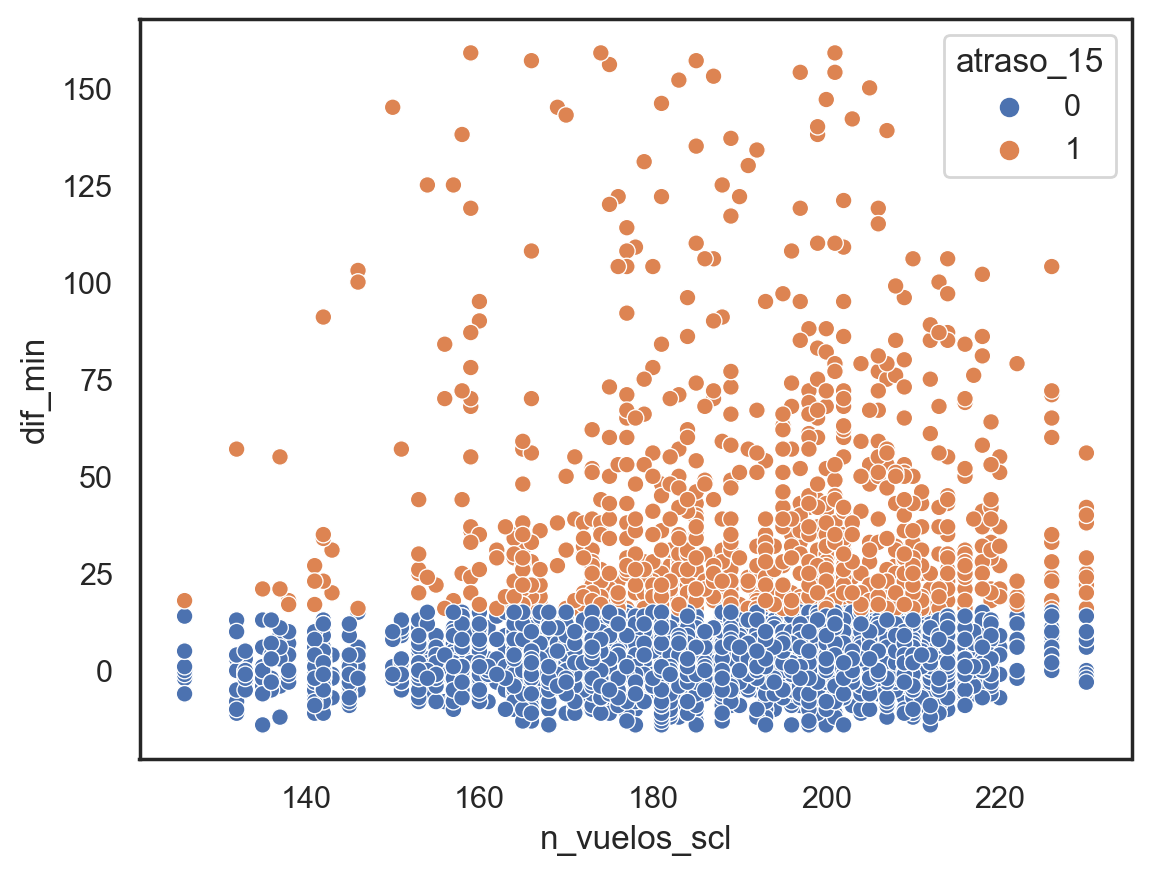

In [165]:
sns.scatterplot(data=df.sample(5000), x='n_vuelos_scl', y='dif_min',hue='atraso_15');

              n_vuelos_scl      mean
n_vuelos_scl      1.000000  0.195666
mean              0.195666  1.000000


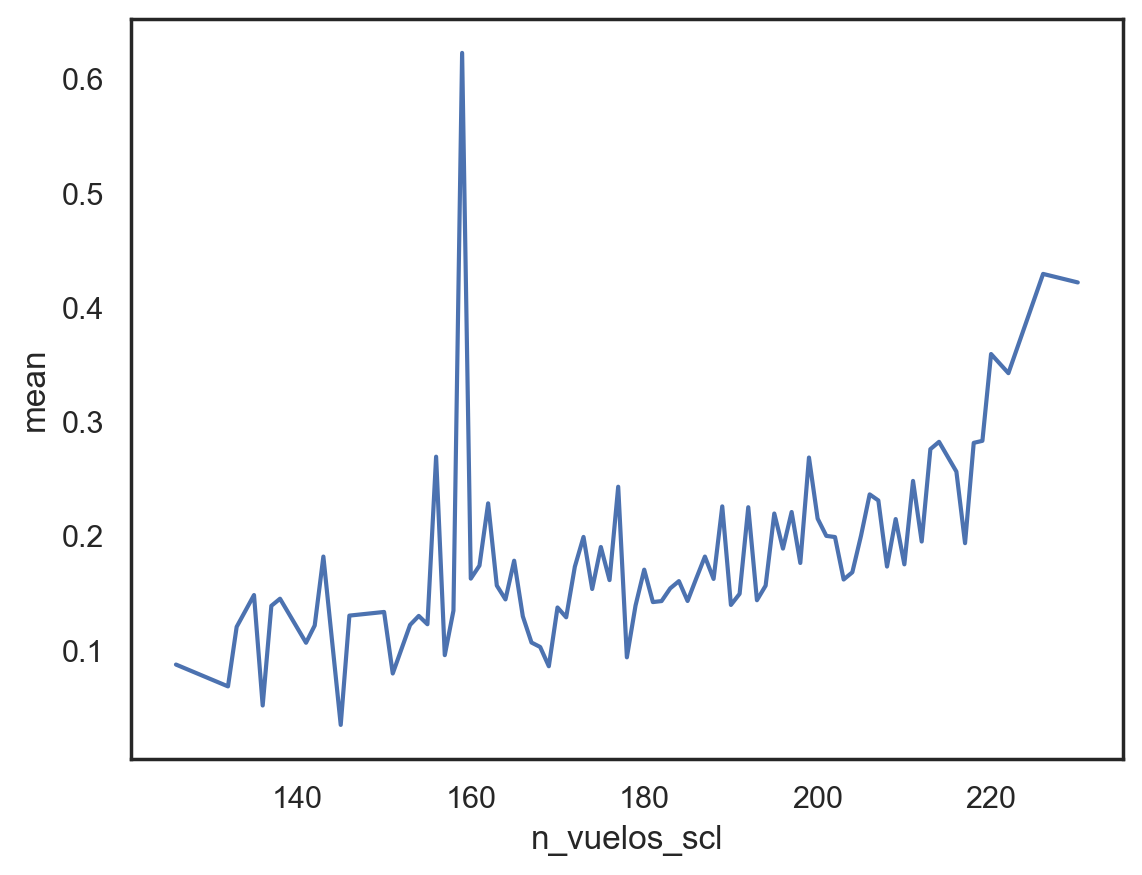

In [166]:
aux = df.groupby(['n_vuelos_scl'])['atraso_15'].describe().reset_index().sort_values(by='count')
print(aux[['n_vuelos_scl','mean']].corr())
sns.lineplot(data=aux[1:], x='n_vuelos_scl', y='mean');

In [167]:
df.corr()['n_vuelos_scl']

DIA                                            0.000601
MES                                            0.281563
AÑO                                           -0.053298
dif_min                                        0.082686
atraso_15                                      0.092144
temporada_alta                                 0.582188
distance_to_destiny                           -0.043393
n_vuelos_mes                                   0.635342
n_vuelos_diasem                                0.583956
n_vuelos_diames                                0.064005
n_vuelos_destino                               0.182353
n_vuelos_fecha_aerolinea                       0.158759
n_vuelos_aerolinea_destino                     0.003379
n_vuelos_fecha_aerolinea_destino               0.124438
n_vuelos_fecha_aerolinea_destino_programado    0.124438
n_vuelos_scl                                   1.000000
Name: n_vuelos_scl, dtype: float64

#### **Create some variables with the day of the month, month of the year and day of the week** 

* We have already created a variable for the date of operation to make some grouping but now we show that 

* Since these variables are probably correlated, since if there are months with bad weather it will directly affect the delays on days of the week and on days of the month. Same with delays on specific days of the month to days of the week.

* As we can see in the examples showed here, we can see a prevalance of delays near some important holidays like Christhmas, New year, Halloween , Independence day (18-09) and winter holidays. This will affect the variable days of the month and the day of the week variable for sure. For that reason, we are going to prefer models that use trees,so the model can take care of the important combinations. Also, we don't want to increase the complexity of the model adding a feature that will increase the number of dummies in the model datasets and if we join this variable we will be in serious risk to make overfitting, since some of the factors that affects the delay like weather, holidays and crowd in the airports doesn't follow the same pattern every year necessarly

* However, for future work it will be a a good feature to put a binary variable to show if that day is a near or in a holiday or not. How much near before and how much near after is something that we leave for the next delivery

------------------------------------------------------------------------------------------------------------------------------------------------------------------

0.31607629427792916
0.16893732970027248
0.09264305177111716


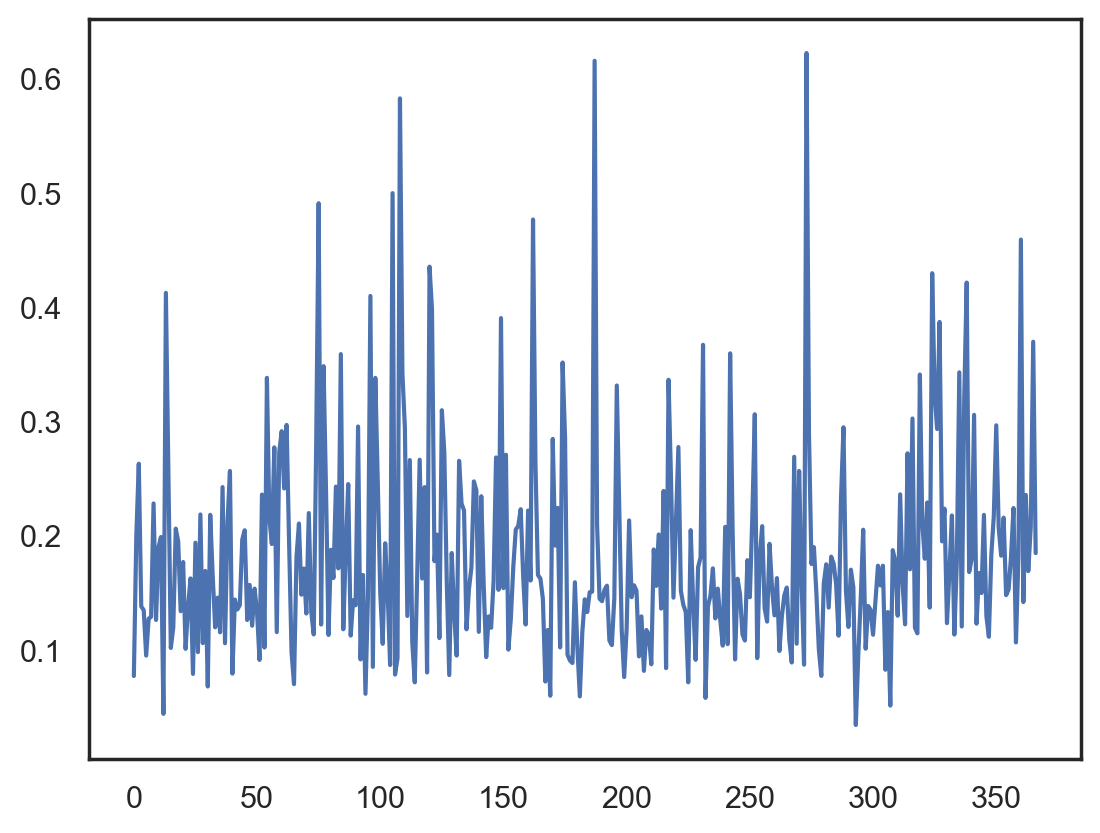

In [168]:
aux1 = df.DIA.apply(lambda x: str(x))
aux2 = df.MES.apply(lambda x: str(x))
df['tipo_dia'] = df.DIANOM + '-' + aux1 + '-' +aux2
aux = pd.crosstab(df.tipo_dia,df.atraso_15, margins=True,normalize='index').reset_index()
print(aux[aux[1]>=0.20].shape[0]/aux.shape[0])
print(aux[aux[1]>=0.25].shape[0]/aux.shape[0])
print(aux[aux[1]>=0.30].shape[0]/aux.shape[0])
aux[1].plot();

In [169]:
aux[aux[1]>=0.3].head(40).sort_values(by=1, ascending =  False)

atraso_15        tipo_dia         0         1
273           Sabado-15-7  0.377358  0.622642
187           Martes-25-7  0.384181  0.615819
108            Lunes-10-7  0.417085  0.582915
105             Lunes-1-1  0.500000  0.500000
75           Jueves-21-12  0.508850  0.491150
..                    ...       ...       ...
337          Viernes-21-7  0.680751  0.319249
125            Lunes-2-10  0.690000  0.310000
252        Miercoles-4-10  0.693548  0.306452
341         Viernes-24-11  0.694064  0.305936
316         Viernes-10-11  0.697248  0.302752

[34 rows x 3 columns]

In [170]:
df['fecha'] = aux1 + '-' +aux2
aux = pd.crosstab(df.fecha,df.atraso_15, margins=True,normalize='index').reset_index()
aux[aux.fecha=='22-12']

atraso_15  fecha         0         1
171        22-12  0.578261  0.421739

In [171]:
aux[aux.fecha=='21-12']

atraso_15  fecha        0        1
159        21-12  0.50885  0.49115

In [172]:
aux[aux.fecha=='29-12']

atraso_15  fecha         0         1
255        29-12  0.703196  0.296804

In [173]:
aux[aux.fecha=='14-7']

atraso_15 fecha         0         1
69         14-7  0.570093  0.429907

In [174]:
aux[aux.fecha=='15-7']

atraso_15 fecha         0         1
81         15-7  0.377358  0.622642

In [175]:
aux[aux.fecha=='11-9']

atraso_15 fecha         0         1
35         11-9  0.705584  0.294416

In [176]:
aux[aux.fecha=='25-10']

atraso_15  fecha         0         1
205        25-10  0.792079  0.207921

In [177]:
aux[aux.fecha=='25-10']

atraso_15  fecha         0         1
205        25-10  0.792079  0.207921

In [178]:
aux[aux.fecha=='11-9']

atraso_15 fecha         0         1
35         11-9  0.705584  0.294416

## **Why we should drop this variables?**

* Flight number schedudeled and operated
* Codes and names of the country, city or airport of origin
* Name of the city of destiny and codes of the city scheduled
* Date of flytght scheduled and operated
* Year of the operation
* Day of the month of the operation 
* Distance between origin and destiny (already explained above)
* High season (already explained above)

You can check the why if you open the cells above


**Codes or names of the country, city or airport of origin**

Because all the flights are scheduled and departure from the same city with code SCEL, which correspond to Santiago De Chile. Which means, all the flights departure from Aeropuerto Arturo Merino Benitez. We are only going to use the number of flight that are estimated to departure that day from SCL, since it gives us an idea of how crowded the airport will be.

In [179]:
df["Ori-I"].unique()

array(['SCEL'], dtype=object)

In [180]:
df["Ori-O"].unique()

array(['SCEL'], dtype=object)

**Flight number scheduled and operated**

since the complete flight number contains information about the route plus the airline code (source: <https://www.nlarenas.com/2020/06/como-se-define-el-numero-de-un-vuelo/> ), we think is rebundant to use it since we already have the code for the airlines and origin-destiny. Also, this way we will prevent to use flight numbers that are no longer in use by the airlines.

**Name of the city of destiny and code of the city scheduled**

Since we already have the code for the city of destiny, we are going to use only this one because is the actual route that the flight tooked and all the information of the environmental components (how good is the airport, weather, etc) should be linked to the operated route

**Date of flytght scheduled and operated**

Since we already had created variables which together can replicate this dates (day of month + month of the year), it will be no longer needed to use this ones

**year of the operation**

Because 99% the database is for only one year: 2017, so it does not add information

In [181]:
df[df["AÑO"] == 2017].shape[0]/df.shape[0]

0.9999706770665338

**Day of the month of the operation**

The day of the week of the operation is affected by another external events that doesn't happend always in the same day of the month like winter and summer vacations, holidays, preference of the people for travel in a given day of the week or weekend, etc. Since that random effect can't be replacated for the next years and we don't have the data to aislate the externals effect, we will drop this variable in order to dont' introduce noise on the models. 

## **Selected variables**

Base on the EDA this are the pre-selected variables that we may use in the modeling section

**Explanatory variables**

Original from the dataset

* Type of flight (international or national)
* Moment of the day where the flyght happens (2)
* Code for the airline who schedulled the flight  (2)
* Code for the city of the destiny of the flight (1)  (2)
* Day of the week of the operation (1) 
* Month of the year of operation (1)

Created by me:

* Binary variable that will represent if there was a change in the flight number scheduled
* Number of flights for date  - airline code (2)
* Number of flights for date  - airline code - destiny code (2)
* Number of flights for that day in SCL (2)
* Combination of code of the airline with flight number (2) and will only be used with outlier treatment

(1) **it's not going out yet, but could be replace for the number of flights by the number of flights variables that was created**


(2) **could be scheduled or operated, depending on your window of prediction, but we will use schedulled for this POC**

**Target variable for clasification** --> Binary of delay for more than 15 min

**Target variable for regression** --> difference in minutes of delay 

## **Data cleaning and Feature Engineer**

On this section we are going to create a pipeline that will:

* Delete the variables with dataframe that comes from the EDA
* Create some variables that's going to be useful
* Clean the all the variables that we are not going to use 
* Scale the numerical data and transform the categorical variables with One hot encode
* Extract outliers in two papelines
* Apply oversampling in two papelines
* Apply MCA in one pipeline

In order to predict the probability of delay we created 4 different pipelines to transform the data:

1.- For the first (preprocessing_ohe) we used the following variables: *Des-I*, *Emp-I*, *TIPOVUELO*, *periodo_dia*, *DIANOM*, *MES*, *NVuelos-Ori-I*, *Nvuelos-Fecha-Emp-I* and *Nvuelos-Fecha-Emp-Des-I* . Then, we scaled the numerical and then applied One hot encoding to the categoricals.

2.- In the second pipeline (preprocessing_ohe_oversampling) we used the same process than before but a random oversampling was applied at the end only in the train data

3.- In the third pipeline (preprocessing_ohe_outlier) we used the almost the same variables as before, but we change *Emp-Vlo-I* instead of *DES-I* because we want to understand if the influence of the flight number was bigger than the influence of the airline alone. In order to do this properly, we deleted 121 combinations of *Emp-Vlo-I* that has only one flight in the all year. Then, we scaled the numerical and then applied One hot encoding to the categoricals.

4.- In the fourth pipeline (preprocessing_ohe_outlier_oversampling) we used the same process than the third but a random oversampling was applied at the end only in the train data

5.- In the Fifth pipeline (preprocessing_mca) we apply a variable reduction technique designed to deal with categorical variables call MCA. We measured how much of the variance is aible to explain and since it was low, we decided to don't use it to train models. 
                                                                                                                                                 
**Since we want to present the main result, we are going to present only the results for only the first , fourth pipeline and fifth pipeline, since their where the ones with the best performance overall as you are going to see next on the training and test evaluation.**


**To be sure that we are going to use the right data, we will always start from a saved dataset and will save the intermediate results that will be used on for modeling**

In [182]:
del df
del aux

### First pipeline (preprocessing_ohe)

This pipeline is the simplier, the idea was to have a baseline model to start. 

In [183]:
# Loading the joined dataset between flights and Airport database
path = os.getcwd() + '/data/processed/database.csv'
df = pd.read_csv(path, sep=',')
df = create_variables(data = df)
col_to_drop = ['Fecha-O','Fecha-I','fecha_operacion','DIA','AÑO','Vlo-I','Vlo-O','Ori-O','Ori-I','Des-O','OPERA','Emp-O',
               'IATA Code','Airport Name','Country','City/Town','ICAO Code','SIGLADES','SIGLAORI','Lat','Long','distance_to_destiny',
               'temporada_alta','NVuelos-Ori-O','Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O','Emp-Vlo-O','Emp-Vlo-I','dif_min',
               ]
df.drop(columns=col_to_drop, inplace = True)
X = df.copy()
y = X.atraso_15
X.drop('atraso_15', axis=1, inplace=True)
get_na(X)

datos sin NAs en q  Na en q  Na en %
Des-I                                 68206        0      0.0
Emp-I                                 68206        0      0.0
MES                                   68206        0      0.0
DIANOM                                68206        0      0.0
TIPOVUELO                             68206        0      0.0
periodo_dia                           68206        0      0.0
NVuelos-Ori-I                         68206        0      0.0
Nvuelos-Fecha-Emp-I                   68206        0      0.0
Nvuelos-Fecha-Emp-Des-I               68206        0      0.0
Vlo-I_cambio                          68206        0      0.0

Información del dataset:
 las clases del target son: Counter({0: 38914, 1: 8830})


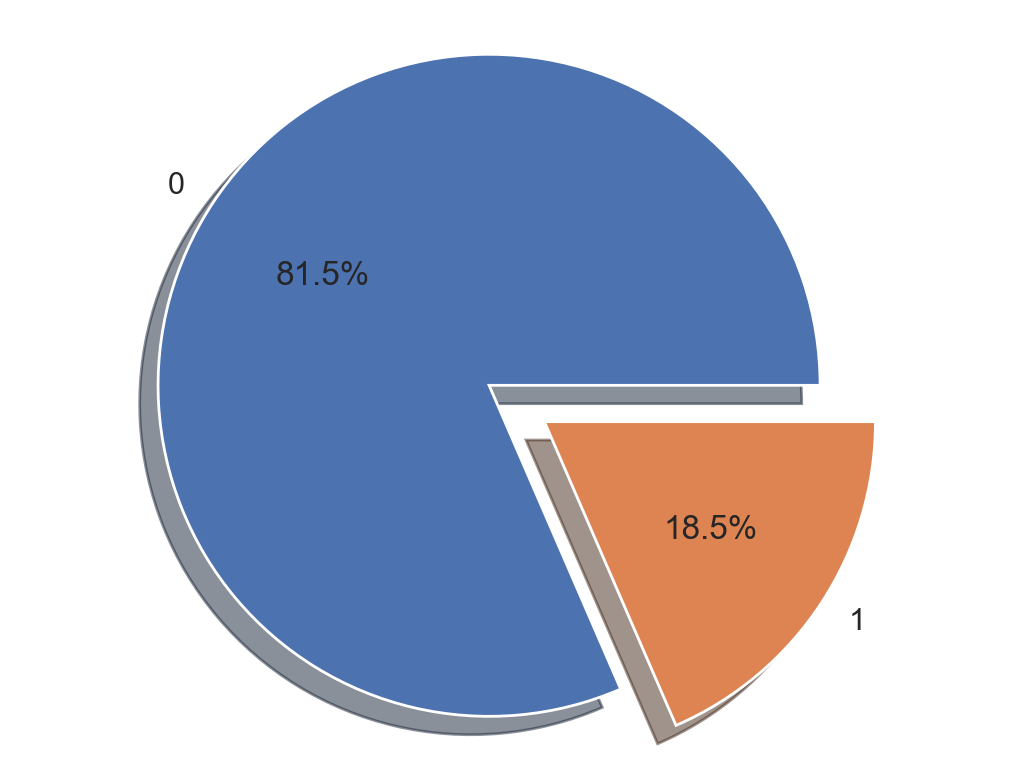

In [184]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=100)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

In [185]:
scaler = MinMaxScaler()
X_train.loc[:,['NVuelos-Ori-I','Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I']] = scaler .fit_transform(X_train[['NVuelos-Ori-I',
                                                                                                                  'Nvuelos-Fecha-Emp-I',
                                                                                                                  'Nvuelos-Fecha-Emp-Des-I']])
X_test.loc[:,['NVuelos-Ori-I','Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I']] = scaler.transform(X_test[['NVuelos-Ori-I',
                                                                                                           'Nvuelos-Fecha-Emp-I',
                                                                                                           'Nvuelos-Fecha-Emp-Des-I']])

transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first',sparse=False,handle_unknown='infrequent_if_exist'), ['Des-I','Emp-I','TIPOVUELO','periodo_dia','DIANOM','MES']),remainder='passthrough'
)

transformed = transformer.fit_transform(X_train)
transformed_x_train = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)
transformed = transformer.transform(X_test)
transformed_x_test = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)
transformed_x_test.head()

onehotencoder__x0_EGLL  onehotencoder__x0_EGYP  onehotencoder__x0_KATL  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   onehotencoder__x0_KDFW  onehotencoder__x0_KIAH  onehotencoder__x0_KJFK  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   onehotencoder__x0_KLAX  onehotencoder__x0_KMCO  onehotencoder__x0_KMIA  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   onehotencoder__x0_LEMD  ...  onehotencoder__x5_7  onehotencoder__x5_8  \
0                     0.0  ...                  0.0                  0.0   
1                     0.0  ...                  0.0                  0.0   
2                     0.0  ...                  0.0                  0.0   
3                     0.0  ...                  0.0                  1.0   
4                     0.0  ...                  0.0                  0.0   

   onehotencoder__x5_9  onehotencoder__x5_10  onehotencoder__x5_11  \
0                  0.0                   1.0                   0.0   
1                  0.0                   0.0                   0.0   
2                  0.0                   0.0                   0.0   
3                  0.0                   0.0                   0.0   
4                  0.0                   0.0                   0.0   

   onehotencoder__x5_12  NVuelos-Ori-I  Nvuelos-Fecha-Emp-I  \
0                   0.0       0.711538                0.016   
1                   0.0       0.461538                0.048   
2                   0.0       0.557692                0.848   
3                   0.0       0.519231                0.784   
4                   0.0       0.798077                0.344   

   Nvuelos-Fecha-Emp-Des-I  Vlo-I_cambio  
0                 0.071429           0.0  
1                 0.214286           0.0  
2                 0.571429           0.0  
3                 0.714286           0.0  
4                 0.071429           0.0  

[5 rows x 115 columns]

In [186]:
path = os.getcwd() + '/data/interim/model_data_train_ohe.csv' 
transformed_x_train.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/model_data_test_ohe.csv' 
transformed_x_test.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/y_train_ohe.csv' 
y_train.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/y_test_ohe.csv' 
y_test.to_csv(path,
          sep=',',
          index = False
         )

### 4th pipeline (preprocessing_ohe_outlier_oversample)

This pipeline try to be more specific about the flight atributes, since in the EDA we realized that some combinations of airlines-destiny has very different performance on delay depending on the flight number. So we used the combination of schedulled airline code with schedulled flight number to create the variable 'Emp-Vlo-I' which was introduced instead of 'Des-I'.

In [187]:
# Loading the joined dataset between flights and Airport database
path = os.getcwd() + '/data/processed/database.csv'
df = pd.read_csv(path, sep=',')
df = create_variables(data = df)
df = delete_outliers(df)
X = df.copy()
y = X.atraso_15
X.drop('atraso_15', axis=1, inplace=True)
get_na(X)

datos sin NAs en q  Na en q  Na en %
Airport Name                 64852     3233     4.75
IATA Code                    68079        6     0.01
Fecha-I                      68085        0     0.00
Vlo-I                        68085        0     0.00
City/Town                    68085        0     0.00
...                            ...      ...      ...
TIPOVUELO                    68085        0     0.00
OPERA                        68085        0     0.00
SIGLAORI                     68085        0     0.00
SIGLADES                     68085        0     0.00
Emp-Vlo-delete               68085        0     0.00

[40 rows x 3 columns]

Información del dataset:
 las clases del target son: Counter({0: 38868, 1: 8791})


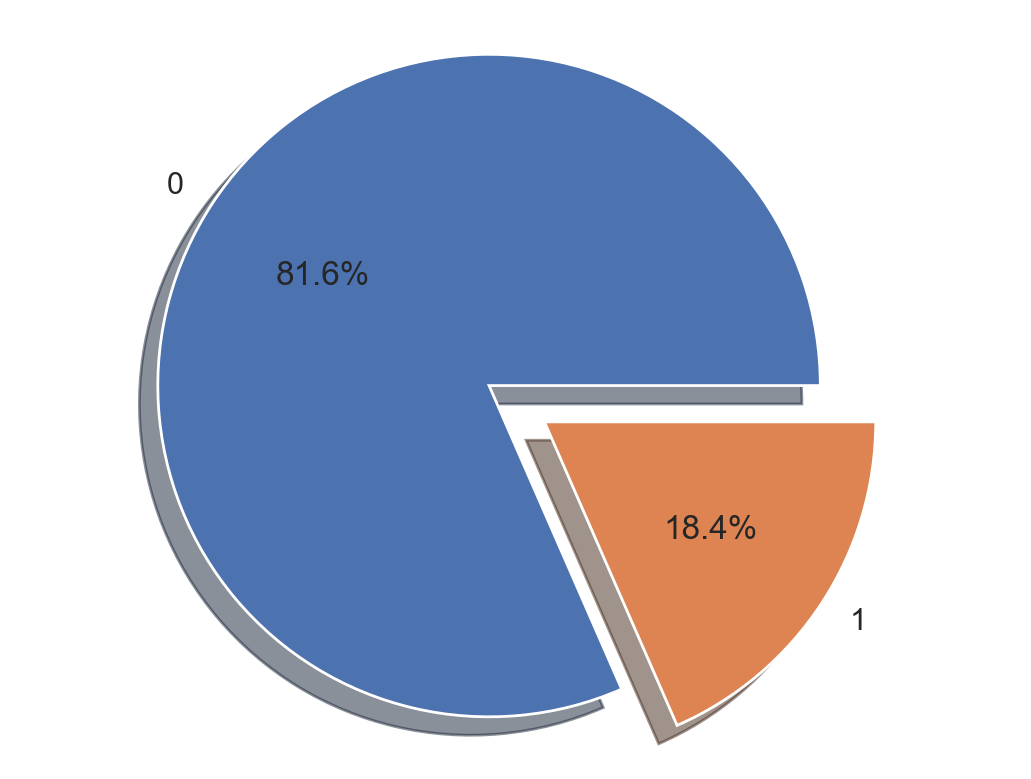

In [188]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=100)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

In [189]:
col_to_drop = ['Fecha-O','Fecha-I','fecha_operacion','DIA','AÑO','Des-I','Vlo-I','Vlo-O','Ori-O','Ori-I','Des-I','Des-O','OPERA','Emp-I','Emp-O',
                'IATA Code','Airport Name','Country','City/Town','ICAO Code','SIGLADES','SIGLAORI','Lat','Long','distance_to_destiny',
                'temporada_alta','NVuelos-Ori-O','Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O','Emp-Vlo-O','dif_min',
               ]
X_train.drop(columns=col_to_drop, inplace = True)
X_test.drop(columns=col_to_drop, inplace = True)

scaler = MinMaxScaler()
X_train.loc[:,['NVuelos-Ori-I','Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I']] = scaler .fit_transform(X_train[['NVuelos-Ori-I',
                                                                                                                  'Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I']])
X_test.loc[:,['NVuelos-Ori-I','Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I']] = scaler.transform(X_test[['NVuelos-Ori-I',
                                                                                                           'Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I']])


transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first',sparse=False,handle_unknown='infrequent_if_exist'), 
        ['Emp-Vlo-I','TIPOVUELO','periodo_dia','DIANOM','MES']),remainder='passthrough'
)

transformed = transformer.fit_transform(X_train)
transformed_x_train = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

transformed = transformer.transform(X_test)
transformed_x_test = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

print(transformed_x_train.shape)
print(transformed_x_test.shape)

(47659, 585)
(20426, 585)


Información del dataset aplicando el algoritmo de undersample:
 y: Counter({0: 38868, 1: 38868})


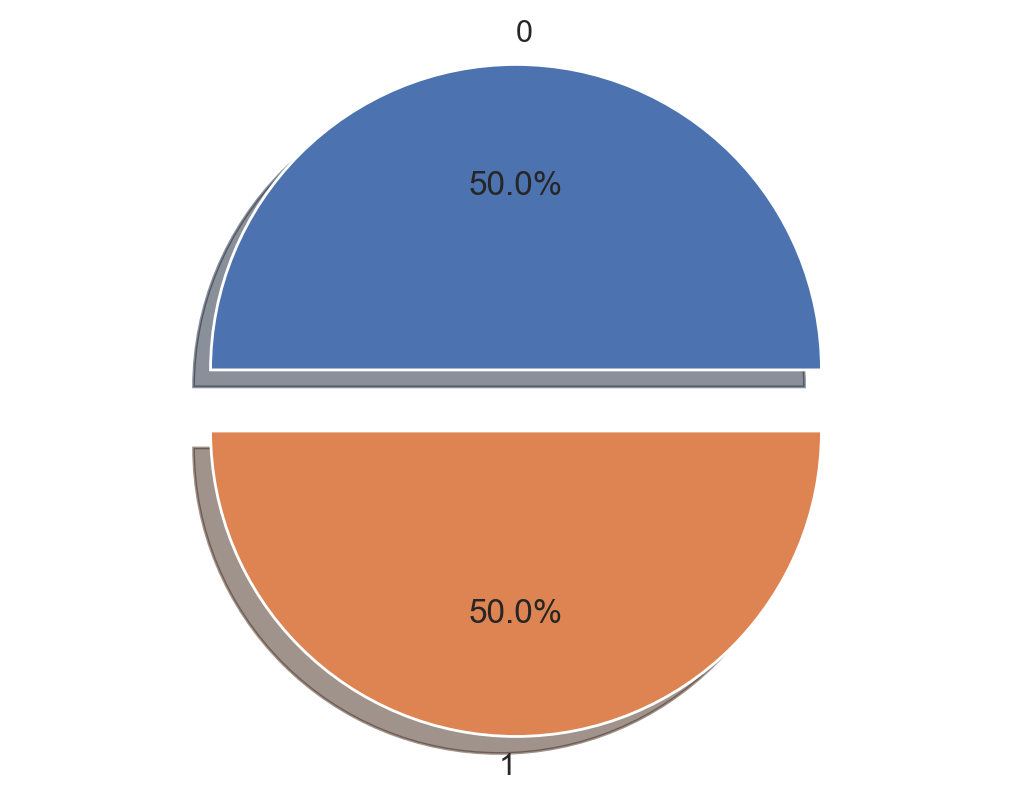

In [190]:
over = RandomOverSampler(sampling_strategy=1, random_state = 43)
X_train_res, y_train_res = over.fit_resample(transformed_x_train, y_train)
print('Información del dataset aplicando el algoritmo de undersample:'
      '\n y: {}'.format(Counter(y_train_res)))
plot_pie(y_train_res)

In [191]:
path = os.getcwd() + '/data/interim/model_data_train_ohe_oversample_outlier.csv' 
X_train_res.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/model_data_test_ohe_oversample_outlier.csv' 
transformed_x_test.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/y_train_ohe_oversample_outlier.csv' 
y_train_res.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/y_test_ohe_oversample_outlier.csv' 
y_test.to_csv(path,
          sep=',',
          index = False
         )

### 5th pipeline (preprocessing_mca)

Here, we applied the MCA dimensional reduction technique which was able to explain 65% of the variance in the train and test data set, which is not that good but is a top-down model to reduce the dimension of the data set.

As you can see, the optimal number of components is around 60 because after that, the marginal growth in explained variance is almost non-existent.


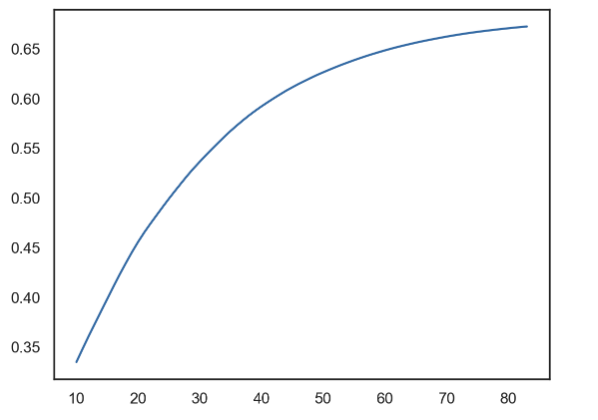


In [192]:
# Loading the joined dataset between flights and Airport database
path = os.getcwd() + '/data/processed/database.csv'
df = pd.read_csv(path, sep=',')
df = create_variables(data = df)
col_to_drop = ['Fecha-O','Fecha-I','fecha_operacion','DIA','AÑO','Vlo-I','Vlo-O','Ori-O','Ori-I','Des-O','OPERA','Emp-O',
               'IATA Code','Airport Name','Country','City/Town','ICAO Code','SIGLADES','SIGLAORI','Lat','Long','distance_to_destiny',
               'temporada_alta','NVuelos-Ori-O','Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O','Emp-Vlo-O','Emp-Vlo-I','dif_min',
               ]
df.drop(columns=col_to_drop, inplace = True)
X = df.copy()
y = X.atraso_15
X.drop('atraso_15', axis=1, inplace=True)
get_na(X)

datos sin NAs en q  Na en q  Na en %
Des-I                                 68206        0      0.0
Emp-I                                 68206        0      0.0
MES                                   68206        0      0.0
DIANOM                                68206        0      0.0
TIPOVUELO                             68206        0      0.0
periodo_dia                           68206        0      0.0
NVuelos-Ori-I                         68206        0      0.0
Nvuelos-Fecha-Emp-I                   68206        0      0.0
Nvuelos-Fecha-Emp-Des-I               68206        0      0.0
Vlo-I_cambio                          68206        0      0.0

Información del dataset:
 las clases del target son: Counter({0: 38914, 1: 8830})


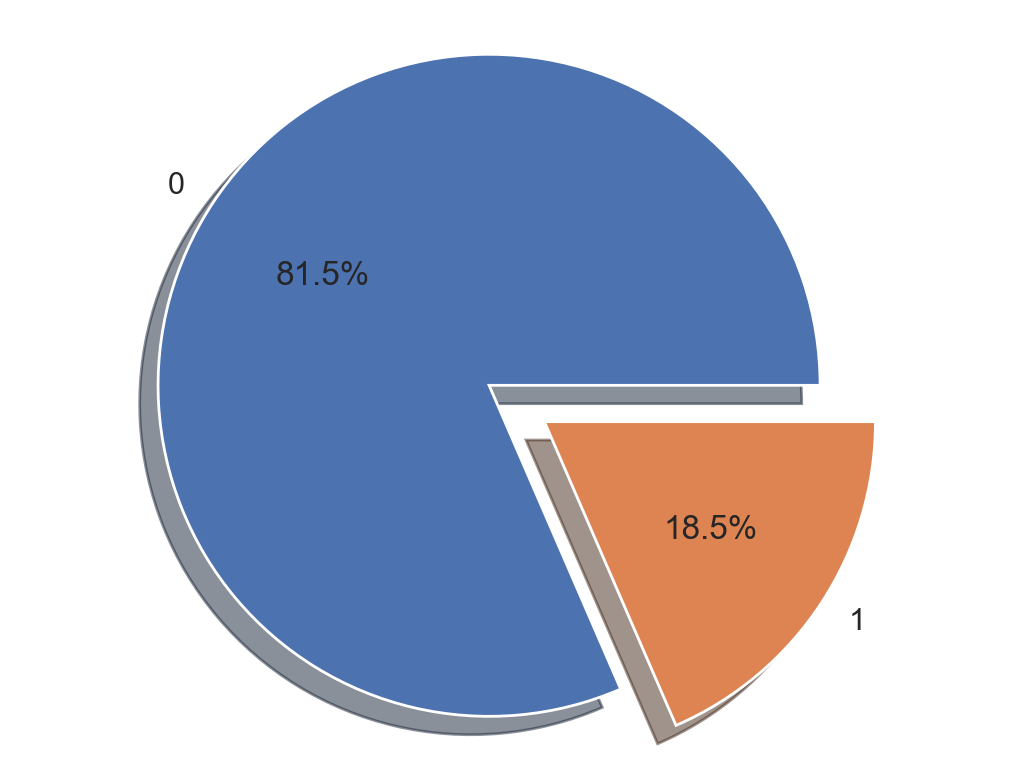

In [193]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=100)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

In [194]:
model = mca.MCA(
    n_components=60,
    n_iter=100,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
mca_data = model.fit(X_train)
mca_x = mca_data.transform(X_train)
print(model.total_inertia_)
path = os.getcwd() + '/data/interim/model_data_train_mca.csv' 
mca_x.to_csv(path,
          sep=',',
          index = False
         )

mca_x = mca_data.transform(X_test)
print(model.total_inertia_)
path = os.getcwd() + '/data/interim/model_data_test_mca.csv' 
mca_x.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/y_train_mca.csv' 
y_train.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/y_test_mca.csv' 
y_test.to_csv(path,
          sep=',',
          index = False
         )

0.648440454189038
0.648440454189038


## Modeling

For this part we trained five models :
    
* Complement Naive Bayes
* Logistic Regression
* Decision tree
* Random Forest
* XGBoost
* Neural network MLP Classifier

But, we only will present a resume of the training results for each one with the four different combinations in order to explain why we selected them.You can check the all experimentation on the rest of the notebook if you are curios about it.

**Metrics choosen to measure the model**

I need to balance 2 objectives:

1.- Have the best precision possible  of the delay because if i don't people will not use the predictions in the real world
2.- Have a aceptable recall of the delay in order to save money to the companie taking actions on the most probable delay flights

Since i need to balance this two objetives i choose the F1-Score of both classes and the F1-score weighted to evaluate the model with unseen data instead of the F1 Score Macro that's ussualy used for this. **This is because i will prioritize to have a litle less recall but mora precision, so with this 3 F1-Score i can have a clear overview of how i am affecting to the mayority and the minority class. Also, serves well to compare how balanced are the predictions between models**

To choose the model for the training part we used the F1-weighted as metric to compare the results from the cross validation, for the same reason exposed above


The results on the data for test were this:
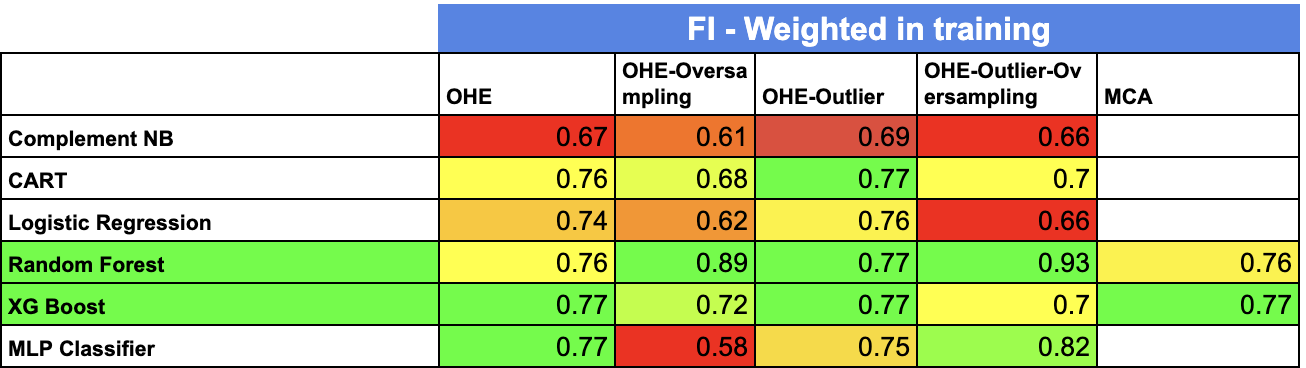


As you can see, the best 2 models measured by the mean of the F1-Weighted with a 5-fold cross validation were Random forest and XGBoost which was expected since this two models ussualy outperform other models in tabular data.

Now we are going to present the results of each one on the test data that the model haven't seen yet.

### Modeling with the first pipeline (preprocessing_ohe)

We present the result in the test data in the image above and we also made the code for the best two in this notebook. However, you can check the complete experiment in the file trianing_dummies.ipynb

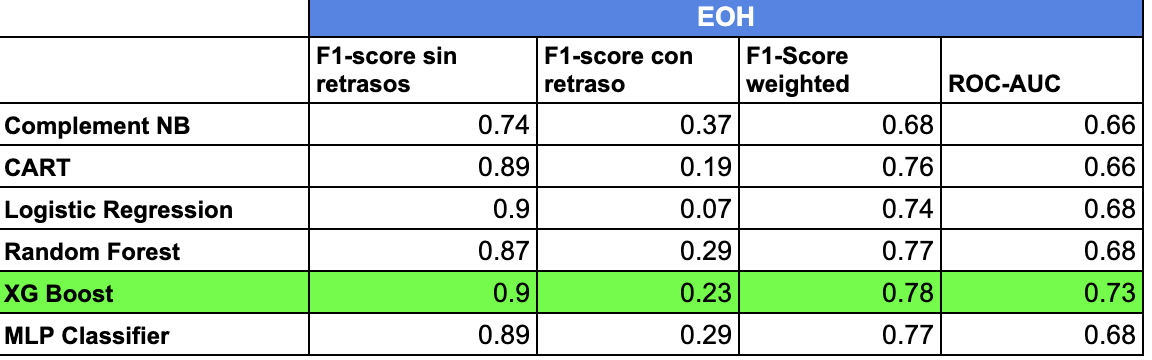


In [195]:
path = os.getcwd() + '/data/interim/model_data_train_ohe.csv' 
X_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/model_data_test_ohe.csv' 
X_test = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_train_ohe.csv' 
y_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_test_ohe.csv' 
y_test = pd.read_csv(path, sep=',')['atraso_15']

In [196]:
xgb = XGBClassifier(random_state=0,verbosity = 0)
y_pred_probs, y_pred = traine(xgb, X_train, y_train,X_test,y_test)
test(y_test, y_pred_probs, y_pred)

El F1-weighted en entrenamiento con validación cruzada es es: 0.7741555862704799
EL ROC AUC Score es: 0.7308219443547943
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     16678
           1       0.60      0.14      0.23      3784

    accuracy                           0.82     20462
   macro avg       0.72      0.56      0.57     20462
weighted avg       0.79      0.82      0.78     20462



Predicted class  False  True    All
Actual class                       
0                16318   360  16678
1                 3243   541   3784
All              19561   901  20462

In [197]:
rf = RandomForestClassifier(n_estimators=500,random_state=0,warm_start=True,criterion='gini',
                             bootstrap=True,max_features='sqrt')
y_pred_probs, y_pred = traine(rf, X_train, y_train,X_test,y_test)
test(y_test, y_pred_probs, y_pred)

El F1-weighted en entrenamiento con validación cruzada es es: 0.7670295280768819
EL ROC AUC Score es: 0.6772929318211607
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     16678
           1       0.38      0.24      0.29      3784

    accuracy                           0.79     20462
   macro avg       0.61      0.57      0.58     20462
weighted avg       0.75      0.79      0.77     20462



Predicted class  False  True    All
Actual class                       
0                15180  1498  16678
1                 2884   900   3784
All              18064  2398  20462

### Modeling with the pipeline with one hot encoder, outlier treatment and oversampling

We present the result in the test data in the image above and we also made the code for the best two in this notebook. However, you can check the complete experiment in the file trianing_dummies_oversample_outlier.ipynb


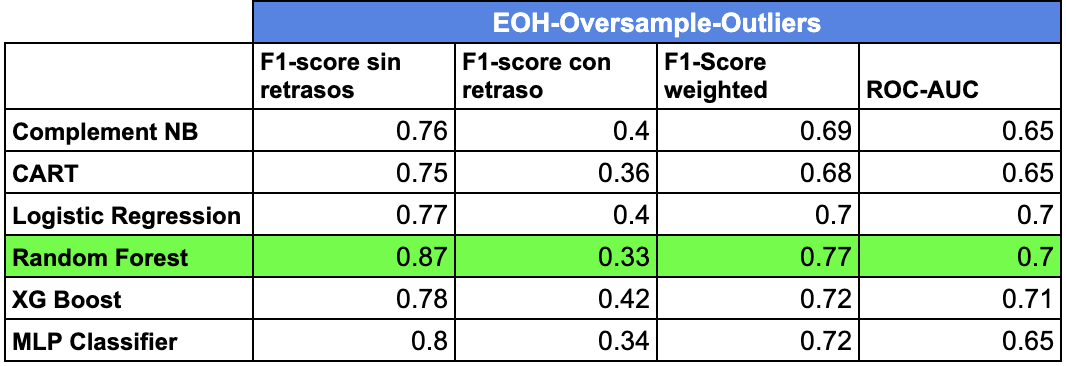

In [198]:
path = os.getcwd() + '/data/interim/model_data_train_ohe_oversample_outlier.csv' 
X_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/model_data_test_ohe_oversample_outlier.csv' 
X_test = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_train_ohe_oversample_outlier.csv' 
y_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_test_ohe_oversample_outlier.csv' 
y_test = pd.read_csv(path, sep=',')['atraso_15']

In [199]:
xgb = XGBClassifier(random_state=0,verbosity = 0)
y_pred_probs, y_pred = traine(xgb, X_train, y_train,X_test,y_test)
test(y_test, y_pred_probs, y_pred)

El F1-weighted en entrenamiento con validación cruzada es es: 0.7025212288738761
EL ROC AUC Score es: 0.7068101447784695
              precision    recall  f1-score   support

           0       0.89      0.69      0.78     16658
           1       0.31      0.60      0.41      3768

    accuracy                           0.68     20426
   macro avg       0.60      0.65      0.59     20426
weighted avg       0.78      0.68      0.71     20426



Predicted class  False  True    All
Actual class                       
0                11549  5109  16658
1                 1496  2272   3768
All              13045  7381  20426

In [ ]:
rf = RandomForestClassifier(n_estimators=500,random_state=0,warm_start=True,criterion='gini',
                             bootstrap=True,max_features='sqrt')
y_pred_probs, y_pred = traine(rf, X_train, y_train,X_test,y_test)
test(y_test, y_pred_probs, y_pred)

El F1-weighted en entrenamiento con validación cruzada es es: 0.9246148152997937
EL ROC AUC Score es: 0.6901490128369936
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     16658
           1       0.35      0.29      0.32      3768

    accuracy                           0.77     20426
   macro avg       0.60      0.58      0.59     20426
weighted avg       0.75      0.77      0.76     20426



Predicted class  False  True    All
Actual class                       
0                14702  1956  16658
1                 2694  1074   3768
All              17396  3030  20426

### Modeling with the MCA pipeline


We present the result in the test data in the image above and we also made the code for the best two in this notebook. However, you can check the complete experiment in the file training_mca.ipynb

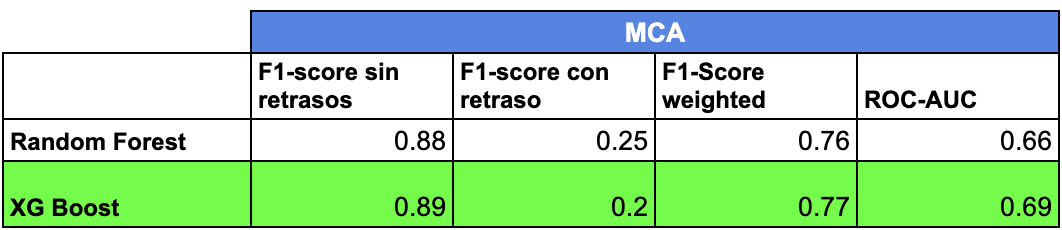


In [ ]:
path = os.getcwd() + '/data/interim/model_data_train_mca.csv' 
X_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/model_data_test_mca.csv' 
X_test = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_train_mca.csv' 
y_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_test_mca.csv' 
y_test = pd.read_csv(path, sep=',')['atraso_15']

In [ ]:
xgb = XGBClassifier(random_state=0,verbosity = 0)
y_pred_probs, y_pred = traine(xgb, X_train, y_train,X_test,y_test)
test(y_test, y_pred_probs, y_pred)

El F1-weighted en entrenamiento con validación cruzada es es: 0.7667584278487289
EL ROC AUC Score es: 0.6915431438968224
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     16678
           1       0.48      0.13      0.20      3784

    accuracy                           0.81     20462
   macro avg       0.65      0.55      0.55     20462
weighted avg       0.76      0.81      0.77     20462



Predicted class  False  True    All
Actual class                       
0                16157   521  16678
1                 3307   477   3784
All              19464   998  20462

In [203]:
rf = RandomForestClassifier(n_estimators=500,random_state=0,warm_start=True,criterion='gini',
                             bootstrap=True,max_features='sqrt')
y_pred_probs, y_pred = traine(rf, X_train, y_train,X_test,y_test)
test(y_test, y_pred_probs, y_pred)

El F1-weighted en entrenamiento con validación cruzada es es: 0.7629558827935864
EL ROC AUC Score es: 0.6651432892440753
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     16678
           1       0.37      0.19      0.25      3784

    accuracy                           0.79     20462
   macro avg       0.60      0.56      0.56     20462
weighted avg       0.75      0.79      0.76     20462



Predicted class  False  True    All
Actual class                       
0                15462  1216  16678
1                 3065   719   3784
All              18527  1935  20462

## Model selection and hiperparameter tunning

I selected **the XGBoost applied to the first pipeline**, since is the most balanced model measure by F1-weighted and ROC-AUC score, and also is the only one where the correct predictions of delay (True positive) are bigger than the wrong predictions of delay (False positive). This is really important for the business because people has to trust in the output of your models if they are taking some action every time you give them and alert. If you give them more false alarms than real alerts they will rapidly lose interest and the tool will become obsolet very fast.

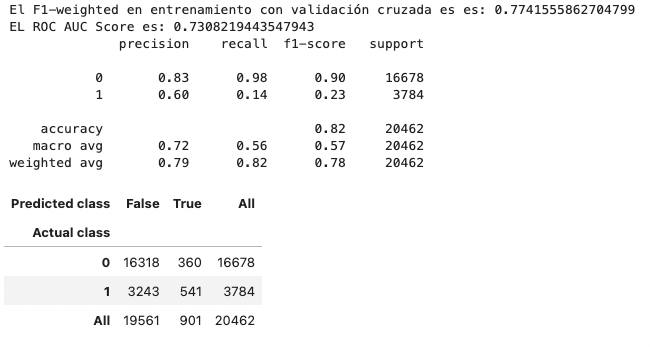

As we can see in the graph, the model is not very good at discriminating the probability of delays, since it is assigning a low probability of delay to a large part of the distribution of observations that are actually delays, but it is doing the same for non-delays. , which is good since it has more concentration of data that are not delays in the low probability of delay than the other models.

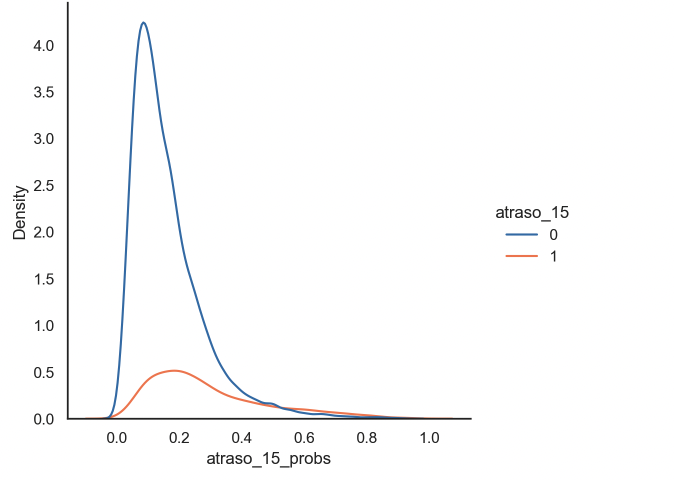

Is important to notice that add and hyperparameter tunning doesn't increase the performance since tends to increase the recall at cost of precision in the delay's prediction as you can see on the results above 


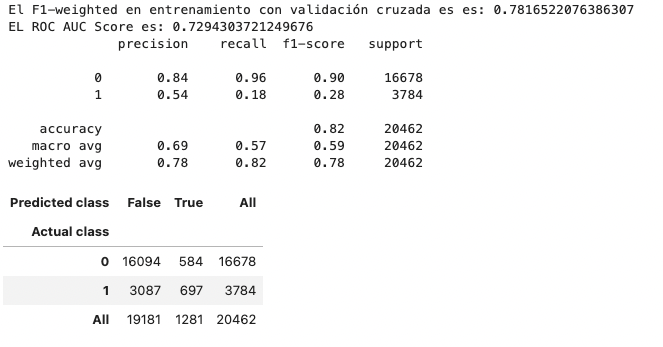


Also, has a very high cost in terms of time, so i will not run it in the re-training.

In [255]:
path = os.getcwd() + '/data/interim/model_data_train_ohe.csv' 
X_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/model_data_test_ohe.csv' 
X_test = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_train_ohe.csv' 
y_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_test_ohe.csv' 
y_test = pd.read_csv(path, sep=',')['atraso_15']

In [211]:
xgboost = XGBClassifier(objective="binary:logistic", random_state=0,verbosity = 0)


# Define the search space
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5],
    "learning_rate":[0.01, 0.3, 0.5],
    "n_estimators": [100, 200],
    "max_depth": [1, 3, 5],
    "objective": ["binary:logistic"],
    "use_label_encoder": [False],
    "booster": ["gbtree"],
    "eval_metric": ["logloss"]
}
    
# Set up score
scoring = ['f1_weighted']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Define grid search
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='f1_weighted', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)
# Print grid search summary
grid_result
# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
#print('The best score standard deviation is', round(grid_result.cv_results_['std_test_recall'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

The best score is 0.7828
The best hyperparameters are {'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200, 'objective': 'binary:logistic', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'use_label_encoder': False}


In [224]:
treshhold = 0.5
y_pred_probs = grid_result.predict_proba(X_test)[:,1]
y_pred = y_pred_probs>=treshhold
test(y_test, y_pred_probs, y_pred)

EL ROC AUC Score es: 0.7294303721249676
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     16678
           1       0.54      0.18      0.28      3784

    accuracy                           0.82     20462
   macro avg       0.69      0.57      0.59     20462
weighted avg       0.78      0.82      0.78     20462



Predicted class  False  True    All
Actual class                       
0                16094   584  16678
1                 3087   697   3784
All              19181  1281  20462

In [238]:
xgb = XGBClassifier(booster = 'gbtree', colsample_bytree = 0.8, eval_metric = 'logloss', learning_rate = 0.5, 
                    max_depth = 5, n_estimators= 200, objective = 'binary:logistic', reg_alpha = 0.5, 
                    reg_lambda = 0.5, use_label_encoder = False,verbosity = 0)
y_pred_probs, y_pred = traine(xgb, X_train, y_train,X_test,y_test)
test(y_test, y_pred_probs, y_pred)

El F1-weighted en entrenamiento con validación cruzada es es: 0.7816522076386307
EL ROC AUC Score es: 0.7294303721249676
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     16678
           1       0.54      0.18      0.28      3784

    accuracy                           0.82     20462
   macro avg       0.69      0.57      0.59     20462
weighted avg       0.78      0.82      0.78     20462



Predicted class  False  True    All
Actual class                       
0                16094   584  16678
1                 3087   697   3784
All              19181  1281  20462

In [252]:
feat_imp = xgb.feature_importances_
data_dict = {'importance': pd.Series(feat_imp, index=X_train.columns)}
feat_imp = pd.DataFrame(data_dict).sort_values(by='importance', ascending = False)
print(feat_imp.shape)
feat_imp[feat_imp.importance>0]

(115, 1)


importance
onehotencoder__x1_CMP     0.198083
onehotencoder__x0_YSSY    0.048091
onehotencoder__x1_ACA     0.033437
onehotencoder__x0_MPTO    0.031139
onehotencoder__x1_LAW     0.025231
...                            ...
onehotencoder__x0_SANU    0.001249
onehotencoder__x0_SCNT    0.000859
onehotencoder__x1_AUT     0.000806
onehotencoder__x1_LAP     0.000727
onehotencoder__x1_LRC     0.000431

[101 rows x 1 columns]

## Conclusions

Although this is the best model we could come up with, it is not a good model as it will correctly predict only 14% of the total delays with 60% accuracy. After analyzing many cases isolating some particular airlines with extremely good performance and others with mixed performance, we conclude that the data we have at the moment can hardly differentiate a flight that will be delayed from one that will not because many times it has only a few observations. delay for each month - weekday and flight number, and attributes are the same as non-delay flights. That's make us think that there is some missing information in this dataset that are external issues like:

* Mechanical problems of the airplane
* Crowded airport of origin
* Crowded airport of destiny
* Problems with the crew of the flight
* Problems in the infraestructure , systems or weather in the airports
* Overbooking flights
* Security problems in the airport

Just to name some of the variables that we may want to take a look

In order to use it for the business and use it to take some action i will not recommend it or maybe just as a complementary tool with the systems that the COO and the counter team already have. 

## Next Steps

To improve it i will go in person into the airports and learn from the real world which data we are missing and could be valuable, how the airline teams in airport and office use the information and manage the contingencys and how could we use the information that they already have to learn form the mistakes of the model and feed the systems with new data and features to improveved in the future.


**On the technical side i will propose the following steps to try**

* Use CatBoost encoding or One leave out target encoding as feature engineer. Probe it with combinations of SMOTE oversampling and MCA

* Add metheorology variables that you can get easily in python from public and private API's. Here you can add the wind, presure, temperature, raining, etc.

<https://python-bloggers.com/2022/08/historical-weather-data/>

<https://medium.com/analytics-vidhya/how-to-import-weather-data-into-python-scripts-7e9ff54f6aca>

<https://github.com/null8626/python-weather>

<https://towardsdatascience.com/obtain-historical-weather-forecast-data-in-csv-format-using-python-5a6c090fc828>

<https://pypi.org/project/wwo-hist/>

<https://www.worldweatheronline.com/weather-api/api/historical-weather-api.aspx>

<https://www.weatherapi.com/login.aspx>

* Add airports and flights information historical and real that you can get easily in python from public and private API's. Here we could have the number of passengers, the size of the plane, context of the airport, etc. <https://geekflare.com/es/flight-data-api/>

**On the business side i will propose a  Methodology to calculate how much money we save with our predictions and introduce it as cost function to optmize the model**

The idea here is to propose a methodology to estimate the save in money that your system will have if in order to have a function of cost that reflect the business needs to optimize in the future.

Now, the profit of the system depends on:

* the cost of delay withouth action
* the cost of take some action. 

So, let's make the following assumptions to make an example to simulate if the solution is profitable or not:

Let's say that we have 150 passenger in each flight and for each time a flight is delayed more than 15 minutes i have to pay 2 times the equivalent to 10% of the seats selled in change of flights, fines to the airport, cost of extra hours of the crew, etc. So, that will be the ticket of 15 passenegers.
Now, let's say the average cost of the ticket is 350USD and the cost to take some preventive actions each time we predict a delay is 2250 USD.

**So, the base escenario is where we don't have any system, so no one takes action on the delays:**

3784 delays multiplied by the cost of delay of (350*15) USD will be 19.866.000 USD of cost


**So, with our selected model the profit will be:**

Now we will have a cost of delay of 3243 delays multiplied by the cost of delay of (350*15) USD will be 17.025.750 USD of cost
Plus, the cost of take action in each alert will be 2250 and has to be multiplied by the 901 alerts that we generated with a total cost of 2.027.250

So, the total cost with our system will be 19.053.000 USD

**Profit of the system**

So, the profit of the system will be the money that we save (19.866k-19.053k) = 813.000 USD.